In [68]:
%matplotlib inline
from fastai import *
from fastai.text import *
from fastai.callbacks import *

In [263]:
import numpy as np
from pathlib import Path
import os
import torch.optim as optim
import random

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

# our models of choice
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
from transformers import AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

In [233]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)
print(f'GPU is available: {torch.cuda.is_available()}')
device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")

fastai version : 1.0.59
transformers version : 2.3.0
GPU is available: True


In [251]:
import argparse
import glob
import json
import logging
import os
import random

import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

from transformers import (
    WEIGHTS_NAME,
    AdamW,
    AlbertConfig,
    AlbertForSequenceClassification,
    AlbertTokenizer,
    BertConfig,
    BertForSequenceClassification,
    BertTokenizer,
    DistilBertConfig,
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    RobertaConfig,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    XLMConfig,
    XLMForSequenceClassification,
    XLMRobertaConfig,
    XLMRobertaForSequenceClassification,
    XLMRobertaTokenizer,
    XLMTokenizer,
    XLNetConfig,
    XLNetForSequenceClassification,
    XLNetTokenizer,
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup
)
from transformers import glue_compute_metrics as compute_metrics
from transformers import glue_convert_examples_to_features as convert_examples_to_features
from transformers import glue_output_modes as output_modes
from transformers import glue_processors as processors

In [252]:
seed = 42
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
seed_all(seed)

In [152]:
import glob

def text_label_pairs_from_folder(path, folders):
    text_label_pairs = [['sentence', 'label']]
    
    for idx, label in enumerate(folders):
        for fname in glob.glob(os.path.join(path, label, '*.*')):
            text_label_pairs.append(list([open(fname,'r').read(), str(idx)]))
    return text_label_pairs

In [179]:
trainpath = Path(path/'train')
testpath  = Path(path/'test')
train_IMDb = text_label_pairs_from_folder(trainpath, ['pos','neg'])
test_IMDb  = text_label_pairs_from_folder(testpath, ['pos','neg'])

In [183]:
len(train_IMDb), len(test_IMDb)

(25001, 25001)

In [184]:
class InputExample(object):
    """
    A single training/test example for simple sequence classification.

    Args:
        guid: Unique id for the example.
        text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
        text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
        label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """

    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"

In [185]:
def _create_examples(lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[0]
            label = line[1]
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

In [186]:
example_IMDb_train = _create_examples(train_IMDb, 'train')
example_IMDb_test  = _create_examples(test_IMDb, 'test')

In [187]:
AlbertForSequenceClassification.pretrained_model_archive_map.keys()

dict_keys(['albert-base-v1', 'albert-large-v1', 'albert-xlarge-v1', 'albert-xxlarge-v1', 'albert-base-v2', 'albert-large-v2', 'albert-xlarge-v2', 'albert-xxlarge-v2'])

In [224]:
pretrained_model_name = 'albert-base-v2'
tokenizer = AlbertTokenizer.from_pretrained(pretrained_model_name)

In [205]:
features_IMDb_train = convert_examples_to_features(
                        example_IMDb_train,
                        tokenizer,
                        label_list=['0','1'],
                        max_length= 256,    # the maximum total input sequence length after tokenization.
                                            # Sequences longer than this will be truncated, shorter will be padded
                        output_mode="classification",
                        pad_on_left=bool('ALBERT' in ["xlnet"]),  # pad on the left for xlnet
                        pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                        pad_token_segment_id=4 if 'ALBERT' in ["xlnet"] else 0,
                        )

In [206]:
features_IMDb_test = convert_examples_to_features(
                        example_IMDb_test,
                        tokenizer,
                        label_list=['0','1'],
                        max_length= 256,    # the maximum total input sequence length after tokenization.
                                            # Sequences longer than this will be truncated, shorter will be padded
                        output_mode="classification",
                        pad_on_left=bool('ALBERT' in ["xlnet"]),  # pad on the left for xlnet
                        pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                        pad_token_segment_id=4 if 'ALBERT' in ["xlnet"] else 0,
                        )

In [207]:
# Convert to Tensors and build dataset

# for train
features = features_IMDb_train

all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
all_labels = torch.tensor([f.label for f in features], dtype=torch.long)

# create train_dataset
dataset_IMDb_train = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)

In [208]:
# Convert to Tensors and build dataset

# for test
features = features_IMDb_test

all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
all_labels = torch.tensor([f.label for f in features], dtype=torch.long)

# create train_dataset
dataset_IMDb_test = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)

In [222]:
len(dataset_IMDb_train), len(dataset_IMDb_test)

(25000, 25000)

### Transformers model Zoo
Create a dictionary of parameters required for creating different model classes

In [4]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig),
    'albert': (AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig)
}

In [229]:
model_class, tokenizer_class, config_class = MODEL_CLASSES['albert']

In [230]:
# Create pretrained model 
config = config_class.from_pretrained(pretrained_model_name, num_labels = 2)

model = model_class.from_pretrained(pretrained_model_name, config = config)

In [236]:
model.to(device);

## Train loop

In [243]:
device

device(type='cuda')

In [276]:
class args_for_training():
    def __init__(self):
        
        # general parameters
        self.train_batch_size   = 4
        self.eval_batch_size    = 4
        self.max_steps          = -1  # set to -1 if we define the training duration by num_epochs
        self.gradient_accumulation_steps = 1  # update for each batch we take in
        self.num_train_epochs   = 5
        self.device = device
        self.model_type         = 'albert'
        self.logging_steps      = 4000
        self.save_steps         = 4000
        self.local_rank         = -1
        self.output_dir = os.path.join(os.getcwd(),'ALBERT')
        self.evaluate_during_training = False
        self.task_name          = 'IMDb'
        self.output_mode        = "classification"
        
        
        # optimizer parameters
        self.weight_decay  = 0.0
        self.learning_rate = 5e-5
        self.adam_epsilon  = 1e-8
        self.warmup_steps  = 4000
        self.model_name_or_path = pretrained_model_name
        self.max_grad_norm = 1.0
        
args = args_for_training()

In [277]:
def train(args, train_dataset, model, tokenizer):
    """ Train the model """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()
   
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)

    t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_cosine_schedule_with_warmup(
        optimizer, num_warmup_steps=int(t_total*0.3), num_training_steps=t_total
    )
#     scheduler =  get get_linear_schedule_with_warmup(
#         optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
#     )

    # Check if saved optimizer or scheduler states exist
    if os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt")) and os.path.isfile(
        os.path.join(args.model_name_or_path, "scheduler.pt")
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))


    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if os.path.exists(args.model_name_or_path):
        # set global_step to gobal_step of last saved checkpoint from model path
        global_step = int(args.model_name_or_path.split("-")[-1].split("/")[0])
        epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
        steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)


    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=False,
    )

    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=False)
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            model.train()
            batch = tuple(t.to(args.device) for t in batch)
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
            if args.model_type != "distilbert":
                inputs["token_type_ids"] = (
                    batch[2] if args.model_type in ["bert", "xlnet", "albert"] else None
                )  # XLM, DistilBERT, RoBERTa, and XLM-RoBERTa don't use segment_ids
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps
            
            loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

                optimizer.step() 
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    logs = {}
                    if (
                        args.local_rank == -1 and args.evaluate_during_training
                    ):  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(args, model, tokenizer)
                        for key, value in results.items():
                            eval_key = "eval_{}".format(key)
                            logs[eval_key] = value

                    loss_scalar = (tr_loss - logging_loss) / args.logging_steps
                    learning_rate_scalar = scheduler.get_lr()[0]
                    logs["learning_rate"] = learning_rate_scalar
                    logs["loss"] = loss_scalar
                    logging_loss = tr_loss

                    for key, value in logs.items():
                        tb_writer.add_scalar(key, value, global_step)
                    print(json.dumps({**logs, **{"step": global_step}}))

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "checkpoint-{}".format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                    logger.info("Saving optimizer and scheduler states to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step

In [278]:
def evaluate(args, model, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_task_names = 'IMDb'
    eval_outputs_dirs = (args.output_dir, args.output_dir + "-MM") if args.task_name == "mnli" else (args.output_dir,)

    results = {}
    for eval_task, eval_output_dir in zip(eval_task_names, eval_outputs_dirs):
        eval_dataset = dataset_IMDb_test

        if not os.path.exists(eval_output_dir) and args.local_rank in [-1, 0]:
            os.makedirs(eval_output_dir)

        
        # Note that DistributedSampler samples randomly
        eval_sampler = SequentialSampler(eval_dataset)
        eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

        
        # Eval!
        
        eval_loss = 0.0
        nb_eval_steps = 0
        preds = None
        out_label_ids = None
        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            model.eval()
            batch = tuple(t.to(args.device) for t in batch)

            with torch.no_grad():
                inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
                if args.model_type != "distilbert":
                    inputs["token_type_ids"] = (
                        batch[2] if args.model_type in ["bert", "xlnet", "albert"] else None
                    )  # XLM, DistilBERT, RoBERTa, and XLM-RoBERTa don't use segment_ids
                outputs = model(**inputs)
                tmp_eval_loss, logits = outputs[:2]

                eval_loss += tmp_eval_loss.mean().item()
            nb_eval_steps += 1
            if preds is None:
                preds = logits.detach().cpu().numpy()
                out_label_ids = inputs["labels"].detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

        eval_loss = eval_loss / nb_eval_steps
        if args.output_mode == "classification":
            preds = np.argmax(preds, axis=1)
        elif args.output_mode == "regression":
            preds = np.squeeze(preds)
        result = compute_metrics(eval_task, preds, out_label_ids)
        results.update(result)

        output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
        with open(output_eval_file, "w") as writer:
            logger.info("***** Eval results {} *****".format(prefix))
            for key in sorted(result.keys()):
                logger.info("  %s = %s", key, str(result[key]))
                writer.write("%s = %s\n" % (key, str(result[key])))

    return results

In [279]:
logger = logging.getLogger(__name__)

In [267]:
global_step, tr_loss = train(args, dataset_IMDb_train, model, tokenizer)
logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)





Epoch:   0%|          | 0/5 [00:00<?, ?it/s]




Iteration:   0%|          | 0/6250 [00:00<?, ?it/s]




Iteration:   0%|          | 1/6250 [00:00<15:15,  6.82it/s]




Iteration:   0%|          | 2/6250 [00:00<14:56,  6.97it/s]




Iteration:   0%|          | 3/6250 [00:00<14:45,  7.06it/s]




Iteration:   0%|          | 4/6250 [00:00<14:23,  7.24it/s]




Iteration:   0%|          | 5/6250 [00:00<14:04,  7.39it/s]




Iteration:   0%|          | 6/6250 [00:00<13:57,  7.46it/s]




Iteration:   0%|          | 7/6250 [00:00<13:52,  7.50it/s]




Iteration:   0%|          | 8/6250 [00:01<13:45,  7.56it/s]




Iteration:   0%|          | 9/6250 [00:01<13:37,  7.63it/s]




Iteration:   0%|          | 10/6250 [00:01<13:34,  7.66it/s]




Iteration:   0%|          | 11/6250 [00:01<13:25,  7.75it/s]




Iteration:   0%|          | 12/6250 [00:01<13:19,  7.80it/s]




Iteration:   0%|          | 13/6250 [00:01<13:28,  7.71it/s]




Iteration:   0%|          | 14/6250 [00:01<13:29,  7.70

Iteration:   2%|▏         | 101/6250 [00:12<12:57,  7.91it/s]




Iteration:   2%|▏         | 102/6250 [00:13<12:52,  7.96it/s]




Iteration:   2%|▏         | 103/6250 [00:13<12:47,  8.01it/s]




Iteration:   2%|▏         | 104/6250 [00:13<12:47,  8.01it/s]




Iteration:   2%|▏         | 105/6250 [00:13<12:49,  7.99it/s]




Iteration:   2%|▏         | 106/6250 [00:13<12:55,  7.92it/s]




Iteration:   2%|▏         | 107/6250 [00:13<12:57,  7.90it/s]




Iteration:   2%|▏         | 108/6250 [00:13<12:51,  7.96it/s]




Iteration:   2%|▏         | 109/6250 [00:13<12:51,  7.96it/s]




Iteration:   2%|▏         | 110/6250 [00:14<12:49,  7.98it/s]




Iteration:   2%|▏         | 111/6250 [00:14<12:51,  7.96it/s]




Iteration:   2%|▏         | 112/6250 [00:14<13:00,  7.86it/s]




Iteration:   2%|▏         | 113/6250 [00:14<13:01,  7.85it/s]




Iteration:   2%|▏         | 114/6250 [00:14<13:04,  7.82it/s]




Iteration:   2%|▏         | 115/6250 [00:14<13:05,  7.81it/s]




Iteration:

Iteration:   3%|▎         | 202/6250 [00:25<12:57,  7.78it/s]




Iteration:   3%|▎         | 203/6250 [00:26<12:58,  7.77it/s]




Iteration:   3%|▎         | 204/6250 [00:26<12:55,  7.80it/s]




Iteration:   3%|▎         | 205/6250 [00:26<12:53,  7.82it/s]




Iteration:   3%|▎         | 206/6250 [00:26<12:58,  7.77it/s]




Iteration:   3%|▎         | 207/6250 [00:26<12:50,  7.84it/s]




Iteration:   3%|▎         | 208/6250 [00:26<12:45,  7.89it/s]




Iteration:   3%|▎         | 209/6250 [00:26<12:54,  7.80it/s]




Iteration:   3%|▎         | 210/6250 [00:26<12:56,  7.78it/s]




Iteration:   3%|▎         | 211/6250 [00:27<13:00,  7.73it/s]




Iteration:   3%|▎         | 212/6250 [00:27<12:52,  7.81it/s]




Iteration:   3%|▎         | 213/6250 [00:27<12:52,  7.81it/s]




Iteration:   3%|▎         | 214/6250 [00:27<12:56,  7.77it/s]




Iteration:   3%|▎         | 215/6250 [00:27<12:58,  7.75it/s]




Iteration:   3%|▎         | 216/6250 [00:27<12:59,  7.75it/s]




Iteration:

Iteration:   5%|▍         | 303/6250 [00:38<12:49,  7.72it/s]




Iteration:   5%|▍         | 304/6250 [00:39<12:44,  7.78it/s]




Iteration:   5%|▍         | 305/6250 [00:39<12:42,  7.79it/s]




Iteration:   5%|▍         | 306/6250 [00:39<12:41,  7.80it/s]




Iteration:   5%|▍         | 307/6250 [00:39<12:38,  7.83it/s]




Iteration:   5%|▍         | 308/6250 [00:39<12:41,  7.80it/s]




Iteration:   5%|▍         | 309/6250 [00:39<12:47,  7.74it/s]




Iteration:   5%|▍         | 310/6250 [00:39<12:48,  7.73it/s]




Iteration:   5%|▍         | 311/6250 [00:39<12:49,  7.72it/s]




Iteration:   5%|▍         | 312/6250 [00:40<12:51,  7.69it/s]




Iteration:   5%|▌         | 313/6250 [00:40<12:52,  7.69it/s]




Iteration:   5%|▌         | 314/6250 [00:40<12:54,  7.67it/s]




Iteration:   5%|▌         | 315/6250 [00:40<12:45,  7.76it/s]




Iteration:   5%|▌         | 316/6250 [00:40<12:34,  7.87it/s]




Iteration:   5%|▌         | 317/6250 [00:40<12:31,  7.90it/s]




Iteration:

Iteration:   6%|▋         | 404/6250 [00:51<12:30,  7.79it/s]




Iteration:   6%|▋         | 405/6250 [00:52<12:33,  7.76it/s]




Iteration:   6%|▋         | 406/6250 [00:52<12:24,  7.85it/s]




Iteration:   7%|▋         | 407/6250 [00:52<12:32,  7.77it/s]




Iteration:   7%|▋         | 408/6250 [00:52<12:34,  7.74it/s]




Iteration:   7%|▋         | 409/6250 [00:52<12:39,  7.69it/s]




Iteration:   7%|▋         | 410/6250 [00:52<12:33,  7.75it/s]




Iteration:   7%|▋         | 411/6250 [00:52<12:33,  7.75it/s]




Iteration:   7%|▋         | 412/6250 [00:52<12:34,  7.74it/s]




Iteration:   7%|▋         | 413/6250 [00:53<12:35,  7.73it/s]




Iteration:   7%|▋         | 414/6250 [00:53<12:33,  7.74it/s]




Iteration:   7%|▋         | 415/6250 [00:53<12:37,  7.70it/s]




Iteration:   7%|▋         | 416/6250 [00:53<12:35,  7.72it/s]




Iteration:   7%|▋         | 417/6250 [00:53<12:26,  7.82it/s]




Iteration:   7%|▋         | 418/6250 [00:53<12:23,  7.84it/s]




Iteration:

Iteration:   8%|▊         | 505/6250 [01:05<12:26,  7.70it/s]




Iteration:   8%|▊         | 506/6250 [01:05<12:28,  7.68it/s]




Iteration:   8%|▊         | 507/6250 [01:05<12:19,  7.77it/s]




Iteration:   8%|▊         | 508/6250 [01:05<12:28,  7.67it/s]




Iteration:   8%|▊         | 509/6250 [01:05<12:22,  7.73it/s]




Iteration:   8%|▊         | 510/6250 [01:05<12:15,  7.80it/s]




Iteration:   8%|▊         | 511/6250 [01:05<12:13,  7.82it/s]




Iteration:   8%|▊         | 512/6250 [01:05<12:47,  7.48it/s]




Iteration:   8%|▊         | 513/6250 [01:06<12:42,  7.53it/s]




Iteration:   8%|▊         | 514/6250 [01:06<12:39,  7.55it/s]




Iteration:   8%|▊         | 515/6250 [01:06<12:34,  7.60it/s]




Iteration:   8%|▊         | 516/6250 [01:06<12:35,  7.59it/s]




Iteration:   8%|▊         | 517/6250 [01:06<12:26,  7.68it/s]




Iteration:   8%|▊         | 518/6250 [01:06<12:17,  7.77it/s]




Iteration:   8%|▊         | 519/6250 [01:06<12:11,  7.84it/s]




Iteration:

Iteration:  10%|▉         | 606/6250 [01:18<12:04,  7.79it/s]




Iteration:  10%|▉         | 607/6250 [01:18<11:57,  7.86it/s]




Iteration:  10%|▉         | 608/6250 [01:18<12:04,  7.78it/s]




Iteration:  10%|▉         | 609/6250 [01:18<12:03,  7.80it/s]




Iteration:  10%|▉         | 610/6250 [01:18<12:05,  7.78it/s]




Iteration:  10%|▉         | 611/6250 [01:18<12:07,  7.75it/s]




Iteration:  10%|▉         | 612/6250 [01:18<12:10,  7.72it/s]




Iteration:  10%|▉         | 613/6250 [01:18<12:15,  7.66it/s]




Iteration:  10%|▉         | 614/6250 [01:19<12:05,  7.76it/s]




Iteration:  10%|▉         | 615/6250 [01:19<12:04,  7.78it/s]




Iteration:  10%|▉         | 616/6250 [01:19<11:59,  7.83it/s]




Iteration:  10%|▉         | 617/6250 [01:19<11:54,  7.88it/s]




Iteration:  10%|▉         | 618/6250 [01:19<11:50,  7.92it/s]




Iteration:  10%|▉         | 619/6250 [01:19<11:59,  7.82it/s]




Iteration:  10%|▉         | 620/6250 [01:19<12:06,  7.75it/s]




Iteration:

Iteration:  11%|█▏        | 707/6250 [01:31<12:10,  7.59it/s]




Iteration:  11%|█▏        | 708/6250 [01:31<12:12,  7.57it/s]




Iteration:  11%|█▏        | 709/6250 [01:31<12:12,  7.56it/s]




Iteration:  11%|█▏        | 710/6250 [01:31<12:08,  7.60it/s]




Iteration:  11%|█▏        | 711/6250 [01:31<12:31,  7.37it/s]




Iteration:  11%|█▏        | 712/6250 [01:31<12:12,  7.56it/s]




Iteration:  11%|█▏        | 713/6250 [01:31<12:08,  7.60it/s]




Iteration:  11%|█▏        | 714/6250 [01:32<12:07,  7.61it/s]




Iteration:  11%|█▏        | 715/6250 [01:32<12:18,  7.50it/s]




Iteration:  11%|█▏        | 716/6250 [01:32<12:22,  7.45it/s]




Iteration:  11%|█▏        | 717/6250 [01:32<12:18,  7.50it/s]




Iteration:  11%|█▏        | 718/6250 [01:32<12:16,  7.51it/s]




Iteration:  12%|█▏        | 719/6250 [01:32<12:15,  7.52it/s]




Iteration:  12%|█▏        | 720/6250 [01:32<12:11,  7.56it/s]




Iteration:  12%|█▏        | 721/6250 [01:32<12:01,  7.66it/s]




Iteration:

Iteration:  13%|█▎        | 808/6250 [01:44<11:49,  7.67it/s]




Iteration:  13%|█▎        | 809/6250 [01:44<11:44,  7.73it/s]




Iteration:  13%|█▎        | 810/6250 [01:44<11:39,  7.78it/s]




Iteration:  13%|█▎        | 811/6250 [01:44<11:39,  7.78it/s]




Iteration:  13%|█▎        | 812/6250 [01:44<11:33,  7.84it/s]




Iteration:  13%|█▎        | 813/6250 [01:44<11:43,  7.72it/s]




Iteration:  13%|█▎        | 814/6250 [01:45<11:44,  7.71it/s]




Iteration:  13%|█▎        | 815/6250 [01:45<11:50,  7.65it/s]




Iteration:  13%|█▎        | 816/6250 [01:45<11:44,  7.71it/s]




Iteration:  13%|█▎        | 817/6250 [01:45<12:09,  7.45it/s]




Iteration:  13%|█▎        | 818/6250 [01:45<11:58,  7.56it/s]




Iteration:  13%|█▎        | 819/6250 [01:45<11:49,  7.65it/s]




Iteration:  13%|█▎        | 820/6250 [01:45<11:53,  7.61it/s]




Iteration:  13%|█▎        | 821/6250 [01:45<11:52,  7.62it/s]




Iteration:  13%|█▎        | 822/6250 [01:46<11:54,  7.59it/s]




Iteration:

Iteration:  15%|█▍        | 909/6250 [01:57<11:22,  7.82it/s]




Iteration:  15%|█▍        | 910/6250 [01:57<11:20,  7.85it/s]




Iteration:  15%|█▍        | 911/6250 [01:57<11:27,  7.76it/s]




Iteration:  15%|█▍        | 912/6250 [01:57<11:31,  7.72it/s]




Iteration:  15%|█▍        | 913/6250 [01:57<11:35,  7.67it/s]




Iteration:  15%|█▍        | 914/6250 [01:58<11:38,  7.63it/s]




Iteration:  15%|█▍        | 915/6250 [01:58<11:45,  7.56it/s]




Iteration:  15%|█▍        | 916/6250 [01:58<11:41,  7.60it/s]




Iteration:  15%|█▍        | 917/6250 [01:58<11:40,  7.62it/s]




Iteration:  15%|█▍        | 918/6250 [01:58<11:39,  7.62it/s]




Iteration:  15%|█▍        | 919/6250 [01:58<11:35,  7.67it/s]




Iteration:  15%|█▍        | 920/6250 [01:58<11:34,  7.68it/s]




Iteration:  15%|█▍        | 921/6250 [01:58<11:37,  7.64it/s]




Iteration:  15%|█▍        | 922/6250 [01:59<11:37,  7.64it/s]




Iteration:  15%|█▍        | 923/6250 [01:59<11:38,  7.63it/s]




Iteration:

Iteration:  16%|█▌        | 1010/6250 [02:10<11:23,  7.66it/s]




Iteration:  16%|█▌        | 1011/6250 [02:10<11:20,  7.69it/s]




Iteration:  16%|█▌        | 1012/6250 [02:10<11:21,  7.69it/s]




Iteration:  16%|█▌        | 1013/6250 [02:10<11:35,  7.53it/s]




Iteration:  16%|█▌        | 1014/6250 [02:11<11:29,  7.59it/s]




Iteration:  16%|█▌        | 1015/6250 [02:11<11:34,  7.54it/s]




Iteration:  16%|█▋        | 1016/6250 [02:11<11:27,  7.61it/s]




Iteration:  16%|█▋        | 1017/6250 [02:11<11:22,  7.67it/s]




Iteration:  16%|█▋        | 1018/6250 [02:11<11:24,  7.65it/s]




Iteration:  16%|█▋        | 1019/6250 [02:11<11:21,  7.68it/s]




Iteration:  16%|█▋        | 1020/6250 [02:11<11:28,  7.60it/s]




Iteration:  16%|█▋        | 1021/6250 [02:12<11:24,  7.64it/s]




Iteration:  16%|█▋        | 1022/6250 [02:12<11:37,  7.49it/s]




Iteration:  16%|█▋        | 1023/6250 [02:12<11:24,  7.63it/s]




Iteration:  16%|█▋        | 1024/6250 [02:12<11:22,  7.66it/s]

Iteration:  18%|█▊        | 1109/6250 [02:23<11:02,  7.75it/s]




Iteration:  18%|█▊        | 1110/6250 [02:23<11:00,  7.78it/s]




Iteration:  18%|█▊        | 1111/6250 [02:23<11:04,  7.74it/s]




Iteration:  18%|█▊        | 1112/6250 [02:23<11:08,  7.68it/s]




Iteration:  18%|█▊        | 1113/6250 [02:24<11:12,  7.63it/s]




Iteration:  18%|█▊        | 1114/6250 [02:24<11:09,  7.68it/s]




Iteration:  18%|█▊        | 1115/6250 [02:24<11:04,  7.72it/s]




Iteration:  18%|█▊        | 1116/6250 [02:24<11:05,  7.71it/s]




Iteration:  18%|█▊        | 1117/6250 [02:24<11:09,  7.66it/s]




Iteration:  18%|█▊        | 1118/6250 [02:24<11:07,  7.68it/s]




Iteration:  18%|█▊        | 1119/6250 [02:24<11:10,  7.65it/s]




Iteration:  18%|█▊        | 1120/6250 [02:24<11:04,  7.72it/s]




Iteration:  18%|█▊        | 1121/6250 [02:25<11:00,  7.76it/s]




Iteration:  18%|█▊        | 1122/6250 [02:25<10:55,  7.82it/s]




Iteration:  18%|█▊        | 1123/6250 [02:25<10:57,  7.80it/s]

Iteration:  19%|█▉        | 1208/6250 [02:36<10:51,  7.74it/s]




Iteration:  19%|█▉        | 1209/6250 [02:36<10:49,  7.76it/s]




Iteration:  19%|█▉        | 1210/6250 [02:36<10:48,  7.77it/s]




Iteration:  19%|█▉        | 1211/6250 [02:36<10:48,  7.78it/s]




Iteration:  19%|█▉        | 1212/6250 [02:36<10:50,  7.75it/s]




Iteration:  19%|█▉        | 1213/6250 [02:37<10:49,  7.75it/s]




Iteration:  19%|█▉        | 1214/6250 [02:37<10:48,  7.76it/s]




Iteration:  19%|█▉        | 1215/6250 [02:37<10:47,  7.77it/s]




Iteration:  19%|█▉        | 1216/6250 [02:37<10:52,  7.72it/s]




Iteration:  19%|█▉        | 1217/6250 [02:37<10:47,  7.77it/s]




Iteration:  19%|█▉        | 1218/6250 [02:37<10:51,  7.72it/s]




Iteration:  20%|█▉        | 1219/6250 [02:37<10:57,  7.65it/s]




Iteration:  20%|█▉        | 1220/6250 [02:38<11:02,  7.59it/s]




Iteration:  20%|█▉        | 1221/6250 [02:38<11:03,  7.58it/s]




Iteration:  20%|█▉        | 1222/6250 [02:38<11:05,  7.56it/s]

Iteration:  21%|██        | 1307/6250 [02:49<10:46,  7.65it/s]




Iteration:  21%|██        | 1308/6250 [02:49<10:47,  7.63it/s]




Iteration:  21%|██        | 1309/6250 [02:49<10:46,  7.64it/s]




Iteration:  21%|██        | 1310/6250 [02:49<11:04,  7.44it/s]




Iteration:  21%|██        | 1311/6250 [02:49<10:58,  7.50it/s]




Iteration:  21%|██        | 1312/6250 [02:50<10:56,  7.52it/s]




Iteration:  21%|██        | 1313/6250 [02:50<10:56,  7.52it/s]




Iteration:  21%|██        | 1314/6250 [02:50<10:51,  7.57it/s]




Iteration:  21%|██        | 1315/6250 [02:50<10:47,  7.62it/s]




Iteration:  21%|██        | 1316/6250 [02:50<10:44,  7.66it/s]




Iteration:  21%|██        | 1317/6250 [02:50<10:42,  7.68it/s]




Iteration:  21%|██        | 1318/6250 [02:50<10:44,  7.65it/s]




Iteration:  21%|██        | 1319/6250 [02:50<10:47,  7.61it/s]




Iteration:  21%|██        | 1320/6250 [02:51<10:47,  7.61it/s]




Iteration:  21%|██        | 1321/6250 [02:51<10:50,  7.58it/s]

Iteration:  22%|██▏       | 1406/6250 [03:02<10:29,  7.70it/s]




Iteration:  23%|██▎       | 1407/6250 [03:02<10:27,  7.72it/s]




Iteration:  23%|██▎       | 1408/6250 [03:02<10:34,  7.63it/s]




Iteration:  23%|██▎       | 1409/6250 [03:02<10:35,  7.61it/s]




Iteration:  23%|██▎       | 1410/6250 [03:02<10:43,  7.53it/s]




Iteration:  23%|██▎       | 1411/6250 [03:03<10:37,  7.59it/s]




Iteration:  23%|██▎       | 1412/6250 [03:03<10:30,  7.67it/s]




Iteration:  23%|██▎       | 1413/6250 [03:03<10:38,  7.58it/s]




Iteration:  23%|██▎       | 1414/6250 [03:03<10:35,  7.61it/s]




Iteration:  23%|██▎       | 1415/6250 [03:03<10:29,  7.68it/s]




Iteration:  23%|██▎       | 1416/6250 [03:03<10:23,  7.75it/s]




Iteration:  23%|██▎       | 1417/6250 [03:03<10:24,  7.74it/s]




Iteration:  23%|██▎       | 1418/6250 [03:04<10:29,  7.68it/s]




Iteration:  23%|██▎       | 1419/6250 [03:04<10:24,  7.74it/s]




Iteration:  23%|██▎       | 1420/6250 [03:04<10:28,  7.68it/s]

Iteration:  24%|██▍       | 1505/6250 [03:15<10:21,  7.63it/s]




Iteration:  24%|██▍       | 1506/6250 [03:15<10:20,  7.64it/s]




Iteration:  24%|██▍       | 1507/6250 [03:15<10:18,  7.67it/s]




Iteration:  24%|██▍       | 1508/6250 [03:15<10:20,  7.65it/s]




Iteration:  24%|██▍       | 1509/6250 [03:16<10:16,  7.68it/s]




Iteration:  24%|██▍       | 1510/6250 [03:16<10:10,  7.76it/s]




Iteration:  24%|██▍       | 1511/6250 [03:16<10:19,  7.65it/s]




Iteration:  24%|██▍       | 1512/6250 [03:16<10:22,  7.61it/s]




Iteration:  24%|██▍       | 1513/6250 [03:16<10:24,  7.59it/s]




Iteration:  24%|██▍       | 1514/6250 [03:16<10:26,  7.55it/s]




Iteration:  24%|██▍       | 1515/6250 [03:16<10:24,  7.58it/s]




Iteration:  24%|██▍       | 1516/6250 [03:16<10:24,  7.58it/s]




Iteration:  24%|██▍       | 1517/6250 [03:17<10:24,  7.58it/s]




Iteration:  24%|██▍       | 1518/6250 [03:17<10:19,  7.64it/s]




Iteration:  24%|██▍       | 1519/6250 [03:17<10:18,  7.65it/s]

Iteration:  26%|██▌       | 1604/6250 [03:28<10:12,  7.59it/s]




Iteration:  26%|██▌       | 1605/6250 [03:28<10:13,  7.57it/s]




Iteration:  26%|██▌       | 1606/6250 [03:28<10:11,  7.59it/s]




Iteration:  26%|██▌       | 1607/6250 [03:28<10:14,  7.56it/s]




Iteration:  26%|██▌       | 1608/6250 [03:28<10:06,  7.65it/s]




Iteration:  26%|██▌       | 1609/6250 [03:29<10:13,  7.56it/s]




Iteration:  26%|██▌       | 1610/6250 [03:29<10:10,  7.60it/s]




Iteration:  26%|██▌       | 1611/6250 [03:29<10:11,  7.58it/s]




Iteration:  26%|██▌       | 1612/6250 [03:29<10:14,  7.55it/s]




Iteration:  26%|██▌       | 1613/6250 [03:29<10:15,  7.53it/s]




Iteration:  26%|██▌       | 1614/6250 [03:29<10:13,  7.56it/s]




Iteration:  26%|██▌       | 1615/6250 [03:29<10:10,  7.59it/s]




Iteration:  26%|██▌       | 1616/6250 [03:29<10:08,  7.62it/s]




Iteration:  26%|██▌       | 1617/6250 [03:30<10:09,  7.60it/s]




Iteration:  26%|██▌       | 1618/6250 [03:30<10:12,  7.57it/s]

Iteration:  27%|██▋       | 1703/6250 [03:41<10:01,  7.56it/s]




Iteration:  27%|██▋       | 1704/6250 [03:41<10:02,  7.55it/s]




Iteration:  27%|██▋       | 1705/6250 [03:41<09:55,  7.64it/s]




Iteration:  27%|██▋       | 1706/6250 [03:41<09:58,  7.59it/s]




Iteration:  27%|██▋       | 1707/6250 [03:41<10:01,  7.55it/s]




Iteration:  27%|██▋       | 1708/6250 [03:42<09:58,  7.59it/s]




Iteration:  27%|██▋       | 1709/6250 [03:42<09:58,  7.58it/s]




Iteration:  27%|██▋       | 1710/6250 [03:42<09:58,  7.59it/s]




Iteration:  27%|██▋       | 1711/6250 [03:42<09:58,  7.58it/s]




Iteration:  27%|██▋       | 1712/6250 [03:42<10:01,  7.54it/s]




Iteration:  27%|██▋       | 1713/6250 [03:42<10:02,  7.53it/s]




Iteration:  27%|██▋       | 1714/6250 [03:42<09:56,  7.60it/s]




Iteration:  27%|██▋       | 1715/6250 [03:42<10:01,  7.54it/s]




Iteration:  27%|██▋       | 1716/6250 [03:43<10:01,  7.54it/s]




Iteration:  27%|██▋       | 1717/6250 [03:43<10:02,  7.52it/s]

Iteration:  29%|██▉       | 1802/6250 [03:54<09:50,  7.53it/s]




Iteration:  29%|██▉       | 1803/6250 [03:54<09:43,  7.63it/s]




Iteration:  29%|██▉       | 1804/6250 [03:54<09:39,  7.67it/s]




Iteration:  29%|██▉       | 1805/6250 [03:54<09:41,  7.64it/s]




Iteration:  29%|██▉       | 1806/6250 [03:54<09:39,  7.67it/s]




Iteration:  29%|██▉       | 1807/6250 [03:55<09:36,  7.70it/s]




Iteration:  29%|██▉       | 1808/6250 [03:55<09:35,  7.72it/s]




Iteration:  29%|██▉       | 1809/6250 [03:55<09:35,  7.72it/s]




Iteration:  29%|██▉       | 1810/6250 [03:55<09:37,  7.69it/s]




Iteration:  29%|██▉       | 1811/6250 [03:55<09:44,  7.59it/s]




Iteration:  29%|██▉       | 1812/6250 [03:55<09:45,  7.58it/s]




Iteration:  29%|██▉       | 1813/6250 [03:55<09:47,  7.55it/s]




Iteration:  29%|██▉       | 1814/6250 [03:56<09:40,  7.64it/s]




Iteration:  29%|██▉       | 1815/6250 [03:56<09:48,  7.53it/s]




Iteration:  29%|██▉       | 1816/6250 [03:56<09:48,  7.54it/s]

Iteration:  30%|███       | 1901/6250 [04:07<09:42,  7.46it/s]




Iteration:  30%|███       | 1902/6250 [04:07<09:38,  7.52it/s]




Iteration:  30%|███       | 1903/6250 [04:07<09:32,  7.59it/s]




Iteration:  30%|███       | 1904/6250 [04:07<09:35,  7.55it/s]




Iteration:  30%|███       | 1905/6250 [04:07<09:34,  7.57it/s]




Iteration:  30%|███       | 1906/6250 [04:08<09:40,  7.48it/s]




Iteration:  31%|███       | 1907/6250 [04:08<09:41,  7.46it/s]




Iteration:  31%|███       | 1908/6250 [04:08<09:34,  7.55it/s]




Iteration:  31%|███       | 1909/6250 [04:08<09:44,  7.43it/s]




Iteration:  31%|███       | 1910/6250 [04:08<09:45,  7.41it/s]




Iteration:  31%|███       | 1911/6250 [04:08<09:41,  7.47it/s]




Iteration:  31%|███       | 1912/6250 [04:08<09:43,  7.43it/s]




Iteration:  31%|███       | 1913/6250 [04:09<09:47,  7.38it/s]




Iteration:  31%|███       | 1914/6250 [04:09<09:47,  7.38it/s]




Iteration:  31%|███       | 1915/6250 [04:09<09:44,  7.42it/s]

Iteration:  32%|███▏      | 2000/6250 [04:20<09:26,  7.50it/s]




Iteration:  32%|███▏      | 2001/6250 [04:20<09:22,  7.56it/s]




Iteration:  32%|███▏      | 2002/6250 [04:20<09:20,  7.57it/s]




Iteration:  32%|███▏      | 2003/6250 [04:20<09:14,  7.66it/s]




Iteration:  32%|███▏      | 2004/6250 [04:21<09:18,  7.61it/s]




Iteration:  32%|███▏      | 2005/6250 [04:21<09:22,  7.55it/s]




Iteration:  32%|███▏      | 2006/6250 [04:21<09:25,  7.51it/s]




Iteration:  32%|███▏      | 2007/6250 [04:21<09:18,  7.60it/s]




Iteration:  32%|███▏      | 2008/6250 [04:21<09:18,  7.59it/s]




Iteration:  32%|███▏      | 2009/6250 [04:21<09:17,  7.61it/s]




Iteration:  32%|███▏      | 2010/6250 [04:21<09:17,  7.60it/s]




Iteration:  32%|███▏      | 2011/6250 [04:22<09:15,  7.63it/s]




Iteration:  32%|███▏      | 2012/6250 [04:22<09:11,  7.69it/s]




Iteration:  32%|███▏      | 2013/6250 [04:22<09:12,  7.66it/s]




Iteration:  32%|███▏      | 2014/6250 [04:22<09:15,  7.62it/s]

Iteration:  34%|███▎      | 2099/6250 [04:33<09:07,  7.58it/s]




Iteration:  34%|███▎      | 2100/6250 [04:33<09:07,  7.57it/s]




Iteration:  34%|███▎      | 2101/6250 [04:33<09:05,  7.60it/s]




Iteration:  34%|███▎      | 2102/6250 [04:34<09:06,  7.58it/s]




Iteration:  34%|███▎      | 2103/6250 [04:34<09:08,  7.56it/s]




Iteration:  34%|███▎      | 2104/6250 [04:34<09:09,  7.54it/s]




Iteration:  34%|███▎      | 2105/6250 [04:34<09:09,  7.55it/s]




Iteration:  34%|███▎      | 2106/6250 [04:34<09:06,  7.59it/s]




Iteration:  34%|███▎      | 2107/6250 [04:34<09:09,  7.54it/s]




Iteration:  34%|███▎      | 2108/6250 [04:34<09:07,  7.57it/s]




Iteration:  34%|███▎      | 2109/6250 [04:34<09:01,  7.65it/s]




Iteration:  34%|███▍      | 2110/6250 [04:35<09:10,  7.52it/s]




Iteration:  34%|███▍      | 2111/6250 [04:35<09:09,  7.54it/s]




Iteration:  34%|███▍      | 2112/6250 [04:35<09:11,  7.50it/s]




Iteration:  34%|███▍      | 2113/6250 [04:35<09:07,  7.56it/s]

Iteration:  35%|███▌      | 2198/6250 [04:46<08:50,  7.64it/s]




Iteration:  35%|███▌      | 2199/6250 [04:46<08:53,  7.59it/s]




Iteration:  35%|███▌      | 2200/6250 [04:46<08:54,  7.58it/s]




Iteration:  35%|███▌      | 2201/6250 [04:47<08:56,  7.55it/s]




Iteration:  35%|███▌      | 2202/6250 [04:47<08:57,  7.53it/s]




Iteration:  35%|███▌      | 2203/6250 [04:47<08:59,  7.50it/s]




Iteration:  35%|███▌      | 2204/6250 [04:47<08:55,  7.55it/s]




Iteration:  35%|███▌      | 2205/6250 [04:47<08:53,  7.58it/s]




Iteration:  35%|███▌      | 2206/6250 [04:47<08:50,  7.62it/s]




Iteration:  35%|███▌      | 2207/6250 [04:47<08:48,  7.65it/s]




Iteration:  35%|███▌      | 2208/6250 [04:47<08:52,  7.59it/s]




Iteration:  35%|███▌      | 2209/6250 [04:48<08:52,  7.59it/s]




Iteration:  35%|███▌      | 2210/6250 [04:48<08:47,  7.66it/s]




Iteration:  35%|███▌      | 2211/6250 [04:48<08:49,  7.63it/s]




Iteration:  35%|███▌      | 2212/6250 [04:48<08:52,  7.58it/s]

Iteration:  37%|███▋      | 2297/6250 [04:59<08:31,  7.73it/s]




Iteration:  37%|███▋      | 2298/6250 [04:59<08:35,  7.66it/s]




Iteration:  37%|███▋      | 2299/6250 [05:00<08:40,  7.59it/s]




Iteration:  37%|███▋      | 2300/6250 [05:00<08:42,  7.56it/s]




Iteration:  37%|███▋      | 2301/6250 [05:00<08:39,  7.60it/s]




Iteration:  37%|███▋      | 2302/6250 [05:00<08:40,  7.59it/s]




Iteration:  37%|███▋      | 2303/6250 [05:00<08:42,  7.55it/s]




Iteration:  37%|███▋      | 2304/6250 [05:00<08:38,  7.61it/s]




Iteration:  37%|███▋      | 2305/6250 [05:00<08:39,  7.59it/s]




Iteration:  37%|███▋      | 2306/6250 [05:00<08:43,  7.54it/s]




Iteration:  37%|███▋      | 2307/6250 [05:01<08:50,  7.44it/s]




Iteration:  37%|███▋      | 2308/6250 [05:01<08:47,  7.48it/s]




Iteration:  37%|███▋      | 2309/6250 [05:01<08:44,  7.51it/s]




Iteration:  37%|███▋      | 2310/6250 [05:01<08:40,  7.57it/s]




Iteration:  37%|███▋      | 2311/6250 [05:01<08:44,  7.50it/s]

Iteration:  38%|███▊      | 2396/6250 [05:12<08:27,  7.60it/s]




Iteration:  38%|███▊      | 2397/6250 [05:12<08:30,  7.55it/s]




Iteration:  38%|███▊      | 2398/6250 [05:12<08:25,  7.62it/s]




Iteration:  38%|███▊      | 2399/6250 [05:13<08:29,  7.56it/s]




Iteration:  38%|███▊      | 2400/6250 [05:13<08:24,  7.63it/s]




Iteration:  38%|███▊      | 2401/6250 [05:13<08:21,  7.67it/s]




Iteration:  38%|███▊      | 2402/6250 [05:13<08:19,  7.71it/s]




Iteration:  38%|███▊      | 2403/6250 [05:13<08:20,  7.69it/s]




Iteration:  38%|███▊      | 2404/6250 [05:13<08:17,  7.72it/s]




Iteration:  38%|███▊      | 2405/6250 [05:13<08:16,  7.75it/s]




Iteration:  38%|███▊      | 2406/6250 [05:14<08:15,  7.76it/s]




Iteration:  39%|███▊      | 2407/6250 [05:14<08:15,  7.76it/s]




Iteration:  39%|███▊      | 2408/6250 [05:14<08:16,  7.74it/s]




Iteration:  39%|███▊      | 2409/6250 [05:14<08:15,  7.76it/s]




Iteration:  39%|███▊      | 2410/6250 [05:14<08:13,  7.78it/s]

Iteration:  40%|███▉      | 2495/6250 [05:25<08:17,  7.55it/s]




Iteration:  40%|███▉      | 2496/6250 [05:25<08:13,  7.60it/s]




Iteration:  40%|███▉      | 2497/6250 [05:26<08:10,  7.65it/s]




Iteration:  40%|███▉      | 2498/6250 [05:26<08:10,  7.65it/s]




Iteration:  40%|███▉      | 2499/6250 [05:26<08:10,  7.65it/s]




Iteration:  40%|████      | 2500/6250 [05:26<08:08,  7.67it/s]




Iteration:  40%|████      | 2501/6250 [05:26<08:10,  7.64it/s]




Iteration:  40%|████      | 2502/6250 [05:26<08:15,  7.56it/s]




Iteration:  40%|████      | 2503/6250 [05:26<08:12,  7.61it/s]




Iteration:  40%|████      | 2504/6250 [05:26<08:16,  7.54it/s]




Iteration:  40%|████      | 2505/6250 [05:27<08:16,  7.55it/s]




Iteration:  40%|████      | 2506/6250 [05:27<08:18,  7.51it/s]




Iteration:  40%|████      | 2507/6250 [05:27<08:22,  7.45it/s]




Iteration:  40%|████      | 2508/6250 [05:27<08:17,  7.52it/s]




Iteration:  40%|████      | 2509/6250 [05:27<08:15,  7.55it/s]

Iteration:  42%|████▏     | 2594/6250 [05:38<08:06,  7.51it/s]




Iteration:  42%|████▏     | 2595/6250 [05:39<08:06,  7.51it/s]




Iteration:  42%|████▏     | 2596/6250 [05:39<08:05,  7.53it/s]




Iteration:  42%|████▏     | 2597/6250 [05:39<08:03,  7.56it/s]




Iteration:  42%|████▏     | 2598/6250 [05:39<08:04,  7.54it/s]




Iteration:  42%|████▏     | 2599/6250 [05:39<08:06,  7.51it/s]




Iteration:  42%|████▏     | 2600/6250 [05:39<08:07,  7.48it/s]




Iteration:  42%|████▏     | 2601/6250 [05:39<08:05,  7.52it/s]




Iteration:  42%|████▏     | 2602/6250 [05:39<07:58,  7.63it/s]




Iteration:  42%|████▏     | 2603/6250 [05:40<08:02,  7.55it/s]




Iteration:  42%|████▏     | 2604/6250 [05:40<08:02,  7.55it/s]




Iteration:  42%|████▏     | 2605/6250 [05:40<07:58,  7.61it/s]




Iteration:  42%|████▏     | 2606/6250 [05:40<07:56,  7.65it/s]




Iteration:  42%|████▏     | 2607/6250 [05:40<07:55,  7.67it/s]




Iteration:  42%|████▏     | 2608/6250 [05:40<07:54,  7.68it/s]

Iteration:  43%|████▎     | 2693/6250 [05:51<07:46,  7.63it/s]




Iteration:  43%|████▎     | 2694/6250 [05:52<07:48,  7.59it/s]




Iteration:  43%|████▎     | 2695/6250 [05:52<07:45,  7.64it/s]




Iteration:  43%|████▎     | 2696/6250 [05:52<07:48,  7.58it/s]




Iteration:  43%|████▎     | 2697/6250 [05:52<07:48,  7.59it/s]




Iteration:  43%|████▎     | 2698/6250 [05:52<07:45,  7.63it/s]




Iteration:  43%|████▎     | 2699/6250 [05:52<07:46,  7.61it/s]




Iteration:  43%|████▎     | 2700/6250 [05:52<07:43,  7.65it/s]




Iteration:  43%|████▎     | 2701/6250 [05:52<07:41,  7.70it/s]




Iteration:  43%|████▎     | 2702/6250 [05:53<07:48,  7.58it/s]




Iteration:  43%|████▎     | 2703/6250 [05:53<07:46,  7.60it/s]




Iteration:  43%|████▎     | 2704/6250 [05:53<07:46,  7.60it/s]




Iteration:  43%|████▎     | 2705/6250 [05:53<07:47,  7.58it/s]




Iteration:  43%|████▎     | 2706/6250 [05:53<07:44,  7.62it/s]




Iteration:  43%|████▎     | 2707/6250 [05:53<07:46,  7.60it/s]

Iteration:  45%|████▍     | 2792/6250 [06:04<07:44,  7.45it/s]




Iteration:  45%|████▍     | 2793/6250 [06:05<07:43,  7.46it/s]




Iteration:  45%|████▍     | 2794/6250 [06:05<07:36,  7.57it/s]




Iteration:  45%|████▍     | 2795/6250 [06:05<07:39,  7.52it/s]




Iteration:  45%|████▍     | 2796/6250 [06:05<07:35,  7.59it/s]




Iteration:  45%|████▍     | 2797/6250 [06:05<07:29,  7.68it/s]




Iteration:  45%|████▍     | 2798/6250 [06:05<07:30,  7.66it/s]




Iteration:  45%|████▍     | 2799/6250 [06:05<07:31,  7.64it/s]




Iteration:  45%|████▍     | 2800/6250 [06:06<07:35,  7.58it/s]




Iteration:  45%|████▍     | 2801/6250 [06:06<07:35,  7.57it/s]




Iteration:  45%|████▍     | 2802/6250 [06:06<07:34,  7.59it/s]




Iteration:  45%|████▍     | 2803/6250 [06:06<07:38,  7.51it/s]




Iteration:  45%|████▍     | 2804/6250 [06:06<07:37,  7.53it/s]




Iteration:  45%|████▍     | 2805/6250 [06:06<07:34,  7.58it/s]




Iteration:  45%|████▍     | 2806/6250 [06:06<07:36,  7.55it/s]

Iteration:  46%|████▋     | 2891/6250 [06:18<07:21,  7.61it/s]




Iteration:  46%|████▋     | 2892/6250 [06:18<07:16,  7.69it/s]




Iteration:  46%|████▋     | 2893/6250 [06:18<07:21,  7.60it/s]




Iteration:  46%|████▋     | 2894/6250 [06:18<07:25,  7.53it/s]




Iteration:  46%|████▋     | 2895/6250 [06:18<07:27,  7.50it/s]




Iteration:  46%|████▋     | 2896/6250 [06:18<07:28,  7.48it/s]




Iteration:  46%|████▋     | 2897/6250 [06:18<07:27,  7.49it/s]




Iteration:  46%|████▋     | 2898/6250 [06:18<07:28,  7.48it/s]




Iteration:  46%|████▋     | 2899/6250 [06:19<07:26,  7.51it/s]




Iteration:  46%|████▋     | 2900/6250 [06:19<07:31,  7.43it/s]




Iteration:  46%|████▋     | 2901/6250 [06:19<07:30,  7.43it/s]




Iteration:  46%|████▋     | 2902/6250 [06:19<07:26,  7.51it/s]




Iteration:  46%|████▋     | 2903/6250 [06:19<07:25,  7.51it/s]




Iteration:  46%|████▋     | 2904/6250 [06:19<07:23,  7.54it/s]




Iteration:  46%|████▋     | 2905/6250 [06:19<07:23,  7.54it/s]

Iteration:  48%|████▊     | 2990/6250 [06:31<07:09,  7.58it/s]




Iteration:  48%|████▊     | 2991/6250 [06:31<07:10,  7.56it/s]




Iteration:  48%|████▊     | 2992/6250 [06:31<07:11,  7.55it/s]




Iteration:  48%|████▊     | 2993/6250 [06:31<07:09,  7.58it/s]




Iteration:  48%|████▊     | 2994/6250 [06:31<07:06,  7.63it/s]




Iteration:  48%|████▊     | 2995/6250 [06:31<07:04,  7.67it/s]




Iteration:  48%|████▊     | 2996/6250 [06:31<07:08,  7.60it/s]




Iteration:  48%|████▊     | 2997/6250 [06:31<07:09,  7.57it/s]




Iteration:  48%|████▊     | 2998/6250 [06:32<07:10,  7.55it/s]




Iteration:  48%|████▊     | 2999/6250 [06:32<07:13,  7.51it/s]




Iteration:  48%|████▊     | 3000/6250 [06:32<07:08,  7.58it/s]




Iteration:  48%|████▊     | 3001/6250 [06:32<07:05,  7.63it/s]




Iteration:  48%|████▊     | 3002/6250 [06:32<07:06,  7.62it/s]




Iteration:  48%|████▊     | 3003/6250 [06:32<07:03,  7.66it/s]




Iteration:  48%|████▊     | 3004/6250 [06:32<07:00,  7.72it/s]

Iteration:  49%|████▉     | 3089/6250 [06:44<06:55,  7.60it/s]




Iteration:  49%|████▉     | 3090/6250 [06:44<06:55,  7.60it/s]




Iteration:  49%|████▉     | 3091/6250 [06:44<06:57,  7.57it/s]




Iteration:  49%|████▉     | 3092/6250 [06:44<06:58,  7.55it/s]




Iteration:  49%|████▉     | 3093/6250 [06:44<06:58,  7.54it/s]




Iteration:  50%|████▉     | 3094/6250 [06:44<07:00,  7.51it/s]




Iteration:  50%|████▉     | 3095/6250 [06:44<06:58,  7.55it/s]




Iteration:  50%|████▉     | 3096/6250 [06:45<06:54,  7.62it/s]




Iteration:  50%|████▉     | 3097/6250 [06:45<06:57,  7.56it/s]




Iteration:  50%|████▉     | 3098/6250 [06:45<06:54,  7.60it/s]




Iteration:  50%|████▉     | 3099/6250 [06:45<06:52,  7.65it/s]




Iteration:  50%|████▉     | 3100/6250 [06:45<06:51,  7.66it/s]




Iteration:  50%|████▉     | 3101/6250 [06:45<06:55,  7.58it/s]




Iteration:  50%|████▉     | 3102/6250 [06:45<06:53,  7.61it/s]




Iteration:  50%|████▉     | 3103/6250 [06:45<06:49,  7.69it/s]

Iteration:  51%|█████     | 3188/6250 [06:57<06:42,  7.61it/s]




Iteration:  51%|█████     | 3189/6250 [06:57<06:45,  7.55it/s]




Iteration:  51%|█████     | 3190/6250 [06:57<06:44,  7.56it/s]




Iteration:  51%|█████     | 3191/6250 [06:57<06:44,  7.56it/s]




Iteration:  51%|█████     | 3192/6250 [06:57<06:43,  7.57it/s]




Iteration:  51%|█████     | 3193/6250 [06:57<06:46,  7.52it/s]




Iteration:  51%|█████     | 3194/6250 [06:57<06:47,  7.51it/s]




Iteration:  51%|█████     | 3195/6250 [06:58<06:45,  7.53it/s]




Iteration:  51%|█████     | 3196/6250 [06:58<06:48,  7.48it/s]




Iteration:  51%|█████     | 3197/6250 [06:58<06:42,  7.58it/s]




Iteration:  51%|█████     | 3198/6250 [06:58<06:38,  7.66it/s]




Iteration:  51%|█████     | 3199/6250 [06:58<06:39,  7.64it/s]




Iteration:  51%|█████     | 3200/6250 [06:58<06:40,  7.62it/s]




Iteration:  51%|█████     | 3201/6250 [06:58<06:36,  7.68it/s]




Iteration:  51%|█████     | 3202/6250 [06:58<06:34,  7.73it/s]

Iteration:  53%|█████▎    | 3287/6250 [07:10<06:24,  7.70it/s]




Iteration:  53%|█████▎    | 3288/6250 [07:10<06:22,  7.75it/s]




Iteration:  53%|█████▎    | 3289/6250 [07:10<06:23,  7.73it/s]




Iteration:  53%|█████▎    | 3290/6250 [07:10<06:21,  7.75it/s]




Iteration:  53%|█████▎    | 3291/6250 [07:10<06:26,  7.66it/s]




Iteration:  53%|█████▎    | 3292/6250 [07:10<06:26,  7.65it/s]




Iteration:  53%|█████▎    | 3293/6250 [07:10<06:27,  7.64it/s]




Iteration:  53%|█████▎    | 3294/6250 [07:10<06:27,  7.63it/s]




Iteration:  53%|█████▎    | 3295/6250 [07:11<06:30,  7.56it/s]




Iteration:  53%|█████▎    | 3296/6250 [07:11<06:26,  7.65it/s]




Iteration:  53%|█████▎    | 3297/6250 [07:11<06:29,  7.58it/s]




Iteration:  53%|█████▎    | 3298/6250 [07:11<06:29,  7.58it/s]




Iteration:  53%|█████▎    | 3299/6250 [07:11<06:29,  7.58it/s]




Iteration:  53%|█████▎    | 3300/6250 [07:11<06:30,  7.55it/s]




Iteration:  53%|█████▎    | 3301/6250 [07:11<06:31,  7.54it/s]

Iteration:  54%|█████▍    | 3386/6250 [07:23<06:17,  7.59it/s]




Iteration:  54%|█████▍    | 3387/6250 [07:23<06:20,  7.53it/s]




Iteration:  54%|█████▍    | 3388/6250 [07:23<06:21,  7.49it/s]




Iteration:  54%|█████▍    | 3389/6250 [07:23<06:16,  7.60it/s]




Iteration:  54%|█████▍    | 3390/6250 [07:23<06:15,  7.61it/s]




Iteration:  54%|█████▍    | 3391/6250 [07:23<06:13,  7.66it/s]




Iteration:  54%|█████▍    | 3392/6250 [07:23<06:13,  7.66it/s]




Iteration:  54%|█████▍    | 3393/6250 [07:24<06:10,  7.71it/s]




Iteration:  54%|█████▍    | 3394/6250 [07:24<06:08,  7.75it/s]




Iteration:  54%|█████▍    | 3395/6250 [07:24<06:09,  7.73it/s]




Iteration:  54%|█████▍    | 3396/6250 [07:24<06:13,  7.64it/s]




Iteration:  54%|█████▍    | 3397/6250 [07:24<06:14,  7.61it/s]




Iteration:  54%|█████▍    | 3398/6250 [07:24<06:16,  7.57it/s]




Iteration:  54%|█████▍    | 3399/6250 [07:24<06:16,  7.57it/s]




Iteration:  54%|█████▍    | 3400/6250 [07:24<06:20,  7.49it/s]

Iteration:  56%|█████▌    | 3485/6250 [07:36<06:08,  7.51it/s]




Iteration:  56%|█████▌    | 3486/6250 [07:36<06:04,  7.59it/s]




Iteration:  56%|█████▌    | 3487/6250 [07:36<06:02,  7.62it/s]




Iteration:  56%|█████▌    | 3488/6250 [07:36<06:03,  7.60it/s]




Iteration:  56%|█████▌    | 3489/6250 [07:36<06:05,  7.55it/s]




Iteration:  56%|█████▌    | 3490/6250 [07:36<06:05,  7.56it/s]




Iteration:  56%|█████▌    | 3491/6250 [07:37<06:04,  7.57it/s]




Iteration:  56%|█████▌    | 3492/6250 [07:37<06:04,  7.56it/s]




Iteration:  56%|█████▌    | 3493/6250 [07:37<06:04,  7.57it/s]




Iteration:  56%|█████▌    | 3494/6250 [07:37<06:05,  7.55it/s]




Iteration:  56%|█████▌    | 3495/6250 [07:37<06:00,  7.65it/s]




Iteration:  56%|█████▌    | 3496/6250 [07:37<06:01,  7.62it/s]




Iteration:  56%|█████▌    | 3497/6250 [07:37<06:02,  7.59it/s]




Iteration:  56%|█████▌    | 3498/6250 [07:37<06:03,  7.57it/s]




Iteration:  56%|█████▌    | 3499/6250 [07:38<06:00,  7.64it/s]

Iteration:  57%|█████▋    | 3584/6250 [07:49<05:48,  7.65it/s]




Iteration:  57%|█████▋    | 3585/6250 [07:49<05:49,  7.62it/s]




Iteration:  57%|█████▋    | 3586/6250 [07:49<05:47,  7.67it/s]




Iteration:  57%|█████▋    | 3587/6250 [07:49<05:50,  7.60it/s]




Iteration:  57%|█████▋    | 3588/6250 [07:49<05:53,  7.53it/s]




Iteration:  57%|█████▋    | 3589/6250 [07:49<05:53,  7.52it/s]




Iteration:  57%|█████▋    | 3590/6250 [07:49<05:53,  7.52it/s]




Iteration:  57%|█████▋    | 3591/6250 [07:50<05:52,  7.55it/s]




Iteration:  57%|█████▋    | 3592/6250 [07:50<05:52,  7.54it/s]




Iteration:  57%|█████▋    | 3593/6250 [07:50<05:52,  7.53it/s]




Iteration:  58%|█████▊    | 3594/6250 [07:50<05:50,  7.58it/s]




Iteration:  58%|█████▊    | 3595/6250 [07:50<05:50,  7.58it/s]




Iteration:  58%|█████▊    | 3596/6250 [07:50<05:52,  7.53it/s]




Iteration:  58%|█████▊    | 3597/6250 [07:50<05:51,  7.55it/s]




Iteration:  58%|█████▊    | 3598/6250 [07:51<05:54,  7.47it/s]

Iteration:  59%|█████▉    | 3683/6250 [08:02<05:33,  7.70it/s]




Iteration:  59%|█████▉    | 3684/6250 [08:02<05:37,  7.61it/s]




Iteration:  59%|█████▉    | 3685/6250 [08:02<05:34,  7.66it/s]




Iteration:  59%|█████▉    | 3686/6250 [08:02<05:33,  7.68it/s]




Iteration:  59%|█████▉    | 3687/6250 [08:02<05:37,  7.60it/s]




Iteration:  59%|█████▉    | 3688/6250 [08:02<05:36,  7.62it/s]




Iteration:  59%|█████▉    | 3689/6250 [08:03<05:38,  7.56it/s]




Iteration:  59%|█████▉    | 3690/6250 [08:03<05:40,  7.52it/s]




Iteration:  59%|█████▉    | 3691/6250 [08:03<05:41,  7.49it/s]




Iteration:  59%|█████▉    | 3692/6250 [08:03<05:39,  7.54it/s]




Iteration:  59%|█████▉    | 3693/6250 [08:03<05:41,  7.49it/s]




Iteration:  59%|█████▉    | 3694/6250 [08:03<05:40,  7.51it/s]




Iteration:  59%|█████▉    | 3695/6250 [08:03<05:42,  7.45it/s]




Iteration:  59%|█████▉    | 3696/6250 [08:03<05:43,  7.43it/s]




Iteration:  59%|█████▉    | 3697/6250 [08:04<05:46,  7.38it/s]

Iteration:  61%|██████    | 3782/6250 [08:15<05:20,  7.69it/s]




Iteration:  61%|██████    | 3783/6250 [08:15<05:17,  7.76it/s]




Iteration:  61%|██████    | 3784/6250 [08:15<05:18,  7.74it/s]




Iteration:  61%|██████    | 3785/6250 [08:15<05:17,  7.77it/s]




Iteration:  61%|██████    | 3786/6250 [08:15<05:16,  7.78it/s]




Iteration:  61%|██████    | 3787/6250 [08:16<05:17,  7.75it/s]




Iteration:  61%|██████    | 3788/6250 [08:16<05:20,  7.67it/s]




Iteration:  61%|██████    | 3789/6250 [08:16<05:18,  7.72it/s]




Iteration:  61%|██████    | 3790/6250 [08:16<05:18,  7.72it/s]




Iteration:  61%|██████    | 3791/6250 [08:16<05:19,  7.69it/s]




Iteration:  61%|██████    | 3792/6250 [08:16<05:21,  7.65it/s]




Iteration:  61%|██████    | 3793/6250 [08:16<05:17,  7.74it/s]




Iteration:  61%|██████    | 3794/6250 [08:16<05:17,  7.73it/s]




Iteration:  61%|██████    | 3795/6250 [08:17<05:17,  7.74it/s]




Iteration:  61%|██████    | 3796/6250 [08:17<05:22,  7.61it/s]

Iteration:  62%|██████▏   | 3881/6250 [08:28<05:05,  7.77it/s]




Iteration:  62%|██████▏   | 3882/6250 [08:28<05:10,  7.64it/s]




Iteration:  62%|██████▏   | 3883/6250 [08:28<05:12,  7.58it/s]




Iteration:  62%|██████▏   | 3884/6250 [08:28<05:13,  7.55it/s]




Iteration:  62%|██████▏   | 3885/6250 [08:28<05:09,  7.65it/s]




Iteration:  62%|██████▏   | 3886/6250 [08:29<05:09,  7.64it/s]




Iteration:  62%|██████▏   | 3887/6250 [08:29<05:12,  7.56it/s]




Iteration:  62%|██████▏   | 3888/6250 [08:29<05:12,  7.55it/s]




Iteration:  62%|██████▏   | 3889/6250 [08:29<05:17,  7.43it/s]




Iteration:  62%|██████▏   | 3890/6250 [08:29<05:17,  7.43it/s]




Iteration:  62%|██████▏   | 3891/6250 [08:29<05:13,  7.53it/s]




Iteration:  62%|██████▏   | 3892/6250 [08:29<05:12,  7.54it/s]




Iteration:  62%|██████▏   | 3893/6250 [08:30<05:11,  7.57it/s]




Iteration:  62%|██████▏   | 3894/6250 [08:30<05:10,  7.58it/s]




Iteration:  62%|██████▏   | 3895/6250 [08:30<05:12,  7.55it/s]

Iteration:  64%|██████▎   | 3980/6250 [08:41<04:56,  7.64it/s]




Iteration:  64%|██████▎   | 3981/6250 [08:41<05:08,  7.35it/s]




Iteration:  64%|██████▎   | 3982/6250 [08:41<05:08,  7.35it/s]




Iteration:  64%|██████▎   | 3983/6250 [08:41<05:02,  7.51it/s]




Iteration:  64%|██████▎   | 3984/6250 [08:42<04:58,  7.60it/s]




Iteration:  64%|██████▍   | 3985/6250 [08:42<04:54,  7.69it/s]




Iteration:  64%|██████▍   | 3986/6250 [08:42<04:52,  7.74it/s]




Iteration:  64%|██████▍   | 3987/6250 [08:42<04:50,  7.80it/s]




Iteration:  64%|██████▍   | 3988/6250 [08:42<04:52,  7.74it/s]




Iteration:  64%|██████▍   | 3989/6250 [08:42<04:54,  7.69it/s]




Iteration:  64%|██████▍   | 3990/6250 [08:42<04:55,  7.64it/s]




Iteration:  64%|██████▍   | 3991/6250 [08:42<04:56,  7.63it/s]




Iteration:  64%|██████▍   | 3992/6250 [08:43<04:54,  7.67it/s]




Iteration:  64%|██████▍   | 3993/6250 [08:43<04:53,  7.70it/s]




Iteration:  64%|██████▍   | 3994/6250 [08:43<04:53,  7.68it/s]

{"learning_rate": 2.1333333333333335e-05, "loss": 0.5539589867852628, "step": 4000}







Iteration:  64%|██████▍   | 4001/6250 [08:44<05:58,  6.27it/s]




Iteration:  64%|██████▍   | 4002/6250 [08:44<05:42,  6.57it/s]




Iteration:  64%|██████▍   | 4003/6250 [08:44<05:41,  6.58it/s]




Iteration:  64%|██████▍   | 4004/6250 [08:44<05:30,  6.80it/s]




Iteration:  64%|██████▍   | 4005/6250 [08:44<05:20,  7.00it/s]




Iteration:  64%|██████▍   | 4006/6250 [08:45<05:10,  7.24it/s]




Iteration:  64%|██████▍   | 4007/6250 [08:45<05:05,  7.33it/s]




Iteration:  64%|██████▍   | 4008/6250 [08:45<04:59,  7.48it/s]




Iteration:  64%|██████▍   | 4009/6250 [08:45<04:57,  7.54it/s]




Iteration:  64%|██████▍   | 4010/6250 [08:45<04:57,  7.54it/s]




Iteration:  64%|██████▍   | 4011/6250 [08:45<04:56,  7.54it/s]




Iteration:  64%|██████▍   | 4012/6250 [08:45<04:55,  7.57it/s]




Iteration:  64%|██████▍   | 4013/6250 [08:45<04:52,  7.65it/s]




Iteration:  64%|██████▍   | 4014/6250 [08:46<04:53,  7.63it/s]




Iteration:  64%|██████▍   | 4015/6250 [08:46<04:50,  7.70

Iteration:  66%|██████▌   | 4100/6250 [08:57<04:39,  7.68it/s]




Iteration:  66%|██████▌   | 4101/6250 [08:57<04:41,  7.64it/s]




Iteration:  66%|██████▌   | 4102/6250 [08:57<04:42,  7.60it/s]




Iteration:  66%|██████▌   | 4103/6250 [08:57<04:43,  7.58it/s]




Iteration:  66%|██████▌   | 4104/6250 [08:57<04:45,  7.53it/s]




Iteration:  66%|██████▌   | 4105/6250 [08:58<04:45,  7.52it/s]




Iteration:  66%|██████▌   | 4106/6250 [08:58<04:43,  7.55it/s]




Iteration:  66%|██████▌   | 4107/6250 [08:58<04:44,  7.53it/s]




Iteration:  66%|██████▌   | 4108/6250 [08:58<04:45,  7.51it/s]




Iteration:  66%|██████▌   | 4109/6250 [08:58<04:46,  7.46it/s]




Iteration:  66%|██████▌   | 4110/6250 [08:58<04:43,  7.55it/s]




Iteration:  66%|██████▌   | 4111/6250 [08:58<04:44,  7.52it/s]




Iteration:  66%|██████▌   | 4112/6250 [08:59<04:43,  7.54it/s]




Iteration:  66%|██████▌   | 4113/6250 [08:59<04:43,  7.53it/s]




Iteration:  66%|██████▌   | 4114/6250 [08:59<04:44,  7.52it/s]

Iteration:  67%|██████▋   | 4199/6250 [09:10<04:29,  7.61it/s]




Iteration:  67%|██████▋   | 4200/6250 [09:10<04:29,  7.59it/s]




Iteration:  67%|██████▋   | 4201/6250 [09:10<04:27,  7.66it/s]




Iteration:  67%|██████▋   | 4202/6250 [09:10<04:25,  7.72it/s]




Iteration:  67%|██████▋   | 4203/6250 [09:11<04:30,  7.56it/s]




Iteration:  67%|██████▋   | 4204/6250 [09:11<04:31,  7.54it/s]




Iteration:  67%|██████▋   | 4205/6250 [09:11<04:30,  7.56it/s]




Iteration:  67%|██████▋   | 4206/6250 [09:11<04:31,  7.52it/s]




Iteration:  67%|██████▋   | 4207/6250 [09:11<04:29,  7.57it/s]




Iteration:  67%|██████▋   | 4208/6250 [09:11<04:27,  7.64it/s]




Iteration:  67%|██████▋   | 4209/6250 [09:11<04:26,  7.66it/s]




Iteration:  67%|██████▋   | 4210/6250 [09:11<04:25,  7.70it/s]




Iteration:  67%|██████▋   | 4211/6250 [09:12<04:23,  7.74it/s]




Iteration:  67%|██████▋   | 4212/6250 [09:12<04:22,  7.77it/s]




Iteration:  67%|██████▋   | 4213/6250 [09:12<04:22,  7.75it/s]

Iteration:  69%|██████▉   | 4298/6250 [09:23<04:14,  7.67it/s]




Iteration:  69%|██████▉   | 4299/6250 [09:23<04:13,  7.70it/s]




Iteration:  69%|██████▉   | 4300/6250 [09:23<04:14,  7.66it/s]




Iteration:  69%|██████▉   | 4301/6250 [09:23<04:16,  7.59it/s]




Iteration:  69%|██████▉   | 4302/6250 [09:23<04:15,  7.63it/s]




Iteration:  69%|██████▉   | 4303/6250 [09:24<04:16,  7.59it/s]




Iteration:  69%|██████▉   | 4304/6250 [09:24<04:14,  7.64it/s]




Iteration:  69%|██████▉   | 4305/6250 [09:24<04:13,  7.66it/s]




Iteration:  69%|██████▉   | 4306/6250 [09:24<04:11,  7.72it/s]




Iteration:  69%|██████▉   | 4307/6250 [09:24<04:12,  7.71it/s]




Iteration:  69%|██████▉   | 4308/6250 [09:24<04:14,  7.64it/s]




Iteration:  69%|██████▉   | 4309/6250 [09:24<04:12,  7.70it/s]




Iteration:  69%|██████▉   | 4310/6250 [09:25<04:13,  7.65it/s]




Iteration:  69%|██████▉   | 4311/6250 [09:25<04:15,  7.59it/s]




Iteration:  69%|██████▉   | 4312/6250 [09:25<04:16,  7.56it/s]

Iteration:  70%|███████   | 4397/6250 [09:36<04:04,  7.59it/s]




Iteration:  70%|███████   | 4398/6250 [09:36<04:02,  7.64it/s]




Iteration:  70%|███████   | 4399/6250 [09:36<04:03,  7.61it/s]




Iteration:  70%|███████   | 4400/6250 [09:36<04:02,  7.62it/s]




Iteration:  70%|███████   | 4401/6250 [09:37<04:02,  7.61it/s]




Iteration:  70%|███████   | 4402/6250 [09:37<04:01,  7.64it/s]




Iteration:  70%|███████   | 4403/6250 [09:37<04:02,  7.61it/s]




Iteration:  70%|███████   | 4404/6250 [09:37<04:02,  7.60it/s]




Iteration:  70%|███████   | 4405/6250 [09:37<04:02,  7.62it/s]




Iteration:  70%|███████   | 4406/6250 [09:37<03:59,  7.69it/s]




Iteration:  71%|███████   | 4407/6250 [09:37<03:59,  7.71it/s]




Iteration:  71%|███████   | 4408/6250 [09:37<03:57,  7.75it/s]




Iteration:  71%|███████   | 4409/6250 [09:38<03:59,  7.69it/s]




Iteration:  71%|███████   | 4410/6250 [09:38<03:58,  7.72it/s]




Iteration:  71%|███████   | 4411/6250 [09:38<04:00,  7.64it/s]

Iteration:  72%|███████▏  | 4496/6250 [09:49<03:53,  7.51it/s]




Iteration:  72%|███████▏  | 4497/6250 [09:49<03:53,  7.51it/s]




Iteration:  72%|███████▏  | 4498/6250 [09:49<03:52,  7.53it/s]




Iteration:  72%|███████▏  | 4499/6250 [09:49<03:54,  7.48it/s]




Iteration:  72%|███████▏  | 4500/6250 [09:50<03:51,  7.56it/s]




Iteration:  72%|███████▏  | 4501/6250 [09:50<03:49,  7.61it/s]




Iteration:  72%|███████▏  | 4502/6250 [09:50<03:49,  7.63it/s]




Iteration:  72%|███████▏  | 4503/6250 [09:50<03:50,  7.56it/s]




Iteration:  72%|███████▏  | 4504/6250 [09:50<03:54,  7.45it/s]




Iteration:  72%|███████▏  | 4505/6250 [09:50<03:50,  7.56it/s]




Iteration:  72%|███████▏  | 4506/6250 [09:50<03:49,  7.60it/s]




Iteration:  72%|███████▏  | 4507/6250 [09:50<03:49,  7.58it/s]




Iteration:  72%|███████▏  | 4508/6250 [09:51<03:47,  7.66it/s]




Iteration:  72%|███████▏  | 4509/6250 [09:51<03:48,  7.62it/s]




Iteration:  72%|███████▏  | 4510/6250 [09:51<03:48,  7.62it/s]

Iteration:  74%|███████▎  | 4595/6250 [10:02<03:36,  7.65it/s]




Iteration:  74%|███████▎  | 4596/6250 [10:02<03:37,  7.59it/s]




Iteration:  74%|███████▎  | 4597/6250 [10:02<03:38,  7.56it/s]




Iteration:  74%|███████▎  | 4598/6250 [10:03<03:37,  7.59it/s]




Iteration:  74%|███████▎  | 4599/6250 [10:03<03:39,  7.52it/s]




Iteration:  74%|███████▎  | 4600/6250 [10:03<03:37,  7.58it/s]




Iteration:  74%|███████▎  | 4601/6250 [10:03<03:38,  7.56it/s]




Iteration:  74%|███████▎  | 4602/6250 [10:03<03:38,  7.53it/s]




Iteration:  74%|███████▎  | 4603/6250 [10:03<03:38,  7.54it/s]




Iteration:  74%|███████▎  | 4604/6250 [10:03<03:37,  7.57it/s]




Iteration:  74%|███████▎  | 4605/6250 [10:03<03:36,  7.58it/s]




Iteration:  74%|███████▎  | 4606/6250 [10:04<03:42,  7.38it/s]




Iteration:  74%|███████▎  | 4607/6250 [10:04<03:38,  7.50it/s]




Iteration:  74%|███████▎  | 4608/6250 [10:04<03:38,  7.52it/s]




Iteration:  74%|███████▎  | 4609/6250 [10:04<03:35,  7.62it/s]

Iteration:  75%|███████▌  | 4694/6250 [10:15<03:24,  7.62it/s]




Iteration:  75%|███████▌  | 4695/6250 [10:15<03:22,  7.68it/s]




Iteration:  75%|███████▌  | 4696/6250 [10:15<03:21,  7.70it/s]




Iteration:  75%|███████▌  | 4697/6250 [10:16<03:22,  7.65it/s]




Iteration:  75%|███████▌  | 4698/6250 [10:16<03:23,  7.63it/s]




Iteration:  75%|███████▌  | 4699/6250 [10:16<03:24,  7.60it/s]




Iteration:  75%|███████▌  | 4700/6250 [10:16<03:24,  7.57it/s]




Iteration:  75%|███████▌  | 4701/6250 [10:16<03:24,  7.57it/s]




Iteration:  75%|███████▌  | 4702/6250 [10:16<03:22,  7.63it/s]




Iteration:  75%|███████▌  | 4703/6250 [10:16<03:22,  7.63it/s]




Iteration:  75%|███████▌  | 4704/6250 [10:16<03:22,  7.63it/s]




Iteration:  75%|███████▌  | 4705/6250 [10:17<03:23,  7.60it/s]




Iteration:  75%|███████▌  | 4706/6250 [10:17<03:23,  7.60it/s]




Iteration:  75%|███████▌  | 4707/6250 [10:17<03:23,  7.58it/s]




Iteration:  75%|███████▌  | 4708/6250 [10:17<03:23,  7.60it/s]

Iteration:  77%|███████▋  | 4793/6250 [10:28<03:13,  7.52it/s]




Iteration:  77%|███████▋  | 4794/6250 [10:28<03:12,  7.56it/s]




Iteration:  77%|███████▋  | 4795/6250 [10:28<03:12,  7.55it/s]




Iteration:  77%|███████▋  | 4796/6250 [10:29<03:11,  7.58it/s]




Iteration:  77%|███████▋  | 4797/6250 [10:29<03:12,  7.53it/s]




Iteration:  77%|███████▋  | 4798/6250 [10:29<03:13,  7.52it/s]




Iteration:  77%|███████▋  | 4799/6250 [10:29<03:15,  7.43it/s]




Iteration:  77%|███████▋  | 4800/6250 [10:29<03:14,  7.46it/s]




Iteration:  77%|███████▋  | 4801/6250 [10:29<03:13,  7.49it/s]




Iteration:  77%|███████▋  | 4802/6250 [10:29<03:13,  7.49it/s]




Iteration:  77%|███████▋  | 4803/6250 [10:30<03:10,  7.59it/s]




Iteration:  77%|███████▋  | 4804/6250 [10:30<03:08,  7.67it/s]




Iteration:  77%|███████▋  | 4805/6250 [10:30<03:08,  7.67it/s]




Iteration:  77%|███████▋  | 4806/6250 [10:30<03:08,  7.68it/s]




Iteration:  77%|███████▋  | 4807/6250 [10:30<03:10,  7.59it/s]

Iteration:  78%|███████▊  | 4892/6250 [10:41<02:57,  7.65it/s]




Iteration:  78%|███████▊  | 4893/6250 [10:41<02:57,  7.65it/s]




Iteration:  78%|███████▊  | 4894/6250 [10:42<02:57,  7.64it/s]




Iteration:  78%|███████▊  | 4895/6250 [10:42<02:58,  7.59it/s]




Iteration:  78%|███████▊  | 4896/6250 [10:42<03:00,  7.49it/s]




Iteration:  78%|███████▊  | 4897/6250 [10:42<02:58,  7.56it/s]




Iteration:  78%|███████▊  | 4898/6250 [10:42<02:57,  7.64it/s]




Iteration:  78%|███████▊  | 4899/6250 [10:42<02:57,  7.60it/s]




Iteration:  78%|███████▊  | 4900/6250 [10:42<02:58,  7.58it/s]




Iteration:  78%|███████▊  | 4901/6250 [10:42<02:58,  7.56it/s]




Iteration:  78%|███████▊  | 4902/6250 [10:43<02:58,  7.57it/s]




Iteration:  78%|███████▊  | 4903/6250 [10:43<02:58,  7.54it/s]




Iteration:  78%|███████▊  | 4904/6250 [10:43<02:56,  7.62it/s]




Iteration:  78%|███████▊  | 4905/6250 [10:43<02:56,  7.62it/s]




Iteration:  78%|███████▊  | 4906/6250 [10:43<02:56,  7.62it/s]

Iteration:  80%|███████▉  | 4991/6250 [10:54<02:46,  7.55it/s]




Iteration:  80%|███████▉  | 4992/6250 [10:54<02:46,  7.57it/s]




Iteration:  80%|███████▉  | 4993/6250 [10:55<02:46,  7.57it/s]




Iteration:  80%|███████▉  | 4994/6250 [10:55<02:46,  7.55it/s]




Iteration:  80%|███████▉  | 4995/6250 [10:55<02:47,  7.51it/s]




Iteration:  80%|███████▉  | 4996/6250 [10:55<02:46,  7.53it/s]




Iteration:  80%|███████▉  | 4997/6250 [10:55<02:46,  7.51it/s]




Iteration:  80%|███████▉  | 4998/6250 [10:55<02:44,  7.60it/s]




Iteration:  80%|███████▉  | 4999/6250 [10:55<02:45,  7.56it/s]




Iteration:  80%|████████  | 5000/6250 [10:56<02:46,  7.51it/s]




Iteration:  80%|████████  | 5001/6250 [10:56<02:43,  7.62it/s]




Iteration:  80%|████████  | 5002/6250 [10:56<02:41,  7.72it/s]




Iteration:  80%|████████  | 5003/6250 [10:56<02:43,  7.63it/s]




Iteration:  80%|████████  | 5004/6250 [10:56<02:44,  7.59it/s]




Iteration:  80%|████████  | 5005/6250 [10:56<02:42,  7.68it/s]

Iteration:  81%|████████▏ | 5090/6250 [11:07<02:31,  7.64it/s]




Iteration:  81%|████████▏ | 5091/6250 [11:08<02:31,  7.66it/s]




Iteration:  81%|████████▏ | 5092/6250 [11:08<02:32,  7.60it/s]




Iteration:  81%|████████▏ | 5093/6250 [11:08<02:30,  7.67it/s]




Iteration:  82%|████████▏ | 5094/6250 [11:08<02:32,  7.56it/s]




Iteration:  82%|████████▏ | 5095/6250 [11:08<02:32,  7.56it/s]




Iteration:  82%|████████▏ | 5096/6250 [11:08<02:31,  7.63it/s]




Iteration:  82%|████████▏ | 5097/6250 [11:08<02:30,  7.68it/s]




Iteration:  82%|████████▏ | 5098/6250 [11:08<02:31,  7.60it/s]




Iteration:  82%|████████▏ | 5099/6250 [11:09<02:31,  7.58it/s]




Iteration:  82%|████████▏ | 5100/6250 [11:09<02:32,  7.53it/s]




Iteration:  82%|████████▏ | 5101/6250 [11:09<02:32,  7.52it/s]




Iteration:  82%|████████▏ | 5102/6250 [11:09<02:32,  7.54it/s]




Iteration:  82%|████████▏ | 5103/6250 [11:09<02:31,  7.58it/s]




Iteration:  82%|████████▏ | 5104/6250 [11:09<02:30,  7.61it/s]

Iteration:  83%|████████▎ | 5189/6250 [11:20<02:21,  7.47it/s]




Iteration:  83%|████████▎ | 5190/6250 [11:21<02:21,  7.51it/s]




Iteration:  83%|████████▎ | 5191/6250 [11:21<02:20,  7.56it/s]




Iteration:  83%|████████▎ | 5192/6250 [11:21<02:21,  7.50it/s]




Iteration:  83%|████████▎ | 5193/6250 [11:21<02:20,  7.52it/s]




Iteration:  83%|████████▎ | 5194/6250 [11:21<02:20,  7.53it/s]




Iteration:  83%|████████▎ | 5195/6250 [11:21<02:19,  7.58it/s]




Iteration:  83%|████████▎ | 5196/6250 [11:21<02:27,  7.15it/s]




Iteration:  83%|████████▎ | 5197/6250 [11:22<02:24,  7.30it/s]




Iteration:  83%|████████▎ | 5198/6250 [11:22<02:22,  7.36it/s]




Iteration:  83%|████████▎ | 5199/6250 [11:22<02:21,  7.45it/s]




Iteration:  83%|████████▎ | 5200/6250 [11:22<02:20,  7.49it/s]




Iteration:  83%|████████▎ | 5201/6250 [11:22<02:17,  7.61it/s]




Iteration:  83%|████████▎ | 5202/6250 [11:22<02:16,  7.67it/s]




Iteration:  83%|████████▎ | 5203/6250 [11:22<02:15,  7.72it/s]

Iteration:  85%|████████▍ | 5288/6250 [11:34<02:07,  7.53it/s]




Iteration:  85%|████████▍ | 5289/6250 [11:34<02:05,  7.63it/s]




Iteration:  85%|████████▍ | 5290/6250 [11:34<02:05,  7.65it/s]




Iteration:  85%|████████▍ | 5291/6250 [11:34<02:05,  7.66it/s]




Iteration:  85%|████████▍ | 5292/6250 [11:34<02:06,  7.60it/s]




Iteration:  85%|████████▍ | 5293/6250 [11:34<02:06,  7.58it/s]




Iteration:  85%|████████▍ | 5294/6250 [11:34<02:06,  7.56it/s]




Iteration:  85%|████████▍ | 5295/6250 [11:34<02:06,  7.53it/s]




Iteration:  85%|████████▍ | 5296/6250 [11:35<02:05,  7.61it/s]




Iteration:  85%|████████▍ | 5297/6250 [11:35<02:06,  7.56it/s]




Iteration:  85%|████████▍ | 5298/6250 [11:35<02:06,  7.52it/s]




Iteration:  85%|████████▍ | 5299/6250 [11:35<02:06,  7.54it/s]




Iteration:  85%|████████▍ | 5300/6250 [11:35<02:05,  7.55it/s]




Iteration:  85%|████████▍ | 5301/6250 [11:35<02:06,  7.51it/s]




Iteration:  85%|████████▍ | 5302/6250 [11:35<02:05,  7.54it/s]

Iteration:  86%|████████▌ | 5387/6250 [11:47<01:53,  7.60it/s]




Iteration:  86%|████████▌ | 5388/6250 [11:47<01:53,  7.59it/s]




Iteration:  86%|████████▌ | 5389/6250 [11:47<01:53,  7.57it/s]




Iteration:  86%|████████▌ | 5390/6250 [11:47<01:53,  7.56it/s]




Iteration:  86%|████████▋ | 5391/6250 [11:47<01:53,  7.55it/s]




Iteration:  86%|████████▋ | 5392/6250 [11:47<01:52,  7.62it/s]




Iteration:  86%|████████▋ | 5393/6250 [11:47<01:51,  7.67it/s]




Iteration:  86%|████████▋ | 5394/6250 [11:48<01:50,  7.71it/s]




Iteration:  86%|████████▋ | 5395/6250 [11:48<01:51,  7.68it/s]




Iteration:  86%|████████▋ | 5396/6250 [11:48<01:52,  7.57it/s]




Iteration:  86%|████████▋ | 5397/6250 [11:48<01:53,  7.49it/s]




Iteration:  86%|████████▋ | 5398/6250 [11:48<01:54,  7.45it/s]




Iteration:  86%|████████▋ | 5399/6250 [11:48<01:53,  7.52it/s]




Iteration:  86%|████████▋ | 5400/6250 [11:48<01:53,  7.52it/s]




Iteration:  86%|████████▋ | 5401/6250 [11:48<01:52,  7.56it/s]

Iteration:  88%|████████▊ | 5486/6250 [12:00<01:40,  7.62it/s]




Iteration:  88%|████████▊ | 5487/6250 [12:00<01:40,  7.60it/s]




Iteration:  88%|████████▊ | 5488/6250 [12:00<01:40,  7.55it/s]




Iteration:  88%|████████▊ | 5489/6250 [12:00<01:40,  7.54it/s]




Iteration:  88%|████████▊ | 5490/6250 [12:00<01:40,  7.56it/s]




Iteration:  88%|████████▊ | 5491/6250 [12:00<01:40,  7.57it/s]




Iteration:  88%|████████▊ | 5492/6250 [12:00<01:39,  7.60it/s]




Iteration:  88%|████████▊ | 5493/6250 [12:01<01:39,  7.59it/s]




Iteration:  88%|████████▊ | 5494/6250 [12:01<01:39,  7.61it/s]




Iteration:  88%|████████▊ | 5495/6250 [12:01<01:39,  7.62it/s]




Iteration:  88%|████████▊ | 5496/6250 [12:01<01:39,  7.57it/s]




Iteration:  88%|████████▊ | 5497/6250 [12:01<01:39,  7.54it/s]




Iteration:  88%|████████▊ | 5498/6250 [12:01<01:38,  7.61it/s]




Iteration:  88%|████████▊ | 5499/6250 [12:01<01:40,  7.45it/s]




Iteration:  88%|████████▊ | 5500/6250 [12:01<01:40,  7.49it/s]

Iteration:  89%|████████▉ | 5585/6250 [12:13<01:28,  7.56it/s]




Iteration:  89%|████████▉ | 5586/6250 [12:13<01:27,  7.57it/s]




Iteration:  89%|████████▉ | 5587/6250 [12:13<01:27,  7.57it/s]




Iteration:  89%|████████▉ | 5588/6250 [12:13<01:29,  7.43it/s]




Iteration:  89%|████████▉ | 5589/6250 [12:13<01:28,  7.48it/s]




Iteration:  89%|████████▉ | 5590/6250 [12:13<01:28,  7.48it/s]




Iteration:  89%|████████▉ | 5591/6250 [12:14<01:27,  7.56it/s]




Iteration:  89%|████████▉ | 5592/6250 [12:14<01:27,  7.52it/s]




Iteration:  89%|████████▉ | 5593/6250 [12:14<01:26,  7.59it/s]




Iteration:  90%|████████▉ | 5594/6250 [12:14<01:25,  7.66it/s]




Iteration:  90%|████████▉ | 5595/6250 [12:14<01:26,  7.56it/s]




Iteration:  90%|████████▉ | 5596/6250 [12:14<01:25,  7.65it/s]




Iteration:  90%|████████▉ | 5597/6250 [12:14<01:26,  7.55it/s]




Iteration:  90%|████████▉ | 5598/6250 [12:14<01:26,  7.53it/s]




Iteration:  90%|████████▉ | 5599/6250 [12:15<01:25,  7.60it/s]

Iteration:  91%|█████████ | 5684/6250 [12:26<01:15,  7.49it/s]




Iteration:  91%|█████████ | 5685/6250 [12:26<01:15,  7.47it/s]




Iteration:  91%|█████████ | 5686/6250 [12:26<01:14,  7.58it/s]




Iteration:  91%|█████████ | 5687/6250 [12:26<01:14,  7.55it/s]




Iteration:  91%|█████████ | 5688/6250 [12:26<01:13,  7.64it/s]




Iteration:  91%|█████████ | 5689/6250 [12:26<01:13,  7.68it/s]




Iteration:  91%|█████████ | 5690/6250 [12:27<01:12,  7.70it/s]




Iteration:  91%|█████████ | 5691/6250 [12:27<01:13,  7.60it/s]




Iteration:  91%|█████████ | 5692/6250 [12:27<01:13,  7.59it/s]




Iteration:  91%|█████████ | 5693/6250 [12:27<01:12,  7.68it/s]




Iteration:  91%|█████████ | 5694/6250 [12:27<01:11,  7.72it/s]




Iteration:  91%|█████████ | 5695/6250 [12:27<01:12,  7.61it/s]




Iteration:  91%|█████████ | 5696/6250 [12:27<01:12,  7.63it/s]




Iteration:  91%|█████████ | 5697/6250 [12:27<01:11,  7.68it/s]




Iteration:  91%|█████████ | 5698/6250 [12:28<01:12,  7.65it/s]

Iteration:  93%|█████████▎| 5783/6250 [12:39<01:00,  7.77it/s]




Iteration:  93%|█████████▎| 5784/6250 [12:39<01:00,  7.66it/s]




Iteration:  93%|█████████▎| 5785/6250 [12:39<01:01,  7.57it/s]




Iteration:  93%|█████████▎| 5786/6250 [12:39<01:01,  7.58it/s]




Iteration:  93%|█████████▎| 5787/6250 [12:39<01:01,  7.56it/s]




Iteration:  93%|█████████▎| 5788/6250 [12:40<01:01,  7.55it/s]




Iteration:  93%|█████████▎| 5789/6250 [12:40<01:01,  7.53it/s]




Iteration:  93%|█████████▎| 5790/6250 [12:40<01:01,  7.52it/s]




Iteration:  93%|█████████▎| 5791/6250 [12:40<01:00,  7.56it/s]




Iteration:  93%|█████████▎| 5792/6250 [12:40<01:00,  7.61it/s]




Iteration:  93%|█████████▎| 5793/6250 [12:40<01:00,  7.57it/s]




Iteration:  93%|█████████▎| 5794/6250 [12:40<01:00,  7.53it/s]




Iteration:  93%|█████████▎| 5795/6250 [12:40<01:00,  7.47it/s]




Iteration:  93%|█████████▎| 5796/6250 [12:41<01:00,  7.45it/s]




Iteration:  93%|█████████▎| 5797/6250 [12:41<00:59,  7.57it/s]

Iteration:  94%|█████████▍| 5882/6250 [12:52<00:48,  7.60it/s]




Iteration:  94%|█████████▍| 5883/6250 [12:52<00:47,  7.67it/s]




Iteration:  94%|█████████▍| 5884/6250 [12:52<00:47,  7.68it/s]




Iteration:  94%|█████████▍| 5885/6250 [12:52<00:47,  7.69it/s]




Iteration:  94%|█████████▍| 5886/6250 [12:52<00:47,  7.60it/s]




Iteration:  94%|█████████▍| 5887/6250 [12:53<00:47,  7.60it/s]




Iteration:  94%|█████████▍| 5888/6250 [12:53<00:47,  7.56it/s]




Iteration:  94%|█████████▍| 5889/6250 [12:53<00:48,  7.50it/s]




Iteration:  94%|█████████▍| 5890/6250 [12:53<00:47,  7.63it/s]




Iteration:  94%|█████████▍| 5891/6250 [12:53<00:47,  7.62it/s]




Iteration:  94%|█████████▍| 5892/6250 [12:53<00:46,  7.68it/s]




Iteration:  94%|█████████▍| 5893/6250 [12:53<00:46,  7.61it/s]




Iteration:  94%|█████████▍| 5894/6250 [12:53<00:47,  7.55it/s]




Iteration:  94%|█████████▍| 5895/6250 [12:54<00:47,  7.47it/s]




Iteration:  94%|█████████▍| 5896/6250 [12:54<00:47,  7.47it/s]

Iteration:  96%|█████████▌| 5981/6250 [13:05<00:35,  7.51it/s]




Iteration:  96%|█████████▌| 5982/6250 [13:05<00:35,  7.61it/s]




Iteration:  96%|█████████▌| 5983/6250 [13:05<00:35,  7.56it/s]




Iteration:  96%|█████████▌| 5984/6250 [13:05<00:34,  7.64it/s]




Iteration:  96%|█████████▌| 5985/6250 [13:06<00:35,  7.44it/s]




Iteration:  96%|█████████▌| 5986/6250 [13:06<00:35,  7.46it/s]




Iteration:  96%|█████████▌| 5987/6250 [13:06<00:35,  7.44it/s]




Iteration:  96%|█████████▌| 5988/6250 [13:06<00:35,  7.36it/s]




Iteration:  96%|█████████▌| 5989/6250 [13:06<00:35,  7.41it/s]




Iteration:  96%|█████████▌| 5990/6250 [13:06<00:34,  7.46it/s]




Iteration:  96%|█████████▌| 5991/6250 [13:06<00:34,  7.53it/s]




Iteration:  96%|█████████▌| 5992/6250 [13:06<00:34,  7.53it/s]




Iteration:  96%|█████████▌| 5993/6250 [13:07<00:33,  7.56it/s]




Iteration:  96%|█████████▌| 5994/6250 [13:07<00:33,  7.60it/s]




Iteration:  96%|█████████▌| 5995/6250 [13:07<00:33,  7.59it/s]

Iteration:  97%|█████████▋| 6080/6250 [13:18<00:22,  7.56it/s]




Iteration:  97%|█████████▋| 6081/6250 [13:18<00:22,  7.54it/s]




Iteration:  97%|█████████▋| 6082/6250 [13:18<00:22,  7.48it/s]




Iteration:  97%|█████████▋| 6083/6250 [13:19<00:22,  7.48it/s]




Iteration:  97%|█████████▋| 6084/6250 [13:19<00:22,  7.51it/s]




Iteration:  97%|█████████▋| 6085/6250 [13:19<00:22,  7.48it/s]




Iteration:  97%|█████████▋| 6086/6250 [13:19<00:21,  7.49it/s]




Iteration:  97%|█████████▋| 6087/6250 [13:19<00:21,  7.51it/s]




Iteration:  97%|█████████▋| 6088/6250 [13:19<00:21,  7.49it/s]




Iteration:  97%|█████████▋| 6089/6250 [13:19<00:21,  7.48it/s]




Iteration:  97%|█████████▋| 6090/6250 [13:19<00:21,  7.50it/s]




Iteration:  97%|█████████▋| 6091/6250 [13:20<00:20,  7.57it/s]




Iteration:  97%|█████████▋| 6092/6250 [13:20<00:20,  7.63it/s]




Iteration:  97%|█████████▋| 6093/6250 [13:20<00:20,  7.59it/s]




Iteration:  98%|█████████▊| 6094/6250 [13:20<00:20,  7.57it/s]

Iteration:  99%|█████████▉| 6179/6250 [13:31<00:09,  7.74it/s]




Iteration:  99%|█████████▉| 6180/6250 [13:31<00:09,  7.65it/s]




Iteration:  99%|█████████▉| 6181/6250 [13:31<00:09,  7.61it/s]




Iteration:  99%|█████████▉| 6182/6250 [13:32<00:08,  7.65it/s]




Iteration:  99%|█████████▉| 6183/6250 [13:32<00:08,  7.64it/s]




Iteration:  99%|█████████▉| 6184/6250 [13:32<00:08,  7.60it/s]




Iteration:  99%|█████████▉| 6185/6250 [13:32<00:08,  7.62it/s]




Iteration:  99%|█████████▉| 6186/6250 [13:32<00:08,  7.66it/s]




Iteration:  99%|█████████▉| 6187/6250 [13:32<00:08,  7.62it/s]




Iteration:  99%|█████████▉| 6188/6250 [13:32<00:08,  7.56it/s]




Iteration:  99%|█████████▉| 6189/6250 [13:32<00:08,  7.57it/s]




Iteration:  99%|█████████▉| 6190/6250 [13:33<00:07,  7.66it/s]




Iteration:  99%|█████████▉| 6191/6250 [13:33<00:07,  7.48it/s]




Iteration:  99%|█████████▉| 6192/6250 [13:33<00:07,  7.41it/s]




Iteration:  99%|█████████▉| 6193/6250 [13:33<00:07,  7.53it/s]

Iteration:   0%|          | 28/6250 [00:03<13:36,  7.62it/s]




Iteration:   0%|          | 29/6250 [00:03<13:27,  7.70it/s]




Iteration:   0%|          | 30/6250 [00:03<13:21,  7.76it/s]




Iteration:   0%|          | 31/6250 [00:04<13:20,  7.77it/s]




Iteration:   1%|          | 32/6250 [00:04<13:26,  7.71it/s]




Iteration:   1%|          | 33/6250 [00:04<13:27,  7.70it/s]




Iteration:   1%|          | 34/6250 [00:04<13:28,  7.69it/s]




Iteration:   1%|          | 35/6250 [00:04<13:27,  7.70it/s]




Iteration:   1%|          | 36/6250 [00:04<13:21,  7.76it/s]




Iteration:   1%|          | 37/6250 [00:04<13:28,  7.68it/s]




Iteration:   1%|          | 38/6250 [00:04<13:25,  7.71it/s]




Iteration:   1%|          | 39/6250 [00:05<13:29,  7.68it/s]




Iteration:   1%|          | 40/6250 [00:05<13:23,  7.73it/s]




Iteration:   1%|          | 41/6250 [00:05<13:21,  7.75it/s]




Iteration:   1%|          | 42/6250 [00:05<13:33,  7.63it/s]




Iteration:   1%|         

Iteration:   2%|▏         | 130/6250 [00:17<13:42,  7.44it/s]




Iteration:   2%|▏         | 131/6250 [00:17<13:33,  7.52it/s]




Iteration:   2%|▏         | 132/6250 [00:17<13:36,  7.49it/s]




Iteration:   2%|▏         | 133/6250 [00:17<13:51,  7.35it/s]




Iteration:   2%|▏         | 134/6250 [00:17<13:46,  7.40it/s]




Iteration:   2%|▏         | 135/6250 [00:17<13:40,  7.45it/s]




Iteration:   2%|▏         | 136/6250 [00:17<13:36,  7.49it/s]




Iteration:   2%|▏         | 137/6250 [00:17<13:33,  7.52it/s]




Iteration:   2%|▏         | 138/6250 [00:18<13:23,  7.61it/s]




Iteration:   2%|▏         | 139/6250 [00:18<13:16,  7.67it/s]




Iteration:   2%|▏         | 140/6250 [00:18<13:23,  7.61it/s]




Iteration:   2%|▏         | 141/6250 [00:18<13:17,  7.66it/s]




Iteration:   2%|▏         | 142/6250 [00:18<13:16,  7.67it/s]




Iteration:   2%|▏         | 143/6250 [00:18<13:17,  7.65it/s]




Iteration:   2%|▏         | 144/6250 [00:18<13:21,  7.62it/s]




Iteration:

Iteration:   4%|▎         | 231/6250 [00:30<13:08,  7.64it/s]




Iteration:   4%|▎         | 232/6250 [00:30<13:11,  7.61it/s]




Iteration:   4%|▎         | 233/6250 [00:30<13:14,  7.57it/s]




Iteration:   4%|▎         | 234/6250 [00:30<13:21,  7.51it/s]




Iteration:   4%|▍         | 235/6250 [00:30<13:15,  7.56it/s]




Iteration:   4%|▍         | 236/6250 [00:30<13:09,  7.61it/s]




Iteration:   4%|▍         | 237/6250 [00:31<13:29,  7.42it/s]




Iteration:   4%|▍         | 238/6250 [00:31<13:21,  7.50it/s]




Iteration:   4%|▍         | 239/6250 [00:31<13:18,  7.53it/s]




Iteration:   4%|▍         | 240/6250 [00:31<13:18,  7.53it/s]




Iteration:   4%|▍         | 241/6250 [00:31<13:12,  7.58it/s]




Iteration:   4%|▍         | 242/6250 [00:31<13:05,  7.65it/s]




Iteration:   4%|▍         | 243/6250 [00:31<13:10,  7.60it/s]




Iteration:   4%|▍         | 244/6250 [00:32<13:15,  7.55it/s]




Iteration:   4%|▍         | 245/6250 [00:32<13:11,  7.59it/s]




Iteration:

Iteration:   5%|▌         | 332/6250 [00:43<13:00,  7.58it/s]




Iteration:   5%|▌         | 333/6250 [00:43<12:57,  7.61it/s]




Iteration:   5%|▌         | 334/6250 [00:43<12:55,  7.63it/s]




Iteration:   5%|▌         | 335/6250 [00:44<12:50,  7.68it/s]




Iteration:   5%|▌         | 336/6250 [00:44<13:00,  7.57it/s]




Iteration:   5%|▌         | 337/6250 [00:44<12:57,  7.60it/s]




Iteration:   5%|▌         | 338/6250 [00:44<12:57,  7.60it/s]




Iteration:   5%|▌         | 339/6250 [00:44<13:05,  7.53it/s]




Iteration:   5%|▌         | 340/6250 [00:44<13:05,  7.52it/s]




Iteration:   5%|▌         | 341/6250 [00:44<13:05,  7.52it/s]




Iteration:   5%|▌         | 342/6250 [00:44<13:03,  7.54it/s]




Iteration:   5%|▌         | 343/6250 [00:45<13:00,  7.56it/s]




Iteration:   6%|▌         | 344/6250 [00:45<13:04,  7.52it/s]




Iteration:   6%|▌         | 345/6250 [00:45<13:08,  7.49it/s]




Iteration:   6%|▌         | 346/6250 [00:45<13:07,  7.49it/s]




Iteration:

Iteration:   7%|▋         | 433/6250 [00:57<13:29,  7.19it/s]




Iteration:   7%|▋         | 434/6250 [00:57<13:19,  7.28it/s]




Iteration:   7%|▋         | 435/6250 [00:57<13:17,  7.29it/s]




Iteration:   7%|▋         | 436/6250 [00:57<13:01,  7.44it/s]




Iteration:   7%|▋         | 437/6250 [00:57<12:55,  7.49it/s]




Iteration:   7%|▋         | 438/6250 [00:57<12:49,  7.56it/s]




Iteration:   7%|▋         | 439/6250 [00:57<12:45,  7.59it/s]




Iteration:   7%|▋         | 440/6250 [00:57<12:39,  7.65it/s]




Iteration:   7%|▋         | 441/6250 [00:58<12:52,  7.52it/s]




Iteration:   7%|▋         | 442/6250 [00:58<13:08,  7.37it/s]




Iteration:   7%|▋         | 443/6250 [00:58<12:55,  7.49it/s]




Iteration:   7%|▋         | 444/6250 [00:58<12:48,  7.56it/s]




Iteration:   7%|▋         | 445/6250 [00:58<12:49,  7.55it/s]




Iteration:   7%|▋         | 446/6250 [00:58<12:48,  7.55it/s]




Iteration:   7%|▋         | 447/6250 [00:58<12:44,  7.59it/s]




Iteration:

Iteration:   9%|▊         | 534/6250 [01:10<12:20,  7.72it/s]




Iteration:   9%|▊         | 535/6250 [01:10<12:21,  7.71it/s]




Iteration:   9%|▊         | 536/6250 [01:10<12:21,  7.71it/s]




Iteration:   9%|▊         | 537/6250 [01:10<12:17,  7.74it/s]




Iteration:   9%|▊         | 538/6250 [01:10<12:18,  7.74it/s]




Iteration:   9%|▊         | 539/6250 [01:11<12:26,  7.65it/s]




Iteration:   9%|▊         | 540/6250 [01:11<12:34,  7.57it/s]




Iteration:   9%|▊         | 541/6250 [01:11<12:37,  7.54it/s]




Iteration:   9%|▊         | 542/6250 [01:11<12:34,  7.57it/s]




Iteration:   9%|▊         | 543/6250 [01:11<12:35,  7.55it/s]




Iteration:   9%|▊         | 544/6250 [01:11<12:33,  7.57it/s]




Iteration:   9%|▊         | 545/6250 [01:11<12:25,  7.66it/s]




Iteration:   9%|▊         | 546/6250 [01:11<12:28,  7.62it/s]




Iteration:   9%|▉         | 547/6250 [01:12<12:33,  7.57it/s]




Iteration:   9%|▉         | 548/6250 [01:12<12:28,  7.62it/s]




Iteration:

Iteration:  10%|█         | 635/6250 [01:23<12:27,  7.51it/s]




Iteration:  10%|█         | 636/6250 [01:23<12:34,  7.44it/s]




Iteration:  10%|█         | 637/6250 [01:23<12:26,  7.51it/s]




Iteration:  10%|█         | 638/6250 [01:24<12:17,  7.61it/s]




Iteration:  10%|█         | 639/6250 [01:24<12:10,  7.68it/s]




Iteration:  10%|█         | 640/6250 [01:24<12:08,  7.71it/s]




Iteration:  10%|█         | 641/6250 [01:24<12:12,  7.65it/s]




Iteration:  10%|█         | 642/6250 [01:24<12:14,  7.63it/s]




Iteration:  10%|█         | 643/6250 [01:24<12:08,  7.70it/s]




Iteration:  10%|█         | 644/6250 [01:24<12:05,  7.72it/s]




Iteration:  10%|█         | 645/6250 [01:25<12:06,  7.71it/s]




Iteration:  10%|█         | 646/6250 [01:25<12:04,  7.74it/s]




Iteration:  10%|█         | 647/6250 [01:25<12:08,  7.70it/s]




Iteration:  10%|█         | 648/6250 [01:25<12:04,  7.74it/s]




Iteration:  10%|█         | 649/6250 [01:25<12:01,  7.77it/s]




Iteration:

Iteration:  12%|█▏        | 736/6250 [01:36<11:55,  7.70it/s]




Iteration:  12%|█▏        | 737/6250 [01:37<11:50,  7.76it/s]




Iteration:  12%|█▏        | 738/6250 [01:37<11:49,  7.77it/s]




Iteration:  12%|█▏        | 739/6250 [01:37<11:56,  7.69it/s]




Iteration:  12%|█▏        | 740/6250 [01:37<11:52,  7.73it/s]




Iteration:  12%|█▏        | 741/6250 [01:37<11:59,  7.65it/s]




Iteration:  12%|█▏        | 742/6250 [01:37<12:05,  7.59it/s]




Iteration:  12%|█▏        | 743/6250 [01:37<12:08,  7.56it/s]




Iteration:  12%|█▏        | 744/6250 [01:38<12:02,  7.62it/s]




Iteration:  12%|█▏        | 745/6250 [01:38<11:58,  7.66it/s]




Iteration:  12%|█▏        | 746/6250 [01:38<12:01,  7.63it/s]




Iteration:  12%|█▏        | 747/6250 [01:38<11:52,  7.72it/s]




Iteration:  12%|█▏        | 748/6250 [01:38<11:56,  7.68it/s]




Iteration:  12%|█▏        | 749/6250 [01:38<12:03,  7.60it/s]




Iteration:  12%|█▏        | 750/6250 [01:38<11:58,  7.66it/s]




Iteration:

Iteration:  13%|█▎        | 837/6250 [01:50<11:46,  7.66it/s]




Iteration:  13%|█▎        | 838/6250 [01:50<12:03,  7.48it/s]




Iteration:  13%|█▎        | 839/6250 [01:50<12:05,  7.46it/s]




Iteration:  13%|█▎        | 840/6250 [01:50<11:54,  7.57it/s]




Iteration:  13%|█▎        | 841/6250 [01:50<11:54,  7.57it/s]




Iteration:  13%|█▎        | 842/6250 [01:50<11:46,  7.65it/s]




Iteration:  13%|█▎        | 843/6250 [01:51<11:48,  7.63it/s]




Iteration:  14%|█▎        | 844/6250 [01:51<11:54,  7.56it/s]




Iteration:  14%|█▎        | 845/6250 [01:51<11:53,  7.57it/s]




Iteration:  14%|█▎        | 846/6250 [01:51<11:56,  7.55it/s]




Iteration:  14%|█▎        | 847/6250 [01:51<12:05,  7.45it/s]




Iteration:  14%|█▎        | 848/6250 [01:51<11:57,  7.52it/s]




Iteration:  14%|█▎        | 849/6250 [01:51<11:54,  7.56it/s]




Iteration:  14%|█▎        | 850/6250 [01:52<11:57,  7.53it/s]




Iteration:  14%|█▎        | 851/6250 [01:52<12:00,  7.50it/s]




Iteration:

Iteration:  15%|█▌        | 938/6250 [02:03<11:41,  7.57it/s]




Iteration:  15%|█▌        | 939/6250 [02:03<11:38,  7.60it/s]




Iteration:  15%|█▌        | 940/6250 [02:03<11:37,  7.62it/s]




Iteration:  15%|█▌        | 941/6250 [02:04<11:45,  7.52it/s]




Iteration:  15%|█▌        | 942/6250 [02:04<11:50,  7.47it/s]




Iteration:  15%|█▌        | 943/6250 [02:04<11:58,  7.39it/s]




Iteration:  15%|█▌        | 944/6250 [02:04<11:53,  7.44it/s]




Iteration:  15%|█▌        | 945/6250 [02:04<11:43,  7.54it/s]




Iteration:  15%|█▌        | 946/6250 [02:04<11:33,  7.65it/s]




Iteration:  15%|█▌        | 947/6250 [02:04<11:36,  7.61it/s]




Iteration:  15%|█▌        | 948/6250 [02:05<11:30,  7.67it/s]




Iteration:  15%|█▌        | 949/6250 [02:05<11:30,  7.67it/s]




Iteration:  15%|█▌        | 950/6250 [02:05<11:32,  7.65it/s]




Iteration:  15%|█▌        | 951/6250 [02:05<11:34,  7.63it/s]




Iteration:  15%|█▌        | 952/6250 [02:05<11:27,  7.71it/s]




Iteration:

Iteration:  17%|█▋        | 1038/6250 [02:16<11:29,  7.56it/s]




Iteration:  17%|█▋        | 1039/6250 [02:16<11:27,  7.57it/s]




Iteration:  17%|█▋        | 1040/6250 [02:17<11:23,  7.62it/s]




Iteration:  17%|█▋        | 1041/6250 [02:17<11:20,  7.66it/s]




Iteration:  17%|█▋        | 1042/6250 [02:17<11:27,  7.58it/s]




Iteration:  17%|█▋        | 1043/6250 [02:17<11:27,  7.57it/s]




Iteration:  17%|█▋        | 1044/6250 [02:17<11:32,  7.52it/s]




Iteration:  17%|█▋        | 1045/6250 [02:17<11:28,  7.56it/s]




Iteration:  17%|█▋        | 1046/6250 [02:17<11:27,  7.57it/s]




Iteration:  17%|█▋        | 1047/6250 [02:18<11:24,  7.60it/s]




Iteration:  17%|█▋        | 1048/6250 [02:18<11:22,  7.62it/s]




Iteration:  17%|█▋        | 1049/6250 [02:18<11:28,  7.56it/s]




Iteration:  17%|█▋        | 1050/6250 [02:18<11:29,  7.54it/s]




Iteration:  17%|█▋        | 1051/6250 [02:18<11:28,  7.55it/s]




Iteration:  17%|█▋        | 1052/6250 [02:18<11:24,  7.59it/s]

Iteration:  18%|█▊        | 1137/6250 [02:29<11:14,  7.58it/s]




Iteration:  18%|█▊        | 1138/6250 [02:30<11:18,  7.53it/s]




Iteration:  18%|█▊        | 1139/6250 [02:30<11:20,  7.51it/s]




Iteration:  18%|█▊        | 1140/6250 [02:30<11:13,  7.59it/s]




Iteration:  18%|█▊        | 1141/6250 [02:30<11:06,  7.66it/s]




Iteration:  18%|█▊        | 1142/6250 [02:30<11:03,  7.69it/s]




Iteration:  18%|█▊        | 1143/6250 [02:30<11:04,  7.68it/s]




Iteration:  18%|█▊        | 1144/6250 [02:30<11:03,  7.70it/s]




Iteration:  18%|█▊        | 1145/6250 [02:30<11:08,  7.63it/s]




Iteration:  18%|█▊        | 1146/6250 [02:31<11:07,  7.64it/s]




Iteration:  18%|█▊        | 1147/6250 [02:31<11:11,  7.60it/s]




Iteration:  18%|█▊        | 1148/6250 [02:31<11:04,  7.67it/s]




Iteration:  18%|█▊        | 1149/6250 [02:31<11:02,  7.70it/s]




Iteration:  18%|█▊        | 1150/6250 [02:31<10:58,  7.74it/s]




Iteration:  18%|█▊        | 1151/6250 [02:31<10:58,  7.74it/s]

Iteration:  20%|█▉        | 1236/6250 [02:42<11:03,  7.55it/s]




Iteration:  20%|█▉        | 1237/6250 [02:43<10:57,  7.62it/s]




Iteration:  20%|█▉        | 1238/6250 [02:43<10:52,  7.68it/s]




Iteration:  20%|█▉        | 1239/6250 [02:43<11:00,  7.58it/s]




Iteration:  20%|█▉        | 1240/6250 [02:43<10:57,  7.63it/s]




Iteration:  20%|█▉        | 1241/6250 [02:43<11:06,  7.51it/s]




Iteration:  20%|█▉        | 1242/6250 [02:43<11:03,  7.55it/s]




Iteration:  20%|█▉        | 1243/6250 [02:43<11:00,  7.58it/s]




Iteration:  20%|█▉        | 1244/6250 [02:44<11:00,  7.58it/s]




Iteration:  20%|█▉        | 1245/6250 [02:44<11:00,  7.58it/s]




Iteration:  20%|█▉        | 1246/6250 [02:44<11:05,  7.52it/s]




Iteration:  20%|█▉        | 1247/6250 [02:44<11:06,  7.51it/s]




Iteration:  20%|█▉        | 1248/6250 [02:44<11:04,  7.53it/s]




Iteration:  20%|█▉        | 1249/6250 [02:44<11:06,  7.50it/s]




Iteration:  20%|██        | 1250/6250 [02:44<11:05,  7.52it/s]

Iteration:  21%|██▏       | 1335/6250 [02:56<10:44,  7.62it/s]




Iteration:  21%|██▏       | 1336/6250 [02:56<10:54,  7.51it/s]




Iteration:  21%|██▏       | 1337/6250 [02:56<10:49,  7.56it/s]




Iteration:  21%|██▏       | 1338/6250 [02:56<10:43,  7.63it/s]




Iteration:  21%|██▏       | 1339/6250 [02:56<10:51,  7.54it/s]




Iteration:  21%|██▏       | 1340/6250 [02:56<10:46,  7.59it/s]




Iteration:  21%|██▏       | 1341/6250 [02:56<10:43,  7.63it/s]




Iteration:  21%|██▏       | 1342/6250 [02:57<10:41,  7.66it/s]




Iteration:  21%|██▏       | 1343/6250 [02:57<10:36,  7.71it/s]




Iteration:  22%|██▏       | 1344/6250 [02:57<10:33,  7.74it/s]




Iteration:  22%|██▏       | 1345/6250 [02:57<10:33,  7.74it/s]




Iteration:  22%|██▏       | 1346/6250 [02:57<10:32,  7.75it/s]




Iteration:  22%|██▏       | 1347/6250 [02:57<10:32,  7.75it/s]




Iteration:  22%|██▏       | 1348/6250 [02:57<10:33,  7.73it/s]




Iteration:  22%|██▏       | 1349/6250 [02:57<10:34,  7.72it/s]

Iteration:  23%|██▎       | 1434/6250 [03:09<10:47,  7.44it/s]




Iteration:  23%|██▎       | 1435/6250 [03:09<10:45,  7.46it/s]




Iteration:  23%|██▎       | 1436/6250 [03:09<10:39,  7.53it/s]




Iteration:  23%|██▎       | 1437/6250 [03:09<10:44,  7.47it/s]




Iteration:  23%|██▎       | 1438/6250 [03:09<10:40,  7.51it/s]




Iteration:  23%|██▎       | 1439/6250 [03:09<10:36,  7.56it/s]




Iteration:  23%|██▎       | 1440/6250 [03:09<10:40,  7.50it/s]




Iteration:  23%|██▎       | 1441/6250 [03:10<10:36,  7.55it/s]




Iteration:  23%|██▎       | 1442/6250 [03:10<10:39,  7.52it/s]




Iteration:  23%|██▎       | 1443/6250 [03:10<10:37,  7.54it/s]




Iteration:  23%|██▎       | 1444/6250 [03:10<10:38,  7.53it/s]




Iteration:  23%|██▎       | 1445/6250 [03:10<10:39,  7.51it/s]




Iteration:  23%|██▎       | 1446/6250 [03:10<10:43,  7.47it/s]




Iteration:  23%|██▎       | 1447/6250 [03:10<10:46,  7.42it/s]




Iteration:  23%|██▎       | 1448/6250 [03:11<10:47,  7.41it/s]

Iteration:  25%|██▍       | 1533/6250 [03:22<10:16,  7.66it/s]




Iteration:  25%|██▍       | 1534/6250 [03:22<10:12,  7.69it/s]




Iteration:  25%|██▍       | 1535/6250 [03:22<10:10,  7.72it/s]




Iteration:  25%|██▍       | 1536/6250 [03:22<10:13,  7.68it/s]




Iteration:  25%|██▍       | 1537/6250 [03:22<10:13,  7.68it/s]




Iteration:  25%|██▍       | 1538/6250 [03:22<10:16,  7.65it/s]




Iteration:  25%|██▍       | 1539/6250 [03:23<10:15,  7.66it/s]




Iteration:  25%|██▍       | 1540/6250 [03:23<10:19,  7.60it/s]




Iteration:  25%|██▍       | 1541/6250 [03:23<10:12,  7.68it/s]




Iteration:  25%|██▍       | 1542/6250 [03:23<10:08,  7.73it/s]




Iteration:  25%|██▍       | 1543/6250 [03:23<10:08,  7.74it/s]




Iteration:  25%|██▍       | 1544/6250 [03:23<10:11,  7.70it/s]




Iteration:  25%|██▍       | 1545/6250 [03:23<10:23,  7.55it/s]




Iteration:  25%|██▍       | 1546/6250 [03:23<10:23,  7.55it/s]




Iteration:  25%|██▍       | 1547/6250 [03:24<10:20,  7.58it/s]

Iteration:  26%|██▌       | 1632/6250 [03:35<10:05,  7.62it/s]




Iteration:  26%|██▌       | 1633/6250 [03:35<10:04,  7.64it/s]




Iteration:  26%|██▌       | 1634/6250 [03:35<10:05,  7.62it/s]




Iteration:  26%|██▌       | 1635/6250 [03:35<10:09,  7.57it/s]




Iteration:  26%|██▌       | 1636/6250 [03:35<10:08,  7.58it/s]




Iteration:  26%|██▌       | 1637/6250 [03:35<10:11,  7.55it/s]




Iteration:  26%|██▌       | 1638/6250 [03:36<10:10,  7.56it/s]




Iteration:  26%|██▌       | 1639/6250 [03:36<10:10,  7.56it/s]




Iteration:  26%|██▌       | 1640/6250 [03:36<10:08,  7.57it/s]




Iteration:  26%|██▋       | 1641/6250 [03:36<10:06,  7.60it/s]




Iteration:  26%|██▋       | 1642/6250 [03:36<10:07,  7.59it/s]




Iteration:  26%|██▋       | 1643/6250 [03:36<10:03,  7.63it/s]




Iteration:  26%|██▋       | 1644/6250 [03:36<10:00,  7.67it/s]




Iteration:  26%|██▋       | 1645/6250 [03:37<10:07,  7.58it/s]




Iteration:  26%|██▋       | 1646/6250 [03:37<10:07,  7.57it/s]

Iteration:  28%|██▊       | 1731/6250 [03:48<09:54,  7.60it/s]




Iteration:  28%|██▊       | 1732/6250 [03:48<09:53,  7.62it/s]




Iteration:  28%|██▊       | 1733/6250 [03:48<09:54,  7.60it/s]




Iteration:  28%|██▊       | 1734/6250 [03:48<09:48,  7.67it/s]




Iteration:  28%|██▊       | 1735/6250 [03:48<09:53,  7.60it/s]




Iteration:  28%|██▊       | 1736/6250 [03:48<09:50,  7.64it/s]




Iteration:  28%|██▊       | 1737/6250 [03:49<09:51,  7.63it/s]




Iteration:  28%|██▊       | 1738/6250 [03:49<09:49,  7.65it/s]




Iteration:  28%|██▊       | 1739/6250 [03:49<09:52,  7.61it/s]




Iteration:  28%|██▊       | 1740/6250 [03:49<09:53,  7.60it/s]




Iteration:  28%|██▊       | 1741/6250 [03:49<09:54,  7.59it/s]




Iteration:  28%|██▊       | 1742/6250 [03:49<10:05,  7.45it/s]




Iteration:  28%|██▊       | 1743/6250 [03:49<09:59,  7.52it/s]




Iteration:  28%|██▊       | 1744/6250 [03:50<09:55,  7.57it/s]




Iteration:  28%|██▊       | 1745/6250 [03:50<09:55,  7.57it/s]

{"learning_rate": 4.266666666666667e-05, "loss": 0.5835249639051036, "step": 8000}







Iteration:  28%|██▊       | 1751/6250 [03:51<11:37,  6.45it/s]




Iteration:  28%|██▊       | 1752/6250 [03:51<11:10,  6.71it/s]




Iteration:  28%|██▊       | 1753/6250 [03:51<10:49,  6.92it/s]




Iteration:  28%|██▊       | 1754/6250 [03:51<10:29,  7.14it/s]




Iteration:  28%|██▊       | 1755/6250 [03:51<10:14,  7.32it/s]




Iteration:  28%|██▊       | 1756/6250 [03:51<10:05,  7.42it/s]




Iteration:  28%|██▊       | 1757/6250 [03:51<09:57,  7.51it/s]




Iteration:  28%|██▊       | 1758/6250 [03:51<09:55,  7.54it/s]




Iteration:  28%|██▊       | 1759/6250 [03:52<10:02,  7.46it/s]




Iteration:  28%|██▊       | 1760/6250 [03:52<09:58,  7.50it/s]




Iteration:  28%|██▊       | 1761/6250 [03:52<10:15,  7.30it/s]




Iteration:  28%|██▊       | 1762/6250 [03:52<10:18,  7.26it/s]




Iteration:  28%|██▊       | 1763/6250 [03:52<10:10,  7.35it/s]




Iteration:  28%|██▊       | 1764/6250 [03:52<10:09,  7.36it/s]




Iteration:  28%|██▊       | 1765/6250 [03:52<10:07,  7.38

Iteration:  30%|██▉       | 1850/6250 [04:04<09:44,  7.52it/s]




Iteration:  30%|██▉       | 1851/6250 [04:04<09:39,  7.59it/s]




Iteration:  30%|██▉       | 1852/6250 [04:04<09:39,  7.60it/s]




Iteration:  30%|██▉       | 1853/6250 [04:04<09:34,  7.66it/s]




Iteration:  30%|██▉       | 1854/6250 [04:04<09:40,  7.58it/s]




Iteration:  30%|██▉       | 1855/6250 [04:04<09:55,  7.39it/s]




Iteration:  30%|██▉       | 1856/6250 [04:05<09:54,  7.39it/s]




Iteration:  30%|██▉       | 1857/6250 [04:05<09:52,  7.41it/s]




Iteration:  30%|██▉       | 1858/6250 [04:05<09:55,  7.37it/s]




Iteration:  30%|██▉       | 1859/6250 [04:05<09:49,  7.45it/s]




Iteration:  30%|██▉       | 1860/6250 [04:05<09:47,  7.47it/s]




Iteration:  30%|██▉       | 1861/6250 [04:05<09:47,  7.47it/s]




Iteration:  30%|██▉       | 1862/6250 [04:05<09:42,  7.53it/s]




Iteration:  30%|██▉       | 1863/6250 [04:06<09:40,  7.56it/s]




Iteration:  30%|██▉       | 1864/6250 [04:06<09:34,  7.63it/s]

Iteration:  31%|███       | 1949/6250 [04:17<09:25,  7.61it/s]




Iteration:  31%|███       | 1950/6250 [04:17<09:28,  7.57it/s]




Iteration:  31%|███       | 1951/6250 [04:17<09:20,  7.67it/s]




Iteration:  31%|███       | 1952/6250 [04:17<09:15,  7.74it/s]




Iteration:  31%|███       | 1953/6250 [04:17<09:14,  7.75it/s]




Iteration:  31%|███▏      | 1954/6250 [04:18<09:14,  7.74it/s]




Iteration:  31%|███▏      | 1955/6250 [04:18<09:22,  7.63it/s]




Iteration:  31%|███▏      | 1956/6250 [04:18<09:25,  7.60it/s]




Iteration:  31%|███▏      | 1957/6250 [04:18<09:23,  7.62it/s]




Iteration:  31%|███▏      | 1958/6250 [04:18<09:28,  7.55it/s]




Iteration:  31%|███▏      | 1959/6250 [04:18<09:29,  7.54it/s]




Iteration:  31%|███▏      | 1960/6250 [04:18<09:31,  7.50it/s]




Iteration:  31%|███▏      | 1961/6250 [04:18<09:31,  7.50it/s]




Iteration:  31%|███▏      | 1962/6250 [04:19<09:30,  7.52it/s]




Iteration:  31%|███▏      | 1963/6250 [04:19<09:27,  7.55it/s]

Iteration:  33%|███▎      | 2048/6250 [04:30<09:14,  7.58it/s]




Iteration:  33%|███▎      | 2049/6250 [04:30<09:15,  7.56it/s]




Iteration:  33%|███▎      | 2050/6250 [04:30<09:12,  7.61it/s]




Iteration:  33%|███▎      | 2051/6250 [04:30<09:12,  7.60it/s]




Iteration:  33%|███▎      | 2052/6250 [04:30<09:08,  7.65it/s]




Iteration:  33%|███▎      | 2053/6250 [04:31<09:05,  7.69it/s]




Iteration:  33%|███▎      | 2054/6250 [04:31<09:06,  7.68it/s]




Iteration:  33%|███▎      | 2055/6250 [04:31<09:13,  7.58it/s]




Iteration:  33%|███▎      | 2056/6250 [04:31<09:06,  7.67it/s]




Iteration:  33%|███▎      | 2057/6250 [04:31<09:03,  7.71it/s]




Iteration:  33%|███▎      | 2058/6250 [04:31<09:11,  7.60it/s]




Iteration:  33%|███▎      | 2059/6250 [04:31<09:10,  7.61it/s]




Iteration:  33%|███▎      | 2060/6250 [04:31<09:12,  7.58it/s]




Iteration:  33%|███▎      | 2061/6250 [04:32<09:08,  7.63it/s]




Iteration:  33%|███▎      | 2062/6250 [04:32<09:10,  7.61it/s]

Iteration:  34%|███▍      | 2147/6250 [04:43<09:05,  7.52it/s]




Iteration:  34%|███▍      | 2148/6250 [04:43<08:59,  7.60it/s]




Iteration:  34%|███▍      | 2149/6250 [04:43<09:01,  7.57it/s]




Iteration:  34%|███▍      | 2150/6250 [04:43<08:56,  7.65it/s]




Iteration:  34%|███▍      | 2151/6250 [04:44<08:56,  7.64it/s]




Iteration:  34%|███▍      | 2152/6250 [04:44<08:56,  7.63it/s]




Iteration:  34%|███▍      | 2153/6250 [04:44<08:57,  7.62it/s]




Iteration:  34%|███▍      | 2154/6250 [04:44<08:54,  7.67it/s]




Iteration:  34%|███▍      | 2155/6250 [04:44<08:52,  7.69it/s]




Iteration:  34%|███▍      | 2156/6250 [04:44<08:56,  7.64it/s]




Iteration:  35%|███▍      | 2157/6250 [04:44<08:52,  7.69it/s]




Iteration:  35%|███▍      | 2158/6250 [04:44<08:51,  7.70it/s]




Iteration:  35%|███▍      | 2159/6250 [04:45<08:48,  7.73it/s]




Iteration:  35%|███▍      | 2160/6250 [04:45<08:49,  7.73it/s]




Iteration:  35%|███▍      | 2161/6250 [04:45<08:54,  7.65it/s]

Iteration:  36%|███▌      | 2246/6250 [04:56<08:46,  7.61it/s]




Iteration:  36%|███▌      | 2247/6250 [04:56<08:48,  7.57it/s]




Iteration:  36%|███▌      | 2248/6250 [04:56<08:49,  7.56it/s]




Iteration:  36%|███▌      | 2249/6250 [04:57<08:51,  7.53it/s]




Iteration:  36%|███▌      | 2250/6250 [04:57<08:51,  7.53it/s]




Iteration:  36%|███▌      | 2251/6250 [04:57<08:50,  7.53it/s]




Iteration:  36%|███▌      | 2252/6250 [04:57<08:44,  7.62it/s]




Iteration:  36%|███▌      | 2253/6250 [04:57<08:41,  7.66it/s]




Iteration:  36%|███▌      | 2254/6250 [04:57<08:38,  7.71it/s]




Iteration:  36%|███▌      | 2255/6250 [04:57<08:35,  7.75it/s]




Iteration:  36%|███▌      | 2256/6250 [04:57<08:39,  7.68it/s]




Iteration:  36%|███▌      | 2257/6250 [04:58<08:42,  7.64it/s]




Iteration:  36%|███▌      | 2258/6250 [04:58<08:45,  7.60it/s]




Iteration:  36%|███▌      | 2259/6250 [04:58<08:41,  7.66it/s]




Iteration:  36%|███▌      | 2260/6250 [04:58<08:39,  7.67it/s]

Iteration:  38%|███▊      | 2345/6250 [05:09<08:30,  7.65it/s]




Iteration:  38%|███▊      | 2346/6250 [05:09<08:32,  7.62it/s]




Iteration:  38%|███▊      | 2347/6250 [05:09<08:36,  7.56it/s]




Iteration:  38%|███▊      | 2348/6250 [05:10<08:33,  7.59it/s]




Iteration:  38%|███▊      | 2349/6250 [05:10<08:37,  7.54it/s]




Iteration:  38%|███▊      | 2350/6250 [05:10<08:36,  7.55it/s]




Iteration:  38%|███▊      | 2351/6250 [05:10<08:37,  7.54it/s]




Iteration:  38%|███▊      | 2352/6250 [05:10<08:32,  7.60it/s]




Iteration:  38%|███▊      | 2353/6250 [05:10<08:27,  7.67it/s]




Iteration:  38%|███▊      | 2354/6250 [05:10<08:33,  7.58it/s]




Iteration:  38%|███▊      | 2355/6250 [05:10<08:34,  7.57it/s]




Iteration:  38%|███▊      | 2356/6250 [05:11<08:38,  7.51it/s]




Iteration:  38%|███▊      | 2357/6250 [05:11<08:37,  7.52it/s]




Iteration:  38%|███▊      | 2358/6250 [05:11<08:33,  7.58it/s]




Iteration:  38%|███▊      | 2359/6250 [05:11<08:42,  7.44it/s]

Iteration:  39%|███▉      | 2444/6250 [05:22<08:25,  7.54it/s]




Iteration:  39%|███▉      | 2445/6250 [05:22<08:22,  7.57it/s]




Iteration:  39%|███▉      | 2446/6250 [05:22<08:24,  7.55it/s]




Iteration:  39%|███▉      | 2447/6250 [05:23<08:25,  7.52it/s]




Iteration:  39%|███▉      | 2448/6250 [05:23<08:23,  7.55it/s]




Iteration:  39%|███▉      | 2449/6250 [05:23<08:23,  7.54it/s]




Iteration:  39%|███▉      | 2450/6250 [05:23<08:23,  7.54it/s]




Iteration:  39%|███▉      | 2451/6250 [05:23<08:19,  7.60it/s]




Iteration:  39%|███▉      | 2452/6250 [05:23<08:18,  7.61it/s]




Iteration:  39%|███▉      | 2453/6250 [05:23<08:18,  7.62it/s]




Iteration:  39%|███▉      | 2454/6250 [05:23<08:19,  7.59it/s]




Iteration:  39%|███▉      | 2455/6250 [05:24<08:19,  7.59it/s]




Iteration:  39%|███▉      | 2456/6250 [05:24<08:20,  7.58it/s]




Iteration:  39%|███▉      | 2457/6250 [05:24<08:18,  7.62it/s]




Iteration:  39%|███▉      | 2458/6250 [05:24<08:18,  7.61it/s]

Iteration:  41%|████      | 2543/6250 [05:35<08:13,  7.52it/s]




Iteration:  41%|████      | 2544/6250 [05:35<08:09,  7.57it/s]




Iteration:  41%|████      | 2545/6250 [05:35<08:16,  7.46it/s]




Iteration:  41%|████      | 2546/6250 [05:35<08:17,  7.44it/s]




Iteration:  41%|████      | 2547/6250 [05:36<08:15,  7.47it/s]




Iteration:  41%|████      | 2548/6250 [05:36<08:14,  7.48it/s]




Iteration:  41%|████      | 2549/6250 [05:36<08:17,  7.44it/s]




Iteration:  41%|████      | 2550/6250 [05:36<08:17,  7.44it/s]




Iteration:  41%|████      | 2551/6250 [05:36<08:13,  7.49it/s]




Iteration:  41%|████      | 2552/6250 [05:36<08:08,  7.57it/s]




Iteration:  41%|████      | 2553/6250 [05:36<08:11,  7.53it/s]




Iteration:  41%|████      | 2554/6250 [05:37<08:07,  7.57it/s]




Iteration:  41%|████      | 2555/6250 [05:37<08:02,  7.66it/s]




Iteration:  41%|████      | 2556/6250 [05:37<08:05,  7.62it/s]




Iteration:  41%|████      | 2557/6250 [05:37<08:01,  7.67it/s]

Iteration:  42%|████▏     | 2642/6250 [05:48<08:03,  7.47it/s]




Iteration:  42%|████▏     | 2643/6250 [05:48<08:04,  7.45it/s]




Iteration:  42%|████▏     | 2644/6250 [05:49<08:08,  7.39it/s]




Iteration:  42%|████▏     | 2645/6250 [05:49<08:02,  7.47it/s]




Iteration:  42%|████▏     | 2646/6250 [05:49<08:04,  7.43it/s]




Iteration:  42%|████▏     | 2647/6250 [05:49<07:58,  7.52it/s]




Iteration:  42%|████▏     | 2648/6250 [05:49<07:57,  7.54it/s]




Iteration:  42%|████▏     | 2649/6250 [05:49<07:58,  7.53it/s]




Iteration:  42%|████▏     | 2650/6250 [05:49<07:59,  7.51it/s]




Iteration:  42%|████▏     | 2651/6250 [05:49<08:00,  7.49it/s]




Iteration:  42%|████▏     | 2652/6250 [05:50<07:58,  7.52it/s]




Iteration:  42%|████▏     | 2653/6250 [05:50<07:51,  7.62it/s]




Iteration:  42%|████▏     | 2654/6250 [05:50<07:54,  7.58it/s]




Iteration:  42%|████▏     | 2655/6250 [05:50<08:01,  7.47it/s]




Iteration:  42%|████▏     | 2656/6250 [05:50<07:56,  7.54it/s]

Iteration:  44%|████▍     | 2741/6250 [06:01<07:46,  7.52it/s]




Iteration:  44%|████▍     | 2742/6250 [06:02<07:53,  7.41it/s]




Iteration:  44%|████▍     | 2743/6250 [06:02<07:53,  7.40it/s]




Iteration:  44%|████▍     | 2744/6250 [06:02<07:51,  7.43it/s]




Iteration:  44%|████▍     | 2745/6250 [06:02<07:50,  7.45it/s]




Iteration:  44%|████▍     | 2746/6250 [06:02<07:50,  7.44it/s]




Iteration:  44%|████▍     | 2747/6250 [06:02<07:48,  7.48it/s]




Iteration:  44%|████▍     | 2748/6250 [06:02<07:49,  7.45it/s]




Iteration:  44%|████▍     | 2749/6250 [06:02<07:48,  7.47it/s]




Iteration:  44%|████▍     | 2750/6250 [06:03<07:45,  7.51it/s]




Iteration:  44%|████▍     | 2751/6250 [06:03<07:44,  7.54it/s]




Iteration:  44%|████▍     | 2752/6250 [06:03<07:46,  7.49it/s]




Iteration:  44%|████▍     | 2753/6250 [06:03<07:44,  7.52it/s]




Iteration:  44%|████▍     | 2754/6250 [06:03<07:38,  7.62it/s]




Iteration:  44%|████▍     | 2755/6250 [06:03<07:43,  7.55it/s]

Iteration:  45%|████▌     | 2840/6250 [06:15<07:29,  7.58it/s]




Iteration:  45%|████▌     | 2841/6250 [06:15<07:26,  7.64it/s]




Iteration:  45%|████▌     | 2842/6250 [06:15<07:29,  7.58it/s]




Iteration:  45%|████▌     | 2843/6250 [06:15<07:27,  7.61it/s]




Iteration:  46%|████▌     | 2844/6250 [06:15<07:24,  7.66it/s]




Iteration:  46%|████▌     | 2845/6250 [06:15<07:22,  7.69it/s]




Iteration:  46%|████▌     | 2846/6250 [06:15<07:20,  7.73it/s]




Iteration:  46%|████▌     | 2847/6250 [06:15<07:18,  7.77it/s]




Iteration:  46%|████▌     | 2848/6250 [06:16<07:44,  7.33it/s]




Iteration:  46%|████▌     | 2849/6250 [06:16<07:34,  7.49it/s]




Iteration:  46%|████▌     | 2850/6250 [06:16<07:26,  7.61it/s]




Iteration:  46%|████▌     | 2851/6250 [06:16<07:22,  7.67it/s]




Iteration:  46%|████▌     | 2852/6250 [06:16<07:26,  7.61it/s]




Iteration:  46%|████▌     | 2853/6250 [06:16<07:28,  7.58it/s]




Iteration:  46%|████▌     | 2854/6250 [06:16<07:31,  7.52it/s]

Iteration:  47%|████▋     | 2939/6250 [06:28<07:23,  7.46it/s]




Iteration:  47%|████▋     | 2940/6250 [06:28<07:22,  7.49it/s]




Iteration:  47%|████▋     | 2941/6250 [06:28<07:18,  7.55it/s]




Iteration:  47%|████▋     | 2942/6250 [06:28<07:11,  7.66it/s]




Iteration:  47%|████▋     | 2943/6250 [06:28<07:09,  7.70it/s]




Iteration:  47%|████▋     | 2944/6250 [06:28<07:08,  7.72it/s]




Iteration:  47%|████▋     | 2945/6250 [06:28<07:09,  7.70it/s]




Iteration:  47%|████▋     | 2946/6250 [06:29<07:14,  7.61it/s]




Iteration:  47%|████▋     | 2947/6250 [06:29<07:20,  7.49it/s]




Iteration:  47%|████▋     | 2948/6250 [06:29<07:18,  7.53it/s]




Iteration:  47%|████▋     | 2949/6250 [06:29<07:18,  7.53it/s]




Iteration:  47%|████▋     | 2950/6250 [06:29<07:17,  7.55it/s]




Iteration:  47%|████▋     | 2951/6250 [06:29<07:14,  7.60it/s]




Iteration:  47%|████▋     | 2952/6250 [06:29<07:14,  7.60it/s]




Iteration:  47%|████▋     | 2953/6250 [06:30<07:14,  7.59it/s]

Iteration:  49%|████▊     | 3038/6250 [06:41<07:06,  7.52it/s]




Iteration:  49%|████▊     | 3039/6250 [06:41<07:05,  7.55it/s]




Iteration:  49%|████▊     | 3040/6250 [06:41<07:03,  7.58it/s]




Iteration:  49%|████▊     | 3041/6250 [06:41<07:05,  7.55it/s]




Iteration:  49%|████▊     | 3042/6250 [06:41<07:03,  7.57it/s]




Iteration:  49%|████▊     | 3043/6250 [06:41<07:04,  7.56it/s]




Iteration:  49%|████▊     | 3044/6250 [06:42<07:21,  7.27it/s]




Iteration:  49%|████▊     | 3045/6250 [06:42<07:16,  7.35it/s]




Iteration:  49%|████▊     | 3046/6250 [06:42<07:12,  7.41it/s]




Iteration:  49%|████▉     | 3047/6250 [06:42<07:06,  7.50it/s]




Iteration:  49%|████▉     | 3048/6250 [06:42<07:06,  7.51it/s]




Iteration:  49%|████▉     | 3049/6250 [06:42<07:06,  7.50it/s]




Iteration:  49%|████▉     | 3050/6250 [06:42<07:00,  7.61it/s]




Iteration:  49%|████▉     | 3051/6250 [06:43<07:00,  7.61it/s]




Iteration:  49%|████▉     | 3052/6250 [06:43<06:59,  7.61it/s]

Iteration:  50%|█████     | 3137/6250 [06:54<06:48,  7.62it/s]




Iteration:  50%|█████     | 3138/6250 [06:54<06:45,  7.67it/s]




Iteration:  50%|█████     | 3139/6250 [06:54<06:48,  7.61it/s]




Iteration:  50%|█████     | 3140/6250 [06:54<06:48,  7.60it/s]




Iteration:  50%|█████     | 3141/6250 [06:54<06:48,  7.62it/s]




Iteration:  50%|█████     | 3142/6250 [06:55<06:48,  7.61it/s]




Iteration:  50%|█████     | 3143/6250 [06:55<06:46,  7.64it/s]




Iteration:  50%|█████     | 3144/6250 [06:55<06:46,  7.64it/s]




Iteration:  50%|█████     | 3145/6250 [06:55<06:49,  7.58it/s]




Iteration:  50%|█████     | 3146/6250 [06:55<06:50,  7.57it/s]




Iteration:  50%|█████     | 3147/6250 [06:55<06:49,  7.57it/s]




Iteration:  50%|█████     | 3148/6250 [06:55<06:51,  7.54it/s]




Iteration:  50%|█████     | 3149/6250 [06:55<06:53,  7.50it/s]




Iteration:  50%|█████     | 3150/6250 [06:56<06:51,  7.53it/s]




Iteration:  50%|█████     | 3151/6250 [06:56<06:53,  7.50it/s]

Iteration:  52%|█████▏    | 3236/6250 [07:07<06:38,  7.57it/s]




Iteration:  52%|█████▏    | 3237/6250 [07:07<06:41,  7.50it/s]




Iteration:  52%|█████▏    | 3238/6250 [07:07<06:41,  7.49it/s]




Iteration:  52%|█████▏    | 3239/6250 [07:07<06:41,  7.51it/s]




Iteration:  52%|█████▏    | 3240/6250 [07:07<06:36,  7.59it/s]




Iteration:  52%|█████▏    | 3241/6250 [07:08<06:38,  7.55it/s]




Iteration:  52%|█████▏    | 3242/6250 [07:08<06:40,  7.50it/s]




Iteration:  52%|█████▏    | 3243/6250 [07:08<06:39,  7.54it/s]




Iteration:  52%|█████▏    | 3244/6250 [07:08<06:38,  7.54it/s]




Iteration:  52%|█████▏    | 3245/6250 [07:08<06:37,  7.57it/s]




Iteration:  52%|█████▏    | 3246/6250 [07:08<06:32,  7.66it/s]




Iteration:  52%|█████▏    | 3247/6250 [07:08<06:31,  7.68it/s]




Iteration:  52%|█████▏    | 3248/6250 [07:08<06:30,  7.69it/s]




Iteration:  52%|█████▏    | 3249/6250 [07:09<06:29,  7.70it/s]




Iteration:  52%|█████▏    | 3250/6250 [07:09<06:27,  7.73it/s]

Iteration:  53%|█████▎    | 3335/6250 [07:20<06:23,  7.60it/s]




Iteration:  53%|█████▎    | 3336/6250 [07:20<06:19,  7.67it/s]




Iteration:  53%|█████▎    | 3337/6250 [07:20<06:32,  7.43it/s]




Iteration:  53%|█████▎    | 3338/6250 [07:20<06:32,  7.41it/s]




Iteration:  53%|█████▎    | 3339/6250 [07:21<06:30,  7.45it/s]




Iteration:  53%|█████▎    | 3340/6250 [07:21<06:31,  7.44it/s]




Iteration:  53%|█████▎    | 3341/6250 [07:21<06:28,  7.49it/s]




Iteration:  53%|█████▎    | 3342/6250 [07:21<06:26,  7.52it/s]




Iteration:  53%|█████▎    | 3343/6250 [07:21<06:27,  7.51it/s]




Iteration:  54%|█████▎    | 3344/6250 [07:21<06:26,  7.52it/s]




Iteration:  54%|█████▎    | 3345/6250 [07:21<06:25,  7.54it/s]




Iteration:  54%|█████▎    | 3346/6250 [07:22<06:21,  7.61it/s]




Iteration:  54%|█████▎    | 3347/6250 [07:22<06:24,  7.56it/s]




Iteration:  54%|█████▎    | 3348/6250 [07:22<06:23,  7.56it/s]




Iteration:  54%|█████▎    | 3349/6250 [07:22<06:24,  7.55it/s]

Iteration:  55%|█████▍    | 3434/6250 [07:33<06:13,  7.54it/s]




Iteration:  55%|█████▍    | 3435/6250 [07:33<06:35,  7.12it/s]




Iteration:  55%|█████▍    | 3436/6250 [07:33<06:31,  7.19it/s]




Iteration:  55%|█████▍    | 3437/6250 [07:34<06:23,  7.34it/s]




Iteration:  55%|█████▌    | 3438/6250 [07:34<06:21,  7.36it/s]




Iteration:  55%|█████▌    | 3439/6250 [07:34<06:17,  7.46it/s]




Iteration:  55%|█████▌    | 3440/6250 [07:34<06:14,  7.49it/s]




Iteration:  55%|█████▌    | 3441/6250 [07:34<06:17,  7.44it/s]




Iteration:  55%|█████▌    | 3442/6250 [07:34<06:17,  7.44it/s]




Iteration:  55%|█████▌    | 3443/6250 [07:34<06:15,  7.48it/s]




Iteration:  55%|█████▌    | 3444/6250 [07:35<06:14,  7.50it/s]




Iteration:  55%|█████▌    | 3445/6250 [07:35<06:11,  7.54it/s]




Iteration:  55%|█████▌    | 3446/6250 [07:35<06:07,  7.62it/s]




Iteration:  55%|█████▌    | 3447/6250 [07:35<06:04,  7.69it/s]




Iteration:  55%|█████▌    | 3448/6250 [07:35<06:06,  7.65it/s]

Iteration:  57%|█████▋    | 3533/6250 [07:46<05:51,  7.73it/s]




Iteration:  57%|█████▋    | 3534/6250 [07:46<05:50,  7.74it/s]




Iteration:  57%|█████▋    | 3535/6250 [07:47<05:49,  7.76it/s]




Iteration:  57%|█████▋    | 3536/6250 [07:47<05:48,  7.78it/s]




Iteration:  57%|█████▋    | 3537/6250 [07:47<05:49,  7.77it/s]




Iteration:  57%|█████▋    | 3538/6250 [07:47<05:51,  7.72it/s]




Iteration:  57%|█████▋    | 3539/6250 [07:47<05:50,  7.74it/s]




Iteration:  57%|█████▋    | 3540/6250 [07:47<05:49,  7.76it/s]




Iteration:  57%|█████▋    | 3541/6250 [07:47<05:48,  7.77it/s]




Iteration:  57%|█████▋    | 3542/6250 [07:47<05:56,  7.60it/s]




Iteration:  57%|█████▋    | 3543/6250 [07:48<05:56,  7.60it/s]




Iteration:  57%|█████▋    | 3544/6250 [07:48<05:58,  7.56it/s]




Iteration:  57%|█████▋    | 3545/6250 [07:48<05:54,  7.63it/s]




Iteration:  57%|█████▋    | 3546/6250 [07:48<06:00,  7.49it/s]




Iteration:  57%|█████▋    | 3547/6250 [07:48<05:59,  7.51it/s]

Iteration:  58%|█████▊    | 3632/6250 [07:59<05:45,  7.59it/s]




Iteration:  58%|█████▊    | 3633/6250 [07:59<05:47,  7.53it/s]




Iteration:  58%|█████▊    | 3634/6250 [08:00<05:45,  7.57it/s]




Iteration:  58%|█████▊    | 3635/6250 [08:00<05:44,  7.60it/s]




Iteration:  58%|█████▊    | 3636/6250 [08:00<05:45,  7.56it/s]




Iteration:  58%|█████▊    | 3637/6250 [08:00<05:46,  7.53it/s]




Iteration:  58%|█████▊    | 3638/6250 [08:00<05:46,  7.54it/s]




Iteration:  58%|█████▊    | 3639/6250 [08:00<05:46,  7.54it/s]




Iteration:  58%|█████▊    | 3640/6250 [08:00<05:49,  7.46it/s]




Iteration:  58%|█████▊    | 3641/6250 [08:01<05:49,  7.47it/s]




Iteration:  58%|█████▊    | 3642/6250 [08:01<05:51,  7.41it/s]




Iteration:  58%|█████▊    | 3643/6250 [08:01<05:52,  7.41it/s]




Iteration:  58%|█████▊    | 3644/6250 [08:01<05:54,  7.36it/s]




Iteration:  58%|█████▊    | 3645/6250 [08:01<05:55,  7.34it/s]




Iteration:  58%|█████▊    | 3646/6250 [08:01<05:49,  7.44it/s]

Iteration:  60%|█████▉    | 3731/6250 [08:12<05:27,  7.69it/s]




Iteration:  60%|█████▉    | 3732/6250 [08:13<05:26,  7.71it/s]




Iteration:  60%|█████▉    | 3733/6250 [08:13<05:31,  7.60it/s]




Iteration:  60%|█████▉    | 3734/6250 [08:13<05:28,  7.67it/s]




Iteration:  60%|█████▉    | 3735/6250 [08:13<05:26,  7.69it/s]




Iteration:  60%|█████▉    | 3736/6250 [08:13<05:27,  7.67it/s]




Iteration:  60%|█████▉    | 3737/6250 [08:13<05:29,  7.64it/s]




Iteration:  60%|█████▉    | 3738/6250 [08:13<05:31,  7.59it/s]




Iteration:  60%|█████▉    | 3739/6250 [08:13<05:29,  7.63it/s]




Iteration:  60%|█████▉    | 3740/6250 [08:14<05:31,  7.58it/s]




Iteration:  60%|█████▉    | 3741/6250 [08:14<05:31,  7.57it/s]




Iteration:  60%|█████▉    | 3742/6250 [08:14<05:28,  7.64it/s]




Iteration:  60%|█████▉    | 3743/6250 [08:14<05:25,  7.70it/s]




Iteration:  60%|█████▉    | 3744/6250 [08:14<05:25,  7.71it/s]




Iteration:  60%|█████▉    | 3745/6250 [08:14<05:24,  7.71it/s]

Iteration:  61%|██████▏   | 3830/6250 [08:26<05:25,  7.43it/s]




Iteration:  61%|██████▏   | 3831/6250 [08:26<05:22,  7.50it/s]




Iteration:  61%|██████▏   | 3832/6250 [08:26<05:20,  7.54it/s]




Iteration:  61%|██████▏   | 3833/6250 [08:26<05:24,  7.44it/s]




Iteration:  61%|██████▏   | 3834/6250 [08:26<05:20,  7.54it/s]




Iteration:  61%|██████▏   | 3835/6250 [08:26<05:20,  7.53it/s]




Iteration:  61%|██████▏   | 3836/6250 [08:26<05:21,  7.50it/s]




Iteration:  61%|██████▏   | 3837/6250 [08:26<05:21,  7.51it/s]




Iteration:  61%|██████▏   | 3838/6250 [08:27<05:21,  7.50it/s]




Iteration:  61%|██████▏   | 3839/6250 [08:27<05:20,  7.53it/s]




Iteration:  61%|██████▏   | 3840/6250 [08:27<05:20,  7.51it/s]




Iteration:  61%|██████▏   | 3841/6250 [08:27<05:19,  7.54it/s]




Iteration:  61%|██████▏   | 3842/6250 [08:27<05:19,  7.54it/s]




Iteration:  61%|██████▏   | 3843/6250 [08:27<05:21,  7.49it/s]




Iteration:  62%|██████▏   | 3844/6250 [08:27<05:36,  7.15it/s]

Iteration:  63%|██████▎   | 3929/6250 [08:39<05:09,  7.50it/s]




Iteration:  63%|██████▎   | 3930/6250 [08:39<05:07,  7.55it/s]




Iteration:  63%|██████▎   | 3931/6250 [08:39<05:08,  7.51it/s]




Iteration:  63%|██████▎   | 3932/6250 [08:39<05:07,  7.53it/s]




Iteration:  63%|██████▎   | 3933/6250 [08:39<05:09,  7.49it/s]




Iteration:  63%|██████▎   | 3934/6250 [08:39<05:09,  7.48it/s]




Iteration:  63%|██████▎   | 3935/6250 [08:39<05:09,  7.47it/s]




Iteration:  63%|██████▎   | 3936/6250 [08:40<05:11,  7.44it/s]




Iteration:  63%|██████▎   | 3937/6250 [08:40<05:11,  7.43it/s]




Iteration:  63%|██████▎   | 3938/6250 [08:40<05:06,  7.53it/s]




Iteration:  63%|██████▎   | 3939/6250 [08:40<05:06,  7.55it/s]




Iteration:  63%|██████▎   | 3940/6250 [08:40<05:04,  7.59it/s]




Iteration:  63%|██████▎   | 3941/6250 [08:40<05:06,  7.53it/s]




Iteration:  63%|██████▎   | 3942/6250 [08:40<05:06,  7.54it/s]




Iteration:  63%|██████▎   | 3943/6250 [08:40<05:01,  7.64it/s]

Iteration:  64%|██████▍   | 4028/6250 [08:52<04:55,  7.52it/s]




Iteration:  64%|██████▍   | 4029/6250 [08:52<04:54,  7.53it/s]




Iteration:  64%|██████▍   | 4030/6250 [08:52<04:55,  7.51it/s]




Iteration:  64%|██████▍   | 4031/6250 [08:52<04:53,  7.55it/s]




Iteration:  65%|██████▍   | 4032/6250 [08:52<04:53,  7.56it/s]




Iteration:  65%|██████▍   | 4033/6250 [08:52<04:53,  7.56it/s]




Iteration:  65%|██████▍   | 4034/6250 [08:53<04:51,  7.60it/s]




Iteration:  65%|██████▍   | 4035/6250 [08:53<04:50,  7.61it/s]




Iteration:  65%|██████▍   | 4036/6250 [08:53<04:49,  7.65it/s]




Iteration:  65%|██████▍   | 4037/6250 [08:53<04:47,  7.69it/s]




Iteration:  65%|██████▍   | 4038/6250 [08:53<04:48,  7.68it/s]




Iteration:  65%|██████▍   | 4039/6250 [08:53<04:46,  7.72it/s]




Iteration:  65%|██████▍   | 4040/6250 [08:53<04:46,  7.72it/s]




Iteration:  65%|██████▍   | 4041/6250 [08:53<04:48,  7.65it/s]




Iteration:  65%|██████▍   | 4042/6250 [08:54<04:51,  7.58it/s]

Iteration:  66%|██████▌   | 4127/6250 [09:05<04:44,  7.47it/s]




Iteration:  66%|██████▌   | 4128/6250 [09:05<04:42,  7.50it/s]




Iteration:  66%|██████▌   | 4129/6250 [09:05<04:42,  7.52it/s]




Iteration:  66%|██████▌   | 4130/6250 [09:05<04:41,  7.54it/s]




Iteration:  66%|██████▌   | 4131/6250 [09:05<04:41,  7.54it/s]




Iteration:  66%|██████▌   | 4132/6250 [09:06<04:40,  7.56it/s]




Iteration:  66%|██████▌   | 4133/6250 [09:06<04:40,  7.56it/s]




Iteration:  66%|██████▌   | 4134/6250 [09:06<04:37,  7.62it/s]




Iteration:  66%|██████▌   | 4135/6250 [09:06<04:38,  7.60it/s]




Iteration:  66%|██████▌   | 4136/6250 [09:06<04:39,  7.56it/s]




Iteration:  66%|██████▌   | 4137/6250 [09:06<04:36,  7.65it/s]




Iteration:  66%|██████▌   | 4138/6250 [09:06<04:33,  7.71it/s]




Iteration:  66%|██████▌   | 4139/6250 [09:06<04:32,  7.75it/s]




Iteration:  66%|██████▌   | 4140/6250 [09:07<04:35,  7.66it/s]




Iteration:  66%|██████▋   | 4141/6250 [09:07<04:36,  7.62it/s]

Iteration:  68%|██████▊   | 4226/6250 [09:18<04:27,  7.57it/s]




Iteration:  68%|██████▊   | 4227/6250 [09:18<04:27,  7.57it/s]




Iteration:  68%|██████▊   | 4228/6250 [09:18<04:28,  7.53it/s]




Iteration:  68%|██████▊   | 4229/6250 [09:18<04:27,  7.54it/s]




Iteration:  68%|██████▊   | 4230/6250 [09:19<04:28,  7.53it/s]




Iteration:  68%|██████▊   | 4231/6250 [09:19<04:28,  7.52it/s]




Iteration:  68%|██████▊   | 4232/6250 [09:19<04:27,  7.54it/s]




Iteration:  68%|██████▊   | 4233/6250 [09:19<04:28,  7.51it/s]




Iteration:  68%|██████▊   | 4234/6250 [09:19<04:32,  7.41it/s]




Iteration:  68%|██████▊   | 4235/6250 [09:19<04:29,  7.49it/s]




Iteration:  68%|██████▊   | 4236/6250 [09:19<04:27,  7.52it/s]




Iteration:  68%|██████▊   | 4237/6250 [09:19<04:25,  7.58it/s]




Iteration:  68%|██████▊   | 4238/6250 [09:20<04:28,  7.48it/s]




Iteration:  68%|██████▊   | 4239/6250 [09:20<04:29,  7.47it/s]




Iteration:  68%|██████▊   | 4240/6250 [09:20<04:29,  7.46it/s]

Iteration:  69%|██████▉   | 4325/6250 [09:31<04:11,  7.67it/s]




Iteration:  69%|██████▉   | 4326/6250 [09:31<04:12,  7.62it/s]




Iteration:  69%|██████▉   | 4327/6250 [09:31<04:14,  7.57it/s]




Iteration:  69%|██████▉   | 4328/6250 [09:31<04:13,  7.57it/s]




Iteration:  69%|██████▉   | 4329/6250 [09:32<04:12,  7.62it/s]




Iteration:  69%|██████▉   | 4330/6250 [09:32<04:12,  7.61it/s]




Iteration:  69%|██████▉   | 4331/6250 [09:32<04:12,  7.60it/s]




Iteration:  69%|██████▉   | 4332/6250 [09:32<04:11,  7.63it/s]




Iteration:  69%|██████▉   | 4333/6250 [09:32<04:09,  7.68it/s]




Iteration:  69%|██████▉   | 4334/6250 [09:32<04:09,  7.69it/s]




Iteration:  69%|██████▉   | 4335/6250 [09:32<04:08,  7.70it/s]




Iteration:  69%|██████▉   | 4336/6250 [09:33<04:10,  7.63it/s]




Iteration:  69%|██████▉   | 4337/6250 [09:33<04:12,  7.59it/s]




Iteration:  69%|██████▉   | 4338/6250 [09:33<04:13,  7.56it/s]




Iteration:  69%|██████▉   | 4339/6250 [09:33<04:11,  7.58it/s]

Iteration:  71%|███████   | 4424/6250 [09:44<04:02,  7.54it/s]




Iteration:  71%|███████   | 4425/6250 [09:44<04:01,  7.57it/s]




Iteration:  71%|███████   | 4426/6250 [09:44<04:00,  7.59it/s]




Iteration:  71%|███████   | 4427/6250 [09:45<03:59,  7.61it/s]




Iteration:  71%|███████   | 4428/6250 [09:45<03:59,  7.60it/s]




Iteration:  71%|███████   | 4429/6250 [09:45<03:59,  7.62it/s]




Iteration:  71%|███████   | 4430/6250 [09:45<03:58,  7.63it/s]




Iteration:  71%|███████   | 4431/6250 [09:45<04:00,  7.57it/s]




Iteration:  71%|███████   | 4432/6250 [09:45<04:00,  7.55it/s]




Iteration:  71%|███████   | 4433/6250 [09:45<04:00,  7.55it/s]




Iteration:  71%|███████   | 4434/6250 [09:45<04:02,  7.49it/s]




Iteration:  71%|███████   | 4435/6250 [09:46<03:59,  7.58it/s]




Iteration:  71%|███████   | 4436/6250 [09:46<03:59,  7.59it/s]




Iteration:  71%|███████   | 4437/6250 [09:46<04:04,  7.41it/s]




Iteration:  71%|███████   | 4438/6250 [09:46<04:01,  7.50it/s]

Iteration:  72%|███████▏  | 4523/6250 [09:57<03:49,  7.52it/s]




Iteration:  72%|███████▏  | 4524/6250 [09:57<03:47,  7.58it/s]




Iteration:  72%|███████▏  | 4525/6250 [09:58<03:47,  7.57it/s]




Iteration:  72%|███████▏  | 4526/6250 [09:58<03:50,  7.48it/s]




Iteration:  72%|███████▏  | 4527/6250 [09:58<03:51,  7.45it/s]




Iteration:  72%|███████▏  | 4528/6250 [09:58<03:50,  7.47it/s]




Iteration:  72%|███████▏  | 4529/6250 [09:58<03:50,  7.47it/s]




Iteration:  72%|███████▏  | 4530/6250 [09:58<03:50,  7.47it/s]




Iteration:  72%|███████▏  | 4531/6250 [09:58<03:48,  7.52it/s]




Iteration:  73%|███████▎  | 4532/6250 [09:58<03:48,  7.51it/s]




Iteration:  73%|███████▎  | 4533/6250 [09:59<03:49,  7.49it/s]




Iteration:  73%|███████▎  | 4534/6250 [09:59<03:48,  7.51it/s]




Iteration:  73%|███████▎  | 4535/6250 [09:59<03:47,  7.53it/s]




Iteration:  73%|███████▎  | 4536/6250 [09:59<03:47,  7.54it/s]




Iteration:  73%|███████▎  | 4537/6250 [09:59<03:47,  7.54it/s]

Iteration:  74%|███████▍  | 4622/6250 [10:10<03:30,  7.75it/s]




Iteration:  74%|███████▍  | 4623/6250 [10:11<03:30,  7.71it/s]




Iteration:  74%|███████▍  | 4624/6250 [10:11<03:31,  7.68it/s]




Iteration:  74%|███████▍  | 4625/6250 [10:11<03:32,  7.64it/s]




Iteration:  74%|███████▍  | 4626/6250 [10:11<03:32,  7.63it/s]




Iteration:  74%|███████▍  | 4627/6250 [10:11<03:31,  7.66it/s]




Iteration:  74%|███████▍  | 4628/6250 [10:11<03:31,  7.66it/s]




Iteration:  74%|███████▍  | 4629/6250 [10:11<03:29,  7.72it/s]




Iteration:  74%|███████▍  | 4630/6250 [10:11<03:28,  7.76it/s]




Iteration:  74%|███████▍  | 4631/6250 [10:12<03:30,  7.68it/s]




Iteration:  74%|███████▍  | 4632/6250 [10:12<03:33,  7.58it/s]




Iteration:  74%|███████▍  | 4633/6250 [10:12<03:33,  7.56it/s]




Iteration:  74%|███████▍  | 4634/6250 [10:12<03:36,  7.48it/s]




Iteration:  74%|███████▍  | 4635/6250 [10:12<03:33,  7.58it/s]




Iteration:  74%|███████▍  | 4636/6250 [10:12<03:30,  7.65it/s]

Iteration:  76%|███████▌  | 4721/6250 [10:24<03:23,  7.52it/s]




Iteration:  76%|███████▌  | 4722/6250 [10:24<03:22,  7.56it/s]




Iteration:  76%|███████▌  | 4723/6250 [10:24<03:22,  7.55it/s]




Iteration:  76%|███████▌  | 4724/6250 [10:24<03:21,  7.56it/s]




Iteration:  76%|███████▌  | 4725/6250 [10:24<03:23,  7.51it/s]




Iteration:  76%|███████▌  | 4726/6250 [10:24<03:22,  7.54it/s]




Iteration:  76%|███████▌  | 4727/6250 [10:24<03:21,  7.54it/s]




Iteration:  76%|███████▌  | 4728/6250 [10:24<03:21,  7.54it/s]




Iteration:  76%|███████▌  | 4729/6250 [10:25<03:20,  7.57it/s]




Iteration:  76%|███████▌  | 4730/6250 [10:25<03:20,  7.58it/s]




Iteration:  76%|███████▌  | 4731/6250 [10:25<03:22,  7.51it/s]




Iteration:  76%|███████▌  | 4732/6250 [10:25<03:21,  7.52it/s]




Iteration:  76%|███████▌  | 4733/6250 [10:25<03:21,  7.54it/s]




Iteration:  76%|███████▌  | 4734/6250 [10:25<03:20,  7.55it/s]




Iteration:  76%|███████▌  | 4735/6250 [10:25<03:22,  7.47it/s]

Iteration:  77%|███████▋  | 4820/6250 [10:37<03:08,  7.59it/s]




Iteration:  77%|███████▋  | 4821/6250 [10:37<03:09,  7.54it/s]




Iteration:  77%|███████▋  | 4822/6250 [10:37<03:09,  7.53it/s]




Iteration:  77%|███████▋  | 4823/6250 [10:37<03:08,  7.55it/s]




Iteration:  77%|███████▋  | 4824/6250 [10:37<03:10,  7.49it/s]




Iteration:  77%|███████▋  | 4825/6250 [10:37<03:08,  7.55it/s]




Iteration:  77%|███████▋  | 4826/6250 [10:37<03:08,  7.56it/s]




Iteration:  77%|███████▋  | 4827/6250 [10:38<03:12,  7.40it/s]




Iteration:  77%|███████▋  | 4828/6250 [10:38<03:12,  7.41it/s]




Iteration:  77%|███████▋  | 4829/6250 [10:38<03:11,  7.42it/s]




Iteration:  77%|███████▋  | 4830/6250 [10:38<03:09,  7.48it/s]




Iteration:  77%|███████▋  | 4831/6250 [10:38<03:09,  7.47it/s]




Iteration:  77%|███████▋  | 4832/6250 [10:38<03:08,  7.51it/s]




Iteration:  77%|███████▋  | 4833/6250 [10:38<03:06,  7.58it/s]




Iteration:  77%|███████▋  | 4834/6250 [10:39<03:05,  7.62it/s]

Iteration:  79%|███████▊  | 4919/6250 [10:50<02:57,  7.51it/s]




Iteration:  79%|███████▊  | 4920/6250 [10:50<02:58,  7.44it/s]




Iteration:  79%|███████▊  | 4921/6250 [10:50<02:59,  7.41it/s]




Iteration:  79%|███████▉  | 4922/6250 [10:50<02:57,  7.49it/s]




Iteration:  79%|███████▉  | 4923/6250 [10:50<02:57,  7.47it/s]




Iteration:  79%|███████▉  | 4924/6250 [10:50<02:58,  7.44it/s]




Iteration:  79%|███████▉  | 4925/6250 [10:51<02:57,  7.44it/s]




Iteration:  79%|███████▉  | 4926/6250 [10:51<02:57,  7.44it/s]




Iteration:  79%|███████▉  | 4927/6250 [10:51<02:57,  7.46it/s]




Iteration:  79%|███████▉  | 4928/6250 [10:51<02:59,  7.38it/s]




Iteration:  79%|███████▉  | 4929/6250 [10:51<02:58,  7.39it/s]




Iteration:  79%|███████▉  | 4930/6250 [10:51<02:57,  7.43it/s]




Iteration:  79%|███████▉  | 4931/6250 [10:51<02:58,  7.37it/s]




Iteration:  79%|███████▉  | 4932/6250 [10:52<02:57,  7.42it/s]




Iteration:  79%|███████▉  | 4933/6250 [10:52<02:57,  7.44it/s]

Iteration:  80%|████████  | 5018/6250 [11:03<02:42,  7.60it/s]




Iteration:  80%|████████  | 5019/6250 [11:03<02:43,  7.55it/s]




Iteration:  80%|████████  | 5020/6250 [11:03<02:43,  7.52it/s]




Iteration:  80%|████████  | 5021/6250 [11:03<02:43,  7.53it/s]




Iteration:  80%|████████  | 5022/6250 [11:03<02:45,  7.44it/s]




Iteration:  80%|████████  | 5023/6250 [11:03<02:45,  7.42it/s]




Iteration:  80%|████████  | 5024/6250 [11:04<02:42,  7.54it/s]




Iteration:  80%|████████  | 5025/6250 [11:04<02:40,  7.62it/s]




Iteration:  80%|████████  | 5026/6250 [11:04<02:39,  7.67it/s]




Iteration:  80%|████████  | 5027/6250 [11:04<02:38,  7.73it/s]




Iteration:  80%|████████  | 5028/6250 [11:04<02:37,  7.77it/s]




Iteration:  80%|████████  | 5029/6250 [11:04<02:39,  7.65it/s]




Iteration:  80%|████████  | 5030/6250 [11:04<02:39,  7.65it/s]




Iteration:  80%|████████  | 5031/6250 [11:05<02:40,  7.61it/s]




Iteration:  81%|████████  | 5032/6250 [11:05<02:38,  7.68it/s]

Iteration:  82%|████████▏ | 5117/6250 [11:16<02:28,  7.65it/s]




Iteration:  82%|████████▏ | 5118/6250 [11:16<02:27,  7.69it/s]




Iteration:  82%|████████▏ | 5119/6250 [11:16<02:26,  7.74it/s]




Iteration:  82%|████████▏ | 5120/6250 [11:16<02:26,  7.74it/s]




Iteration:  82%|████████▏ | 5121/6250 [11:16<02:28,  7.61it/s]




Iteration:  82%|████████▏ | 5122/6250 [11:17<02:28,  7.60it/s]




Iteration:  82%|████████▏ | 5123/6250 [11:17<02:28,  7.59it/s]




Iteration:  82%|████████▏ | 5124/6250 [11:17<02:27,  7.63it/s]




Iteration:  82%|████████▏ | 5125/6250 [11:17<02:29,  7.55it/s]




Iteration:  82%|████████▏ | 5126/6250 [11:17<02:29,  7.54it/s]




Iteration:  82%|████████▏ | 5127/6250 [11:17<02:28,  7.56it/s]




Iteration:  82%|████████▏ | 5128/6250 [11:17<02:29,  7.50it/s]




Iteration:  82%|████████▏ | 5129/6250 [11:17<02:27,  7.58it/s]




Iteration:  82%|████████▏ | 5130/6250 [11:18<02:26,  7.63it/s]




Iteration:  82%|████████▏ | 5131/6250 [11:18<02:26,  7.63it/s]

Iteration:  83%|████████▎ | 5216/6250 [11:29<02:16,  7.56it/s]




Iteration:  83%|████████▎ | 5217/6250 [11:29<02:15,  7.63it/s]




Iteration:  83%|████████▎ | 5218/6250 [11:29<02:17,  7.51it/s]




Iteration:  84%|████████▎ | 5219/6250 [11:29<02:17,  7.47it/s]




Iteration:  84%|████████▎ | 5220/6250 [11:30<02:17,  7.50it/s]




Iteration:  84%|████████▎ | 5221/6250 [11:30<02:17,  7.47it/s]




Iteration:  84%|████████▎ | 5222/6250 [11:30<02:16,  7.53it/s]




Iteration:  84%|████████▎ | 5223/6250 [11:30<02:16,  7.54it/s]




Iteration:  84%|████████▎ | 5224/6250 [11:30<02:16,  7.51it/s]




Iteration:  84%|████████▎ | 5225/6250 [11:30<02:16,  7.52it/s]




Iteration:  84%|████████▎ | 5226/6250 [11:30<02:16,  7.48it/s]




Iteration:  84%|████████▎ | 5227/6250 [11:30<02:16,  7.49it/s]




Iteration:  84%|████████▎ | 5228/6250 [11:31<02:16,  7.47it/s]




Iteration:  84%|████████▎ | 5229/6250 [11:31<02:16,  7.49it/s]




Iteration:  84%|████████▎ | 5230/6250 [11:31<02:15,  7.52it/s]

Iteration:  85%|████████▌ | 5315/6250 [11:42<02:03,  7.59it/s]




Iteration:  85%|████████▌ | 5316/6250 [11:42<02:02,  7.63it/s]




Iteration:  85%|████████▌ | 5317/6250 [11:42<02:02,  7.62it/s]




Iteration:  85%|████████▌ | 5318/6250 [11:43<02:01,  7.67it/s]




Iteration:  85%|████████▌ | 5319/6250 [11:43<02:01,  7.67it/s]




Iteration:  85%|████████▌ | 5320/6250 [11:43<02:02,  7.59it/s]




Iteration:  85%|████████▌ | 5321/6250 [11:43<02:03,  7.50it/s]




Iteration:  85%|████████▌ | 5322/6250 [11:43<02:02,  7.58it/s]




Iteration:  85%|████████▌ | 5323/6250 [11:43<02:01,  7.64it/s]




Iteration:  85%|████████▌ | 5324/6250 [11:43<02:01,  7.63it/s]




Iteration:  85%|████████▌ | 5325/6250 [11:43<02:01,  7.62it/s]




Iteration:  85%|████████▌ | 5326/6250 [11:44<02:01,  7.59it/s]




Iteration:  85%|████████▌ | 5327/6250 [11:44<02:00,  7.66it/s]




Iteration:  85%|████████▌ | 5328/6250 [11:44<02:00,  7.63it/s]




Iteration:  85%|████████▌ | 5329/6250 [11:44<02:00,  7.62it/s]

Iteration:  87%|████████▋ | 5414/6250 [11:55<01:48,  7.74it/s]




Iteration:  87%|████████▋ | 5415/6250 [11:55<01:49,  7.65it/s]




Iteration:  87%|████████▋ | 5416/6250 [11:55<01:49,  7.62it/s]




Iteration:  87%|████████▋ | 5417/6250 [11:56<01:49,  7.58it/s]




Iteration:  87%|████████▋ | 5418/6250 [11:56<01:49,  7.58it/s]




Iteration:  87%|████████▋ | 5419/6250 [11:56<01:49,  7.57it/s]




Iteration:  87%|████████▋ | 5420/6250 [11:56<01:50,  7.54it/s]




Iteration:  87%|████████▋ | 5421/6250 [11:56<01:49,  7.60it/s]




Iteration:  87%|████████▋ | 5422/6250 [11:56<01:49,  7.59it/s]




Iteration:  87%|████████▋ | 5423/6250 [11:56<01:49,  7.57it/s]




Iteration:  87%|████████▋ | 5424/6250 [11:57<01:48,  7.64it/s]




Iteration:  87%|████████▋ | 5425/6250 [11:57<01:48,  7.59it/s]




Iteration:  87%|████████▋ | 5426/6250 [11:57<01:49,  7.56it/s]




Iteration:  87%|████████▋ | 5427/6250 [11:57<01:49,  7.49it/s]




Iteration:  87%|████████▋ | 5428/6250 [11:57<01:49,  7.50it/s]

Iteration:  88%|████████▊ | 5513/6250 [12:08<01:34,  7.76it/s]




Iteration:  88%|████████▊ | 5514/6250 [12:08<01:35,  7.72it/s]




Iteration:  88%|████████▊ | 5515/6250 [12:09<01:35,  7.70it/s]




Iteration:  88%|████████▊ | 5516/6250 [12:09<01:35,  7.67it/s]




Iteration:  88%|████████▊ | 5517/6250 [12:09<01:35,  7.64it/s]




Iteration:  88%|████████▊ | 5518/6250 [12:09<01:36,  7.61it/s]




Iteration:  88%|████████▊ | 5519/6250 [12:09<01:36,  7.55it/s]




Iteration:  88%|████████▊ | 5520/6250 [12:09<01:36,  7.53it/s]




Iteration:  88%|████████▊ | 5521/6250 [12:09<01:36,  7.54it/s]




Iteration:  88%|████████▊ | 5522/6250 [12:09<01:35,  7.62it/s]




Iteration:  88%|████████▊ | 5523/6250 [12:10<01:35,  7.63it/s]




Iteration:  88%|████████▊ | 5524/6250 [12:10<01:35,  7.59it/s]




Iteration:  88%|████████▊ | 5525/6250 [12:10<01:35,  7.62it/s]




Iteration:  88%|████████▊ | 5526/6250 [12:10<01:36,  7.53it/s]




Iteration:  88%|████████▊ | 5527/6250 [12:10<01:36,  7.50it/s]

Iteration:  90%|████████▉ | 5612/6250 [12:21<01:24,  7.55it/s]




Iteration:  90%|████████▉ | 5613/6250 [12:22<01:24,  7.54it/s]




Iteration:  90%|████████▉ | 5614/6250 [12:22<01:23,  7.58it/s]




Iteration:  90%|████████▉ | 5615/6250 [12:22<01:24,  7.56it/s]




Iteration:  90%|████████▉ | 5616/6250 [12:22<01:23,  7.58it/s]




Iteration:  90%|████████▉ | 5617/6250 [12:22<01:23,  7.57it/s]




Iteration:  90%|████████▉ | 5618/6250 [12:22<01:24,  7.51it/s]




Iteration:  90%|████████▉ | 5619/6250 [12:22<01:24,  7.50it/s]




Iteration:  90%|████████▉ | 5620/6250 [12:23<01:23,  7.50it/s]




Iteration:  90%|████████▉ | 5621/6250 [12:23<01:22,  7.58it/s]




Iteration:  90%|████████▉ | 5622/6250 [12:23<01:22,  7.64it/s]




Iteration:  90%|████████▉ | 5623/6250 [12:23<01:21,  7.69it/s]




Iteration:  90%|████████▉ | 5624/6250 [12:23<01:20,  7.73it/s]




Iteration:  90%|█████████ | 5625/6250 [12:23<01:21,  7.65it/s]




Iteration:  90%|█████████ | 5626/6250 [12:23<01:21,  7.62it/s]

Iteration:  91%|█████████▏| 5711/6250 [12:35<01:15,  7.18it/s]




Iteration:  91%|█████████▏| 5712/6250 [12:35<01:13,  7.33it/s]




Iteration:  91%|█████████▏| 5713/6250 [12:35<01:12,  7.37it/s]




Iteration:  91%|█████████▏| 5714/6250 [12:35<01:11,  7.50it/s]




Iteration:  91%|█████████▏| 5715/6250 [12:35<01:11,  7.46it/s]




Iteration:  91%|█████████▏| 5716/6250 [12:35<01:11,  7.48it/s]




Iteration:  91%|█████████▏| 5717/6250 [12:35<01:11,  7.44it/s]




Iteration:  91%|█████████▏| 5718/6250 [12:35<01:10,  7.50it/s]




Iteration:  92%|█████████▏| 5719/6250 [12:36<01:11,  7.40it/s]




Iteration:  92%|█████████▏| 5720/6250 [12:36<01:11,  7.43it/s]




Iteration:  92%|█████████▏| 5721/6250 [12:36<01:11,  7.42it/s]




Iteration:  92%|█████████▏| 5722/6250 [12:36<01:10,  7.46it/s]




Iteration:  92%|█████████▏| 5723/6250 [12:36<01:10,  7.49it/s]




Iteration:  92%|█████████▏| 5724/6250 [12:36<01:10,  7.43it/s]




Iteration:  92%|█████████▏| 5725/6250 [12:36<01:10,  7.42it/s]

{"learning_rate": 4.8244412147206284e-05, "loss": 0.7067259557843208, "step": 12000}







Iteration:  92%|█████████▏| 5751/6250 [12:40<01:17,  6.43it/s]




Iteration:  92%|█████████▏| 5752/6250 [12:40<01:15,  6.58it/s]




Iteration:  92%|█████████▏| 5753/6250 [12:40<01:13,  6.76it/s]




Iteration:  92%|█████████▏| 5754/6250 [12:40<01:11,  6.95it/s]




Iteration:  92%|█████████▏| 5755/6250 [12:41<01:09,  7.09it/s]




Iteration:  92%|█████████▏| 5756/6250 [12:41<01:08,  7.18it/s]




Iteration:  92%|█████████▏| 5757/6250 [12:41<01:07,  7.30it/s]




Iteration:  92%|█████████▏| 5758/6250 [12:41<01:06,  7.37it/s]




Iteration:  92%|█████████▏| 5759/6250 [12:41<01:06,  7.40it/s]




Iteration:  92%|█████████▏| 5760/6250 [12:41<01:05,  7.46it/s]




Iteration:  92%|█████████▏| 5761/6250 [12:41<01:05,  7.42it/s]




Iteration:  92%|█████████▏| 5762/6250 [12:41<01:05,  7.47it/s]




Iteration:  92%|█████████▏| 5763/6250 [12:42<01:04,  7.52it/s]




Iteration:  92%|█████████▏| 5764/6250 [12:42<01:04,  7.50it/s]




Iteration:  92%|█████████▏| 5765/6250 [12:42<01:04,  7.47

Iteration:  94%|█████████▎| 5850/6250 [12:53<00:56,  7.12it/s]




Iteration:  94%|█████████▎| 5851/6250 [12:53<00:54,  7.32it/s]




Iteration:  94%|█████████▎| 5852/6250 [12:53<00:53,  7.46it/s]




Iteration:  94%|█████████▎| 5853/6250 [12:54<00:53,  7.44it/s]




Iteration:  94%|█████████▎| 5854/6250 [12:54<00:52,  7.48it/s]




Iteration:  94%|█████████▎| 5855/6250 [12:54<00:52,  7.56it/s]




Iteration:  94%|█████████▎| 5856/6250 [12:54<00:52,  7.57it/s]




Iteration:  94%|█████████▎| 5857/6250 [12:54<00:52,  7.53it/s]




Iteration:  94%|█████████▎| 5858/6250 [12:54<00:52,  7.53it/s]




Iteration:  94%|█████████▎| 5859/6250 [12:54<00:52,  7.49it/s]




Iteration:  94%|█████████▍| 5860/6250 [12:54<00:52,  7.44it/s]




Iteration:  94%|█████████▍| 5861/6250 [12:55<00:52,  7.42it/s]




Iteration:  94%|█████████▍| 5862/6250 [12:55<00:52,  7.44it/s]




Iteration:  94%|█████████▍| 5863/6250 [12:55<00:52,  7.42it/s]




Iteration:  94%|█████████▍| 5864/6250 [12:55<00:51,  7.54it/s]

Iteration:  95%|█████████▌| 5949/6250 [13:06<00:39,  7.62it/s]




Iteration:  95%|█████████▌| 5950/6250 [13:06<00:39,  7.57it/s]




Iteration:  95%|█████████▌| 5951/6250 [13:06<00:39,  7.59it/s]




Iteration:  95%|█████████▌| 5952/6250 [13:07<00:39,  7.55it/s]




Iteration:  95%|█████████▌| 5953/6250 [13:07<00:39,  7.54it/s]




Iteration:  95%|█████████▌| 5954/6250 [13:07<00:39,  7.56it/s]




Iteration:  95%|█████████▌| 5955/6250 [13:07<00:38,  7.61it/s]




Iteration:  95%|█████████▌| 5956/6250 [13:07<00:38,  7.61it/s]




Iteration:  95%|█████████▌| 5957/6250 [13:07<00:38,  7.61it/s]




Iteration:  95%|█████████▌| 5958/6250 [13:07<00:38,  7.68it/s]




Iteration:  95%|█████████▌| 5959/6250 [13:08<00:38,  7.59it/s]




Iteration:  95%|█████████▌| 5960/6250 [13:08<00:38,  7.56it/s]




Iteration:  95%|█████████▌| 5961/6250 [13:08<00:38,  7.57it/s]




Iteration:  95%|█████████▌| 5962/6250 [13:08<00:37,  7.63it/s]




Iteration:  95%|█████████▌| 5963/6250 [13:08<00:37,  7.61it/s]

Iteration:  97%|█████████▋| 6048/6250 [13:19<00:26,  7.61it/s]




Iteration:  97%|█████████▋| 6049/6250 [13:19<00:26,  7.60it/s]




Iteration:  97%|█████████▋| 6050/6250 [13:20<00:26,  7.60it/s]




Iteration:  97%|█████████▋| 6051/6250 [13:20<00:26,  7.59it/s]




Iteration:  97%|█████████▋| 6052/6250 [13:20<00:26,  7.58it/s]




Iteration:  97%|█████████▋| 6053/6250 [13:20<00:26,  7.57it/s]




Iteration:  97%|█████████▋| 6054/6250 [13:20<00:26,  7.53it/s]




Iteration:  97%|█████████▋| 6055/6250 [13:20<00:26,  7.49it/s]




Iteration:  97%|█████████▋| 6056/6250 [13:20<00:25,  7.53it/s]




Iteration:  97%|█████████▋| 6057/6250 [13:20<00:25,  7.52it/s]




Iteration:  97%|█████████▋| 6058/6250 [13:21<00:25,  7.57it/s]




Iteration:  97%|█████████▋| 6059/6250 [13:21<00:25,  7.63it/s]




Iteration:  97%|█████████▋| 6060/6250 [13:21<00:25,  7.59it/s]




Iteration:  97%|█████████▋| 6061/6250 [13:21<00:24,  7.57it/s]




Iteration:  97%|█████████▋| 6062/6250 [13:21<00:25,  7.51it/s]

Iteration:  98%|█████████▊| 6147/6250 [13:32<00:13,  7.61it/s]




Iteration:  98%|█████████▊| 6148/6250 [13:32<00:13,  7.69it/s]




Iteration:  98%|█████████▊| 6149/6250 [13:33<00:13,  7.75it/s]




Iteration:  98%|█████████▊| 6150/6250 [13:33<00:13,  7.65it/s]




Iteration:  98%|█████████▊| 6151/6250 [13:33<00:13,  7.58it/s]




Iteration:  98%|█████████▊| 6152/6250 [13:33<00:12,  7.56it/s]




Iteration:  98%|█████████▊| 6153/6250 [13:33<00:12,  7.63it/s]




Iteration:  98%|█████████▊| 6154/6250 [13:33<00:12,  7.71it/s]




Iteration:  98%|█████████▊| 6155/6250 [13:33<00:12,  7.73it/s]




Iteration:  98%|█████████▊| 6156/6250 [13:34<00:12,  7.64it/s]




Iteration:  99%|█████████▊| 6157/6250 [13:34<00:12,  7.50it/s]




Iteration:  99%|█████████▊| 6158/6250 [13:34<00:12,  7.59it/s]




Iteration:  99%|█████████▊| 6159/6250 [13:34<00:11,  7.61it/s]




Iteration:  99%|█████████▊| 6160/6250 [13:34<00:11,  7.64it/s]




Iteration:  99%|█████████▊| 6161/6250 [13:34<00:11,  7.59it/s]

Iteration: 100%|█████████▉| 6246/6250 [13:45<00:00,  7.66it/s]




Iteration: 100%|█████████▉| 6247/6250 [13:45<00:00,  7.61it/s]




Iteration: 100%|█████████▉| 6248/6250 [13:46<00:00,  7.61it/s]




Iteration: 100%|█████████▉| 6249/6250 [13:46<00:00,  7.56it/s]




Iteration: 100%|██████████| 6250/6250 [13:46<00:00,  7.60it/s]



Epoch:  40%|████      | 2/5 [27:27<41:07, 822.62s/it]




Iteration:   0%|          | 0/6250 [00:00<?, ?it/s]




Iteration:   0%|          | 1/6250 [00:00<13:54,  7.49it/s]




Iteration:   0%|          | 2/6250 [00:00<14:06,  7.38it/s]




Iteration:   0%|          | 3/6250 [00:00<13:50,  7.52it/s]




Iteration:   0%|          | 4/6250 [00:00<13:39,  7.62it/s]




Iteration:   0%|          | 5/6250 [00:00<13:40,  7.61it/s]




Iteration:   0%|          | 6/6250 [00:00<13:32,  7.68it/s]




Iteration:   0%|          | 7/6250 [00:00<13:37,  7.64it/s]




Iteration:   0%|          | 8/6250 [00:01<13:38,  7.63it/s]




Iteration:   0%|          | 9/6250 [00:0

Iteration:   2%|▏         | 96/6250 [00:12<13:38,  7.52it/s]




Iteration:   2%|▏         | 97/6250 [00:12<13:39,  7.50it/s]




Iteration:   2%|▏         | 98/6250 [00:12<13:36,  7.54it/s]




Iteration:   2%|▏         | 99/6250 [00:13<13:41,  7.49it/s]




Iteration:   2%|▏         | 100/6250 [00:13<13:46,  7.45it/s]




Iteration:   2%|▏         | 101/6250 [00:13<13:48,  7.42it/s]




Iteration:   2%|▏         | 102/6250 [00:13<13:40,  7.49it/s]




Iteration:   2%|▏         | 103/6250 [00:13<13:40,  7.49it/s]




Iteration:   2%|▏         | 104/6250 [00:13<13:38,  7.51it/s]




Iteration:   2%|▏         | 105/6250 [00:13<13:27,  7.61it/s]




Iteration:   2%|▏         | 106/6250 [00:14<13:28,  7.60it/s]




Iteration:   2%|▏         | 107/6250 [00:14<13:31,  7.57it/s]




Iteration:   2%|▏         | 108/6250 [00:14<13:34,  7.54it/s]




Iteration:   2%|▏         | 109/6250 [00:14<13:25,  7.63it/s]




Iteration:   2%|▏         | 110/6250 [00:14<13:32,  7.55it/s]




Iteration:   2

Iteration:   3%|▎         | 197/6250 [00:26<13:30,  7.47it/s]




Iteration:   3%|▎         | 198/6250 [00:26<13:23,  7.53it/s]




Iteration:   3%|▎         | 199/6250 [00:26<13:25,  7.52it/s]




Iteration:   3%|▎         | 200/6250 [00:26<13:19,  7.57it/s]




Iteration:   3%|▎         | 201/6250 [00:26<13:27,  7.49it/s]




Iteration:   3%|▎         | 202/6250 [00:26<13:25,  7.51it/s]




Iteration:   3%|▎         | 203/6250 [00:26<13:21,  7.54it/s]




Iteration:   3%|▎         | 204/6250 [00:27<13:22,  7.54it/s]




Iteration:   3%|▎         | 205/6250 [00:27<13:16,  7.59it/s]




Iteration:   3%|▎         | 206/6250 [00:27<13:14,  7.61it/s]




Iteration:   3%|▎         | 207/6250 [00:27<13:17,  7.58it/s]




Iteration:   3%|▎         | 208/6250 [00:27<13:18,  7.57it/s]




Iteration:   3%|▎         | 209/6250 [00:27<13:21,  7.54it/s]




Iteration:   3%|▎         | 210/6250 [00:27<13:17,  7.58it/s]




Iteration:   3%|▎         | 211/6250 [00:27<13:18,  7.57it/s]




Iteration:

Iteration:   5%|▍         | 298/6250 [00:39<13:05,  7.58it/s]




Iteration:   5%|▍         | 299/6250 [00:39<13:04,  7.58it/s]




Iteration:   5%|▍         | 300/6250 [00:39<13:08,  7.54it/s]




Iteration:   5%|▍         | 301/6250 [00:39<12:57,  7.65it/s]




Iteration:   5%|▍         | 302/6250 [00:39<12:55,  7.67it/s]




Iteration:   5%|▍         | 303/6250 [00:40<12:53,  7.69it/s]




Iteration:   5%|▍         | 304/6250 [00:40<12:59,  7.62it/s]




Iteration:   5%|▍         | 305/6250 [00:40<13:01,  7.61it/s]




Iteration:   5%|▍         | 306/6250 [00:40<13:06,  7.56it/s]




Iteration:   5%|▍         | 307/6250 [00:40<13:07,  7.54it/s]




Iteration:   5%|▍         | 308/6250 [00:40<13:12,  7.50it/s]




Iteration:   5%|▍         | 309/6250 [00:40<13:12,  7.50it/s]




Iteration:   5%|▍         | 310/6250 [00:40<13:14,  7.47it/s]




Iteration:   5%|▍         | 311/6250 [00:41<13:24,  7.39it/s]




Iteration:   5%|▍         | 312/6250 [00:41<13:22,  7.40it/s]




Iteration:

Iteration:   6%|▋         | 399/6250 [00:52<12:52,  7.58it/s]




Iteration:   6%|▋         | 400/6250 [00:52<12:51,  7.58it/s]




Iteration:   6%|▋         | 401/6250 [00:53<12:58,  7.52it/s]




Iteration:   6%|▋         | 402/6250 [00:53<13:04,  7.45it/s]




Iteration:   6%|▋         | 403/6250 [00:53<13:21,  7.29it/s]




Iteration:   6%|▋         | 404/6250 [00:53<13:13,  7.37it/s]




Iteration:   6%|▋         | 405/6250 [00:53<13:12,  7.38it/s]




Iteration:   6%|▋         | 406/6250 [00:53<13:11,  7.39it/s]




Iteration:   7%|▋         | 407/6250 [00:53<13:12,  7.37it/s]




Iteration:   7%|▋         | 408/6250 [00:53<13:06,  7.43it/s]




Iteration:   7%|▋         | 409/6250 [00:54<13:11,  7.38it/s]




Iteration:   7%|▋         | 410/6250 [00:54<13:09,  7.40it/s]




Iteration:   7%|▋         | 411/6250 [00:54<13:10,  7.39it/s]




Iteration:   7%|▋         | 412/6250 [00:54<13:11,  7.38it/s]




Iteration:   7%|▋         | 413/6250 [00:54<13:11,  7.37it/s]




Iteration:

Iteration:   8%|▊         | 500/6250 [01:06<12:50,  7.46it/s]




Iteration:   8%|▊         | 501/6250 [01:06<12:44,  7.52it/s]




Iteration:   8%|▊         | 502/6250 [01:06<12:51,  7.45it/s]




Iteration:   8%|▊         | 503/6250 [01:06<12:48,  7.47it/s]




Iteration:   8%|▊         | 504/6250 [01:06<12:51,  7.45it/s]




Iteration:   8%|▊         | 505/6250 [01:06<12:56,  7.40it/s]




Iteration:   8%|▊         | 506/6250 [01:07<12:48,  7.47it/s]




Iteration:   8%|▊         | 507/6250 [01:07<12:43,  7.52it/s]




Iteration:   8%|▊         | 508/6250 [01:07<12:43,  7.52it/s]




Iteration:   8%|▊         | 509/6250 [01:07<12:44,  7.51it/s]




Iteration:   8%|▊         | 510/6250 [01:07<12:44,  7.51it/s]




Iteration:   8%|▊         | 511/6250 [01:07<12:41,  7.54it/s]




Iteration:   8%|▊         | 512/6250 [01:07<12:46,  7.48it/s]




Iteration:   8%|▊         | 513/6250 [01:07<12:44,  7.50it/s]




Iteration:   8%|▊         | 514/6250 [01:08<12:43,  7.52it/s]




Iteration:

Iteration:  10%|▉         | 601/6250 [01:19<12:21,  7.62it/s]




Iteration:  10%|▉         | 602/6250 [01:19<12:22,  7.61it/s]




Iteration:  10%|▉         | 603/6250 [01:19<12:23,  7.59it/s]




Iteration:  10%|▉         | 604/6250 [01:19<12:17,  7.65it/s]




Iteration:  10%|▉         | 605/6250 [01:20<12:25,  7.57it/s]




Iteration:  10%|▉         | 606/6250 [01:20<12:38,  7.44it/s]




Iteration:  10%|▉         | 607/6250 [01:20<12:34,  7.48it/s]




Iteration:  10%|▉         | 608/6250 [01:20<12:33,  7.49it/s]




Iteration:  10%|▉         | 609/6250 [01:20<12:30,  7.51it/s]




Iteration:  10%|▉         | 610/6250 [01:20<12:27,  7.55it/s]




Iteration:  10%|▉         | 611/6250 [01:20<12:33,  7.49it/s]




Iteration:  10%|▉         | 612/6250 [01:21<12:32,  7.49it/s]




Iteration:  10%|▉         | 613/6250 [01:21<12:30,  7.51it/s]




Iteration:  10%|▉         | 614/6250 [01:21<12:30,  7.51it/s]




Iteration:  10%|▉         | 615/6250 [01:21<12:28,  7.53it/s]




Iteration:

Iteration:  11%|█         | 702/6250 [01:32<12:22,  7.47it/s]




Iteration:  11%|█         | 703/6250 [01:33<12:19,  7.50it/s]




Iteration:  11%|█▏        | 704/6250 [01:33<12:15,  7.54it/s]




Iteration:  11%|█▏        | 705/6250 [01:33<12:17,  7.52it/s]




Iteration:  11%|█▏        | 706/6250 [01:33<12:14,  7.55it/s]




Iteration:  11%|█▏        | 707/6250 [01:33<12:15,  7.54it/s]




Iteration:  11%|█▏        | 708/6250 [01:33<12:10,  7.59it/s]




Iteration:  11%|█▏        | 709/6250 [01:33<12:05,  7.64it/s]




Iteration:  11%|█▏        | 710/6250 [01:33<12:10,  7.58it/s]




Iteration:  11%|█▏        | 711/6250 [01:34<12:04,  7.65it/s]




Iteration:  11%|█▏        | 712/6250 [01:34<12:02,  7.66it/s]




Iteration:  11%|█▏        | 713/6250 [01:34<12:10,  7.58it/s]




Iteration:  11%|█▏        | 714/6250 [01:34<12:23,  7.45it/s]




Iteration:  11%|█▏        | 715/6250 [01:34<12:14,  7.54it/s]




Iteration:  11%|█▏        | 716/6250 [01:34<12:05,  7.63it/s]




Iteration:

Iteration:  13%|█▎        | 803/6250 [01:46<12:04,  7.52it/s]




Iteration:  13%|█▎        | 804/6250 [01:46<12:02,  7.53it/s]




Iteration:  13%|█▎        | 805/6250 [01:46<11:53,  7.63it/s]




Iteration:  13%|█▎        | 806/6250 [01:46<11:47,  7.69it/s]




Iteration:  13%|█▎        | 807/6250 [01:46<11:45,  7.71it/s]




Iteration:  13%|█▎        | 808/6250 [01:46<11:43,  7.73it/s]




Iteration:  13%|█▎        | 809/6250 [01:47<11:40,  7.76it/s]




Iteration:  13%|█▎        | 810/6250 [01:47<11:42,  7.74it/s]




Iteration:  13%|█▎        | 811/6250 [01:47<11:45,  7.71it/s]




Iteration:  13%|█▎        | 812/6250 [01:47<11:50,  7.65it/s]




Iteration:  13%|█▎        | 813/6250 [01:47<11:47,  7.69it/s]




Iteration:  13%|█▎        | 814/6250 [01:47<11:52,  7.63it/s]




Iteration:  13%|█▎        | 815/6250 [01:47<11:54,  7.61it/s]




Iteration:  13%|█▎        | 816/6250 [01:47<11:55,  7.60it/s]




Iteration:  13%|█▎        | 817/6250 [01:48<11:53,  7.61it/s]




Iteration:

Iteration:  14%|█▍        | 904/6250 [01:59<11:55,  7.47it/s]




Iteration:  14%|█▍        | 905/6250 [01:59<11:52,  7.51it/s]




Iteration:  14%|█▍        | 906/6250 [01:59<11:52,  7.51it/s]




Iteration:  15%|█▍        | 907/6250 [02:00<11:50,  7.52it/s]




Iteration:  15%|█▍        | 908/6250 [02:00<11:54,  7.48it/s]




Iteration:  15%|█▍        | 909/6250 [02:00<11:49,  7.53it/s]




Iteration:  15%|█▍        | 910/6250 [02:00<11:49,  7.52it/s]




Iteration:  15%|█▍        | 911/6250 [02:00<11:48,  7.54it/s]




Iteration:  15%|█▍        | 912/6250 [02:00<11:43,  7.59it/s]




Iteration:  15%|█▍        | 913/6250 [02:00<11:50,  7.51it/s]




Iteration:  15%|█▍        | 914/6250 [02:00<11:41,  7.61it/s]




Iteration:  15%|█▍        | 915/6250 [02:01<11:39,  7.62it/s]




Iteration:  15%|█▍        | 916/6250 [02:01<11:32,  7.70it/s]




Iteration:  15%|█▍        | 917/6250 [02:01<11:38,  7.64it/s]




Iteration:  15%|█▍        | 918/6250 [02:01<11:47,  7.54it/s]




Iteration:

Iteration:  16%|█▌        | 1005/6250 [02:12<11:37,  7.52it/s]




Iteration:  16%|█▌        | 1006/6250 [02:13<11:35,  7.54it/s]




Iteration:  16%|█▌        | 1007/6250 [02:13<11:34,  7.55it/s]




Iteration:  16%|█▌        | 1008/6250 [02:13<11:33,  7.56it/s]




Iteration:  16%|█▌        | 1009/6250 [02:13<11:34,  7.55it/s]




Iteration:  16%|█▌        | 1010/6250 [02:13<11:33,  7.55it/s]




Iteration:  16%|█▌        | 1011/6250 [02:13<11:34,  7.54it/s]




Iteration:  16%|█▌        | 1012/6250 [02:13<11:34,  7.54it/s]




Iteration:  16%|█▌        | 1013/6250 [02:14<11:27,  7.61it/s]




Iteration:  16%|█▌        | 1014/6250 [02:14<11:21,  7.68it/s]




Iteration:  16%|█▌        | 1015/6250 [02:14<11:25,  7.64it/s]




Iteration:  16%|█▋        | 1016/6250 [02:14<11:37,  7.50it/s]




Iteration:  16%|█▋        | 1017/6250 [02:14<11:36,  7.52it/s]




Iteration:  16%|█▋        | 1018/6250 [02:14<11:36,  7.51it/s]




Iteration:  16%|█▋        | 1019/6250 [02:14<11:32,  7.55it/s]

Iteration:  18%|█▊        | 1104/6250 [02:26<11:25,  7.50it/s]




Iteration:  18%|█▊        | 1105/6250 [02:26<11:20,  7.56it/s]




Iteration:  18%|█▊        | 1106/6250 [02:26<11:17,  7.59it/s]




Iteration:  18%|█▊        | 1107/6250 [02:26<11:20,  7.56it/s]




Iteration:  18%|█▊        | 1108/6250 [02:26<11:13,  7.64it/s]




Iteration:  18%|█▊        | 1109/6250 [02:26<11:13,  7.63it/s]




Iteration:  18%|█▊        | 1110/6250 [02:26<11:18,  7.58it/s]




Iteration:  18%|█▊        | 1111/6250 [02:26<11:24,  7.51it/s]




Iteration:  18%|█▊        | 1112/6250 [02:27<11:19,  7.56it/s]




Iteration:  18%|█▊        | 1113/6250 [02:27<11:18,  7.57it/s]




Iteration:  18%|█▊        | 1114/6250 [02:27<11:20,  7.54it/s]




Iteration:  18%|█▊        | 1115/6250 [02:27<11:21,  7.53it/s]




Iteration:  18%|█▊        | 1116/6250 [02:27<11:20,  7.55it/s]




Iteration:  18%|█▊        | 1117/6250 [02:27<11:23,  7.51it/s]




Iteration:  18%|█▊        | 1118/6250 [02:27<11:21,  7.53it/s]

Iteration:  19%|█▉        | 1203/6250 [02:39<11:10,  7.53it/s]




Iteration:  19%|█▉        | 1204/6250 [02:39<11:05,  7.58it/s]




Iteration:  19%|█▉        | 1205/6250 [02:39<11:01,  7.62it/s]




Iteration:  19%|█▉        | 1206/6250 [02:39<10:57,  7.67it/s]




Iteration:  19%|█▉        | 1207/6250 [02:39<10:53,  7.72it/s]




Iteration:  19%|█▉        | 1208/6250 [02:39<10:50,  7.75it/s]




Iteration:  19%|█▉        | 1209/6250 [02:39<10:57,  7.67it/s]




Iteration:  19%|█▉        | 1210/6250 [02:40<11:01,  7.62it/s]




Iteration:  19%|█▉        | 1211/6250 [02:40<10:59,  7.64it/s]




Iteration:  19%|█▉        | 1212/6250 [02:40<11:05,  7.56it/s]




Iteration:  19%|█▉        | 1213/6250 [02:40<11:09,  7.53it/s]




Iteration:  19%|█▉        | 1214/6250 [02:40<11:13,  7.47it/s]




Iteration:  19%|█▉        | 1215/6250 [02:40<11:15,  7.46it/s]




Iteration:  19%|█▉        | 1216/6250 [02:40<11:17,  7.43it/s]




Iteration:  19%|█▉        | 1217/6250 [02:40<11:06,  7.55it/s]

Iteration:  21%|██        | 1302/6250 [02:52<10:53,  7.57it/s]




Iteration:  21%|██        | 1303/6250 [02:52<10:47,  7.64it/s]




Iteration:  21%|██        | 1304/6250 [02:52<10:44,  7.67it/s]




Iteration:  21%|██        | 1305/6250 [02:52<10:46,  7.65it/s]




Iteration:  21%|██        | 1306/6250 [02:52<10:46,  7.64it/s]




Iteration:  21%|██        | 1307/6250 [02:52<10:44,  7.67it/s]




Iteration:  21%|██        | 1308/6250 [02:52<10:44,  7.67it/s]




Iteration:  21%|██        | 1309/6250 [02:53<10:46,  7.64it/s]




Iteration:  21%|██        | 1310/6250 [02:53<10:43,  7.68it/s]




Iteration:  21%|██        | 1311/6250 [02:53<10:41,  7.70it/s]




Iteration:  21%|██        | 1312/6250 [02:53<10:41,  7.70it/s]




Iteration:  21%|██        | 1313/6250 [02:53<10:40,  7.71it/s]




Iteration:  21%|██        | 1314/6250 [02:53<10:42,  7.69it/s]




Iteration:  21%|██        | 1315/6250 [02:53<10:43,  7.67it/s]




Iteration:  21%|██        | 1316/6250 [02:54<10:44,  7.66it/s]

Iteration:  22%|██▏       | 1401/6250 [03:05<10:35,  7.63it/s]




Iteration:  22%|██▏       | 1402/6250 [03:05<10:37,  7.61it/s]




Iteration:  22%|██▏       | 1403/6250 [03:05<10:41,  7.56it/s]




Iteration:  22%|██▏       | 1404/6250 [03:05<10:38,  7.59it/s]




Iteration:  22%|██▏       | 1405/6250 [03:05<10:45,  7.50it/s]




Iteration:  22%|██▏       | 1406/6250 [03:05<10:44,  7.51it/s]




Iteration:  23%|██▎       | 1407/6250 [03:06<10:40,  7.56it/s]




Iteration:  23%|██▎       | 1408/6250 [03:06<10:42,  7.53it/s]




Iteration:  23%|██▎       | 1409/6250 [03:06<10:42,  7.54it/s]




Iteration:  23%|██▎       | 1410/6250 [03:06<10:41,  7.55it/s]




Iteration:  23%|██▎       | 1411/6250 [03:06<10:42,  7.54it/s]




Iteration:  23%|██▎       | 1412/6250 [03:06<10:40,  7.55it/s]




Iteration:  23%|██▎       | 1413/6250 [03:06<10:38,  7.57it/s]




Iteration:  23%|██▎       | 1414/6250 [03:07<10:40,  7.55it/s]




Iteration:  23%|██▎       | 1415/6250 [03:07<10:33,  7.63it/s]

Iteration:  24%|██▍       | 1500/6250 [03:18<10:29,  7.55it/s]




Iteration:  24%|██▍       | 1501/6250 [03:18<10:31,  7.51it/s]




Iteration:  24%|██▍       | 1502/6250 [03:18<10:28,  7.56it/s]




Iteration:  24%|██▍       | 1503/6250 [03:18<10:26,  7.58it/s]




Iteration:  24%|██▍       | 1504/6250 [03:18<10:25,  7.58it/s]




Iteration:  24%|██▍       | 1505/6250 [03:19<10:30,  7.53it/s]




Iteration:  24%|██▍       | 1506/6250 [03:19<10:22,  7.62it/s]




Iteration:  24%|██▍       | 1507/6250 [03:19<10:25,  7.59it/s]




Iteration:  24%|██▍       | 1508/6250 [03:19<10:25,  7.58it/s]




Iteration:  24%|██▍       | 1509/6250 [03:19<10:26,  7.56it/s]




Iteration:  24%|██▍       | 1510/6250 [03:19<10:28,  7.54it/s]




Iteration:  24%|██▍       | 1511/6250 [03:19<10:29,  7.53it/s]




Iteration:  24%|██▍       | 1512/6250 [03:19<10:28,  7.54it/s]




Iteration:  24%|██▍       | 1513/6250 [03:20<10:30,  7.51it/s]




Iteration:  24%|██▍       | 1514/6250 [03:20<10:29,  7.53it/s]

Iteration:  26%|██▌       | 1599/6250 [03:31<10:20,  7.49it/s]




Iteration:  26%|██▌       | 1600/6250 [03:31<10:19,  7.51it/s]




Iteration:  26%|██▌       | 1601/6250 [03:31<10:22,  7.47it/s]




Iteration:  26%|██▌       | 1602/6250 [03:31<10:21,  7.47it/s]




Iteration:  26%|██▌       | 1603/6250 [03:32<10:19,  7.51it/s]




Iteration:  26%|██▌       | 1604/6250 [03:32<10:15,  7.55it/s]




Iteration:  26%|██▌       | 1605/6250 [03:32<10:10,  7.61it/s]




Iteration:  26%|██▌       | 1606/6250 [03:32<10:14,  7.55it/s]




Iteration:  26%|██▌       | 1607/6250 [03:32<10:19,  7.49it/s]




Iteration:  26%|██▌       | 1608/6250 [03:32<10:18,  7.50it/s]




Iteration:  26%|██▌       | 1609/6250 [03:32<10:16,  7.53it/s]




Iteration:  26%|██▌       | 1610/6250 [03:32<10:14,  7.55it/s]




Iteration:  26%|██▌       | 1611/6250 [03:33<10:12,  7.57it/s]




Iteration:  26%|██▌       | 1612/6250 [03:33<10:13,  7.56it/s]




Iteration:  26%|██▌       | 1613/6250 [03:33<10:11,  7.58it/s]

Iteration:  27%|██▋       | 1698/6250 [03:44<09:46,  7.76it/s]




Iteration:  27%|██▋       | 1699/6250 [03:44<09:45,  7.78it/s]




Iteration:  27%|██▋       | 1700/6250 [03:44<09:42,  7.81it/s]




Iteration:  27%|██▋       | 1701/6250 [03:44<09:43,  7.80it/s]




Iteration:  27%|██▋       | 1702/6250 [03:45<09:42,  7.81it/s]




Iteration:  27%|██▋       | 1703/6250 [03:45<09:46,  7.75it/s]




Iteration:  27%|██▋       | 1704/6250 [03:45<09:45,  7.76it/s]




Iteration:  27%|██▋       | 1705/6250 [03:45<09:46,  7.75it/s]




Iteration:  27%|██▋       | 1706/6250 [03:45<09:43,  7.78it/s]




Iteration:  27%|██▋       | 1707/6250 [03:45<09:42,  7.80it/s]




Iteration:  27%|██▋       | 1708/6250 [03:45<09:43,  7.79it/s]




Iteration:  27%|██▋       | 1709/6250 [03:45<09:49,  7.71it/s]




Iteration:  27%|██▋       | 1710/6250 [03:46<09:52,  7.66it/s]




Iteration:  27%|██▋       | 1711/6250 [03:46<09:51,  7.68it/s]




Iteration:  27%|██▋       | 1712/6250 [03:46<09:56,  7.61it/s]

Iteration:  29%|██▉       | 1797/6250 [03:57<09:55,  7.48it/s]




Iteration:  29%|██▉       | 1798/6250 [03:57<09:55,  7.48it/s]




Iteration:  29%|██▉       | 1799/6250 [03:57<09:54,  7.48it/s]




Iteration:  29%|██▉       | 1800/6250 [03:57<09:49,  7.55it/s]




Iteration:  29%|██▉       | 1801/6250 [03:58<09:47,  7.58it/s]




Iteration:  29%|██▉       | 1802/6250 [03:58<09:43,  7.62it/s]




Iteration:  29%|██▉       | 1803/6250 [03:58<09:46,  7.58it/s]




Iteration:  29%|██▉       | 1804/6250 [03:58<09:41,  7.65it/s]




Iteration:  29%|██▉       | 1805/6250 [03:58<09:46,  7.58it/s]




Iteration:  29%|██▉       | 1806/6250 [03:58<09:46,  7.58it/s]




Iteration:  29%|██▉       | 1807/6250 [03:58<09:47,  7.57it/s]




Iteration:  29%|██▉       | 1808/6250 [03:59<09:49,  7.53it/s]




Iteration:  29%|██▉       | 1809/6250 [03:59<09:47,  7.56it/s]




Iteration:  29%|██▉       | 1810/6250 [03:59<09:50,  7.52it/s]




Iteration:  29%|██▉       | 1811/6250 [03:59<09:49,  7.53it/s]

Iteration:  30%|███       | 1896/6250 [04:10<09:31,  7.61it/s]




Iteration:  30%|███       | 1897/6250 [04:10<09:32,  7.61it/s]




Iteration:  30%|███       | 1898/6250 [04:10<09:46,  7.41it/s]




Iteration:  30%|███       | 1899/6250 [04:11<09:43,  7.45it/s]




Iteration:  30%|███       | 1900/6250 [04:11<09:35,  7.55it/s]




Iteration:  30%|███       | 1901/6250 [04:11<09:39,  7.50it/s]




Iteration:  30%|███       | 1902/6250 [04:11<09:38,  7.52it/s]




Iteration:  30%|███       | 1903/6250 [04:11<09:39,  7.51it/s]




Iteration:  30%|███       | 1904/6250 [04:11<09:39,  7.49it/s]




Iteration:  30%|███       | 1905/6250 [04:11<09:37,  7.52it/s]




Iteration:  30%|███       | 1906/6250 [04:11<09:36,  7.53it/s]




Iteration:  31%|███       | 1907/6250 [04:12<09:31,  7.60it/s]




Iteration:  31%|███       | 1908/6250 [04:12<09:35,  7.55it/s]




Iteration:  31%|███       | 1909/6250 [04:12<09:34,  7.56it/s]




Iteration:  31%|███       | 1910/6250 [04:12<09:38,  7.50it/s]

Iteration:  32%|███▏      | 1995/6250 [04:23<09:27,  7.49it/s]




Iteration:  32%|███▏      | 1996/6250 [04:23<09:23,  7.55it/s]




Iteration:  32%|███▏      | 1997/6250 [04:24<09:21,  7.58it/s]




Iteration:  32%|███▏      | 1998/6250 [04:24<09:22,  7.56it/s]




Iteration:  32%|███▏      | 1999/6250 [04:24<09:26,  7.50it/s]




Iteration:  32%|███▏      | 2000/6250 [04:24<09:28,  7.48it/s]




Iteration:  32%|███▏      | 2001/6250 [04:24<09:30,  7.45it/s]




Iteration:  32%|███▏      | 2002/6250 [04:24<09:26,  7.49it/s]




Iteration:  32%|███▏      | 2003/6250 [04:24<09:23,  7.54it/s]




Iteration:  32%|███▏      | 2004/6250 [04:25<09:15,  7.64it/s]




Iteration:  32%|███▏      | 2005/6250 [04:25<09:55,  7.13it/s]




Iteration:  32%|███▏      | 2006/6250 [04:25<09:45,  7.25it/s]




Iteration:  32%|███▏      | 2007/6250 [04:25<09:35,  7.38it/s]




Iteration:  32%|███▏      | 2008/6250 [04:25<09:25,  7.50it/s]




Iteration:  32%|███▏      | 2009/6250 [04:25<09:27,  7.47it/s]

Iteration:  34%|███▎      | 2094/6250 [04:37<09:20,  7.41it/s]




Iteration:  34%|███▎      | 2095/6250 [04:37<09:19,  7.42it/s]




Iteration:  34%|███▎      | 2096/6250 [04:37<09:21,  7.39it/s]




Iteration:  34%|███▎      | 2097/6250 [04:37<09:26,  7.33it/s]




Iteration:  34%|███▎      | 2098/6250 [04:37<09:31,  7.26it/s]




Iteration:  34%|███▎      | 2099/6250 [04:37<09:31,  7.27it/s]




Iteration:  34%|███▎      | 2100/6250 [04:37<09:39,  7.16it/s]




Iteration:  34%|███▎      | 2101/6250 [04:37<09:42,  7.12it/s]




Iteration:  34%|███▎      | 2102/6250 [04:38<09:43,  7.11it/s]




Iteration:  34%|███▎      | 2103/6250 [04:38<09:43,  7.11it/s]




Iteration:  34%|███▎      | 2104/6250 [04:38<09:32,  7.24it/s]




Iteration:  34%|███▎      | 2105/6250 [04:38<09:38,  7.17it/s]




Iteration:  34%|███▎      | 2106/6250 [04:38<09:36,  7.18it/s]




Iteration:  34%|███▎      | 2107/6250 [04:38<09:33,  7.23it/s]




Iteration:  34%|███▎      | 2108/6250 [04:38<09:23,  7.35it/s]

Iteration:  35%|███▌      | 2193/6250 [04:50<08:59,  7.52it/s]




Iteration:  35%|███▌      | 2194/6250 [04:50<08:55,  7.57it/s]




Iteration:  35%|███▌      | 2195/6250 [04:50<09:01,  7.49it/s]




Iteration:  35%|███▌      | 2196/6250 [04:50<08:56,  7.56it/s]




Iteration:  35%|███▌      | 2197/6250 [04:50<08:56,  7.56it/s]




Iteration:  35%|███▌      | 2198/6250 [04:50<08:55,  7.56it/s]




Iteration:  35%|███▌      | 2199/6250 [04:51<08:51,  7.62it/s]




Iteration:  35%|███▌      | 2200/6250 [04:51<08:51,  7.62it/s]




Iteration:  35%|███▌      | 2201/6250 [04:51<08:53,  7.59it/s]




Iteration:  35%|███▌      | 2202/6250 [04:51<08:52,  7.60it/s]




Iteration:  35%|███▌      | 2203/6250 [04:51<08:51,  7.61it/s]




Iteration:  35%|███▌      | 2204/6250 [04:51<08:51,  7.61it/s]




Iteration:  35%|███▌      | 2205/6250 [04:51<08:54,  7.56it/s]




Iteration:  35%|███▌      | 2206/6250 [04:51<08:57,  7.53it/s]




Iteration:  35%|███▌      | 2207/6250 [04:52<08:57,  7.52it/s]

Iteration:  37%|███▋      | 2292/6250 [05:03<08:41,  7.58it/s]




Iteration:  37%|███▋      | 2293/6250 [05:03<08:40,  7.60it/s]




Iteration:  37%|███▋      | 2294/6250 [05:03<08:46,  7.52it/s]




Iteration:  37%|███▋      | 2295/6250 [05:03<08:44,  7.54it/s]




Iteration:  37%|███▋      | 2296/6250 [05:03<08:45,  7.52it/s]




Iteration:  37%|███▋      | 2297/6250 [05:04<08:40,  7.59it/s]




Iteration:  37%|███▋      | 2298/6250 [05:04<08:45,  7.51it/s]




Iteration:  37%|███▋      | 2299/6250 [05:04<08:49,  7.47it/s]




Iteration:  37%|███▋      | 2300/6250 [05:04<08:49,  7.46it/s]




Iteration:  37%|███▋      | 2301/6250 [05:04<08:49,  7.46it/s]




Iteration:  37%|███▋      | 2302/6250 [05:04<08:51,  7.43it/s]




Iteration:  37%|███▋      | 2303/6250 [05:04<08:53,  7.40it/s]




Iteration:  37%|███▋      | 2304/6250 [05:04<08:55,  7.37it/s]




Iteration:  37%|███▋      | 2305/6250 [05:05<08:58,  7.32it/s]




Iteration:  37%|███▋      | 2306/6250 [05:05<08:55,  7.36it/s]

Iteration:  38%|███▊      | 2391/6250 [05:16<08:32,  7.53it/s]




Iteration:  38%|███▊      | 2392/6250 [05:16<08:31,  7.54it/s]




Iteration:  38%|███▊      | 2393/6250 [05:16<08:31,  7.54it/s]




Iteration:  38%|███▊      | 2394/6250 [05:16<08:29,  7.57it/s]




Iteration:  38%|███▊      | 2395/6250 [05:17<08:25,  7.63it/s]




Iteration:  38%|███▊      | 2396/6250 [05:17<08:28,  7.59it/s]




Iteration:  38%|███▊      | 2397/6250 [05:17<08:30,  7.55it/s]




Iteration:  38%|███▊      | 2398/6250 [05:17<08:29,  7.56it/s]




Iteration:  38%|███▊      | 2399/6250 [05:17<08:32,  7.51it/s]




Iteration:  38%|███▊      | 2400/6250 [05:17<08:32,  7.51it/s]




Iteration:  38%|███▊      | 2401/6250 [05:17<08:31,  7.53it/s]




Iteration:  38%|███▊      | 2402/6250 [05:18<08:32,  7.51it/s]




Iteration:  38%|███▊      | 2403/6250 [05:18<08:28,  7.57it/s]




Iteration:  38%|███▊      | 2404/6250 [05:18<08:31,  7.52it/s]




Iteration:  38%|███▊      | 2405/6250 [05:18<08:31,  7.51it/s]

Iteration:  40%|███▉      | 2490/6250 [05:29<08:20,  7.51it/s]




Iteration:  40%|███▉      | 2491/6250 [05:29<08:21,  7.49it/s]




Iteration:  40%|███▉      | 2492/6250 [05:29<08:19,  7.52it/s]




Iteration:  40%|███▉      | 2493/6250 [05:30<08:20,  7.51it/s]




Iteration:  40%|███▉      | 2494/6250 [05:30<08:17,  7.55it/s]




Iteration:  40%|███▉      | 2495/6250 [05:30<08:16,  7.56it/s]




Iteration:  40%|███▉      | 2496/6250 [05:30<08:14,  7.59it/s]




Iteration:  40%|███▉      | 2497/6250 [05:30<08:16,  7.56it/s]




Iteration:  40%|███▉      | 2498/6250 [05:30<08:34,  7.30it/s]




Iteration:  40%|███▉      | 2499/6250 [05:30<08:28,  7.37it/s]




Iteration:  40%|████      | 2500/6250 [05:31<08:26,  7.41it/s]




Iteration:  40%|████      | 2501/6250 [05:31<08:18,  7.52it/s]




Iteration:  40%|████      | 2502/6250 [05:31<08:19,  7.50it/s]




Iteration:  40%|████      | 2503/6250 [05:31<08:26,  7.40it/s]




Iteration:  40%|████      | 2504/6250 [05:31<08:23,  7.44it/s]

Iteration:  41%|████▏     | 2589/6250 [05:42<08:03,  7.57it/s]




Iteration:  41%|████▏     | 2590/6250 [05:42<08:02,  7.59it/s]




Iteration:  41%|████▏     | 2591/6250 [05:43<08:07,  7.50it/s]




Iteration:  41%|████▏     | 2592/6250 [05:43<08:07,  7.50it/s]




Iteration:  41%|████▏     | 2593/6250 [05:43<08:09,  7.47it/s]




Iteration:  42%|████▏     | 2594/6250 [05:43<08:09,  7.47it/s]




Iteration:  42%|████▏     | 2595/6250 [05:43<08:08,  7.48it/s]




Iteration:  42%|████▏     | 2596/6250 [05:43<08:04,  7.55it/s]




Iteration:  42%|████▏     | 2597/6250 [05:43<08:08,  7.48it/s]




Iteration:  42%|████▏     | 2598/6250 [05:44<08:06,  7.50it/s]




Iteration:  42%|████▏     | 2599/6250 [05:44<08:04,  7.53it/s]




Iteration:  42%|████▏     | 2600/6250 [05:44<08:03,  7.55it/s]




Iteration:  42%|████▏     | 2601/6250 [05:44<08:11,  7.43it/s]




Iteration:  42%|████▏     | 2602/6250 [05:44<08:11,  7.43it/s]




Iteration:  42%|████▏     | 2603/6250 [05:44<08:07,  7.48it/s]

Iteration:  43%|████▎     | 2688/6250 [05:55<07:46,  7.64it/s]




Iteration:  43%|████▎     | 2689/6250 [05:56<07:42,  7.69it/s]




Iteration:  43%|████▎     | 2690/6250 [05:56<07:44,  7.66it/s]




Iteration:  43%|████▎     | 2691/6250 [05:56<07:41,  7.71it/s]




Iteration:  43%|████▎     | 2692/6250 [05:56<07:47,  7.61it/s]




Iteration:  43%|████▎     | 2693/6250 [05:56<07:47,  7.60it/s]




Iteration:  43%|████▎     | 2694/6250 [05:56<07:49,  7.57it/s]




Iteration:  43%|████▎     | 2695/6250 [05:56<07:50,  7.55it/s]




Iteration:  43%|████▎     | 2696/6250 [05:56<07:45,  7.63it/s]




Iteration:  43%|████▎     | 2697/6250 [05:57<07:45,  7.64it/s]




Iteration:  43%|████▎     | 2698/6250 [05:57<07:41,  7.70it/s]




Iteration:  43%|████▎     | 2699/6250 [05:57<07:38,  7.74it/s]




Iteration:  43%|████▎     | 2700/6250 [05:57<07:36,  7.78it/s]




Iteration:  43%|████▎     | 2701/6250 [05:57<07:35,  7.80it/s]




Iteration:  43%|████▎     | 2702/6250 [05:57<07:34,  7.80it/s]

Iteration:  45%|████▍     | 2787/6250 [06:08<07:34,  7.62it/s]




Iteration:  45%|████▍     | 2788/6250 [06:09<07:32,  7.65it/s]




Iteration:  45%|████▍     | 2789/6250 [06:09<07:29,  7.71it/s]




Iteration:  45%|████▍     | 2790/6250 [06:09<07:35,  7.59it/s]




Iteration:  45%|████▍     | 2791/6250 [06:09<07:39,  7.52it/s]




Iteration:  45%|████▍     | 2792/6250 [06:09<07:37,  7.56it/s]




Iteration:  45%|████▍     | 2793/6250 [06:09<07:32,  7.65it/s]




Iteration:  45%|████▍     | 2794/6250 [06:09<07:32,  7.63it/s]




Iteration:  45%|████▍     | 2795/6250 [06:09<07:34,  7.60it/s]




Iteration:  45%|████▍     | 2796/6250 [06:10<07:34,  7.61it/s]




Iteration:  45%|████▍     | 2797/6250 [06:10<07:37,  7.55it/s]




Iteration:  45%|████▍     | 2798/6250 [06:10<07:39,  7.51it/s]




Iteration:  45%|████▍     | 2799/6250 [06:10<07:36,  7.56it/s]




Iteration:  45%|████▍     | 2800/6250 [06:10<07:35,  7.58it/s]




Iteration:  45%|████▍     | 2801/6250 [06:10<07:34,  7.59it/s]

Iteration:  46%|████▌     | 2886/6250 [06:21<07:29,  7.48it/s]




Iteration:  46%|████▌     | 2887/6250 [06:22<07:27,  7.52it/s]




Iteration:  46%|████▌     | 2888/6250 [06:22<07:25,  7.55it/s]




Iteration:  46%|████▌     | 2889/6250 [06:22<07:25,  7.55it/s]




Iteration:  46%|████▌     | 2890/6250 [06:22<07:24,  7.57it/s]




Iteration:  46%|████▋     | 2891/6250 [06:22<07:25,  7.55it/s]




Iteration:  46%|████▋     | 2892/6250 [06:22<07:25,  7.53it/s]




Iteration:  46%|████▋     | 2893/6250 [06:22<07:26,  7.51it/s]




Iteration:  46%|████▋     | 2894/6250 [06:23<07:25,  7.53it/s]




Iteration:  46%|████▋     | 2895/6250 [06:23<07:24,  7.55it/s]




Iteration:  46%|████▋     | 2896/6250 [06:23<07:18,  7.64it/s]




Iteration:  46%|████▋     | 2897/6250 [06:23<07:16,  7.68it/s]




Iteration:  46%|████▋     | 2898/6250 [06:23<07:14,  7.72it/s]




Iteration:  46%|████▋     | 2899/6250 [06:23<07:12,  7.74it/s]




Iteration:  46%|████▋     | 2900/6250 [06:23<07:13,  7.73it/s]

Iteration:  48%|████▊     | 2985/6250 [06:35<07:17,  7.46it/s]




Iteration:  48%|████▊     | 2986/6250 [06:35<07:19,  7.43it/s]




Iteration:  48%|████▊     | 2987/6250 [06:35<07:17,  7.45it/s]




Iteration:  48%|████▊     | 2988/6250 [06:35<07:22,  7.37it/s]




Iteration:  48%|████▊     | 2989/6250 [06:35<07:19,  7.42it/s]




Iteration:  48%|████▊     | 2990/6250 [06:35<07:16,  7.47it/s]




Iteration:  48%|████▊     | 2991/6250 [06:35<07:14,  7.50it/s]




Iteration:  48%|████▊     | 2992/6250 [06:35<07:14,  7.50it/s]




Iteration:  48%|████▊     | 2993/6250 [06:36<07:12,  7.54it/s]




Iteration:  48%|████▊     | 2994/6250 [06:36<07:16,  7.46it/s]




Iteration:  48%|████▊     | 2995/6250 [06:36<07:09,  7.58it/s]




Iteration:  48%|████▊     | 2996/6250 [06:36<07:05,  7.64it/s]




Iteration:  48%|████▊     | 2997/6250 [06:36<07:05,  7.64it/s]




Iteration:  48%|████▊     | 2998/6250 [06:36<07:10,  7.56it/s]




Iteration:  48%|████▊     | 2999/6250 [06:36<07:04,  7.65it/s]

Iteration:  49%|████▉     | 3084/6250 [06:48<06:59,  7.54it/s]




Iteration:  49%|████▉     | 3085/6250 [06:48<06:59,  7.54it/s]




Iteration:  49%|████▉     | 3086/6250 [06:48<07:02,  7.50it/s]




Iteration:  49%|████▉     | 3087/6250 [06:48<07:00,  7.53it/s]




Iteration:  49%|████▉     | 3088/6250 [06:48<06:59,  7.53it/s]




Iteration:  49%|████▉     | 3089/6250 [06:48<07:02,  7.49it/s]




Iteration:  49%|████▉     | 3090/6250 [06:48<06:59,  7.53it/s]




Iteration:  49%|████▉     | 3091/6250 [06:49<07:02,  7.48it/s]




Iteration:  49%|████▉     | 3092/6250 [06:49<07:01,  7.49it/s]




Iteration:  49%|████▉     | 3093/6250 [06:49<07:00,  7.51it/s]




Iteration:  50%|████▉     | 3094/6250 [06:49<07:02,  7.46it/s]




Iteration:  50%|████▉     | 3095/6250 [06:49<06:59,  7.51it/s]




Iteration:  50%|████▉     | 3096/6250 [06:49<06:58,  7.53it/s]




Iteration:  50%|████▉     | 3097/6250 [06:49<06:59,  7.51it/s]




Iteration:  50%|████▉     | 3098/6250 [06:50<06:55,  7.58it/s]

Iteration:  51%|█████     | 3183/6250 [07:01<06:40,  7.67it/s]




Iteration:  51%|█████     | 3184/6250 [07:01<06:39,  7.68it/s]




Iteration:  51%|█████     | 3185/6250 [07:01<06:41,  7.64it/s]




Iteration:  51%|█████     | 3186/6250 [07:01<06:43,  7.60it/s]




Iteration:  51%|█████     | 3187/6250 [07:01<06:42,  7.60it/s]




Iteration:  51%|█████     | 3188/6250 [07:01<06:45,  7.56it/s]




Iteration:  51%|█████     | 3189/6250 [07:02<06:47,  7.52it/s]




Iteration:  51%|█████     | 3190/6250 [07:02<06:42,  7.59it/s]




Iteration:  51%|█████     | 3191/6250 [07:02<06:39,  7.66it/s]




Iteration:  51%|█████     | 3192/6250 [07:02<06:38,  7.67it/s]




Iteration:  51%|█████     | 3193/6250 [07:02<06:46,  7.53it/s]




Iteration:  51%|█████     | 3194/6250 [07:02<06:41,  7.62it/s]




Iteration:  51%|█████     | 3195/6250 [07:02<06:44,  7.56it/s]




Iteration:  51%|█████     | 3196/6250 [07:02<06:44,  7.56it/s]




Iteration:  51%|█████     | 3197/6250 [07:03<06:41,  7.61it/s]

Iteration:  53%|█████▎    | 3282/6250 [07:14<06:36,  7.49it/s]




Iteration:  53%|█████▎    | 3283/6250 [07:14<06:29,  7.61it/s]




Iteration:  53%|█████▎    | 3284/6250 [07:14<06:30,  7.59it/s]




Iteration:  53%|█████▎    | 3285/6250 [07:14<06:32,  7.56it/s]




Iteration:  53%|█████▎    | 3286/6250 [07:14<06:37,  7.45it/s]




Iteration:  53%|█████▎    | 3287/6250 [07:15<06:35,  7.49it/s]




Iteration:  53%|█████▎    | 3288/6250 [07:15<06:40,  7.40it/s]




Iteration:  53%|█████▎    | 3289/6250 [07:15<06:41,  7.37it/s]




Iteration:  53%|█████▎    | 3290/6250 [07:15<06:34,  7.50it/s]




Iteration:  53%|█████▎    | 3291/6250 [07:15<06:34,  7.51it/s]




Iteration:  53%|█████▎    | 3292/6250 [07:15<06:36,  7.47it/s]




Iteration:  53%|█████▎    | 3293/6250 [07:15<06:34,  7.50it/s]




Iteration:  53%|█████▎    | 3294/6250 [07:15<06:34,  7.49it/s]




Iteration:  53%|█████▎    | 3295/6250 [07:16<06:34,  7.50it/s]




Iteration:  53%|█████▎    | 3296/6250 [07:16<06:32,  7.52it/s]

Iteration:  54%|█████▍    | 3381/6250 [07:27<06:32,  7.30it/s]




Iteration:  54%|█████▍    | 3382/6250 [07:27<06:27,  7.40it/s]




Iteration:  54%|█████▍    | 3383/6250 [07:27<06:22,  7.49it/s]




Iteration:  54%|█████▍    | 3384/6250 [07:27<06:24,  7.46it/s]




Iteration:  54%|█████▍    | 3385/6250 [07:27<06:24,  7.45it/s]




Iteration:  54%|█████▍    | 3386/6250 [07:28<06:18,  7.57it/s]




Iteration:  54%|█████▍    | 3387/6250 [07:28<06:15,  7.62it/s]




Iteration:  54%|█████▍    | 3388/6250 [07:28<06:13,  7.65it/s]




Iteration:  54%|█████▍    | 3389/6250 [07:28<06:12,  7.69it/s]




Iteration:  54%|█████▍    | 3390/6250 [07:28<06:14,  7.64it/s]




Iteration:  54%|█████▍    | 3391/6250 [07:28<06:19,  7.53it/s]




Iteration:  54%|█████▍    | 3392/6250 [07:28<06:21,  7.49it/s]




Iteration:  54%|█████▍    | 3393/6250 [07:29<06:20,  7.51it/s]




Iteration:  54%|█████▍    | 3394/6250 [07:29<06:18,  7.54it/s]




Iteration:  54%|█████▍    | 3395/6250 [07:29<06:19,  7.51it/s]

Iteration:  56%|█████▌    | 3480/6250 [07:40<06:04,  7.60it/s]




Iteration:  56%|█████▌    | 3481/6250 [07:40<06:05,  7.57it/s]




Iteration:  56%|█████▌    | 3482/6250 [07:40<06:10,  7.47it/s]




Iteration:  56%|█████▌    | 3483/6250 [07:40<06:11,  7.44it/s]




Iteration:  56%|█████▌    | 3484/6250 [07:41<06:16,  7.34it/s]




Iteration:  56%|█████▌    | 3485/6250 [07:41<06:18,  7.31it/s]




Iteration:  56%|█████▌    | 3486/6250 [07:41<06:18,  7.31it/s]




Iteration:  56%|█████▌    | 3487/6250 [07:41<06:14,  7.38it/s]




Iteration:  56%|█████▌    | 3488/6250 [07:41<06:15,  7.35it/s]




Iteration:  56%|█████▌    | 3489/6250 [07:41<06:12,  7.41it/s]




Iteration:  56%|█████▌    | 3490/6250 [07:41<06:11,  7.43it/s]




Iteration:  56%|█████▌    | 3491/6250 [07:42<06:10,  7.45it/s]




Iteration:  56%|█████▌    | 3492/6250 [07:42<06:09,  7.47it/s]




Iteration:  56%|█████▌    | 3493/6250 [07:42<06:07,  7.50it/s]




Iteration:  56%|█████▌    | 3494/6250 [07:42<06:05,  7.55it/s]

{"learning_rate": 3.9512498800039335e-05, "loss": 0.7041165137514472, "step": 16000}







Iteration:  56%|█████▌    | 3501/6250 [07:43<07:07,  6.43it/s]




Iteration:  56%|█████▌    | 3502/6250 [07:43<06:47,  6.75it/s]




Iteration:  56%|█████▌    | 3503/6250 [07:43<06:36,  6.92it/s]




Iteration:  56%|█████▌    | 3504/6250 [07:43<06:25,  7.12it/s]




Iteration:  56%|█████▌    | 3505/6250 [07:43<06:20,  7.22it/s]




Iteration:  56%|█████▌    | 3506/6250 [07:44<06:15,  7.30it/s]




Iteration:  56%|█████▌    | 3507/6250 [07:44<06:12,  7.36it/s]




Iteration:  56%|█████▌    | 3508/6250 [07:44<06:12,  7.36it/s]




Iteration:  56%|█████▌    | 3509/6250 [07:44<06:09,  7.42it/s]




Iteration:  56%|█████▌    | 3510/6250 [07:44<06:06,  7.47it/s]




Iteration:  56%|█████▌    | 3511/6250 [07:44<06:06,  7.48it/s]




Iteration:  56%|█████▌    | 3512/6250 [07:44<06:05,  7.49it/s]




Iteration:  56%|█████▌    | 3513/6250 [07:45<06:07,  7.45it/s]




Iteration:  56%|█████▌    | 3514/6250 [07:45<06:06,  7.47it/s]




Iteration:  56%|█████▌    | 3515/6250 [07:45<06:04,  7.49

Iteration:  58%|█████▊    | 3600/6250 [07:56<05:50,  7.55it/s]




Iteration:  58%|█████▊    | 3601/6250 [07:56<05:53,  7.49it/s]




Iteration:  58%|█████▊    | 3602/6250 [07:56<05:54,  7.47it/s]




Iteration:  58%|█████▊    | 3603/6250 [07:56<05:53,  7.49it/s]




Iteration:  58%|█████▊    | 3604/6250 [07:57<05:53,  7.48it/s]




Iteration:  58%|█████▊    | 3605/6250 [07:57<05:52,  7.49it/s]




Iteration:  58%|█████▊    | 3606/6250 [07:57<05:54,  7.45it/s]




Iteration:  58%|█████▊    | 3607/6250 [07:57<05:55,  7.44it/s]




Iteration:  58%|█████▊    | 3608/6250 [07:57<05:53,  7.48it/s]




Iteration:  58%|█████▊    | 3609/6250 [07:57<05:51,  7.51it/s]




Iteration:  58%|█████▊    | 3610/6250 [07:57<05:51,  7.51it/s]




Iteration:  58%|█████▊    | 3611/6250 [07:58<05:51,  7.50it/s]




Iteration:  58%|█████▊    | 3612/6250 [07:58<05:49,  7.56it/s]




Iteration:  58%|█████▊    | 3613/6250 [07:58<05:48,  7.57it/s]




Iteration:  58%|█████▊    | 3614/6250 [07:58<05:49,  7.55it/s]

Iteration:  59%|█████▉    | 3699/6250 [08:09<05:38,  7.53it/s]




Iteration:  59%|█████▉    | 3700/6250 [08:09<05:37,  7.55it/s]




Iteration:  59%|█████▉    | 3701/6250 [08:10<05:37,  7.56it/s]




Iteration:  59%|█████▉    | 3702/6250 [08:10<05:39,  7.51it/s]




Iteration:  59%|█████▉    | 3703/6250 [08:10<05:39,  7.50it/s]




Iteration:  59%|█████▉    | 3704/6250 [08:10<05:37,  7.54it/s]




Iteration:  59%|█████▉    | 3705/6250 [08:10<05:34,  7.61it/s]




Iteration:  59%|█████▉    | 3706/6250 [08:10<05:36,  7.57it/s]




Iteration:  59%|█████▉    | 3707/6250 [08:10<05:37,  7.54it/s]




Iteration:  59%|█████▉    | 3708/6250 [08:10<05:36,  7.55it/s]




Iteration:  59%|█████▉    | 3709/6250 [08:11<05:36,  7.56it/s]




Iteration:  59%|█████▉    | 3710/6250 [08:11<05:34,  7.60it/s]




Iteration:  59%|█████▉    | 3711/6250 [08:11<05:32,  7.64it/s]




Iteration:  59%|█████▉    | 3712/6250 [08:11<05:32,  7.63it/s]




Iteration:  59%|█████▉    | 3713/6250 [08:11<05:32,  7.64it/s]

Iteration:  61%|██████    | 3798/6250 [08:22<05:28,  7.46it/s]




Iteration:  61%|██████    | 3799/6250 [08:23<05:25,  7.52it/s]




Iteration:  61%|██████    | 3800/6250 [08:23<05:24,  7.54it/s]




Iteration:  61%|██████    | 3801/6250 [08:23<05:22,  7.60it/s]




Iteration:  61%|██████    | 3802/6250 [08:23<05:21,  7.61it/s]




Iteration:  61%|██████    | 3803/6250 [08:23<05:26,  7.48it/s]




Iteration:  61%|██████    | 3804/6250 [08:23<05:28,  7.44it/s]




Iteration:  61%|██████    | 3805/6250 [08:23<05:26,  7.48it/s]




Iteration:  61%|██████    | 3806/6250 [08:23<05:24,  7.54it/s]




Iteration:  61%|██████    | 3807/6250 [08:24<05:23,  7.56it/s]




Iteration:  61%|██████    | 3808/6250 [08:24<05:20,  7.63it/s]




Iteration:  61%|██████    | 3809/6250 [08:24<05:19,  7.65it/s]




Iteration:  61%|██████    | 3810/6250 [08:24<05:17,  7.69it/s]




Iteration:  61%|██████    | 3811/6250 [08:24<05:17,  7.69it/s]




Iteration:  61%|██████    | 3812/6250 [08:24<05:16,  7.70it/s]

Iteration:  62%|██████▏   | 3897/6250 [08:36<05:13,  7.50it/s]




Iteration:  62%|██████▏   | 3898/6250 [08:36<05:11,  7.54it/s]




Iteration:  62%|██████▏   | 3899/6250 [08:36<05:12,  7.52it/s]




Iteration:  62%|██████▏   | 3900/6250 [08:36<05:11,  7.55it/s]




Iteration:  62%|██████▏   | 3901/6250 [08:36<05:12,  7.51it/s]




Iteration:  62%|██████▏   | 3902/6250 [08:36<05:11,  7.53it/s]




Iteration:  62%|██████▏   | 3903/6250 [08:36<05:10,  7.55it/s]




Iteration:  62%|██████▏   | 3904/6250 [08:36<05:08,  7.60it/s]




Iteration:  62%|██████▏   | 3905/6250 [08:37<05:07,  7.62it/s]




Iteration:  62%|██████▏   | 3906/6250 [08:37<05:09,  7.57it/s]




Iteration:  63%|██████▎   | 3907/6250 [08:37<05:10,  7.55it/s]




Iteration:  63%|██████▎   | 3908/6250 [08:37<05:21,  7.28it/s]




Iteration:  63%|██████▎   | 3909/6250 [08:37<05:18,  7.34it/s]




Iteration:  63%|██████▎   | 3910/6250 [08:37<05:16,  7.39it/s]




Iteration:  63%|██████▎   | 3911/6250 [08:37<05:15,  7.41it/s]

Iteration:  64%|██████▍   | 3996/6250 [08:49<04:58,  7.54it/s]




Iteration:  64%|██████▍   | 3997/6250 [08:49<05:02,  7.44it/s]




Iteration:  64%|██████▍   | 3998/6250 [08:49<05:05,  7.38it/s]




Iteration:  64%|██████▍   | 3999/6250 [08:49<05:00,  7.49it/s]




Iteration:  64%|██████▍   | 4000/6250 [08:49<04:56,  7.58it/s]




Iteration:  64%|██████▍   | 4001/6250 [08:49<04:55,  7.62it/s]




Iteration:  64%|██████▍   | 4002/6250 [08:49<05:04,  7.37it/s]




Iteration:  64%|██████▍   | 4003/6250 [08:50<05:25,  6.89it/s]




Iteration:  64%|██████▍   | 4004/6250 [08:50<05:16,  7.10it/s]




Iteration:  64%|██████▍   | 4005/6250 [08:50<05:07,  7.30it/s]




Iteration:  64%|██████▍   | 4006/6250 [08:50<05:02,  7.41it/s]




Iteration:  64%|██████▍   | 4007/6250 [08:50<04:58,  7.51it/s]




Iteration:  64%|██████▍   | 4008/6250 [08:50<04:57,  7.52it/s]




Iteration:  64%|██████▍   | 4009/6250 [08:50<04:54,  7.60it/s]




Iteration:  64%|██████▍   | 4010/6250 [08:51<04:55,  7.59it/s]

Iteration:  66%|██████▌   | 4095/6250 [09:02<04:48,  7.48it/s]




Iteration:  66%|██████▌   | 4096/6250 [09:02<04:49,  7.44it/s]




Iteration:  66%|██████▌   | 4097/6250 [09:02<04:50,  7.41it/s]




Iteration:  66%|██████▌   | 4098/6250 [09:02<04:56,  7.26it/s]




Iteration:  66%|██████▌   | 4099/6250 [09:02<04:50,  7.41it/s]




Iteration:  66%|██████▌   | 4100/6250 [09:03<04:46,  7.51it/s]




Iteration:  66%|██████▌   | 4101/6250 [09:03<04:46,  7.51it/s]




Iteration:  66%|██████▌   | 4102/6250 [09:03<04:46,  7.51it/s]




Iteration:  66%|██████▌   | 4103/6250 [09:03<04:50,  7.40it/s]




Iteration:  66%|██████▌   | 4104/6250 [09:03<04:48,  7.45it/s]




Iteration:  66%|██████▌   | 4105/6250 [09:03<04:45,  7.51it/s]




Iteration:  66%|██████▌   | 4106/6250 [09:03<04:45,  7.50it/s]




Iteration:  66%|██████▌   | 4107/6250 [09:03<04:44,  7.53it/s]




Iteration:  66%|██████▌   | 4108/6250 [09:04<04:43,  7.55it/s]




Iteration:  66%|██████▌   | 4109/6250 [09:04<04:40,  7.63it/s]

Iteration:  67%|██████▋   | 4194/6250 [09:15<04:36,  7.45it/s]




Iteration:  67%|██████▋   | 4195/6250 [09:15<04:35,  7.46it/s]




Iteration:  67%|██████▋   | 4196/6250 [09:15<04:34,  7.49it/s]




Iteration:  67%|██████▋   | 4197/6250 [09:15<04:34,  7.47it/s]




Iteration:  67%|██████▋   | 4198/6250 [09:15<04:37,  7.40it/s]




Iteration:  67%|██████▋   | 4199/6250 [09:16<04:37,  7.40it/s]




Iteration:  67%|██████▋   | 4200/6250 [09:16<04:36,  7.41it/s]




Iteration:  67%|██████▋   | 4201/6250 [09:16<04:36,  7.42it/s]




Iteration:  67%|██████▋   | 4202/6250 [09:16<04:33,  7.49it/s]




Iteration:  67%|██████▋   | 4203/6250 [09:16<04:33,  7.49it/s]




Iteration:  67%|██████▋   | 4204/6250 [09:16<04:31,  7.53it/s]




Iteration:  67%|██████▋   | 4205/6250 [09:16<04:28,  7.61it/s]




Iteration:  67%|██████▋   | 4206/6250 [09:17<04:27,  7.65it/s]




Iteration:  67%|██████▋   | 4207/6250 [09:17<04:29,  7.58it/s]




Iteration:  67%|██████▋   | 4208/6250 [09:17<04:30,  7.56it/s]

Iteration:  69%|██████▊   | 4293/6250 [09:28<04:19,  7.55it/s]




Iteration:  69%|██████▊   | 4294/6250 [09:28<04:19,  7.54it/s]




Iteration:  69%|██████▊   | 4295/6250 [09:28<04:17,  7.59it/s]




Iteration:  69%|██████▊   | 4296/6250 [09:29<04:17,  7.59it/s]




Iteration:  69%|██████▉   | 4297/6250 [09:29<04:16,  7.62it/s]




Iteration:  69%|██████▉   | 4298/6250 [09:29<04:17,  7.59it/s]




Iteration:  69%|██████▉   | 4299/6250 [09:29<04:18,  7.56it/s]




Iteration:  69%|██████▉   | 4300/6250 [09:29<04:20,  7.50it/s]




Iteration:  69%|██████▉   | 4301/6250 [09:29<04:20,  7.47it/s]




Iteration:  69%|██████▉   | 4302/6250 [09:29<04:19,  7.51it/s]




Iteration:  69%|██████▉   | 4303/6250 [09:29<04:20,  7.48it/s]




Iteration:  69%|██████▉   | 4304/6250 [09:30<04:19,  7.49it/s]




Iteration:  69%|██████▉   | 4305/6250 [09:30<04:16,  7.57it/s]




Iteration:  69%|██████▉   | 4306/6250 [09:30<04:17,  7.54it/s]




Iteration:  69%|██████▉   | 4307/6250 [09:30<04:15,  7.60it/s]

Iteration:  70%|███████   | 4392/6250 [09:41<04:13,  7.34it/s]




Iteration:  70%|███████   | 4393/6250 [09:41<04:11,  7.39it/s]




Iteration:  70%|███████   | 4394/6250 [09:42<04:11,  7.38it/s]




Iteration:  70%|███████   | 4395/6250 [09:42<04:07,  7.49it/s]




Iteration:  70%|███████   | 4396/6250 [09:42<04:09,  7.44it/s]




Iteration:  70%|███████   | 4397/6250 [09:42<04:08,  7.45it/s]




Iteration:  70%|███████   | 4398/6250 [09:42<04:06,  7.52it/s]




Iteration:  70%|███████   | 4399/6250 [09:42<04:05,  7.55it/s]




Iteration:  70%|███████   | 4400/6250 [09:42<04:06,  7.50it/s]




Iteration:  70%|███████   | 4401/6250 [09:42<04:06,  7.50it/s]




Iteration:  70%|███████   | 4402/6250 [09:43<04:04,  7.55it/s]




Iteration:  70%|███████   | 4403/6250 [09:43<04:04,  7.54it/s]




Iteration:  70%|███████   | 4404/6250 [09:43<04:04,  7.56it/s]




Iteration:  70%|███████   | 4405/6250 [09:43<04:02,  7.62it/s]




Iteration:  70%|███████   | 4406/6250 [09:43<04:00,  7.67it/s]

Iteration:  72%|███████▏  | 4491/6250 [09:54<03:48,  7.68it/s]




Iteration:  72%|███████▏  | 4492/6250 [09:55<03:50,  7.62it/s]




Iteration:  72%|███████▏  | 4493/6250 [09:55<03:50,  7.63it/s]




Iteration:  72%|███████▏  | 4494/6250 [09:55<03:51,  7.59it/s]




Iteration:  72%|███████▏  | 4495/6250 [09:55<03:55,  7.45it/s]




Iteration:  72%|███████▏  | 4496/6250 [09:55<03:54,  7.49it/s]




Iteration:  72%|███████▏  | 4497/6250 [09:55<03:53,  7.52it/s]




Iteration:  72%|███████▏  | 4498/6250 [09:55<03:52,  7.52it/s]




Iteration:  72%|███████▏  | 4499/6250 [09:55<03:50,  7.60it/s]




Iteration:  72%|███████▏  | 4500/6250 [09:56<03:54,  7.46it/s]




Iteration:  72%|███████▏  | 4501/6250 [09:56<03:51,  7.57it/s]




Iteration:  72%|███████▏  | 4502/6250 [09:56<03:49,  7.63it/s]




Iteration:  72%|███████▏  | 4503/6250 [09:56<03:51,  7.55it/s]




Iteration:  72%|███████▏  | 4504/6250 [09:56<03:51,  7.54it/s]




Iteration:  72%|███████▏  | 4505/6250 [09:56<03:53,  7.48it/s]

Iteration:  73%|███████▎  | 4590/6250 [10:08<03:45,  7.37it/s]




Iteration:  73%|███████▎  | 4591/6250 [10:08<03:40,  7.52it/s]




Iteration:  73%|███████▎  | 4592/6250 [10:08<03:40,  7.52it/s]




Iteration:  73%|███████▎  | 4593/6250 [10:08<03:40,  7.51it/s]




Iteration:  74%|███████▎  | 4594/6250 [10:08<03:38,  7.58it/s]




Iteration:  74%|███████▎  | 4595/6250 [10:08<03:38,  7.57it/s]




Iteration:  74%|███████▎  | 4596/6250 [10:08<03:39,  7.54it/s]




Iteration:  74%|███████▎  | 4597/6250 [10:08<03:39,  7.52it/s]




Iteration:  74%|███████▎  | 4598/6250 [10:09<03:40,  7.48it/s]




Iteration:  74%|███████▎  | 4599/6250 [10:09<03:43,  7.39it/s]




Iteration:  74%|███████▎  | 4600/6250 [10:09<03:42,  7.43it/s]




Iteration:  74%|███████▎  | 4601/6250 [10:09<03:40,  7.48it/s]




Iteration:  74%|███████▎  | 4602/6250 [10:09<03:38,  7.53it/s]




Iteration:  74%|███████▎  | 4603/6250 [10:09<03:37,  7.56it/s]




Iteration:  74%|███████▎  | 4604/6250 [10:09<03:39,  7.50it/s]

Iteration:  75%|███████▌  | 4689/6250 [10:21<03:28,  7.49it/s]




Iteration:  75%|███████▌  | 4690/6250 [10:21<03:28,  7.48it/s]




Iteration:  75%|███████▌  | 4691/6250 [10:21<03:25,  7.59it/s]




Iteration:  75%|███████▌  | 4692/6250 [10:21<03:24,  7.62it/s]




Iteration:  75%|███████▌  | 4693/6250 [10:21<03:25,  7.57it/s]




Iteration:  75%|███████▌  | 4694/6250 [10:21<03:26,  7.55it/s]




Iteration:  75%|███████▌  | 4695/6250 [10:22<03:28,  7.44it/s]




Iteration:  75%|███████▌  | 4696/6250 [10:22<03:25,  7.56it/s]




Iteration:  75%|███████▌  | 4697/6250 [10:22<03:22,  7.65it/s]




Iteration:  75%|███████▌  | 4698/6250 [10:22<03:23,  7.62it/s]




Iteration:  75%|███████▌  | 4699/6250 [10:22<03:23,  7.63it/s]




Iteration:  75%|███████▌  | 4700/6250 [10:22<03:28,  7.43it/s]




Iteration:  75%|███████▌  | 4701/6250 [10:22<03:27,  7.46it/s]




Iteration:  75%|███████▌  | 4702/6250 [10:22<03:26,  7.49it/s]




Iteration:  75%|███████▌  | 4703/6250 [10:23<03:25,  7.51it/s]

Iteration:  77%|███████▋  | 4788/6250 [10:34<03:13,  7.56it/s]




Iteration:  77%|███████▋  | 4789/6250 [10:34<03:14,  7.53it/s]




Iteration:  77%|███████▋  | 4790/6250 [10:34<03:13,  7.55it/s]




Iteration:  77%|███████▋  | 4791/6250 [10:34<03:11,  7.60it/s]




Iteration:  77%|███████▋  | 4792/6250 [10:34<03:09,  7.67it/s]




Iteration:  77%|███████▋  | 4793/6250 [10:34<03:08,  7.73it/s]




Iteration:  77%|███████▋  | 4794/6250 [10:35<03:11,  7.60it/s]




Iteration:  77%|███████▋  | 4795/6250 [10:35<03:12,  7.57it/s]




Iteration:  77%|███████▋  | 4796/6250 [10:35<03:13,  7.52it/s]




Iteration:  77%|███████▋  | 4797/6250 [10:35<03:12,  7.54it/s]




Iteration:  77%|███████▋  | 4798/6250 [10:35<03:14,  7.48it/s]




Iteration:  77%|███████▋  | 4799/6250 [10:35<03:13,  7.50it/s]




Iteration:  77%|███████▋  | 4800/6250 [10:35<03:13,  7.49it/s]




Iteration:  77%|███████▋  | 4801/6250 [10:36<03:14,  7.47it/s]




Iteration:  77%|███████▋  | 4802/6250 [10:36<03:13,  7.49it/s]

Iteration:  78%|███████▊  | 4887/6250 [10:47<02:57,  7.66it/s]




Iteration:  78%|███████▊  | 4888/6250 [10:47<02:56,  7.72it/s]




Iteration:  78%|███████▊  | 4889/6250 [10:47<02:59,  7.60it/s]




Iteration:  78%|███████▊  | 4890/6250 [10:47<02:57,  7.66it/s]




Iteration:  78%|███████▊  | 4891/6250 [10:48<02:58,  7.62it/s]




Iteration:  78%|███████▊  | 4892/6250 [10:48<02:58,  7.61it/s]




Iteration:  78%|███████▊  | 4893/6250 [10:48<02:57,  7.64it/s]




Iteration:  78%|███████▊  | 4894/6250 [10:48<02:58,  7.61it/s]




Iteration:  78%|███████▊  | 4895/6250 [10:48<02:56,  7.67it/s]




Iteration:  78%|███████▊  | 4896/6250 [10:48<02:54,  7.74it/s]




Iteration:  78%|███████▊  | 4897/6250 [10:48<02:54,  7.74it/s]




Iteration:  78%|███████▊  | 4898/6250 [10:48<02:54,  7.75it/s]




Iteration:  78%|███████▊  | 4899/6250 [10:49<02:53,  7.79it/s]




Iteration:  78%|███████▊  | 4900/6250 [10:49<02:52,  7.81it/s]




Iteration:  78%|███████▊  | 4901/6250 [10:49<02:54,  7.75it/s]

Iteration:  80%|███████▉  | 4986/6250 [11:00<02:47,  7.56it/s]




Iteration:  80%|███████▉  | 4987/6250 [11:00<02:46,  7.60it/s]




Iteration:  80%|███████▉  | 4988/6250 [11:00<02:46,  7.56it/s]




Iteration:  80%|███████▉  | 4989/6250 [11:00<02:46,  7.57it/s]




Iteration:  80%|███████▉  | 4990/6250 [11:01<02:45,  7.63it/s]




Iteration:  80%|███████▉  | 4991/6250 [11:01<02:45,  7.62it/s]




Iteration:  80%|███████▉  | 4992/6250 [11:01<02:50,  7.40it/s]




Iteration:  80%|███████▉  | 4993/6250 [11:01<02:48,  7.45it/s]




Iteration:  80%|███████▉  | 4994/6250 [11:01<02:48,  7.44it/s]




Iteration:  80%|███████▉  | 4995/6250 [11:01<02:49,  7.41it/s]




Iteration:  80%|███████▉  | 4996/6250 [11:01<02:47,  7.49it/s]




Iteration:  80%|███████▉  | 4997/6250 [11:02<02:47,  7.49it/s]




Iteration:  80%|███████▉  | 4998/6250 [11:02<02:46,  7.50it/s]




Iteration:  80%|███████▉  | 4999/6250 [11:02<02:46,  7.49it/s]




Iteration:  80%|████████  | 5000/6250 [11:02<02:46,  7.50it/s]

Iteration:  81%|████████▏ | 5085/6250 [11:13<02:34,  7.56it/s]




Iteration:  81%|████████▏ | 5086/6250 [11:13<02:35,  7.51it/s]




Iteration:  81%|████████▏ | 5087/6250 [11:13<02:33,  7.57it/s]




Iteration:  81%|████████▏ | 5088/6250 [11:14<02:32,  7.62it/s]




Iteration:  81%|████████▏ | 5089/6250 [11:14<02:34,  7.50it/s]




Iteration:  81%|████████▏ | 5090/6250 [11:14<02:34,  7.50it/s]




Iteration:  81%|████████▏ | 5091/6250 [11:14<02:34,  7.49it/s]




Iteration:  81%|████████▏ | 5092/6250 [11:14<02:35,  7.43it/s]




Iteration:  81%|████████▏ | 5093/6250 [11:14<02:35,  7.44it/s]




Iteration:  82%|████████▏ | 5094/6250 [11:14<02:35,  7.41it/s]




Iteration:  82%|████████▏ | 5095/6250 [11:15<02:33,  7.54it/s]




Iteration:  82%|████████▏ | 5096/6250 [11:15<02:33,  7.51it/s]




Iteration:  82%|████████▏ | 5097/6250 [11:15<02:33,  7.53it/s]




Iteration:  82%|████████▏ | 5098/6250 [11:15<02:32,  7.56it/s]




Iteration:  82%|████████▏ | 5099/6250 [11:15<02:33,  7.49it/s]

Iteration:  83%|████████▎ | 5184/6250 [11:26<02:22,  7.49it/s]




Iteration:  83%|████████▎ | 5185/6250 [11:26<02:21,  7.50it/s]




Iteration:  83%|████████▎ | 5186/6250 [11:27<02:22,  7.47it/s]




Iteration:  83%|████████▎ | 5187/6250 [11:27<02:22,  7.47it/s]




Iteration:  83%|████████▎ | 5188/6250 [11:27<02:21,  7.50it/s]




Iteration:  83%|████████▎ | 5189/6250 [11:27<02:21,  7.48it/s]




Iteration:  83%|████████▎ | 5190/6250 [11:27<02:21,  7.51it/s]




Iteration:  83%|████████▎ | 5191/6250 [11:27<02:20,  7.54it/s]




Iteration:  83%|████████▎ | 5192/6250 [11:27<02:20,  7.53it/s]




Iteration:  83%|████████▎ | 5193/6250 [11:28<02:20,  7.53it/s]




Iteration:  83%|████████▎ | 5194/6250 [11:28<02:18,  7.60it/s]




Iteration:  83%|████████▎ | 5195/6250 [11:28<02:18,  7.63it/s]




Iteration:  83%|████████▎ | 5196/6250 [11:28<02:18,  7.63it/s]




Iteration:  83%|████████▎ | 5197/6250 [11:28<02:19,  7.53it/s]




Iteration:  83%|████████▎ | 5198/6250 [11:28<02:20,  7.49it/s]

Iteration:  85%|████████▍ | 5283/6250 [11:39<02:05,  7.68it/s]




Iteration:  85%|████████▍ | 5284/6250 [11:40<02:06,  7.63it/s]




Iteration:  85%|████████▍ | 5285/6250 [11:40<02:07,  7.59it/s]




Iteration:  85%|████████▍ | 5286/6250 [11:40<02:08,  7.52it/s]




Iteration:  85%|████████▍ | 5287/6250 [11:40<02:08,  7.50it/s]




Iteration:  85%|████████▍ | 5288/6250 [11:40<02:07,  7.54it/s]




Iteration:  85%|████████▍ | 5289/6250 [11:40<02:08,  7.48it/s]




Iteration:  85%|████████▍ | 5290/6250 [11:40<02:08,  7.47it/s]




Iteration:  85%|████████▍ | 5291/6250 [11:40<02:10,  7.36it/s]




Iteration:  85%|████████▍ | 5292/6250 [11:41<02:11,  7.27it/s]




Iteration:  85%|████████▍ | 5293/6250 [11:41<02:11,  7.30it/s]




Iteration:  85%|████████▍ | 5294/6250 [11:41<02:08,  7.42it/s]




Iteration:  85%|████████▍ | 5295/6250 [11:41<02:06,  7.52it/s]




Iteration:  85%|████████▍ | 5296/6250 [11:41<02:05,  7.61it/s]




Iteration:  85%|████████▍ | 5297/6250 [11:41<02:05,  7.58it/s]

Iteration:  86%|████████▌ | 5382/6250 [11:53<01:55,  7.49it/s]




Iteration:  86%|████████▌ | 5383/6250 [11:53<01:55,  7.50it/s]




Iteration:  86%|████████▌ | 5384/6250 [11:53<01:55,  7.51it/s]




Iteration:  86%|████████▌ | 5385/6250 [11:53<01:54,  7.57it/s]




Iteration:  86%|████████▌ | 5386/6250 [11:53<01:55,  7.45it/s]




Iteration:  86%|████████▌ | 5387/6250 [11:53<01:55,  7.47it/s]




Iteration:  86%|████████▌ | 5388/6250 [11:53<01:54,  7.53it/s]




Iteration:  86%|████████▌ | 5389/6250 [11:53<01:53,  7.60it/s]




Iteration:  86%|████████▌ | 5390/6250 [11:54<01:52,  7.61it/s]




Iteration:  86%|████████▋ | 5391/6250 [11:54<01:53,  7.57it/s]




Iteration:  86%|████████▋ | 5392/6250 [11:54<01:53,  7.56it/s]




Iteration:  86%|████████▋ | 5393/6250 [11:54<01:53,  7.56it/s]




Iteration:  86%|████████▋ | 5394/6250 [11:54<01:53,  7.56it/s]




Iteration:  86%|████████▋ | 5395/6250 [11:54<01:55,  7.43it/s]




Iteration:  86%|████████▋ | 5396/6250 [11:54<01:54,  7.46it/s]

Iteration:  88%|████████▊ | 5481/6250 [12:06<01:43,  7.44it/s]




Iteration:  88%|████████▊ | 5482/6250 [12:06<01:42,  7.47it/s]




Iteration:  88%|████████▊ | 5483/6250 [12:06<01:41,  7.58it/s]




Iteration:  88%|████████▊ | 5484/6250 [12:06<01:40,  7.63it/s]




Iteration:  88%|████████▊ | 5485/6250 [12:06<01:40,  7.60it/s]




Iteration:  88%|████████▊ | 5486/6250 [12:06<01:41,  7.53it/s]




Iteration:  88%|████████▊ | 5487/6250 [12:07<01:40,  7.59it/s]




Iteration:  88%|████████▊ | 5488/6250 [12:07<01:40,  7.60it/s]




Iteration:  88%|████████▊ | 5489/6250 [12:07<01:39,  7.65it/s]




Iteration:  88%|████████▊ | 5490/6250 [12:07<01:39,  7.62it/s]




Iteration:  88%|████████▊ | 5491/6250 [12:07<01:39,  7.66it/s]




Iteration:  88%|████████▊ | 5492/6250 [12:07<01:38,  7.70it/s]




Iteration:  88%|████████▊ | 5493/6250 [12:07<01:37,  7.73it/s]




Iteration:  88%|████████▊ | 5494/6250 [12:07<01:38,  7.69it/s]




Iteration:  88%|████████▊ | 5495/6250 [12:08<01:38,  7.70it/s]

Iteration:  89%|████████▉ | 5580/6250 [12:19<01:28,  7.54it/s]




Iteration:  89%|████████▉ | 5581/6250 [12:19<01:27,  7.64it/s]




Iteration:  89%|████████▉ | 5582/6250 [12:19<01:28,  7.56it/s]




Iteration:  89%|████████▉ | 5583/6250 [12:19<01:28,  7.54it/s]




Iteration:  89%|████████▉ | 5584/6250 [12:19<01:28,  7.51it/s]




Iteration:  89%|████████▉ | 5585/6250 [12:19<01:28,  7.52it/s]




Iteration:  89%|████████▉ | 5586/6250 [12:20<01:28,  7.53it/s]




Iteration:  89%|████████▉ | 5587/6250 [12:20<01:28,  7.49it/s]




Iteration:  89%|████████▉ | 5588/6250 [12:20<01:28,  7.45it/s]




Iteration:  89%|████████▉ | 5589/6250 [12:20<01:27,  7.54it/s]




Iteration:  89%|████████▉ | 5590/6250 [12:20<01:28,  7.44it/s]




Iteration:  89%|████████▉ | 5591/6250 [12:20<01:28,  7.48it/s]




Iteration:  89%|████████▉ | 5592/6250 [12:20<01:28,  7.45it/s]




Iteration:  89%|████████▉ | 5593/6250 [12:20<01:28,  7.44it/s]




Iteration:  90%|████████▉ | 5594/6250 [12:21<01:27,  7.53it/s]

Iteration:  91%|█████████ | 5679/6250 [12:32<01:15,  7.54it/s]




Iteration:  91%|█████████ | 5680/6250 [12:32<01:15,  7.55it/s]




Iteration:  91%|█████████ | 5681/6250 [12:32<01:15,  7.53it/s]




Iteration:  91%|█████████ | 5682/6250 [12:32<01:15,  7.48it/s]




Iteration:  91%|█████████ | 5683/6250 [12:32<01:15,  7.46it/s]




Iteration:  91%|█████████ | 5684/6250 [12:33<01:15,  7.46it/s]




Iteration:  91%|█████████ | 5685/6250 [12:33<01:15,  7.46it/s]




Iteration:  91%|█████████ | 5686/6250 [12:33<01:14,  7.55it/s]




Iteration:  91%|█████████ | 5687/6250 [12:33<01:14,  7.52it/s]




Iteration:  91%|█████████ | 5688/6250 [12:33<01:14,  7.51it/s]




Iteration:  91%|█████████ | 5689/6250 [12:33<01:13,  7.61it/s]




Iteration:  91%|█████████ | 5690/6250 [12:33<01:13,  7.61it/s]




Iteration:  91%|█████████ | 5691/6250 [12:33<01:12,  7.69it/s]




Iteration:  91%|█████████ | 5692/6250 [12:34<01:12,  7.74it/s]




Iteration:  91%|█████████ | 5693/6250 [12:34<01:11,  7.75it/s]

Iteration:  92%|█████████▏| 5778/6250 [12:45<01:01,  7.66it/s]




Iteration:  92%|█████████▏| 5779/6250 [12:45<01:01,  7.64it/s]




Iteration:  92%|█████████▏| 5780/6250 [12:45<01:01,  7.60it/s]




Iteration:  92%|█████████▏| 5781/6250 [12:45<01:02,  7.56it/s]




Iteration:  93%|█████████▎| 5782/6250 [12:45<01:02,  7.50it/s]




Iteration:  93%|█████████▎| 5783/6250 [12:46<01:01,  7.60it/s]




Iteration:  93%|█████████▎| 5784/6250 [12:46<01:01,  7.57it/s]




Iteration:  93%|█████████▎| 5785/6250 [12:46<01:00,  7.64it/s]




Iteration:  93%|█████████▎| 5786/6250 [12:46<01:00,  7.70it/s]




Iteration:  93%|█████████▎| 5787/6250 [12:46<01:01,  7.57it/s]




Iteration:  93%|█████████▎| 5788/6250 [12:46<01:00,  7.58it/s]




Iteration:  93%|█████████▎| 5789/6250 [12:46<01:00,  7.64it/s]




Iteration:  93%|█████████▎| 5790/6250 [12:47<01:00,  7.60it/s]




Iteration:  93%|█████████▎| 5791/6250 [12:47<01:00,  7.61it/s]




Iteration:  93%|█████████▎| 5792/6250 [12:47<01:00,  7.56it/s]

Iteration:  94%|█████████▍| 5877/6250 [12:58<00:50,  7.41it/s]




Iteration:  94%|█████████▍| 5878/6250 [12:58<00:49,  7.48it/s]




Iteration:  94%|█████████▍| 5879/6250 [12:58<00:49,  7.48it/s]




Iteration:  94%|█████████▍| 5880/6250 [12:58<00:49,  7.49it/s]




Iteration:  94%|█████████▍| 5881/6250 [12:59<00:49,  7.50it/s]




Iteration:  94%|█████████▍| 5882/6250 [12:59<00:48,  7.53it/s]




Iteration:  94%|█████████▍| 5883/6250 [12:59<00:49,  7.47it/s]




Iteration:  94%|█████████▍| 5884/6250 [12:59<00:48,  7.49it/s]




Iteration:  94%|█████████▍| 5885/6250 [12:59<00:48,  7.54it/s]




Iteration:  94%|█████████▍| 5886/6250 [12:59<00:47,  7.62it/s]




Iteration:  94%|█████████▍| 5887/6250 [12:59<00:47,  7.68it/s]




Iteration:  94%|█████████▍| 5888/6250 [13:00<00:47,  7.61it/s]




Iteration:  94%|█████████▍| 5889/6250 [13:00<00:47,  7.65it/s]




Iteration:  94%|█████████▍| 5890/6250 [13:00<00:47,  7.59it/s]




Iteration:  94%|█████████▍| 5891/6250 [13:00<00:47,  7.54it/s]

Iteration:  96%|█████████▌| 5976/6250 [13:11<00:35,  7.69it/s]




Iteration:  96%|█████████▌| 5977/6250 [13:11<00:35,  7.63it/s]




Iteration:  96%|█████████▌| 5978/6250 [13:11<00:35,  7.56it/s]




Iteration:  96%|█████████▌| 5979/6250 [13:12<00:36,  7.52it/s]




Iteration:  96%|█████████▌| 5980/6250 [13:12<00:35,  7.52it/s]




Iteration:  96%|█████████▌| 5981/6250 [13:12<00:35,  7.58it/s]




Iteration:  96%|█████████▌| 5982/6250 [13:12<00:35,  7.63it/s]




Iteration:  96%|█████████▌| 5983/6250 [13:12<00:34,  7.69it/s]




Iteration:  96%|█████████▌| 5984/6250 [13:12<00:34,  7.75it/s]




Iteration:  96%|█████████▌| 5985/6250 [13:12<00:34,  7.78it/s]




Iteration:  96%|█████████▌| 5986/6250 [13:13<00:33,  7.79it/s]




Iteration:  96%|█████████▌| 5987/6250 [13:13<00:33,  7.81it/s]




Iteration:  96%|█████████▌| 5988/6250 [13:13<00:33,  7.83it/s]




Iteration:  96%|█████████▌| 5989/6250 [13:13<00:33,  7.71it/s]




Iteration:  96%|█████████▌| 5990/6250 [13:13<00:33,  7.70it/s]

Iteration:  97%|█████████▋| 6075/6250 [13:24<00:22,  7.65it/s]




Iteration:  97%|█████████▋| 6076/6250 [13:24<00:22,  7.71it/s]




Iteration:  97%|█████████▋| 6077/6250 [13:25<00:22,  7.67it/s]




Iteration:  97%|█████████▋| 6078/6250 [13:25<00:23,  7.47it/s]




Iteration:  97%|█████████▋| 6079/6250 [13:25<00:22,  7.55it/s]




Iteration:  97%|█████████▋| 6080/6250 [13:25<00:22,  7.62it/s]




Iteration:  97%|█████████▋| 6081/6250 [13:25<00:21,  7.68it/s]




Iteration:  97%|█████████▋| 6082/6250 [13:25<00:22,  7.62it/s]




Iteration:  97%|█████████▋| 6083/6250 [13:25<00:22,  7.59it/s]




Iteration:  97%|█████████▋| 6084/6250 [13:26<00:21,  7.55it/s]




Iteration:  97%|█████████▋| 6085/6250 [13:26<00:21,  7.55it/s]




Iteration:  97%|█████████▋| 6086/6250 [13:26<00:21,  7.63it/s]




Iteration:  97%|█████████▋| 6087/6250 [13:26<00:21,  7.61it/s]




Iteration:  97%|█████████▋| 6088/6250 [13:26<00:21,  7.54it/s]




Iteration:  97%|█████████▋| 6089/6250 [13:26<00:21,  7.51it/s]

Iteration:  99%|█████████▉| 6174/6250 [13:37<00:10,  7.52it/s]




Iteration:  99%|█████████▉| 6175/6250 [13:38<00:09,  7.53it/s]




Iteration:  99%|█████████▉| 6176/6250 [13:38<00:09,  7.53it/s]




Iteration:  99%|█████████▉| 6177/6250 [13:38<00:09,  7.55it/s]




Iteration:  99%|█████████▉| 6178/6250 [13:38<00:09,  7.37it/s]




Iteration:  99%|█████████▉| 6179/6250 [13:38<00:09,  7.24it/s]




Iteration:  99%|█████████▉| 6180/6250 [13:38<00:09,  7.35it/s]




Iteration:  99%|█████████▉| 6181/6250 [13:38<00:09,  7.49it/s]




Iteration:  99%|█████████▉| 6182/6250 [13:39<00:09,  7.55it/s]




Iteration:  99%|█████████▉| 6183/6250 [13:39<00:08,  7.64it/s]




Iteration:  99%|█████████▉| 6184/6250 [13:39<00:08,  7.70it/s]




Iteration:  99%|█████████▉| 6185/6250 [13:39<00:08,  7.62it/s]




Iteration:  99%|█████████▉| 6186/6250 [13:39<00:08,  7.59it/s]




Iteration:  99%|█████████▉| 6187/6250 [13:39<00:08,  7.69it/s]




Iteration:  99%|█████████▉| 6188/6250 [13:39<00:08,  7.47it/s]

Iteration:   0%|          | 22/6250 [00:02<13:42,  7.57it/s]




Iteration:   0%|          | 23/6250 [00:03<13:36,  7.62it/s]




Iteration:   0%|          | 24/6250 [00:03<13:31,  7.67it/s]




Iteration:   0%|          | 25/6250 [00:03<13:25,  7.72it/s]




Iteration:   0%|          | 26/6250 [00:03<13:22,  7.75it/s]




Iteration:   0%|          | 27/6250 [00:03<13:30,  7.67it/s]




Iteration:   0%|          | 28/6250 [00:03<13:44,  7.55it/s]




Iteration:   0%|          | 29/6250 [00:03<13:48,  7.51it/s]




Iteration:   0%|          | 30/6250 [00:03<13:46,  7.52it/s]




Iteration:   0%|          | 31/6250 [00:04<13:44,  7.54it/s]




Iteration:   1%|          | 32/6250 [00:04<13:44,  7.54it/s]




Iteration:   1%|          | 33/6250 [00:04<13:51,  7.48it/s]




Iteration:   1%|          | 34/6250 [00:04<13:40,  7.58it/s]




Iteration:   1%|          | 35/6250 [00:04<13:34,  7.63it/s]




Iteration:   1%|          | 36/6250 [00:04<13:37,  7.60it/s]




Iteration:   1%|         

Iteration:   2%|▏         | 124/6250 [00:16<13:29,  7.56it/s]




Iteration:   2%|▏         | 125/6250 [00:16<13:25,  7.60it/s]




Iteration:   2%|▏         | 126/6250 [00:16<13:26,  7.59it/s]




Iteration:   2%|▏         | 127/6250 [00:16<13:25,  7.61it/s]




Iteration:   2%|▏         | 128/6250 [00:16<13:39,  7.47it/s]




Iteration:   2%|▏         | 129/6250 [00:17<13:33,  7.53it/s]




Iteration:   2%|▏         | 130/6250 [00:17<13:33,  7.53it/s]




Iteration:   2%|▏         | 131/6250 [00:17<13:32,  7.53it/s]




Iteration:   2%|▏         | 132/6250 [00:17<13:40,  7.46it/s]




Iteration:   2%|▏         | 133/6250 [00:17<13:27,  7.57it/s]




Iteration:   2%|▏         | 134/6250 [00:17<13:21,  7.63it/s]




Iteration:   2%|▏         | 135/6250 [00:17<13:17,  7.67it/s]




Iteration:   2%|▏         | 136/6250 [00:18<13:30,  7.54it/s]




Iteration:   2%|▏         | 137/6250 [00:18<13:32,  7.53it/s]




Iteration:   2%|▏         | 138/6250 [00:18<13:30,  7.54it/s]




Iteration:

Iteration:   4%|▎         | 225/6250 [00:29<13:22,  7.51it/s]




Iteration:   4%|▎         | 226/6250 [00:29<13:17,  7.56it/s]




Iteration:   4%|▎         | 227/6250 [00:30<14:04,  7.13it/s]




Iteration:   4%|▎         | 228/6250 [00:30<13:48,  7.27it/s]




Iteration:   4%|▎         | 229/6250 [00:30<13:45,  7.30it/s]




Iteration:   4%|▎         | 230/6250 [00:30<13:28,  7.45it/s]




Iteration:   4%|▎         | 231/6250 [00:30<13:26,  7.46it/s]




Iteration:   4%|▎         | 232/6250 [00:30<13:30,  7.42it/s]




Iteration:   4%|▎         | 233/6250 [00:30<13:27,  7.46it/s]




Iteration:   4%|▎         | 234/6250 [00:31<13:24,  7.48it/s]




Iteration:   4%|▍         | 235/6250 [00:31<13:23,  7.49it/s]




Iteration:   4%|▍         | 236/6250 [00:31<13:23,  7.49it/s]




Iteration:   4%|▍         | 237/6250 [00:31<13:31,  7.41it/s]




Iteration:   4%|▍         | 238/6250 [00:31<13:32,  7.39it/s]




Iteration:   4%|▍         | 239/6250 [00:31<13:16,  7.55it/s]




Iteration:

Iteration:   5%|▌         | 326/6250 [00:43<12:59,  7.60it/s]




Iteration:   5%|▌         | 327/6250 [00:43<13:01,  7.58it/s]




Iteration:   5%|▌         | 328/6250 [00:43<13:09,  7.50it/s]




Iteration:   5%|▌         | 329/6250 [00:43<13:09,  7.50it/s]




Iteration:   5%|▌         | 330/6250 [00:43<13:20,  7.39it/s]




Iteration:   5%|▌         | 331/6250 [00:43<13:21,  7.39it/s]




Iteration:   5%|▌         | 332/6250 [00:44<13:15,  7.44it/s]




Iteration:   5%|▌         | 333/6250 [00:44<13:15,  7.44it/s]




Iteration:   5%|▌         | 334/6250 [00:44<13:16,  7.43it/s]




Iteration:   5%|▌         | 335/6250 [00:44<13:14,  7.44it/s]




Iteration:   5%|▌         | 336/6250 [00:44<13:01,  7.57it/s]




Iteration:   5%|▌         | 337/6250 [00:44<13:02,  7.55it/s]




Iteration:   5%|▌         | 338/6250 [00:44<12:59,  7.58it/s]




Iteration:   5%|▌         | 339/6250 [00:44<13:09,  7.48it/s]




Iteration:   5%|▌         | 340/6250 [00:45<13:05,  7.53it/s]




Iteration:

Iteration:   7%|▋         | 427/6250 [00:56<12:59,  7.47it/s]




Iteration:   7%|▋         | 428/6250 [00:56<13:14,  7.32it/s]




Iteration:   7%|▋         | 429/6250 [00:56<13:09,  7.37it/s]




Iteration:   7%|▋         | 430/6250 [00:56<13:04,  7.41it/s]




Iteration:   7%|▋         | 431/6250 [00:57<13:03,  7.43it/s]




Iteration:   7%|▋         | 432/6250 [00:57<13:03,  7.43it/s]




Iteration:   7%|▋         | 433/6250 [00:57<13:12,  7.34it/s]




Iteration:   7%|▋         | 434/6250 [00:57<13:00,  7.45it/s]




Iteration:   7%|▋         | 435/6250 [00:57<13:06,  7.39it/s]




Iteration:   7%|▋         | 436/6250 [00:57<13:05,  7.40it/s]




Iteration:   7%|▋         | 437/6250 [00:57<13:04,  7.41it/s]




Iteration:   7%|▋         | 438/6250 [00:58<13:07,  7.38it/s]




Iteration:   7%|▋         | 439/6250 [00:58<13:28,  7.19it/s]




Iteration:   7%|▋         | 440/6250 [00:58<13:17,  7.29it/s]




Iteration:   7%|▋         | 441/6250 [00:58<13:17,  7.29it/s]




Iteration:

Iteration:   8%|▊         | 528/6250 [01:09<12:39,  7.54it/s]




Iteration:   8%|▊         | 529/6250 [01:10<12:40,  7.53it/s]




Iteration:   8%|▊         | 530/6250 [01:10<12:45,  7.47it/s]




Iteration:   8%|▊         | 531/6250 [01:10<12:40,  7.52it/s]




Iteration:   9%|▊         | 532/6250 [01:10<12:39,  7.53it/s]




Iteration:   9%|▊         | 533/6250 [01:10<12:36,  7.56it/s]




Iteration:   9%|▊         | 534/6250 [01:10<12:42,  7.50it/s]




Iteration:   9%|▊         | 535/6250 [01:10<12:48,  7.43it/s]




Iteration:   9%|▊         | 536/6250 [01:10<12:37,  7.54it/s]




Iteration:   9%|▊         | 537/6250 [01:11<12:32,  7.59it/s]




Iteration:   9%|▊         | 538/6250 [01:11<12:32,  7.59it/s]




Iteration:   9%|▊         | 539/6250 [01:11<12:35,  7.56it/s]




Iteration:   9%|▊         | 540/6250 [01:11<12:40,  7.51it/s]




Iteration:   9%|▊         | 541/6250 [01:11<12:41,  7.50it/s]




Iteration:   9%|▊         | 542/6250 [01:11<12:41,  7.49it/s]




Iteration:

Iteration:  10%|█         | 629/6250 [01:23<12:27,  7.52it/s]




Iteration:  10%|█         | 630/6250 [01:23<12:23,  7.56it/s]




Iteration:  10%|█         | 631/6250 [01:23<12:24,  7.55it/s]




Iteration:  10%|█         | 632/6250 [01:23<12:21,  7.57it/s]




Iteration:  10%|█         | 633/6250 [01:23<12:14,  7.65it/s]




Iteration:  10%|█         | 634/6250 [01:23<12:20,  7.59it/s]




Iteration:  10%|█         | 635/6250 [01:24<12:23,  7.55it/s]




Iteration:  10%|█         | 636/6250 [01:24<12:21,  7.58it/s]




Iteration:  10%|█         | 637/6250 [01:24<12:24,  7.54it/s]




Iteration:  10%|█         | 638/6250 [01:24<12:25,  7.52it/s]




Iteration:  10%|█         | 639/6250 [01:24<12:27,  7.51it/s]




Iteration:  10%|█         | 640/6250 [01:24<12:34,  7.44it/s]




Iteration:  10%|█         | 641/6250 [01:24<12:22,  7.55it/s]




Iteration:  10%|█         | 642/6250 [01:24<12:23,  7.54it/s]




Iteration:  10%|█         | 643/6250 [01:25<12:31,  7.47it/s]




Iteration:

Iteration:  12%|█▏        | 730/6250 [01:36<12:11,  7.55it/s]




Iteration:  12%|█▏        | 731/6250 [01:36<12:07,  7.59it/s]




Iteration:  12%|█▏        | 732/6250 [01:37<12:08,  7.58it/s]




Iteration:  12%|█▏        | 733/6250 [01:37<12:09,  7.57it/s]




Iteration:  12%|█▏        | 734/6250 [01:37<12:12,  7.53it/s]




Iteration:  12%|█▏        | 735/6250 [01:37<12:03,  7.63it/s]




Iteration:  12%|█▏        | 736/6250 [01:37<12:03,  7.62it/s]




Iteration:  12%|█▏        | 737/6250 [01:37<12:14,  7.51it/s]




Iteration:  12%|█▏        | 738/6250 [01:37<12:12,  7.52it/s]




Iteration:  12%|█▏        | 739/6250 [01:37<12:10,  7.54it/s]




Iteration:  12%|█▏        | 740/6250 [01:38<12:06,  7.58it/s]




Iteration:  12%|█▏        | 741/6250 [01:38<12:08,  7.56it/s]




Iteration:  12%|█▏        | 742/6250 [01:38<12:15,  7.49it/s]




Iteration:  12%|█▏        | 743/6250 [01:38<12:14,  7.50it/s]




Iteration:  12%|█▏        | 744/6250 [01:38<12:20,  7.43it/s]




Iteration:

Iteration:  13%|█▎        | 831/6250 [01:50<12:05,  7.47it/s]




Iteration:  13%|█▎        | 832/6250 [01:50<12:02,  7.49it/s]




Iteration:  13%|█▎        | 833/6250 [01:50<12:03,  7.49it/s]




Iteration:  13%|█▎        | 834/6250 [01:50<11:54,  7.58it/s]




Iteration:  13%|█▎        | 835/6250 [01:50<11:55,  7.57it/s]




Iteration:  13%|█▎        | 836/6250 [01:50<11:58,  7.53it/s]




Iteration:  13%|█▎        | 837/6250 [01:50<11:59,  7.52it/s]




Iteration:  13%|█▎        | 838/6250 [01:51<12:03,  7.48it/s]




Iteration:  13%|█▎        | 839/6250 [01:51<12:07,  7.44it/s]




Iteration:  13%|█▎        | 840/6250 [01:51<12:20,  7.31it/s]




Iteration:  13%|█▎        | 841/6250 [01:51<12:06,  7.45it/s]




Iteration:  13%|█▎        | 842/6250 [01:51<11:54,  7.57it/s]




Iteration:  13%|█▎        | 843/6250 [01:51<11:48,  7.63it/s]




Iteration:  14%|█▎        | 844/6250 [01:51<11:44,  7.67it/s]




Iteration:  14%|█▎        | 845/6250 [01:51<11:46,  7.65it/s]




Iteration:

Iteration:  15%|█▍        | 932/6250 [02:03<11:36,  7.63it/s]




Iteration:  15%|█▍        | 933/6250 [02:03<11:34,  7.66it/s]




Iteration:  15%|█▍        | 934/6250 [02:03<11:32,  7.68it/s]




Iteration:  15%|█▍        | 935/6250 [02:03<11:35,  7.64it/s]




Iteration:  15%|█▍        | 936/6250 [02:04<11:49,  7.49it/s]




Iteration:  15%|█▍        | 937/6250 [02:04<11:54,  7.44it/s]




Iteration:  15%|█▌        | 938/6250 [02:04<12:06,  7.31it/s]




Iteration:  15%|█▌        | 939/6250 [02:04<11:58,  7.39it/s]




Iteration:  15%|█▌        | 940/6250 [02:04<11:59,  7.39it/s]




Iteration:  15%|█▌        | 941/6250 [02:04<11:55,  7.42it/s]




Iteration:  15%|█▌        | 942/6250 [02:04<11:51,  7.46it/s]




Iteration:  15%|█▌        | 943/6250 [02:05<11:59,  7.38it/s]




Iteration:  15%|█▌        | 944/6250 [02:05<11:57,  7.39it/s]




Iteration:  15%|█▌        | 945/6250 [02:05<11:53,  7.44it/s]




Iteration:  15%|█▌        | 946/6250 [02:05<12:00,  7.36it/s]




Iteration:

Iteration:  17%|█▋        | 1032/6250 [02:16<11:32,  7.54it/s]




Iteration:  17%|█▋        | 1033/6250 [02:16<11:25,  7.61it/s]




Iteration:  17%|█▋        | 1034/6250 [02:17<11:22,  7.64it/s]




Iteration:  17%|█▋        | 1035/6250 [02:17<11:26,  7.59it/s]




Iteration:  17%|█▋        | 1036/6250 [02:17<11:26,  7.59it/s]




Iteration:  17%|█▋        | 1037/6250 [02:17<11:27,  7.58it/s]




Iteration:  17%|█▋        | 1038/6250 [02:17<11:33,  7.51it/s]




Iteration:  17%|█▋        | 1039/6250 [02:17<11:30,  7.55it/s]




Iteration:  17%|█▋        | 1040/6250 [02:17<11:30,  7.54it/s]




Iteration:  17%|█▋        | 1041/6250 [02:17<11:30,  7.55it/s]




Iteration:  17%|█▋        | 1042/6250 [02:18<11:31,  7.53it/s]




Iteration:  17%|█▋        | 1043/6250 [02:18<11:25,  7.59it/s]




Iteration:  17%|█▋        | 1044/6250 [02:18<11:21,  7.63it/s]




Iteration:  17%|█▋        | 1045/6250 [02:18<11:14,  7.72it/s]




Iteration:  17%|█▋        | 1046/6250 [02:18<11:11,  7.75it/s]

Iteration:  18%|█▊        | 1131/6250 [02:29<11:07,  7.67it/s]




Iteration:  18%|█▊        | 1132/6250 [02:30<11:12,  7.61it/s]




Iteration:  18%|█▊        | 1133/6250 [02:30<11:06,  7.67it/s]




Iteration:  18%|█▊        | 1134/6250 [02:30<11:11,  7.62it/s]




Iteration:  18%|█▊        | 1135/6250 [02:30<11:07,  7.67it/s]




Iteration:  18%|█▊        | 1136/6250 [02:30<11:05,  7.68it/s]




Iteration:  18%|█▊        | 1137/6250 [02:30<11:06,  7.67it/s]




Iteration:  18%|█▊        | 1138/6250 [02:30<11:06,  7.67it/s]




Iteration:  18%|█▊        | 1139/6250 [02:30<11:06,  7.67it/s]




Iteration:  18%|█▊        | 1140/6250 [02:31<11:09,  7.63it/s]




Iteration:  18%|█▊        | 1141/6250 [02:31<11:10,  7.62it/s]




Iteration:  18%|█▊        | 1142/6250 [02:31<11:19,  7.52it/s]




Iteration:  18%|█▊        | 1143/6250 [02:31<11:22,  7.49it/s]




Iteration:  18%|█▊        | 1144/6250 [02:31<11:11,  7.60it/s]




Iteration:  18%|█▊        | 1145/6250 [02:31<11:13,  7.58it/s]

Iteration:  20%|█▉        | 1230/6250 [02:42<10:56,  7.65it/s]




Iteration:  20%|█▉        | 1231/6250 [02:43<10:54,  7.67it/s]




Iteration:  20%|█▉        | 1232/6250 [02:43<10:53,  7.67it/s]




Iteration:  20%|█▉        | 1233/6250 [02:43<11:02,  7.58it/s]




Iteration:  20%|█▉        | 1234/6250 [02:43<11:10,  7.48it/s]




Iteration:  20%|█▉        | 1235/6250 [02:43<11:08,  7.50it/s]




Iteration:  20%|█▉        | 1236/6250 [02:43<11:04,  7.54it/s]




Iteration:  20%|█▉        | 1237/6250 [02:43<11:03,  7.56it/s]




Iteration:  20%|█▉        | 1238/6250 [02:44<11:00,  7.58it/s]




Iteration:  20%|█▉        | 1239/6250 [02:44<11:03,  7.55it/s]




Iteration:  20%|█▉        | 1240/6250 [02:44<10:59,  7.60it/s]




Iteration:  20%|█▉        | 1241/6250 [02:44<10:54,  7.65it/s]




Iteration:  20%|█▉        | 1242/6250 [02:44<10:58,  7.60it/s]




Iteration:  20%|█▉        | 1243/6250 [02:44<10:50,  7.70it/s]




Iteration:  20%|█▉        | 1244/6250 [02:44<11:10,  7.47it/s]

{"learning_rate": 2.6121620758762877e-05, "loss": 0.7008336690366268, "step": 20000}







Iteration:  20%|██        | 1251/6250 [02:45<12:50,  6.49it/s]




Iteration:  20%|██        | 1252/6250 [02:45<12:21,  6.74it/s]




Iteration:  20%|██        | 1253/6250 [02:46<12:09,  6.85it/s]




Iteration:  20%|██        | 1254/6250 [02:46<11:53,  7.00it/s]




Iteration:  20%|██        | 1255/6250 [02:46<11:42,  7.11it/s]




Iteration:  20%|██        | 1256/6250 [02:46<11:31,  7.23it/s]




Iteration:  20%|██        | 1257/6250 [02:46<11:30,  7.24it/s]




Iteration:  20%|██        | 1258/6250 [02:46<11:18,  7.36it/s]




Iteration:  20%|██        | 1259/6250 [02:46<11:13,  7.41it/s]




Iteration:  20%|██        | 1260/6250 [02:47<11:13,  7.41it/s]




Iteration:  20%|██        | 1261/6250 [02:47<11:10,  7.44it/s]




Iteration:  20%|██        | 1262/6250 [02:47<11:06,  7.48it/s]




Iteration:  20%|██        | 1263/6250 [02:47<11:04,  7.51it/s]




Iteration:  20%|██        | 1264/6250 [02:47<11:03,  7.51it/s]




Iteration:  20%|██        | 1265/6250 [02:47<11:00,  7.55

Iteration:  22%|██▏       | 1350/6250 [02:59<10:54,  7.48it/s]




Iteration:  22%|██▏       | 1351/6250 [02:59<10:51,  7.52it/s]




Iteration:  22%|██▏       | 1352/6250 [02:59<10:50,  7.53it/s]




Iteration:  22%|██▏       | 1353/6250 [02:59<11:00,  7.41it/s]




Iteration:  22%|██▏       | 1354/6250 [02:59<10:52,  7.51it/s]




Iteration:  22%|██▏       | 1355/6250 [02:59<10:46,  7.57it/s]




Iteration:  22%|██▏       | 1356/6250 [02:59<10:51,  7.51it/s]




Iteration:  22%|██▏       | 1357/6250 [03:00<11:02,  7.39it/s]




Iteration:  22%|██▏       | 1358/6250 [03:00<10:51,  7.51it/s]




Iteration:  22%|██▏       | 1359/6250 [03:00<10:50,  7.52it/s]




Iteration:  22%|██▏       | 1360/6250 [03:00<10:41,  7.62it/s]




Iteration:  22%|██▏       | 1361/6250 [03:00<10:36,  7.68it/s]




Iteration:  22%|██▏       | 1362/6250 [03:00<10:37,  7.67it/s]




Iteration:  22%|██▏       | 1363/6250 [03:00<10:46,  7.56it/s]




Iteration:  22%|██▏       | 1364/6250 [03:00<10:44,  7.58it/s]

Iteration:  23%|██▎       | 1449/6250 [03:12<10:31,  7.60it/s]




Iteration:  23%|██▎       | 1450/6250 [03:12<10:25,  7.68it/s]




Iteration:  23%|██▎       | 1451/6250 [03:12<10:29,  7.62it/s]




Iteration:  23%|██▎       | 1452/6250 [03:12<10:24,  7.69it/s]




Iteration:  23%|██▎       | 1453/6250 [03:12<10:21,  7.72it/s]




Iteration:  23%|██▎       | 1454/6250 [03:12<10:30,  7.61it/s]




Iteration:  23%|██▎       | 1455/6250 [03:12<10:35,  7.55it/s]




Iteration:  23%|██▎       | 1456/6250 [03:13<10:40,  7.48it/s]




Iteration:  23%|██▎       | 1457/6250 [03:13<10:40,  7.48it/s]




Iteration:  23%|██▎       | 1458/6250 [03:13<10:43,  7.45it/s]




Iteration:  23%|██▎       | 1459/6250 [03:13<10:46,  7.41it/s]




Iteration:  23%|██▎       | 1460/6250 [03:13<10:52,  7.34it/s]




Iteration:  23%|██▎       | 1461/6250 [03:13<10:44,  7.43it/s]




Iteration:  23%|██▎       | 1462/6250 [03:13<10:36,  7.52it/s]




Iteration:  23%|██▎       | 1463/6250 [03:14<10:28,  7.62it/s]

Iteration:  25%|██▍       | 1548/6250 [03:25<10:16,  7.63it/s]




Iteration:  25%|██▍       | 1549/6250 [03:25<10:21,  7.57it/s]




Iteration:  25%|██▍       | 1550/6250 [03:25<10:15,  7.63it/s]




Iteration:  25%|██▍       | 1551/6250 [03:25<10:12,  7.68it/s]




Iteration:  25%|██▍       | 1552/6250 [03:25<10:18,  7.59it/s]




Iteration:  25%|██▍       | 1553/6250 [03:25<10:15,  7.63it/s]




Iteration:  25%|██▍       | 1554/6250 [03:26<10:12,  7.67it/s]




Iteration:  25%|██▍       | 1555/6250 [03:26<10:08,  7.72it/s]




Iteration:  25%|██▍       | 1556/6250 [03:26<10:08,  7.71it/s]




Iteration:  25%|██▍       | 1557/6250 [03:26<10:13,  7.65it/s]




Iteration:  25%|██▍       | 1558/6250 [03:26<10:16,  7.61it/s]




Iteration:  25%|██▍       | 1559/6250 [03:26<10:11,  7.67it/s]




Iteration:  25%|██▍       | 1560/6250 [03:26<10:07,  7.71it/s]




Iteration:  25%|██▍       | 1561/6250 [03:26<10:06,  7.73it/s]




Iteration:  25%|██▍       | 1562/6250 [03:27<10:03,  7.77it/s]

Iteration:  26%|██▋       | 1647/6250 [03:38<10:10,  7.54it/s]




Iteration:  26%|██▋       | 1648/6250 [03:38<10:10,  7.54it/s]




Iteration:  26%|██▋       | 1649/6250 [03:38<10:09,  7.55it/s]




Iteration:  26%|██▋       | 1650/6250 [03:38<10:08,  7.55it/s]




Iteration:  26%|██▋       | 1651/6250 [03:38<10:07,  7.57it/s]




Iteration:  26%|██▋       | 1652/6250 [03:38<10:07,  7.57it/s]




Iteration:  26%|██▋       | 1653/6250 [03:39<10:06,  7.58it/s]




Iteration:  26%|██▋       | 1654/6250 [03:39<10:12,  7.51it/s]




Iteration:  26%|██▋       | 1655/6250 [03:39<10:13,  7.49it/s]




Iteration:  26%|██▋       | 1656/6250 [03:39<10:13,  7.49it/s]




Iteration:  27%|██▋       | 1657/6250 [03:39<10:16,  7.45it/s]




Iteration:  27%|██▋       | 1658/6250 [03:39<10:15,  7.46it/s]




Iteration:  27%|██▋       | 1659/6250 [03:39<10:13,  7.49it/s]




Iteration:  27%|██▋       | 1660/6250 [03:40<10:13,  7.48it/s]




Iteration:  27%|██▋       | 1661/6250 [03:40<10:25,  7.33it/s]

Iteration:  28%|██▊       | 1746/6250 [03:51<09:43,  7.72it/s]




Iteration:  28%|██▊       | 1747/6250 [03:51<09:42,  7.73it/s]




Iteration:  28%|██▊       | 1748/6250 [03:51<09:47,  7.66it/s]




Iteration:  28%|██▊       | 1749/6250 [03:51<09:49,  7.64it/s]




Iteration:  28%|██▊       | 1750/6250 [03:51<09:47,  7.65it/s]




Iteration:  28%|██▊       | 1751/6250 [03:52<09:52,  7.59it/s]




Iteration:  28%|██▊       | 1752/6250 [03:52<09:52,  7.59it/s]




Iteration:  28%|██▊       | 1753/6250 [03:52<09:50,  7.62it/s]




Iteration:  28%|██▊       | 1754/6250 [03:52<09:58,  7.51it/s]




Iteration:  28%|██▊       | 1755/6250 [03:52<09:59,  7.50it/s]




Iteration:  28%|██▊       | 1756/6250 [03:52<09:51,  7.60it/s]




Iteration:  28%|██▊       | 1757/6250 [03:52<09:46,  7.66it/s]




Iteration:  28%|██▊       | 1758/6250 [03:53<09:44,  7.69it/s]




Iteration:  28%|██▊       | 1759/6250 [03:53<09:48,  7.63it/s]




Iteration:  28%|██▊       | 1760/6250 [03:53<09:54,  7.55it/s]

Iteration:  30%|██▉       | 1845/6250 [04:04<09:53,  7.42it/s]




Iteration:  30%|██▉       | 1846/6250 [04:04<09:42,  7.56it/s]




Iteration:  30%|██▉       | 1847/6250 [04:04<09:41,  7.57it/s]




Iteration:  30%|██▉       | 1848/6250 [04:04<09:38,  7.61it/s]




Iteration:  30%|██▉       | 1849/6250 [04:05<09:37,  7.62it/s]




Iteration:  30%|██▉       | 1850/6250 [04:05<09:34,  7.65it/s]




Iteration:  30%|██▉       | 1851/6250 [04:05<09:43,  7.54it/s]




Iteration:  30%|██▉       | 1852/6250 [04:05<09:38,  7.60it/s]




Iteration:  30%|██▉       | 1853/6250 [04:05<09:45,  7.50it/s]




Iteration:  30%|██▉       | 1854/6250 [04:05<09:46,  7.49it/s]




Iteration:  30%|██▉       | 1855/6250 [04:05<09:46,  7.49it/s]




Iteration:  30%|██▉       | 1856/6250 [04:06<09:46,  7.49it/s]




Iteration:  30%|██▉       | 1857/6250 [04:06<09:46,  7.50it/s]




Iteration:  30%|██▉       | 1858/6250 [04:06<09:46,  7.49it/s]




Iteration:  30%|██▉       | 1859/6250 [04:06<09:44,  7.52it/s]

Iteration:  31%|███       | 1944/6250 [04:17<09:29,  7.56it/s]




Iteration:  31%|███       | 1945/6250 [04:17<09:26,  7.60it/s]




Iteration:  31%|███       | 1946/6250 [04:17<09:26,  7.60it/s]




Iteration:  31%|███       | 1947/6250 [04:18<09:28,  7.57it/s]




Iteration:  31%|███       | 1948/6250 [04:18<09:36,  7.46it/s]




Iteration:  31%|███       | 1949/6250 [04:18<09:30,  7.53it/s]




Iteration:  31%|███       | 1950/6250 [04:18<09:30,  7.54it/s]




Iteration:  31%|███       | 1951/6250 [04:18<09:30,  7.54it/s]




Iteration:  31%|███       | 1952/6250 [04:18<09:37,  7.44it/s]




Iteration:  31%|███       | 1953/6250 [04:18<09:34,  7.48it/s]




Iteration:  31%|███▏      | 1954/6250 [04:18<09:32,  7.50it/s]




Iteration:  31%|███▏      | 1955/6250 [04:19<09:29,  7.55it/s]




Iteration:  31%|███▏      | 1956/6250 [04:19<09:28,  7.55it/s]




Iteration:  31%|███▏      | 1957/6250 [04:19<09:28,  7.56it/s]




Iteration:  31%|███▏      | 1958/6250 [04:19<09:26,  7.58it/s]

Iteration:  33%|███▎      | 2043/6250 [04:30<09:08,  7.67it/s]




Iteration:  33%|███▎      | 2044/6250 [04:30<09:10,  7.64it/s]




Iteration:  33%|███▎      | 2045/6250 [04:30<09:13,  7.60it/s]




Iteration:  33%|███▎      | 2046/6250 [04:31<09:13,  7.60it/s]




Iteration:  33%|███▎      | 2047/6250 [04:31<09:14,  7.58it/s]




Iteration:  33%|███▎      | 2048/6250 [04:31<09:13,  7.60it/s]




Iteration:  33%|███▎      | 2049/6250 [04:31<09:16,  7.55it/s]




Iteration:  33%|███▎      | 2050/6250 [04:31<09:16,  7.54it/s]




Iteration:  33%|███▎      | 2051/6250 [04:31<09:16,  7.55it/s]




Iteration:  33%|███▎      | 2052/6250 [04:31<09:12,  7.60it/s]




Iteration:  33%|███▎      | 2053/6250 [04:32<09:14,  7.57it/s]




Iteration:  33%|███▎      | 2054/6250 [04:32<09:15,  7.56it/s]




Iteration:  33%|███▎      | 2055/6250 [04:32<09:16,  7.54it/s]




Iteration:  33%|███▎      | 2056/6250 [04:32<09:18,  7.50it/s]




Iteration:  33%|███▎      | 2057/6250 [04:32<09:27,  7.39it/s]

Iteration:  34%|███▍      | 2142/6250 [04:43<09:06,  7.52it/s]




Iteration:  34%|███▍      | 2143/6250 [04:43<08:59,  7.61it/s]




Iteration:  34%|███▍      | 2144/6250 [04:44<08:54,  7.68it/s]




Iteration:  34%|███▍      | 2145/6250 [04:44<08:52,  7.71it/s]




Iteration:  34%|███▍      | 2146/6250 [04:44<08:53,  7.69it/s]




Iteration:  34%|███▍      | 2147/6250 [04:44<08:50,  7.74it/s]




Iteration:  34%|███▍      | 2148/6250 [04:44<08:50,  7.73it/s]




Iteration:  34%|███▍      | 2149/6250 [04:44<08:48,  7.76it/s]




Iteration:  34%|███▍      | 2150/6250 [04:44<08:56,  7.64it/s]




Iteration:  34%|███▍      | 2151/6250 [04:45<09:05,  7.52it/s]




Iteration:  34%|███▍      | 2152/6250 [04:45<09:08,  7.47it/s]




Iteration:  34%|███▍      | 2153/6250 [04:45<09:01,  7.57it/s]




Iteration:  34%|███▍      | 2154/6250 [04:45<08:56,  7.64it/s]




Iteration:  34%|███▍      | 2155/6250 [04:45<09:00,  7.57it/s]




Iteration:  34%|███▍      | 2156/6250 [04:45<09:07,  7.48it/s]

Iteration:  36%|███▌      | 2241/6250 [04:57<08:40,  7.71it/s]




Iteration:  36%|███▌      | 2242/6250 [04:57<08:47,  7.59it/s]




Iteration:  36%|███▌      | 2243/6250 [04:57<08:47,  7.60it/s]




Iteration:  36%|███▌      | 2244/6250 [04:57<08:54,  7.50it/s]




Iteration:  36%|███▌      | 2245/6250 [04:57<08:57,  7.45it/s]




Iteration:  36%|███▌      | 2246/6250 [04:57<08:56,  7.47it/s]




Iteration:  36%|███▌      | 2247/6250 [04:57<09:05,  7.34it/s]




Iteration:  36%|███▌      | 2248/6250 [04:58<09:02,  7.37it/s]




Iteration:  36%|███▌      | 2249/6250 [04:58<08:59,  7.41it/s]




Iteration:  36%|███▌      | 2250/6250 [04:58<08:57,  7.45it/s]




Iteration:  36%|███▌      | 2251/6250 [04:58<08:53,  7.50it/s]




Iteration:  36%|███▌      | 2252/6250 [04:58<08:52,  7.51it/s]




Iteration:  36%|███▌      | 2253/6250 [04:58<08:50,  7.53it/s]




Iteration:  36%|███▌      | 2254/6250 [04:58<08:50,  7.53it/s]




Iteration:  36%|███▌      | 2255/6250 [04:58<08:45,  7.61it/s]

Iteration:  37%|███▋      | 2340/6250 [05:10<08:35,  7.58it/s]




Iteration:  37%|███▋      | 2341/6250 [05:10<08:39,  7.52it/s]




Iteration:  37%|███▋      | 2342/6250 [05:10<08:37,  7.56it/s]




Iteration:  37%|███▋      | 2343/6250 [05:10<09:07,  7.13it/s]




Iteration:  38%|███▊      | 2344/6250 [05:10<09:02,  7.20it/s]




Iteration:  38%|███▊      | 2345/6250 [05:10<08:54,  7.31it/s]




Iteration:  38%|███▊      | 2346/6250 [05:11<08:50,  7.36it/s]




Iteration:  38%|███▊      | 2347/6250 [05:11<08:45,  7.43it/s]




Iteration:  38%|███▊      | 2348/6250 [05:11<08:49,  7.37it/s]




Iteration:  38%|███▊      | 2349/6250 [05:11<08:45,  7.42it/s]




Iteration:  38%|███▊      | 2350/6250 [05:11<08:38,  7.52it/s]




Iteration:  38%|███▊      | 2351/6250 [05:11<08:33,  7.60it/s]




Iteration:  38%|███▊      | 2352/6250 [05:11<08:28,  7.66it/s]




Iteration:  38%|███▊      | 2353/6250 [05:11<08:29,  7.65it/s]




Iteration:  38%|███▊      | 2354/6250 [05:12<08:32,  7.61it/s]

Iteration:  39%|███▉      | 2439/6250 [05:23<08:14,  7.70it/s]




Iteration:  39%|███▉      | 2440/6250 [05:23<08:13,  7.72it/s]




Iteration:  39%|███▉      | 2441/6250 [05:23<08:17,  7.65it/s]




Iteration:  39%|███▉      | 2442/6250 [05:23<08:26,  7.51it/s]




Iteration:  39%|███▉      | 2443/6250 [05:23<08:28,  7.48it/s]




Iteration:  39%|███▉      | 2444/6250 [05:23<08:28,  7.48it/s]




Iteration:  39%|███▉      | 2445/6250 [05:24<08:28,  7.49it/s]




Iteration:  39%|███▉      | 2446/6250 [05:24<08:23,  7.55it/s]




Iteration:  39%|███▉      | 2447/6250 [05:24<08:23,  7.56it/s]




Iteration:  39%|███▉      | 2448/6250 [05:24<08:22,  7.57it/s]




Iteration:  39%|███▉      | 2449/6250 [05:24<08:23,  7.55it/s]




Iteration:  39%|███▉      | 2450/6250 [05:24<08:19,  7.61it/s]




Iteration:  39%|███▉      | 2451/6250 [05:24<08:23,  7.55it/s]




Iteration:  39%|███▉      | 2452/6250 [05:25<08:24,  7.53it/s]




Iteration:  39%|███▉      | 2453/6250 [05:25<08:29,  7.45it/s]

Iteration:  41%|████      | 2538/6250 [05:36<08:07,  7.62it/s]




Iteration:  41%|████      | 2539/6250 [05:36<08:05,  7.64it/s]




Iteration:  41%|████      | 2540/6250 [05:36<08:06,  7.63it/s]




Iteration:  41%|████      | 2541/6250 [05:36<08:07,  7.61it/s]




Iteration:  41%|████      | 2542/6250 [05:36<08:07,  7.61it/s]




Iteration:  41%|████      | 2543/6250 [05:37<08:09,  7.58it/s]




Iteration:  41%|████      | 2544/6250 [05:37<08:08,  7.59it/s]




Iteration:  41%|████      | 2545/6250 [05:37<08:14,  7.49it/s]




Iteration:  41%|████      | 2546/6250 [05:37<08:14,  7.50it/s]




Iteration:  41%|████      | 2547/6250 [05:37<08:12,  7.52it/s]




Iteration:  41%|████      | 2548/6250 [05:37<08:15,  7.47it/s]




Iteration:  41%|████      | 2549/6250 [05:37<08:12,  7.51it/s]




Iteration:  41%|████      | 2550/6250 [05:38<08:06,  7.61it/s]




Iteration:  41%|████      | 2551/6250 [05:38<08:04,  7.63it/s]




Iteration:  41%|████      | 2552/6250 [05:38<08:05,  7.62it/s]

Iteration:  42%|████▏     | 2637/6250 [05:49<07:50,  7.68it/s]




Iteration:  42%|████▏     | 2638/6250 [05:49<07:50,  7.68it/s]




Iteration:  42%|████▏     | 2639/6250 [05:49<07:48,  7.70it/s]




Iteration:  42%|████▏     | 2640/6250 [05:49<07:50,  7.67it/s]




Iteration:  42%|████▏     | 2641/6250 [05:50<07:50,  7.68it/s]




Iteration:  42%|████▏     | 2642/6250 [05:50<07:49,  7.69it/s]




Iteration:  42%|████▏     | 2643/6250 [05:50<07:45,  7.74it/s]




Iteration:  42%|████▏     | 2644/6250 [05:50<07:49,  7.69it/s]




Iteration:  42%|████▏     | 2645/6250 [05:50<07:47,  7.72it/s]




Iteration:  42%|████▏     | 2646/6250 [05:50<07:48,  7.70it/s]




Iteration:  42%|████▏     | 2647/6250 [05:50<07:53,  7.61it/s]




Iteration:  42%|████▏     | 2648/6250 [05:51<07:55,  7.58it/s]




Iteration:  42%|████▏     | 2649/6250 [05:51<07:54,  7.58it/s]




Iteration:  42%|████▏     | 2650/6250 [05:51<07:55,  7.57it/s]




Iteration:  42%|████▏     | 2651/6250 [05:51<07:55,  7.57it/s]

Iteration:  44%|████▍     | 2736/6250 [06:02<07:45,  7.54it/s]




Iteration:  44%|████▍     | 2737/6250 [06:02<07:45,  7.55it/s]




Iteration:  44%|████▍     | 2738/6250 [06:02<07:45,  7.54it/s]




Iteration:  44%|████▍     | 2739/6250 [06:03<07:40,  7.62it/s]




Iteration:  44%|████▍     | 2740/6250 [06:03<07:41,  7.60it/s]




Iteration:  44%|████▍     | 2741/6250 [06:03<07:41,  7.61it/s]




Iteration:  44%|████▍     | 2742/6250 [06:03<07:41,  7.60it/s]




Iteration:  44%|████▍     | 2743/6250 [06:03<07:42,  7.58it/s]




Iteration:  44%|████▍     | 2744/6250 [06:03<07:38,  7.65it/s]




Iteration:  44%|████▍     | 2745/6250 [06:03<07:39,  7.63it/s]




Iteration:  44%|████▍     | 2746/6250 [06:03<07:38,  7.65it/s]




Iteration:  44%|████▍     | 2747/6250 [06:04<07:34,  7.70it/s]




Iteration:  44%|████▍     | 2748/6250 [06:04<07:36,  7.68it/s]




Iteration:  44%|████▍     | 2749/6250 [06:04<07:36,  7.68it/s]




Iteration:  44%|████▍     | 2750/6250 [06:04<07:36,  7.66it/s]

Iteration:  45%|████▌     | 2835/6250 [06:15<07:27,  7.62it/s]




Iteration:  45%|████▌     | 2836/6250 [06:15<07:22,  7.72it/s]




Iteration:  45%|████▌     | 2837/6250 [06:15<07:17,  7.80it/s]




Iteration:  45%|████▌     | 2838/6250 [06:16<07:15,  7.84it/s]




Iteration:  45%|████▌     | 2839/6250 [06:16<07:23,  7.69it/s]




Iteration:  45%|████▌     | 2840/6250 [06:16<07:21,  7.72it/s]




Iteration:  45%|████▌     | 2841/6250 [06:16<07:25,  7.65it/s]




Iteration:  45%|████▌     | 2842/6250 [06:16<07:23,  7.68it/s]




Iteration:  45%|████▌     | 2843/6250 [06:16<07:21,  7.71it/s]




Iteration:  46%|████▌     | 2844/6250 [06:16<07:20,  7.74it/s]




Iteration:  46%|████▌     | 2845/6250 [06:16<07:20,  7.72it/s]




Iteration:  46%|████▌     | 2846/6250 [06:17<07:16,  7.80it/s]




Iteration:  46%|████▌     | 2847/6250 [06:17<07:14,  7.82it/s]




Iteration:  46%|████▌     | 2848/6250 [06:17<07:15,  7.81it/s]




Iteration:  46%|████▌     | 2849/6250 [06:17<07:15,  7.81it/s]

Iteration:  47%|████▋     | 2934/6250 [06:28<07:06,  7.77it/s]




Iteration:  47%|████▋     | 2935/6250 [06:28<07:05,  7.79it/s]




Iteration:  47%|████▋     | 2936/6250 [06:28<07:08,  7.74it/s]




Iteration:  47%|████▋     | 2937/6250 [06:29<07:09,  7.71it/s]




Iteration:  47%|████▋     | 2938/6250 [06:29<07:11,  7.67it/s]




Iteration:  47%|████▋     | 2939/6250 [06:29<07:13,  7.64it/s]




Iteration:  47%|████▋     | 2940/6250 [06:29<07:10,  7.68it/s]




Iteration:  47%|████▋     | 2941/6250 [06:29<07:13,  7.63it/s]




Iteration:  47%|████▋     | 2942/6250 [06:29<07:16,  7.58it/s]




Iteration:  47%|████▋     | 2943/6250 [06:29<07:18,  7.54it/s]




Iteration:  47%|████▋     | 2944/6250 [06:29<07:17,  7.56it/s]




Iteration:  47%|████▋     | 2945/6250 [06:30<07:20,  7.51it/s]




Iteration:  47%|████▋     | 2946/6250 [06:30<07:17,  7.55it/s]




Iteration:  47%|████▋     | 2947/6250 [06:30<07:23,  7.46it/s]




Iteration:  47%|████▋     | 2948/6250 [06:30<07:23,  7.45it/s]

Iteration:  49%|████▊     | 3033/6250 [06:41<07:04,  7.57it/s]




Iteration:  49%|████▊     | 3034/6250 [06:41<07:04,  7.57it/s]




Iteration:  49%|████▊     | 3035/6250 [06:42<07:03,  7.60it/s]




Iteration:  49%|████▊     | 3036/6250 [06:42<06:59,  7.67it/s]




Iteration:  49%|████▊     | 3037/6250 [06:42<06:56,  7.71it/s]




Iteration:  49%|████▊     | 3038/6250 [06:42<06:54,  7.76it/s]




Iteration:  49%|████▊     | 3039/6250 [06:42<06:52,  7.79it/s]




Iteration:  49%|████▊     | 3040/6250 [06:42<06:53,  7.75it/s]




Iteration:  49%|████▊     | 3041/6250 [06:42<07:00,  7.62it/s]




Iteration:  49%|████▊     | 3042/6250 [06:42<07:01,  7.62it/s]




Iteration:  49%|████▊     | 3043/6250 [06:43<06:58,  7.65it/s]




Iteration:  49%|████▊     | 3044/6250 [06:43<07:02,  7.59it/s]




Iteration:  49%|████▊     | 3045/6250 [06:43<07:03,  7.56it/s]




Iteration:  49%|████▊     | 3046/6250 [06:43<07:04,  7.55it/s]




Iteration:  49%|████▉     | 3047/6250 [06:43<07:04,  7.54it/s]

Iteration:  50%|█████     | 3132/6250 [06:54<06:51,  7.58it/s]




Iteration:  50%|█████     | 3133/6250 [06:54<06:52,  7.56it/s]




Iteration:  50%|█████     | 3134/6250 [06:55<06:49,  7.61it/s]




Iteration:  50%|█████     | 3135/6250 [06:55<06:47,  7.64it/s]




Iteration:  50%|█████     | 3136/6250 [06:55<06:52,  7.56it/s]




Iteration:  50%|█████     | 3137/6250 [06:55<06:53,  7.53it/s]




Iteration:  50%|█████     | 3138/6250 [06:55<06:53,  7.52it/s]




Iteration:  50%|█████     | 3139/6250 [06:55<06:53,  7.52it/s]




Iteration:  50%|█████     | 3140/6250 [06:55<06:53,  7.53it/s]




Iteration:  50%|█████     | 3141/6250 [06:56<06:54,  7.50it/s]




Iteration:  50%|█████     | 3142/6250 [06:56<06:57,  7.44it/s]




Iteration:  50%|█████     | 3143/6250 [06:56<06:56,  7.45it/s]




Iteration:  50%|█████     | 3144/6250 [06:56<06:51,  7.54it/s]




Iteration:  50%|█████     | 3145/6250 [06:56<06:51,  7.55it/s]




Iteration:  50%|█████     | 3146/6250 [06:56<06:47,  7.63it/s]

Iteration:  52%|█████▏    | 3231/6250 [07:07<06:36,  7.61it/s]




Iteration:  52%|█████▏    | 3232/6250 [07:08<06:33,  7.67it/s]




Iteration:  52%|█████▏    | 3233/6250 [07:08<06:35,  7.62it/s]




Iteration:  52%|█████▏    | 3234/6250 [07:08<06:43,  7.47it/s]




Iteration:  52%|█████▏    | 3235/6250 [07:08<06:45,  7.44it/s]




Iteration:  52%|█████▏    | 3236/6250 [07:08<06:45,  7.43it/s]




Iteration:  52%|█████▏    | 3237/6250 [07:08<06:46,  7.41it/s]




Iteration:  52%|█████▏    | 3238/6250 [07:08<06:43,  7.46it/s]




Iteration:  52%|█████▏    | 3239/6250 [07:09<06:41,  7.49it/s]




Iteration:  52%|█████▏    | 3240/6250 [07:09<06:40,  7.52it/s]




Iteration:  52%|█████▏    | 3241/6250 [07:09<06:40,  7.51it/s]




Iteration:  52%|█████▏    | 3242/6250 [07:09<06:39,  7.52it/s]




Iteration:  52%|█████▏    | 3243/6250 [07:09<06:40,  7.51it/s]




Iteration:  52%|█████▏    | 3244/6250 [07:09<06:38,  7.54it/s]




Iteration:  52%|█████▏    | 3245/6250 [07:09<06:37,  7.56it/s]

Iteration:  53%|█████▎    | 3330/6250 [07:21<06:19,  7.69it/s]




Iteration:  53%|█████▎    | 3331/6250 [07:21<06:19,  7.69it/s]




Iteration:  53%|█████▎    | 3332/6250 [07:21<06:19,  7.68it/s]




Iteration:  53%|█████▎    | 3333/6250 [07:21<06:17,  7.73it/s]




Iteration:  53%|█████▎    | 3334/6250 [07:21<06:15,  7.77it/s]




Iteration:  53%|█████▎    | 3335/6250 [07:21<06:15,  7.75it/s]




Iteration:  53%|█████▎    | 3336/6250 [07:21<06:17,  7.73it/s]




Iteration:  53%|█████▎    | 3337/6250 [07:21<06:16,  7.74it/s]




Iteration:  53%|█████▎    | 3338/6250 [07:22<06:18,  7.70it/s]




Iteration:  53%|█████▎    | 3339/6250 [07:22<06:20,  7.65it/s]




Iteration:  53%|█████▎    | 3340/6250 [07:22<06:23,  7.60it/s]




Iteration:  53%|█████▎    | 3341/6250 [07:22<06:19,  7.67it/s]




Iteration:  53%|█████▎    | 3342/6250 [07:22<06:21,  7.63it/s]




Iteration:  53%|█████▎    | 3343/6250 [07:22<06:17,  7.69it/s]




Iteration:  54%|█████▎    | 3344/6250 [07:22<06:16,  7.72it/s]

Iteration:  55%|█████▍    | 3429/6250 [07:34<06:08,  7.65it/s]




Iteration:  55%|█████▍    | 3430/6250 [07:34<06:09,  7.63it/s]




Iteration:  55%|█████▍    | 3431/6250 [07:34<06:10,  7.60it/s]




Iteration:  55%|█████▍    | 3432/6250 [07:34<06:08,  7.65it/s]




Iteration:  55%|█████▍    | 3433/6250 [07:34<06:09,  7.62it/s]




Iteration:  55%|█████▍    | 3434/6250 [07:34<06:10,  7.60it/s]




Iteration:  55%|█████▍    | 3435/6250 [07:34<06:10,  7.59it/s]




Iteration:  55%|█████▍    | 3436/6250 [07:35<06:13,  7.53it/s]




Iteration:  55%|█████▍    | 3437/6250 [07:35<06:11,  7.57it/s]




Iteration:  55%|█████▌    | 3438/6250 [07:35<06:11,  7.57it/s]




Iteration:  55%|█████▌    | 3439/6250 [07:35<06:07,  7.64it/s]




Iteration:  55%|█████▌    | 3440/6250 [07:35<06:09,  7.61it/s]




Iteration:  55%|█████▌    | 3441/6250 [07:35<06:10,  7.58it/s]




Iteration:  55%|█████▌    | 3442/6250 [07:35<06:12,  7.53it/s]




Iteration:  55%|█████▌    | 3443/6250 [07:35<06:11,  7.55it/s]

Iteration:  56%|█████▋    | 3528/6250 [07:47<05:59,  7.58it/s]




Iteration:  56%|█████▋    | 3529/6250 [07:47<06:02,  7.51it/s]




Iteration:  56%|█████▋    | 3530/6250 [07:47<05:56,  7.62it/s]




Iteration:  56%|█████▋    | 3531/6250 [07:47<05:53,  7.70it/s]




Iteration:  57%|█████▋    | 3532/6250 [07:47<05:50,  7.75it/s]




Iteration:  57%|█████▋    | 3533/6250 [07:47<05:49,  7.78it/s]




Iteration:  57%|█████▋    | 3534/6250 [07:48<05:48,  7.80it/s]




Iteration:  57%|█████▋    | 3535/6250 [07:48<05:46,  7.83it/s]




Iteration:  57%|█████▋    | 3536/6250 [07:48<05:51,  7.72it/s]




Iteration:  57%|█████▋    | 3537/6250 [07:48<05:53,  7.67it/s]




Iteration:  57%|█████▋    | 3538/6250 [07:48<05:50,  7.73it/s]




Iteration:  57%|█████▋    | 3539/6250 [07:48<05:51,  7.71it/s]




Iteration:  57%|█████▋    | 3540/6250 [07:48<05:56,  7.61it/s]




Iteration:  57%|█████▋    | 3541/6250 [07:48<05:53,  7.67it/s]




Iteration:  57%|█████▋    | 3542/6250 [07:49<05:50,  7.72it/s]

Iteration:  58%|█████▊    | 3627/6250 [08:00<05:48,  7.53it/s]




Iteration:  58%|█████▊    | 3628/6250 [08:00<05:48,  7.52it/s]




Iteration:  58%|█████▊    | 3629/6250 [08:00<05:49,  7.51it/s]




Iteration:  58%|█████▊    | 3630/6250 [08:00<05:49,  7.50it/s]




Iteration:  58%|█████▊    | 3631/6250 [08:00<05:48,  7.52it/s]




Iteration:  58%|█████▊    | 3632/6250 [08:00<05:49,  7.50it/s]




Iteration:  58%|█████▊    | 3633/6250 [08:01<05:44,  7.61it/s]




Iteration:  58%|█████▊    | 3634/6250 [08:01<05:41,  7.66it/s]




Iteration:  58%|█████▊    | 3635/6250 [08:01<05:41,  7.65it/s]




Iteration:  58%|█████▊    | 3636/6250 [08:01<05:41,  7.65it/s]




Iteration:  58%|█████▊    | 3637/6250 [08:01<05:43,  7.61it/s]




Iteration:  58%|█████▊    | 3638/6250 [08:01<05:42,  7.63it/s]




Iteration:  58%|█████▊    | 3639/6250 [08:01<05:40,  7.66it/s]




Iteration:  58%|█████▊    | 3640/6250 [08:02<05:46,  7.53it/s]




Iteration:  58%|█████▊    | 3641/6250 [08:02<05:46,  7.52it/s]

Iteration:  60%|█████▉    | 3726/6250 [08:13<05:29,  7.65it/s]




Iteration:  60%|█████▉    | 3727/6250 [08:13<05:31,  7.60it/s]




Iteration:  60%|█████▉    | 3728/6250 [08:13<05:40,  7.41it/s]




Iteration:  60%|█████▉    | 3729/6250 [08:13<05:37,  7.46it/s]




Iteration:  60%|█████▉    | 3730/6250 [08:13<05:36,  7.48it/s]




Iteration:  60%|█████▉    | 3731/6250 [08:14<05:32,  7.57it/s]




Iteration:  60%|█████▉    | 3732/6250 [08:14<05:36,  7.48it/s]




Iteration:  60%|█████▉    | 3733/6250 [08:14<05:35,  7.50it/s]




Iteration:  60%|█████▉    | 3734/6250 [08:14<05:35,  7.50it/s]




Iteration:  60%|█████▉    | 3735/6250 [08:14<05:33,  7.55it/s]




Iteration:  60%|█████▉    | 3736/6250 [08:14<05:32,  7.55it/s]




Iteration:  60%|█████▉    | 3737/6250 [08:14<05:32,  7.56it/s]




Iteration:  60%|█████▉    | 3738/6250 [08:15<05:35,  7.48it/s]




Iteration:  60%|█████▉    | 3739/6250 [08:15<05:37,  7.43it/s]




Iteration:  60%|█████▉    | 3740/6250 [08:15<05:32,  7.55it/s]

Iteration:  61%|██████    | 3825/6250 [08:26<05:20,  7.55it/s]




Iteration:  61%|██████    | 3826/6250 [08:26<05:21,  7.53it/s]




Iteration:  61%|██████    | 3827/6250 [08:26<05:18,  7.61it/s]




Iteration:  61%|██████    | 3828/6250 [08:26<05:21,  7.53it/s]




Iteration:  61%|██████▏   | 3829/6250 [08:27<05:20,  7.55it/s]




Iteration:  61%|██████▏   | 3830/6250 [08:27<05:21,  7.53it/s]




Iteration:  61%|██████▏   | 3831/6250 [08:27<05:27,  7.39it/s]




Iteration:  61%|██████▏   | 3832/6250 [08:27<05:24,  7.46it/s]




Iteration:  61%|██████▏   | 3833/6250 [08:27<05:24,  7.44it/s]




Iteration:  61%|██████▏   | 3834/6250 [08:27<05:19,  7.57it/s]




Iteration:  61%|██████▏   | 3835/6250 [08:27<05:21,  7.52it/s]




Iteration:  61%|██████▏   | 3836/6250 [08:28<05:23,  7.45it/s]




Iteration:  61%|██████▏   | 3837/6250 [08:28<05:22,  7.48it/s]




Iteration:  61%|██████▏   | 3838/6250 [08:28<05:22,  7.48it/s]




Iteration:  61%|██████▏   | 3839/6250 [08:28<05:17,  7.59it/s]

Iteration:  63%|██████▎   | 3924/6250 [08:39<05:09,  7.51it/s]




Iteration:  63%|██████▎   | 3925/6250 [08:39<05:09,  7.52it/s]




Iteration:  63%|██████▎   | 3926/6250 [08:39<05:09,  7.52it/s]




Iteration:  63%|██████▎   | 3927/6250 [08:40<05:08,  7.54it/s]




Iteration:  63%|██████▎   | 3928/6250 [08:40<05:08,  7.52it/s]




Iteration:  63%|██████▎   | 3929/6250 [08:40<05:06,  7.58it/s]




Iteration:  63%|██████▎   | 3930/6250 [08:40<05:06,  7.56it/s]




Iteration:  63%|██████▎   | 3931/6250 [08:40<05:07,  7.54it/s]




Iteration:  63%|██████▎   | 3932/6250 [08:40<05:09,  7.49it/s]




Iteration:  63%|██████▎   | 3933/6250 [08:40<05:09,  7.48it/s]




Iteration:  63%|██████▎   | 3934/6250 [08:40<05:08,  7.51it/s]




Iteration:  63%|██████▎   | 3935/6250 [08:41<05:07,  7.54it/s]




Iteration:  63%|██████▎   | 3936/6250 [08:41<05:11,  7.43it/s]




Iteration:  63%|██████▎   | 3937/6250 [08:41<05:09,  7.48it/s]




Iteration:  63%|██████▎   | 3938/6250 [08:41<05:06,  7.53it/s]

Iteration:  64%|██████▍   | 4023/6250 [08:52<04:52,  7.61it/s]




Iteration:  64%|██████▍   | 4024/6250 [08:52<04:49,  7.68it/s]




Iteration:  64%|██████▍   | 4025/6250 [08:53<04:48,  7.70it/s]




Iteration:  64%|██████▍   | 4026/6250 [08:53<04:50,  7.66it/s]




Iteration:  64%|██████▍   | 4027/6250 [08:53<04:51,  7.62it/s]




Iteration:  64%|██████▍   | 4028/6250 [08:53<04:52,  7.61it/s]




Iteration:  64%|██████▍   | 4029/6250 [08:53<04:53,  7.56it/s]




Iteration:  64%|██████▍   | 4030/6250 [08:53<04:52,  7.59it/s]




Iteration:  64%|██████▍   | 4031/6250 [08:53<04:51,  7.60it/s]




Iteration:  65%|██████▍   | 4032/6250 [08:53<04:49,  7.67it/s]




Iteration:  65%|██████▍   | 4033/6250 [08:54<04:46,  7.73it/s]




Iteration:  65%|██████▍   | 4034/6250 [08:54<04:46,  7.73it/s]




Iteration:  65%|██████▍   | 4035/6250 [08:54<04:45,  7.75it/s]




Iteration:  65%|██████▍   | 4036/6250 [08:54<04:45,  7.76it/s]




Iteration:  65%|██████▍   | 4037/6250 [08:54<04:46,  7.74it/s]

Iteration:  66%|██████▌   | 4122/6250 [09:05<04:36,  7.69it/s]




Iteration:  66%|██████▌   | 4123/6250 [09:05<04:34,  7.74it/s]




Iteration:  66%|██████▌   | 4124/6250 [09:06<04:37,  7.67it/s]




Iteration:  66%|██████▌   | 4125/6250 [09:06<04:39,  7.60it/s]




Iteration:  66%|██████▌   | 4126/6250 [09:06<04:40,  7.57it/s]




Iteration:  66%|██████▌   | 4127/6250 [09:06<04:44,  7.47it/s]




Iteration:  66%|██████▌   | 4128/6250 [09:06<04:44,  7.47it/s]




Iteration:  66%|██████▌   | 4129/6250 [09:06<04:41,  7.54it/s]




Iteration:  66%|██████▌   | 4130/6250 [09:06<04:43,  7.49it/s]




Iteration:  66%|██████▌   | 4131/6250 [09:06<04:41,  7.52it/s]




Iteration:  66%|██████▌   | 4132/6250 [09:07<04:43,  7.48it/s]




Iteration:  66%|██████▌   | 4133/6250 [09:07<04:39,  7.59it/s]




Iteration:  66%|██████▌   | 4134/6250 [09:07<04:43,  7.48it/s]




Iteration:  66%|██████▌   | 4135/6250 [09:07<04:40,  7.53it/s]




Iteration:  66%|██████▌   | 4136/6250 [09:07<04:38,  7.59it/s]

Iteration:  68%|██████▊   | 4221/6250 [09:18<04:29,  7.52it/s]




Iteration:  68%|██████▊   | 4222/6250 [09:19<04:27,  7.58it/s]




Iteration:  68%|██████▊   | 4223/6250 [09:19<04:24,  7.66it/s]




Iteration:  68%|██████▊   | 4224/6250 [09:19<04:25,  7.62it/s]




Iteration:  68%|██████▊   | 4225/6250 [09:19<04:24,  7.65it/s]




Iteration:  68%|██████▊   | 4226/6250 [09:19<04:22,  7.72it/s]




Iteration:  68%|██████▊   | 4227/6250 [09:19<04:21,  7.74it/s]




Iteration:  68%|██████▊   | 4228/6250 [09:19<04:20,  7.75it/s]




Iteration:  68%|██████▊   | 4229/6250 [09:19<04:24,  7.65it/s]




Iteration:  68%|██████▊   | 4230/6250 [09:20<04:22,  7.68it/s]




Iteration:  68%|██████▊   | 4231/6250 [09:20<04:22,  7.70it/s]




Iteration:  68%|██████▊   | 4232/6250 [09:20<04:22,  7.70it/s]




Iteration:  68%|██████▊   | 4233/6250 [09:20<04:20,  7.73it/s]




Iteration:  68%|██████▊   | 4234/6250 [09:20<04:20,  7.75it/s]




Iteration:  68%|██████▊   | 4235/6250 [09:20<04:20,  7.73it/s]

Iteration:  69%|██████▉   | 4320/6250 [09:31<04:13,  7.61it/s]




Iteration:  69%|██████▉   | 4321/6250 [09:32<04:16,  7.52it/s]




Iteration:  69%|██████▉   | 4322/6250 [09:32<04:15,  7.55it/s]




Iteration:  69%|██████▉   | 4323/6250 [09:32<04:16,  7.51it/s]




Iteration:  69%|██████▉   | 4324/6250 [09:32<04:18,  7.45it/s]




Iteration:  69%|██████▉   | 4325/6250 [09:32<04:14,  7.57it/s]




Iteration:  69%|██████▉   | 4326/6250 [09:32<04:11,  7.65it/s]




Iteration:  69%|██████▉   | 4327/6250 [09:32<04:10,  7.67it/s]




Iteration:  69%|██████▉   | 4328/6250 [09:32<04:09,  7.70it/s]




Iteration:  69%|██████▉   | 4329/6250 [09:33<04:09,  7.70it/s]




Iteration:  69%|██████▉   | 4330/6250 [09:33<04:08,  7.73it/s]




Iteration:  69%|██████▉   | 4331/6250 [09:33<04:10,  7.66it/s]




Iteration:  69%|██████▉   | 4332/6250 [09:33<04:08,  7.72it/s]




Iteration:  69%|██████▉   | 4333/6250 [09:33<04:09,  7.67it/s]




Iteration:  69%|██████▉   | 4334/6250 [09:33<04:09,  7.68it/s]

Iteration:  71%|███████   | 4419/6250 [09:44<03:57,  7.71it/s]




Iteration:  71%|███████   | 4420/6250 [09:45<03:59,  7.63it/s]




Iteration:  71%|███████   | 4421/6250 [09:45<04:01,  7.59it/s]




Iteration:  71%|███████   | 4422/6250 [09:45<03:59,  7.64it/s]




Iteration:  71%|███████   | 4423/6250 [09:45<04:00,  7.58it/s]




Iteration:  71%|███████   | 4424/6250 [09:45<04:01,  7.56it/s]




Iteration:  71%|███████   | 4425/6250 [09:45<04:02,  7.54it/s]




Iteration:  71%|███████   | 4426/6250 [09:45<04:01,  7.55it/s]




Iteration:  71%|███████   | 4427/6250 [09:46<04:06,  7.41it/s]




Iteration:  71%|███████   | 4428/6250 [09:46<04:05,  7.43it/s]




Iteration:  71%|███████   | 4429/6250 [09:46<04:04,  7.44it/s]




Iteration:  71%|███████   | 4430/6250 [09:46<04:03,  7.49it/s]




Iteration:  71%|███████   | 4431/6250 [09:46<04:03,  7.47it/s]




Iteration:  71%|███████   | 4432/6250 [09:46<04:05,  7.39it/s]




Iteration:  71%|███████   | 4433/6250 [09:46<04:04,  7.42it/s]

Iteration:  72%|███████▏  | 4518/6250 [09:58<03:46,  7.63it/s]




Iteration:  72%|███████▏  | 4519/6250 [09:58<03:47,  7.61it/s]




Iteration:  72%|███████▏  | 4520/6250 [09:58<03:49,  7.55it/s]




Iteration:  72%|███████▏  | 4521/6250 [09:58<03:46,  7.64it/s]




Iteration:  72%|███████▏  | 4522/6250 [09:58<03:47,  7.60it/s]




Iteration:  72%|███████▏  | 4523/6250 [09:58<03:47,  7.58it/s]




Iteration:  72%|███████▏  | 4524/6250 [09:58<03:47,  7.58it/s]




Iteration:  72%|███████▏  | 4525/6250 [09:58<03:48,  7.56it/s]




Iteration:  72%|███████▏  | 4526/6250 [09:59<03:48,  7.55it/s]




Iteration:  72%|███████▏  | 4527/6250 [09:59<03:46,  7.62it/s]




Iteration:  72%|███████▏  | 4528/6250 [09:59<03:43,  7.69it/s]




Iteration:  72%|███████▏  | 4529/6250 [09:59<03:56,  7.29it/s]




Iteration:  72%|███████▏  | 4530/6250 [09:59<03:53,  7.36it/s]




Iteration:  72%|███████▏  | 4531/6250 [09:59<03:52,  7.38it/s]




Iteration:  73%|███████▎  | 4532/6250 [09:59<03:49,  7.50it/s]

Iteration:  74%|███████▍  | 4617/6250 [10:11<03:35,  7.57it/s]




Iteration:  74%|███████▍  | 4618/6250 [10:11<03:36,  7.53it/s]




Iteration:  74%|███████▍  | 4619/6250 [10:11<03:33,  7.62it/s]




Iteration:  74%|███████▍  | 4620/6250 [10:11<03:32,  7.69it/s]




Iteration:  74%|███████▍  | 4621/6250 [10:11<03:34,  7.61it/s]




Iteration:  74%|███████▍  | 4622/6250 [10:11<03:36,  7.53it/s]




Iteration:  74%|███████▍  | 4623/6250 [10:11<03:35,  7.56it/s]




Iteration:  74%|███████▍  | 4624/6250 [10:12<03:37,  7.49it/s]




Iteration:  74%|███████▍  | 4625/6250 [10:12<03:36,  7.50it/s]




Iteration:  74%|███████▍  | 4626/6250 [10:12<03:36,  7.51it/s]




Iteration:  74%|███████▍  | 4627/6250 [10:12<03:36,  7.50it/s]




Iteration:  74%|███████▍  | 4628/6250 [10:12<03:35,  7.52it/s]




Iteration:  74%|███████▍  | 4629/6250 [10:12<03:33,  7.60it/s]




Iteration:  74%|███████▍  | 4630/6250 [10:12<03:32,  7.62it/s]




Iteration:  74%|███████▍  | 4631/6250 [10:12<03:30,  7.69it/s]

Iteration:  75%|███████▌  | 4716/6250 [10:24<03:20,  7.64it/s]




Iteration:  75%|███████▌  | 4717/6250 [10:24<03:21,  7.61it/s]




Iteration:  75%|███████▌  | 4718/6250 [10:24<03:22,  7.58it/s]




Iteration:  76%|███████▌  | 4719/6250 [10:24<03:23,  7.51it/s]




Iteration:  76%|███████▌  | 4720/6250 [10:24<03:25,  7.43it/s]




Iteration:  76%|███████▌  | 4721/6250 [10:24<03:24,  7.48it/s]




Iteration:  76%|███████▌  | 4722/6250 [10:24<03:24,  7.48it/s]




Iteration:  76%|███████▌  | 4723/6250 [10:25<03:26,  7.40it/s]




Iteration:  76%|███████▌  | 4724/6250 [10:25<03:26,  7.39it/s]




Iteration:  76%|███████▌  | 4725/6250 [10:25<03:25,  7.43it/s]




Iteration:  76%|███████▌  | 4726/6250 [10:25<03:24,  7.44it/s]




Iteration:  76%|███████▌  | 4727/6250 [10:25<03:27,  7.34it/s]




Iteration:  76%|███████▌  | 4728/6250 [10:25<03:25,  7.40it/s]




Iteration:  76%|███████▌  | 4729/6250 [10:25<03:25,  7.42it/s]




Iteration:  76%|███████▌  | 4730/6250 [10:25<03:21,  7.53it/s]

Iteration:  77%|███████▋  | 4815/6250 [10:37<03:10,  7.55it/s]




Iteration:  77%|███████▋  | 4816/6250 [10:37<03:11,  7.49it/s]




Iteration:  77%|███████▋  | 4817/6250 [10:37<03:14,  7.37it/s]




Iteration:  77%|███████▋  | 4818/6250 [10:37<03:15,  7.33it/s]




Iteration:  77%|███████▋  | 4819/6250 [10:37<03:13,  7.38it/s]




Iteration:  77%|███████▋  | 4820/6250 [10:37<03:14,  7.36it/s]




Iteration:  77%|███████▋  | 4821/6250 [10:38<03:13,  7.38it/s]




Iteration:  77%|███████▋  | 4822/6250 [10:38<03:12,  7.44it/s]




Iteration:  77%|███████▋  | 4823/6250 [10:38<03:10,  7.50it/s]




Iteration:  77%|███████▋  | 4824/6250 [10:38<03:09,  7.52it/s]




Iteration:  77%|███████▋  | 4825/6250 [10:38<03:10,  7.50it/s]




Iteration:  77%|███████▋  | 4826/6250 [10:38<03:08,  7.55it/s]




Iteration:  77%|███████▋  | 4827/6250 [10:38<03:06,  7.64it/s]




Iteration:  77%|███████▋  | 4828/6250 [10:38<03:07,  7.58it/s]




Iteration:  77%|███████▋  | 4829/6250 [10:39<03:07,  7.56it/s]

Iteration:  79%|███████▊  | 4914/6250 [10:50<02:53,  7.71it/s]




Iteration:  79%|███████▊  | 4915/6250 [10:50<02:54,  7.66it/s]




Iteration:  79%|███████▊  | 4916/6250 [10:50<02:54,  7.63it/s]




Iteration:  79%|███████▊  | 4917/6250 [10:50<02:55,  7.59it/s]




Iteration:  79%|███████▊  | 4918/6250 [10:50<02:53,  7.66it/s]




Iteration:  79%|███████▊  | 4919/6250 [10:50<02:55,  7.57it/s]




Iteration:  79%|███████▊  | 4920/6250 [10:51<02:53,  7.65it/s]




Iteration:  79%|███████▊  | 4921/6250 [10:51<02:52,  7.69it/s]




Iteration:  79%|███████▉  | 4922/6250 [10:51<02:52,  7.71it/s]




Iteration:  79%|███████▉  | 4923/6250 [10:51<02:53,  7.66it/s]




Iteration:  79%|███████▉  | 4924/6250 [10:51<02:55,  7.56it/s]




Iteration:  79%|███████▉  | 4925/6250 [10:51<02:54,  7.57it/s]




Iteration:  79%|███████▉  | 4926/6250 [10:51<02:54,  7.60it/s]




Iteration:  79%|███████▉  | 4927/6250 [10:52<02:54,  7.59it/s]




Iteration:  79%|███████▉  | 4928/6250 [10:52<02:52,  7.65it/s]

Iteration:  80%|████████  | 5013/6250 [11:03<02:40,  7.69it/s]




Iteration:  80%|████████  | 5014/6250 [11:03<02:39,  7.75it/s]




Iteration:  80%|████████  | 5015/6250 [11:03<02:41,  7.67it/s]




Iteration:  80%|████████  | 5016/6250 [11:03<02:45,  7.47it/s]




Iteration:  80%|████████  | 5017/6250 [11:03<02:44,  7.49it/s]




Iteration:  80%|████████  | 5018/6250 [11:04<02:44,  7.48it/s]




Iteration:  80%|████████  | 5019/6250 [11:04<02:44,  7.48it/s]




Iteration:  80%|████████  | 5020/6250 [11:04<02:43,  7.51it/s]




Iteration:  80%|████████  | 5021/6250 [11:04<02:43,  7.50it/s]




Iteration:  80%|████████  | 5022/6250 [11:04<02:42,  7.54it/s]




Iteration:  80%|████████  | 5023/6250 [11:04<02:43,  7.49it/s]




Iteration:  80%|████████  | 5024/6250 [11:04<02:43,  7.51it/s]




Iteration:  80%|████████  | 5025/6250 [11:04<02:41,  7.57it/s]




Iteration:  80%|████████  | 5026/6250 [11:05<02:41,  7.56it/s]




Iteration:  80%|████████  | 5027/6250 [11:05<02:40,  7.64it/s]

Iteration:  82%|████████▏ | 5112/6250 [11:16<02:31,  7.53it/s]




Iteration:  82%|████████▏ | 5113/6250 [11:16<02:30,  7.57it/s]




Iteration:  82%|████████▏ | 5114/6250 [11:16<02:29,  7.58it/s]




Iteration:  82%|████████▏ | 5115/6250 [11:16<02:30,  7.56it/s]




Iteration:  82%|████████▏ | 5116/6250 [11:17<02:28,  7.66it/s]




Iteration:  82%|████████▏ | 5117/6250 [11:17<02:27,  7.70it/s]




Iteration:  82%|████████▏ | 5118/6250 [11:17<02:29,  7.57it/s]




Iteration:  82%|████████▏ | 5119/6250 [11:17<02:29,  7.59it/s]




Iteration:  82%|████████▏ | 5120/6250 [11:17<02:28,  7.60it/s]




Iteration:  82%|████████▏ | 5121/6250 [11:17<02:28,  7.60it/s]




Iteration:  82%|████████▏ | 5122/6250 [11:17<02:28,  7.61it/s]




Iteration:  82%|████████▏ | 5123/6250 [11:17<02:36,  7.21it/s]




Iteration:  82%|████████▏ | 5124/6250 [11:18<02:32,  7.36it/s]




Iteration:  82%|████████▏ | 5125/6250 [11:18<02:30,  7.45it/s]




Iteration:  82%|████████▏ | 5126/6250 [11:18<02:29,  7.53it/s]

Iteration:  83%|████████▎ | 5211/6250 [11:29<02:18,  7.52it/s]




Iteration:  83%|████████▎ | 5212/6250 [11:29<02:17,  7.54it/s]




Iteration:  83%|████████▎ | 5213/6250 [11:29<02:17,  7.53it/s]




Iteration:  83%|████████▎ | 5214/6250 [11:29<02:15,  7.62it/s]




Iteration:  83%|████████▎ | 5215/6250 [11:30<02:16,  7.58it/s]




Iteration:  83%|████████▎ | 5216/6250 [11:30<02:16,  7.59it/s]




Iteration:  83%|████████▎ | 5217/6250 [11:30<02:15,  7.60it/s]




Iteration:  83%|████████▎ | 5218/6250 [11:30<02:15,  7.59it/s]




Iteration:  84%|████████▎ | 5219/6250 [11:30<02:17,  7.49it/s]




Iteration:  84%|████████▎ | 5220/6250 [11:30<02:17,  7.50it/s]




Iteration:  84%|████████▎ | 5221/6250 [11:30<02:19,  7.38it/s]




Iteration:  84%|████████▎ | 5222/6250 [11:31<02:18,  7.41it/s]




Iteration:  84%|████████▎ | 5223/6250 [11:31<02:20,  7.31it/s]




Iteration:  84%|████████▎ | 5224/6250 [11:31<02:21,  7.25it/s]




Iteration:  84%|████████▎ | 5225/6250 [11:31<02:22,  7.20it/s]

{"learning_rate": 1.2370667475637473e-05, "loss": 0.6997753817737102, "step": 24000}







Iteration:  84%|████████▍ | 5251/6250 [11:35<02:35,  6.42it/s]




Iteration:  84%|████████▍ | 5252/6250 [11:35<02:30,  6.64it/s]




Iteration:  84%|████████▍ | 5253/6250 [11:35<02:27,  6.77it/s]




Iteration:  84%|████████▍ | 5254/6250 [11:35<02:24,  6.90it/s]




Iteration:  84%|████████▍ | 5255/6250 [11:35<02:21,  7.01it/s]




Iteration:  84%|████████▍ | 5256/6250 [11:35<02:19,  7.13it/s]




Iteration:  84%|████████▍ | 5257/6250 [11:35<02:17,  7.22it/s]




Iteration:  84%|████████▍ | 5258/6250 [11:36<02:16,  7.25it/s]




Iteration:  84%|████████▍ | 5259/6250 [11:36<02:16,  7.29it/s]




Iteration:  84%|████████▍ | 5260/6250 [11:36<02:15,  7.31it/s]




Iteration:  84%|████████▍ | 5261/6250 [11:36<02:14,  7.37it/s]




Iteration:  84%|████████▍ | 5262/6250 [11:36<02:13,  7.40it/s]




Iteration:  84%|████████▍ | 5263/6250 [11:36<02:12,  7.42it/s]




Iteration:  84%|████████▍ | 5264/6250 [11:36<02:12,  7.42it/s]




Iteration:  84%|████████▍ | 5265/6250 [11:36<02:12,  7.41

Iteration:  86%|████████▌ | 5350/6250 [11:48<01:57,  7.64it/s]




Iteration:  86%|████████▌ | 5351/6250 [11:48<01:57,  7.68it/s]




Iteration:  86%|████████▌ | 5352/6250 [11:48<01:58,  7.59it/s]




Iteration:  86%|████████▌ | 5353/6250 [11:48<01:59,  7.52it/s]




Iteration:  86%|████████▌ | 5354/6250 [11:48<01:59,  7.50it/s]




Iteration:  86%|████████▌ | 5355/6250 [11:48<01:59,  7.48it/s]




Iteration:  86%|████████▌ | 5356/6250 [11:48<01:59,  7.48it/s]




Iteration:  86%|████████▌ | 5357/6250 [11:49<01:58,  7.52it/s]




Iteration:  86%|████████▌ | 5358/6250 [11:49<01:59,  7.49it/s]




Iteration:  86%|████████▌ | 5359/6250 [11:49<01:57,  7.57it/s]




Iteration:  86%|████████▌ | 5360/6250 [11:49<01:58,  7.53it/s]




Iteration:  86%|████████▌ | 5361/6250 [11:49<01:57,  7.55it/s]




Iteration:  86%|████████▌ | 5362/6250 [11:49<01:56,  7.59it/s]




Iteration:  86%|████████▌ | 5363/6250 [11:49<01:57,  7.56it/s]




Iteration:  86%|████████▌ | 5364/6250 [11:50<01:56,  7.63it/s]

Iteration:  87%|████████▋ | 5449/6250 [12:01<01:46,  7.50it/s]




Iteration:  87%|████████▋ | 5450/6250 [12:01<01:47,  7.45it/s]




Iteration:  87%|████████▋ | 5451/6250 [12:01<01:47,  7.46it/s]




Iteration:  87%|████████▋ | 5452/6250 [12:01<01:46,  7.46it/s]




Iteration:  87%|████████▋ | 5453/6250 [12:01<01:46,  7.49it/s]




Iteration:  87%|████████▋ | 5454/6250 [12:01<01:45,  7.52it/s]




Iteration:  87%|████████▋ | 5455/6250 [12:02<01:46,  7.47it/s]




Iteration:  87%|████████▋ | 5456/6250 [12:02<01:46,  7.48it/s]




Iteration:  87%|████████▋ | 5457/6250 [12:02<01:44,  7.60it/s]




Iteration:  87%|████████▋ | 5458/6250 [12:02<01:43,  7.62it/s]




Iteration:  87%|████████▋ | 5459/6250 [12:02<01:43,  7.63it/s]




Iteration:  87%|████████▋ | 5460/6250 [12:02<01:42,  7.68it/s]




Iteration:  87%|████████▋ | 5461/6250 [12:02<01:43,  7.63it/s]




Iteration:  87%|████████▋ | 5462/6250 [12:02<01:42,  7.69it/s]




Iteration:  87%|████████▋ | 5463/6250 [12:03<01:43,  7.60it/s]

Iteration:  89%|████████▉ | 5548/6250 [12:14<01:32,  7.62it/s]




Iteration:  89%|████████▉ | 5549/6250 [12:14<01:32,  7.58it/s]




Iteration:  89%|████████▉ | 5550/6250 [12:14<01:32,  7.55it/s]




Iteration:  89%|████████▉ | 5551/6250 [12:14<01:32,  7.55it/s]




Iteration:  89%|████████▉ | 5552/6250 [12:14<01:31,  7.62it/s]




Iteration:  89%|████████▉ | 5553/6250 [12:14<01:31,  7.64it/s]




Iteration:  89%|████████▉ | 5554/6250 [12:15<01:31,  7.65it/s]




Iteration:  89%|████████▉ | 5555/6250 [12:15<01:30,  7.64it/s]




Iteration:  89%|████████▉ | 5556/6250 [12:15<01:30,  7.64it/s]




Iteration:  89%|████████▉ | 5557/6250 [12:15<01:29,  7.71it/s]




Iteration:  89%|████████▉ | 5558/6250 [12:15<01:29,  7.70it/s]




Iteration:  89%|████████▉ | 5559/6250 [12:15<01:30,  7.59it/s]




Iteration:  89%|████████▉ | 5560/6250 [12:15<01:29,  7.70it/s]




Iteration:  89%|████████▉ | 5561/6250 [12:15<01:28,  7.78it/s]




Iteration:  89%|████████▉ | 5562/6250 [12:16<01:28,  7.79it/s]

Iteration:  90%|█████████ | 5647/6250 [12:27<01:20,  7.54it/s]




Iteration:  90%|█████████ | 5648/6250 [12:27<01:20,  7.45it/s]




Iteration:  90%|█████████ | 5649/6250 [12:27<01:21,  7.36it/s]




Iteration:  90%|█████████ | 5650/6250 [12:27<01:21,  7.34it/s]




Iteration:  90%|█████████ | 5651/6250 [12:27<01:20,  7.41it/s]




Iteration:  90%|█████████ | 5652/6250 [12:28<01:20,  7.40it/s]




Iteration:  90%|█████████ | 5653/6250 [12:28<01:20,  7.40it/s]




Iteration:  90%|█████████ | 5654/6250 [12:28<01:19,  7.53it/s]




Iteration:  90%|█████████ | 5655/6250 [12:28<01:18,  7.60it/s]




Iteration:  90%|█████████ | 5656/6250 [12:28<01:17,  7.68it/s]




Iteration:  91%|█████████ | 5657/6250 [12:28<01:17,  7.65it/s]




Iteration:  91%|█████████ | 5658/6250 [12:28<01:16,  7.71it/s]




Iteration:  91%|█████████ | 5659/6250 [12:28<01:17,  7.64it/s]




Iteration:  91%|█████████ | 5660/6250 [12:29<01:18,  7.56it/s]




Iteration:  91%|█████████ | 5661/6250 [12:29<01:17,  7.59it/s]

Iteration:  92%|█████████▏| 5746/6250 [12:40<01:07,  7.50it/s]




Iteration:  92%|█████████▏| 5747/6250 [12:40<01:06,  7.56it/s]




Iteration:  92%|█████████▏| 5748/6250 [12:40<01:07,  7.45it/s]




Iteration:  92%|█████████▏| 5749/6250 [12:40<01:07,  7.45it/s]




Iteration:  92%|█████████▏| 5750/6250 [12:41<01:06,  7.51it/s]




Iteration:  92%|█████████▏| 5751/6250 [12:41<01:06,  7.49it/s]




Iteration:  92%|█████████▏| 5752/6250 [12:41<01:06,  7.44it/s]




Iteration:  92%|█████████▏| 5753/6250 [12:41<01:06,  7.46it/s]




Iteration:  92%|█████████▏| 5754/6250 [12:41<01:06,  7.51it/s]




Iteration:  92%|█████████▏| 5755/6250 [12:41<01:05,  7.55it/s]




Iteration:  92%|█████████▏| 5756/6250 [12:41<01:05,  7.52it/s]




Iteration:  92%|█████████▏| 5757/6250 [12:41<01:05,  7.56it/s]




Iteration:  92%|█████████▏| 5758/6250 [12:42<01:04,  7.61it/s]




Iteration:  92%|█████████▏| 5759/6250 [12:42<01:05,  7.54it/s]




Iteration:  92%|█████████▏| 5760/6250 [12:42<01:05,  7.53it/s]

Iteration:  94%|█████████▎| 5845/6250 [12:53<00:54,  7.46it/s]




Iteration:  94%|█████████▎| 5846/6250 [12:53<00:54,  7.41it/s]




Iteration:  94%|█████████▎| 5847/6250 [12:53<00:54,  7.46it/s]




Iteration:  94%|█████████▎| 5848/6250 [12:54<00:53,  7.58it/s]




Iteration:  94%|█████████▎| 5849/6250 [12:54<00:52,  7.65it/s]




Iteration:  94%|█████████▎| 5850/6250 [12:54<00:52,  7.61it/s]




Iteration:  94%|█████████▎| 5851/6250 [12:54<00:53,  7.48it/s]




Iteration:  94%|█████████▎| 5852/6250 [12:54<00:52,  7.59it/s]




Iteration:  94%|█████████▎| 5853/6250 [12:54<00:51,  7.64it/s]




Iteration:  94%|█████████▎| 5854/6250 [12:54<00:52,  7.60it/s]




Iteration:  94%|█████████▎| 5855/6250 [12:54<00:51,  7.66it/s]




Iteration:  94%|█████████▎| 5856/6250 [12:55<00:51,  7.64it/s]




Iteration:  94%|█████████▎| 5857/6250 [12:55<00:51,  7.68it/s]




Iteration:  94%|█████████▎| 5858/6250 [12:55<00:51,  7.59it/s]




Iteration:  94%|█████████▎| 5859/6250 [12:55<00:51,  7.58it/s]

Iteration:  95%|█████████▌| 5944/6250 [13:06<00:40,  7.54it/s]




Iteration:  95%|█████████▌| 5945/6250 [13:06<00:40,  7.59it/s]




Iteration:  95%|█████████▌| 5946/6250 [13:06<00:40,  7.57it/s]




Iteration:  95%|█████████▌| 5947/6250 [13:07<00:40,  7.50it/s]




Iteration:  95%|█████████▌| 5948/6250 [13:07<00:40,  7.52it/s]




Iteration:  95%|█████████▌| 5949/6250 [13:07<00:39,  7.58it/s]




Iteration:  95%|█████████▌| 5950/6250 [13:07<00:39,  7.54it/s]




Iteration:  95%|█████████▌| 5951/6250 [13:07<00:39,  7.55it/s]




Iteration:  95%|█████████▌| 5952/6250 [13:07<00:39,  7.60it/s]




Iteration:  95%|█████████▌| 5953/6250 [13:07<00:39,  7.58it/s]




Iteration:  95%|█████████▌| 5954/6250 [13:08<00:39,  7.50it/s]




Iteration:  95%|█████████▌| 5955/6250 [13:08<00:39,  7.54it/s]




Iteration:  95%|█████████▌| 5956/6250 [13:08<00:38,  7.57it/s]




Iteration:  95%|█████████▌| 5957/6250 [13:08<00:38,  7.55it/s]




Iteration:  95%|█████████▌| 5958/6250 [13:08<00:38,  7.58it/s]

Iteration:  97%|█████████▋| 6043/6250 [13:19<00:27,  7.48it/s]




Iteration:  97%|█████████▋| 6044/6250 [13:20<00:27,  7.51it/s]




Iteration:  97%|█████████▋| 6045/6250 [13:20<00:27,  7.51it/s]




Iteration:  97%|█████████▋| 6046/6250 [13:20<00:27,  7.49it/s]




Iteration:  97%|█████████▋| 6047/6250 [13:20<00:27,  7.45it/s]




Iteration:  97%|█████████▋| 6048/6250 [13:20<00:27,  7.46it/s]




Iteration:  97%|█████████▋| 6049/6250 [13:20<00:26,  7.57it/s]




Iteration:  97%|█████████▋| 6050/6250 [13:20<00:26,  7.50it/s]




Iteration:  97%|█████████▋| 6051/6250 [13:20<00:26,  7.48it/s]




Iteration:  97%|█████████▋| 6052/6250 [13:21<00:26,  7.51it/s]




Iteration:  97%|█████████▋| 6053/6250 [13:21<00:26,  7.52it/s]




Iteration:  97%|█████████▋| 6054/6250 [13:21<00:25,  7.56it/s]




Iteration:  97%|█████████▋| 6055/6250 [13:21<00:25,  7.50it/s]




Iteration:  97%|█████████▋| 6056/6250 [13:21<00:25,  7.59it/s]




Iteration:  97%|█████████▋| 6057/6250 [13:21<00:25,  7.64it/s]

Iteration:  98%|█████████▊| 6142/6250 [13:33<00:14,  7.42it/s]




Iteration:  98%|█████████▊| 6143/6250 [13:33<00:14,  7.50it/s]




Iteration:  98%|█████████▊| 6144/6250 [13:33<00:14,  7.49it/s]




Iteration:  98%|█████████▊| 6145/6250 [13:33<00:14,  7.47it/s]




Iteration:  98%|█████████▊| 6146/6250 [13:33<00:13,  7.48it/s]




Iteration:  98%|█████████▊| 6147/6250 [13:33<00:13,  7.42it/s]




Iteration:  98%|█████████▊| 6148/6250 [13:33<00:13,  7.37it/s]




Iteration:  98%|█████████▊| 6149/6250 [13:33<00:13,  7.39it/s]




Iteration:  98%|█████████▊| 6150/6250 [13:34<00:13,  7.38it/s]




Iteration:  98%|█████████▊| 6151/6250 [13:34<00:13,  7.41it/s]




Iteration:  98%|█████████▊| 6152/6250 [13:34<00:13,  7.40it/s]




Iteration:  98%|█████████▊| 6153/6250 [13:34<00:13,  7.40it/s]




Iteration:  98%|█████████▊| 6154/6250 [13:34<00:12,  7.41it/s]




Iteration:  98%|█████████▊| 6155/6250 [13:34<00:12,  7.51it/s]




Iteration:  98%|█████████▊| 6156/6250 [13:34<00:12,  7.53it/s]

Iteration: 100%|█████████▉| 6241/6250 [13:46<00:01,  7.52it/s]




Iteration: 100%|█████████▉| 6242/6250 [13:46<00:01,  7.61it/s]




Iteration: 100%|█████████▉| 6243/6250 [13:46<00:00,  7.55it/s]




Iteration: 100%|█████████▉| 6244/6250 [13:46<00:00,  7.57it/s]




Iteration: 100%|█████████▉| 6245/6250 [13:46<00:00,  7.49it/s]




Iteration: 100%|█████████▉| 6246/6250 [13:46<00:00,  7.48it/s]




Iteration: 100%|█████████▉| 6247/6250 [13:46<00:00,  7.42it/s]




Iteration: 100%|█████████▉| 6248/6250 [13:47<00:00,  7.54it/s]




Iteration: 100%|█████████▉| 6249/6250 [13:47<00:00,  7.63it/s]




Iteration: 100%|██████████| 6250/6250 [13:47<00:00,  7.61it/s]



Epoch:  80%|████████  | 4/5 [55:02<13:45, 825.20s/it]




Iteration:   0%|          | 0/6250 [00:00<?, ?it/s]




Iteration:   0%|          | 1/6250 [00:00<13:52,  7.51it/s]




Iteration:   0%|          | 2/6250 [00:00<13:47,  7.55it/s]




Iteration:   0%|          | 3/6250 [00:00<13:46,  7.56it/s]




Iteration:   0%|         

Iteration:   1%|▏         | 91/6250 [00:12<14:07,  7.27it/s]




Iteration:   1%|▏         | 92/6250 [00:12<14:11,  7.23it/s]




Iteration:   1%|▏         | 93/6250 [00:12<14:07,  7.26it/s]




Iteration:   2%|▏         | 94/6250 [00:12<13:58,  7.34it/s]




Iteration:   2%|▏         | 95/6250 [00:12<13:54,  7.38it/s]




Iteration:   2%|▏         | 96/6250 [00:12<13:54,  7.38it/s]




Iteration:   2%|▏         | 97/6250 [00:12<13:52,  7.39it/s]




Iteration:   2%|▏         | 98/6250 [00:13<13:38,  7.51it/s]




Iteration:   2%|▏         | 99/6250 [00:13<13:32,  7.57it/s]




Iteration:   2%|▏         | 100/6250 [00:13<13:37,  7.52it/s]




Iteration:   2%|▏         | 101/6250 [00:13<13:31,  7.58it/s]




Iteration:   2%|▏         | 102/6250 [00:13<13:24,  7.65it/s]




Iteration:   2%|▏         | 103/6250 [00:13<13:21,  7.67it/s]




Iteration:   2%|▏         | 104/6250 [00:13<13:19,  7.69it/s]




Iteration:   2%|▏         | 105/6250 [00:13<13:20,  7.68it/s]




Iteration:   2%|▏  

Iteration:   3%|▎         | 192/6250 [00:25<13:13,  7.64it/s]




Iteration:   3%|▎         | 193/6250 [00:25<13:09,  7.67it/s]




Iteration:   3%|▎         | 194/6250 [00:25<13:11,  7.65it/s]




Iteration:   3%|▎         | 195/6250 [00:25<13:14,  7.62it/s]




Iteration:   3%|▎         | 196/6250 [00:25<13:08,  7.68it/s]




Iteration:   3%|▎         | 197/6250 [00:26<13:05,  7.71it/s]




Iteration:   3%|▎         | 198/6250 [00:26<12:58,  7.78it/s]




Iteration:   3%|▎         | 199/6250 [00:26<13:10,  7.65it/s]




Iteration:   3%|▎         | 200/6250 [00:26<13:07,  7.69it/s]




Iteration:   3%|▎         | 201/6250 [00:26<13:07,  7.69it/s]




Iteration:   3%|▎         | 202/6250 [00:26<13:01,  7.74it/s]




Iteration:   3%|▎         | 203/6250 [00:26<13:01,  7.73it/s]




Iteration:   3%|▎         | 204/6250 [00:27<13:09,  7.66it/s]




Iteration:   3%|▎         | 205/6250 [00:27<13:05,  7.70it/s]




Iteration:   3%|▎         | 206/6250 [00:27<13:14,  7.61it/s]




Iteration:

Iteration:   5%|▍         | 293/6250 [00:38<13:05,  7.58it/s]




Iteration:   5%|▍         | 294/6250 [00:38<13:07,  7.57it/s]




Iteration:   5%|▍         | 295/6250 [00:39<13:13,  7.50it/s]




Iteration:   5%|▍         | 296/6250 [00:39<13:06,  7.57it/s]




Iteration:   5%|▍         | 297/6250 [00:39<12:58,  7.64it/s]




Iteration:   5%|▍         | 298/6250 [00:39<12:56,  7.66it/s]




Iteration:   5%|▍         | 299/6250 [00:39<12:54,  7.68it/s]




Iteration:   5%|▍         | 300/6250 [00:39<12:52,  7.70it/s]




Iteration:   5%|▍         | 301/6250 [00:39<12:55,  7.67it/s]




Iteration:   5%|▍         | 302/6250 [00:39<12:51,  7.71it/s]




Iteration:   5%|▍         | 303/6250 [00:40<13:02,  7.60it/s]




Iteration:   5%|▍         | 304/6250 [00:40<12:55,  7.67it/s]




Iteration:   5%|▍         | 305/6250 [00:40<12:52,  7.70it/s]




Iteration:   5%|▍         | 306/6250 [00:40<12:59,  7.62it/s]




Iteration:   5%|▍         | 307/6250 [00:40<13:08,  7.54it/s]




Iteration:

Iteration:   6%|▋         | 394/6250 [00:52<12:55,  7.55it/s]




Iteration:   6%|▋         | 395/6250 [00:52<12:53,  7.56it/s]




Iteration:   6%|▋         | 396/6250 [00:52<12:54,  7.55it/s]




Iteration:   6%|▋         | 397/6250 [00:52<12:58,  7.51it/s]




Iteration:   6%|▋         | 398/6250 [00:52<13:02,  7.48it/s]




Iteration:   6%|▋         | 399/6250 [00:52<12:55,  7.55it/s]




Iteration:   6%|▋         | 400/6250 [00:52<12:55,  7.54it/s]




Iteration:   6%|▋         | 401/6250 [00:53<12:55,  7.54it/s]




Iteration:   6%|▋         | 402/6250 [00:53<13:02,  7.47it/s]




Iteration:   6%|▋         | 403/6250 [00:53<13:03,  7.46it/s]




Iteration:   6%|▋         | 404/6250 [00:53<12:57,  7.52it/s]




Iteration:   6%|▋         | 405/6250 [00:53<12:53,  7.56it/s]




Iteration:   6%|▋         | 406/6250 [00:53<12:55,  7.54it/s]




Iteration:   7%|▋         | 407/6250 [00:53<12:50,  7.58it/s]




Iteration:   7%|▋         | 408/6250 [00:53<12:44,  7.64it/s]




Iteration:

Iteration:   8%|▊         | 495/6250 [01:05<12:32,  7.64it/s]




Iteration:   8%|▊         | 496/6250 [01:05<12:33,  7.64it/s]




Iteration:   8%|▊         | 497/6250 [01:05<12:36,  7.60it/s]




Iteration:   8%|▊         | 498/6250 [01:05<12:30,  7.67it/s]




Iteration:   8%|▊         | 499/6250 [01:05<12:48,  7.48it/s]




Iteration:   8%|▊         | 500/6250 [01:06<12:47,  7.50it/s]




Iteration:   8%|▊         | 501/6250 [01:06<12:44,  7.52it/s]




Iteration:   8%|▊         | 502/6250 [01:06<12:45,  7.51it/s]




Iteration:   8%|▊         | 503/6250 [01:06<12:42,  7.54it/s]




Iteration:   8%|▊         | 504/6250 [01:06<12:42,  7.54it/s]




Iteration:   8%|▊         | 505/6250 [01:06<12:37,  7.58it/s]




Iteration:   8%|▊         | 506/6250 [01:06<12:31,  7.64it/s]




Iteration:   8%|▊         | 507/6250 [01:06<12:26,  7.69it/s]




Iteration:   8%|▊         | 508/6250 [01:07<12:28,  7.67it/s]




Iteration:   8%|▊         | 509/6250 [01:07<12:25,  7.70it/s]




Iteration:

Iteration:  10%|▉         | 596/6250 [01:18<12:24,  7.60it/s]




Iteration:  10%|▉         | 597/6250 [01:18<12:29,  7.54it/s]




Iteration:  10%|▉         | 598/6250 [01:18<12:28,  7.55it/s]




Iteration:  10%|▉         | 599/6250 [01:19<12:38,  7.45it/s]




Iteration:  10%|▉         | 600/6250 [01:19<12:37,  7.46it/s]




Iteration:  10%|▉         | 601/6250 [01:19<12:38,  7.45it/s]




Iteration:  10%|▉         | 602/6250 [01:19<12:31,  7.51it/s]




Iteration:  10%|▉         | 603/6250 [01:19<12:34,  7.49it/s]




Iteration:  10%|▉         | 604/6250 [01:19<12:31,  7.51it/s]




Iteration:  10%|▉         | 605/6250 [01:19<12:29,  7.53it/s]




Iteration:  10%|▉         | 606/6250 [01:20<12:29,  7.53it/s]




Iteration:  10%|▉         | 607/6250 [01:20<12:30,  7.52it/s]




Iteration:  10%|▉         | 608/6250 [01:20<12:30,  7.52it/s]




Iteration:  10%|▉         | 609/6250 [01:20<12:29,  7.53it/s]




Iteration:  10%|▉         | 610/6250 [01:20<12:30,  7.52it/s]




Iteration:

Iteration:  11%|█         | 697/6250 [01:32<12:14,  7.56it/s]




Iteration:  11%|█         | 698/6250 [01:32<12:12,  7.58it/s]




Iteration:  11%|█         | 699/6250 [01:32<12:11,  7.59it/s]




Iteration:  11%|█         | 700/6250 [01:32<12:11,  7.58it/s]




Iteration:  11%|█         | 701/6250 [01:32<12:06,  7.64it/s]




Iteration:  11%|█         | 702/6250 [01:32<12:08,  7.62it/s]




Iteration:  11%|█         | 703/6250 [01:32<12:04,  7.65it/s]




Iteration:  11%|█▏        | 704/6250 [01:32<12:09,  7.60it/s]




Iteration:  11%|█▏        | 705/6250 [01:33<12:10,  7.59it/s]




Iteration:  11%|█▏        | 706/6250 [01:33<12:16,  7.53it/s]




Iteration:  11%|█▏        | 707/6250 [01:33<12:24,  7.44it/s]




Iteration:  11%|█▏        | 708/6250 [01:33<12:20,  7.48it/s]




Iteration:  11%|█▏        | 709/6250 [01:33<12:17,  7.51it/s]




Iteration:  11%|█▏        | 710/6250 [01:33<12:07,  7.62it/s]




Iteration:  11%|█▏        | 711/6250 [01:33<12:04,  7.65it/s]




Iteration:

Iteration:  13%|█▎        | 798/6250 [01:45<11:56,  7.61it/s]




Iteration:  13%|█▎        | 799/6250 [01:45<12:00,  7.57it/s]




Iteration:  13%|█▎        | 800/6250 [01:45<11:56,  7.60it/s]




Iteration:  13%|█▎        | 801/6250 [01:45<11:57,  7.59it/s]




Iteration:  13%|█▎        | 802/6250 [01:45<11:53,  7.63it/s]




Iteration:  13%|█▎        | 803/6250 [01:46<11:53,  7.63it/s]




Iteration:  13%|█▎        | 804/6250 [01:46<11:53,  7.64it/s]




Iteration:  13%|█▎        | 805/6250 [01:46<12:00,  7.56it/s]




Iteration:  13%|█▎        | 806/6250 [01:46<12:13,  7.43it/s]




Iteration:  13%|█▎        | 807/6250 [01:46<12:14,  7.41it/s]




Iteration:  13%|█▎        | 808/6250 [01:46<12:14,  7.40it/s]




Iteration:  13%|█▎        | 809/6250 [01:46<12:16,  7.39it/s]




Iteration:  13%|█▎        | 810/6250 [01:46<12:23,  7.32it/s]




Iteration:  13%|█▎        | 811/6250 [01:47<12:20,  7.34it/s]




Iteration:  13%|█▎        | 812/6250 [01:47<12:14,  7.40it/s]




Iteration:

Iteration:  14%|█▍        | 899/6250 [01:58<11:49,  7.55it/s]




Iteration:  14%|█▍        | 900/6250 [01:58<11:42,  7.61it/s]




Iteration:  14%|█▍        | 901/6250 [01:59<11:46,  7.57it/s]




Iteration:  14%|█▍        | 902/6250 [01:59<11:43,  7.60it/s]




Iteration:  14%|█▍        | 903/6250 [01:59<11:45,  7.58it/s]




Iteration:  14%|█▍        | 904/6250 [01:59<11:55,  7.48it/s]




Iteration:  14%|█▍        | 905/6250 [01:59<11:57,  7.44it/s]




Iteration:  14%|█▍        | 906/6250 [01:59<11:59,  7.42it/s]




Iteration:  15%|█▍        | 907/6250 [01:59<11:57,  7.44it/s]




Iteration:  15%|█▍        | 908/6250 [02:00<11:54,  7.48it/s]




Iteration:  15%|█▍        | 909/6250 [02:00<11:44,  7.58it/s]




Iteration:  15%|█▍        | 910/6250 [02:00<11:38,  7.65it/s]




Iteration:  15%|█▍        | 911/6250 [02:00<11:39,  7.64it/s]




Iteration:  15%|█▍        | 912/6250 [02:00<11:42,  7.60it/s]




Iteration:  15%|█▍        | 913/6250 [02:00<11:42,  7.60it/s]




Iteration:

Iteration:  16%|█▌        | 1000/6250 [02:12<12:11,  7.18it/s]




Iteration:  16%|█▌        | 1001/6250 [02:12<11:59,  7.30it/s]




Iteration:  16%|█▌        | 1002/6250 [02:12<11:52,  7.37it/s]




Iteration:  16%|█▌        | 1003/6250 [02:12<11:45,  7.44it/s]




Iteration:  16%|█▌        | 1004/6250 [02:12<11:43,  7.46it/s]




Iteration:  16%|█▌        | 1005/6250 [02:12<11:32,  7.57it/s]




Iteration:  16%|█▌        | 1006/6250 [02:12<11:35,  7.54it/s]




Iteration:  16%|█▌        | 1007/6250 [02:13<11:35,  7.54it/s]




Iteration:  16%|█▌        | 1008/6250 [02:13<11:36,  7.53it/s]




Iteration:  16%|█▌        | 1009/6250 [02:13<11:40,  7.48it/s]




Iteration:  16%|█▌        | 1010/6250 [02:13<11:50,  7.38it/s]




Iteration:  16%|█▌        | 1011/6250 [02:13<11:45,  7.43it/s]




Iteration:  16%|█▌        | 1012/6250 [02:13<11:43,  7.45it/s]




Iteration:  16%|█▌        | 1013/6250 [02:13<11:43,  7.44it/s]




Iteration:  16%|█▌        | 1014/6250 [02:14<11:40,  7.48it/s]

Iteration:  18%|█▊        | 1099/6250 [02:25<11:09,  7.69it/s]




Iteration:  18%|█▊        | 1100/6250 [02:25<11:08,  7.70it/s]




Iteration:  18%|█▊        | 1101/6250 [02:25<11:04,  7.74it/s]




Iteration:  18%|█▊        | 1102/6250 [02:25<11:01,  7.78it/s]




Iteration:  18%|█▊        | 1103/6250 [02:25<11:01,  7.78it/s]




Iteration:  18%|█▊        | 1104/6250 [02:25<11:07,  7.71it/s]




Iteration:  18%|█▊        | 1105/6250 [02:26<11:12,  7.66it/s]




Iteration:  18%|█▊        | 1106/6250 [02:26<11:07,  7.70it/s]




Iteration:  18%|█▊        | 1107/6250 [02:26<11:05,  7.73it/s]




Iteration:  18%|█▊        | 1108/6250 [02:26<11:09,  7.68it/s]




Iteration:  18%|█▊        | 1109/6250 [02:26<11:15,  7.61it/s]




Iteration:  18%|█▊        | 1110/6250 [02:26<11:11,  7.65it/s]




Iteration:  18%|█▊        | 1111/6250 [02:26<11:13,  7.63it/s]




Iteration:  18%|█▊        | 1112/6250 [02:27<11:18,  7.57it/s]




Iteration:  18%|█▊        | 1113/6250 [02:27<11:19,  7.56it/s]

Iteration:  19%|█▉        | 1198/6250 [02:38<11:17,  7.46it/s]




Iteration:  19%|█▉        | 1199/6250 [02:38<11:21,  7.41it/s]




Iteration:  19%|█▉        | 1200/6250 [02:38<11:17,  7.45it/s]




Iteration:  19%|█▉        | 1201/6250 [02:38<11:14,  7.48it/s]




Iteration:  19%|█▉        | 1202/6250 [02:38<11:04,  7.59it/s]




Iteration:  19%|█▉        | 1203/6250 [02:38<11:00,  7.64it/s]




Iteration:  19%|█▉        | 1204/6250 [02:39<11:00,  7.64it/s]




Iteration:  19%|█▉        | 1205/6250 [02:39<11:00,  7.64it/s]




Iteration:  19%|█▉        | 1206/6250 [02:39<11:02,  7.61it/s]




Iteration:  19%|█▉        | 1207/6250 [02:39<11:02,  7.61it/s]




Iteration:  19%|█▉        | 1208/6250 [02:39<11:03,  7.60it/s]




Iteration:  19%|█▉        | 1209/6250 [02:39<10:56,  7.68it/s]




Iteration:  19%|█▉        | 1210/6250 [02:39<10:58,  7.65it/s]




Iteration:  19%|█▉        | 1211/6250 [02:40<11:06,  7.56it/s]




Iteration:  19%|█▉        | 1212/6250 [02:40<10:59,  7.63it/s]

Iteration:  21%|██        | 1297/6250 [02:51<11:18,  7.30it/s]




Iteration:  21%|██        | 1298/6250 [02:51<11:14,  7.34it/s]




Iteration:  21%|██        | 1299/6250 [02:51<11:10,  7.38it/s]




Iteration:  21%|██        | 1300/6250 [02:51<11:07,  7.42it/s]




Iteration:  21%|██        | 1301/6250 [02:52<11:04,  7.45it/s]




Iteration:  21%|██        | 1302/6250 [02:52<11:06,  7.42it/s]




Iteration:  21%|██        | 1303/6250 [02:52<11:08,  7.40it/s]




Iteration:  21%|██        | 1304/6250 [02:52<11:02,  7.47it/s]




Iteration:  21%|██        | 1305/6250 [02:52<11:01,  7.47it/s]




Iteration:  21%|██        | 1306/6250 [02:52<10:52,  7.58it/s]




Iteration:  21%|██        | 1307/6250 [02:52<10:59,  7.49it/s]




Iteration:  21%|██        | 1308/6250 [02:53<10:53,  7.57it/s]




Iteration:  21%|██        | 1309/6250 [02:53<10:54,  7.55it/s]




Iteration:  21%|██        | 1310/6250 [02:53<10:54,  7.54it/s]




Iteration:  21%|██        | 1311/6250 [02:53<10:52,  7.57it/s]

Iteration:  22%|██▏       | 1396/6250 [03:04<10:31,  7.68it/s]




Iteration:  22%|██▏       | 1397/6250 [03:04<10:39,  7.59it/s]




Iteration:  22%|██▏       | 1398/6250 [03:04<10:38,  7.60it/s]




Iteration:  22%|██▏       | 1399/6250 [03:05<10:34,  7.65it/s]




Iteration:  22%|██▏       | 1400/6250 [03:05<10:36,  7.63it/s]




Iteration:  22%|██▏       | 1401/6250 [03:05<10:57,  7.37it/s]




Iteration:  22%|██▏       | 1402/6250 [03:05<10:55,  7.40it/s]




Iteration:  22%|██▏       | 1403/6250 [03:05<10:55,  7.40it/s]




Iteration:  22%|██▏       | 1404/6250 [03:05<10:51,  7.44it/s]




Iteration:  22%|██▏       | 1405/6250 [03:05<10:48,  7.47it/s]




Iteration:  22%|██▏       | 1406/6250 [03:06<10:36,  7.61it/s]




Iteration:  23%|██▎       | 1407/6250 [03:06<10:31,  7.67it/s]




Iteration:  23%|██▎       | 1408/6250 [03:06<10:26,  7.73it/s]




Iteration:  23%|██▎       | 1409/6250 [03:06<10:30,  7.67it/s]




Iteration:  23%|██▎       | 1410/6250 [03:06<10:29,  7.68it/s]

Iteration:  24%|██▍       | 1495/6250 [03:17<10:35,  7.49it/s]




Iteration:  24%|██▍       | 1496/6250 [03:18<10:45,  7.36it/s]




Iteration:  24%|██▍       | 1497/6250 [03:18<10:37,  7.46it/s]




Iteration:  24%|██▍       | 1498/6250 [03:18<10:33,  7.50it/s]




Iteration:  24%|██▍       | 1499/6250 [03:18<10:34,  7.49it/s]




Iteration:  24%|██▍       | 1500/6250 [03:18<10:36,  7.46it/s]




Iteration:  24%|██▍       | 1501/6250 [03:18<10:26,  7.58it/s]




Iteration:  24%|██▍       | 1502/6250 [03:18<10:20,  7.65it/s]




Iteration:  24%|██▍       | 1503/6250 [03:18<10:20,  7.65it/s]




Iteration:  24%|██▍       | 1504/6250 [03:19<10:25,  7.59it/s]




Iteration:  24%|██▍       | 1505/6250 [03:19<10:22,  7.62it/s]




Iteration:  24%|██▍       | 1506/6250 [03:19<10:29,  7.54it/s]




Iteration:  24%|██▍       | 1507/6250 [03:19<10:23,  7.61it/s]




Iteration:  24%|██▍       | 1508/6250 [03:19<10:21,  7.64it/s]




Iteration:  24%|██▍       | 1509/6250 [03:19<10:25,  7.58it/s]

Iteration:  26%|██▌       | 1594/6250 [03:31<10:19,  7.52it/s]




Iteration:  26%|██▌       | 1595/6250 [03:31<10:22,  7.48it/s]




Iteration:  26%|██▌       | 1596/6250 [03:31<10:19,  7.52it/s]




Iteration:  26%|██▌       | 1597/6250 [03:31<10:31,  7.37it/s]




Iteration:  26%|██▌       | 1598/6250 [03:31<10:22,  7.47it/s]




Iteration:  26%|██▌       | 1599/6250 [03:31<10:20,  7.50it/s]




Iteration:  26%|██▌       | 1600/6250 [03:31<10:12,  7.59it/s]




Iteration:  26%|██▌       | 1601/6250 [03:31<10:07,  7.65it/s]




Iteration:  26%|██▌       | 1602/6250 [03:32<10:09,  7.63it/s]




Iteration:  26%|██▌       | 1603/6250 [03:32<10:03,  7.69it/s]




Iteration:  26%|██▌       | 1604/6250 [03:32<10:02,  7.72it/s]




Iteration:  26%|██▌       | 1605/6250 [03:32<10:09,  7.62it/s]




Iteration:  26%|██▌       | 1606/6250 [03:32<10:08,  7.63it/s]




Iteration:  26%|██▌       | 1607/6250 [03:32<10:14,  7.56it/s]




Iteration:  26%|██▌       | 1608/6250 [03:32<10:18,  7.50it/s]

Iteration:  27%|██▋       | 1693/6250 [03:44<10:03,  7.55it/s]




Iteration:  27%|██▋       | 1694/6250 [03:44<09:57,  7.62it/s]




Iteration:  27%|██▋       | 1695/6250 [03:44<09:59,  7.60it/s]




Iteration:  27%|██▋       | 1696/6250 [03:44<09:57,  7.62it/s]




Iteration:  27%|██▋       | 1697/6250 [03:44<10:07,  7.49it/s]




Iteration:  27%|██▋       | 1698/6250 [03:44<10:14,  7.41it/s]




Iteration:  27%|██▋       | 1699/6250 [03:45<10:07,  7.49it/s]




Iteration:  27%|██▋       | 1700/6250 [03:45<10:03,  7.53it/s]




Iteration:  27%|██▋       | 1701/6250 [03:45<10:02,  7.55it/s]




Iteration:  27%|██▋       | 1702/6250 [03:45<10:00,  7.57it/s]




Iteration:  27%|██▋       | 1703/6250 [03:45<10:05,  7.51it/s]




Iteration:  27%|██▋       | 1704/6250 [03:45<10:03,  7.53it/s]




Iteration:  27%|██▋       | 1705/6250 [03:45<10:05,  7.51it/s]




Iteration:  27%|██▋       | 1706/6250 [03:45<10:02,  7.54it/s]




Iteration:  27%|██▋       | 1707/6250 [03:46<09:59,  7.58it/s]

Iteration:  29%|██▊       | 1792/6250 [03:57<09:54,  7.50it/s]




Iteration:  29%|██▊       | 1793/6250 [03:57<09:53,  7.51it/s]




Iteration:  29%|██▊       | 1794/6250 [03:57<09:49,  7.56it/s]




Iteration:  29%|██▊       | 1795/6250 [03:57<10:01,  7.41it/s]




Iteration:  29%|██▊       | 1796/6250 [03:57<09:56,  7.47it/s]




Iteration:  29%|██▉       | 1797/6250 [03:58<09:54,  7.48it/s]




Iteration:  29%|██▉       | 1798/6250 [03:58<09:52,  7.51it/s]




Iteration:  29%|██▉       | 1799/6250 [03:58<09:51,  7.52it/s]




Iteration:  29%|██▉       | 1800/6250 [03:58<09:55,  7.47it/s]




Iteration:  29%|██▉       | 1801/6250 [03:58<09:53,  7.49it/s]




Iteration:  29%|██▉       | 1802/6250 [03:58<09:48,  7.56it/s]




Iteration:  29%|██▉       | 1803/6250 [03:58<09:49,  7.55it/s]




Iteration:  29%|██▉       | 1804/6250 [03:58<09:48,  7.56it/s]




Iteration:  29%|██▉       | 1805/6250 [03:59<09:49,  7.54it/s]




Iteration:  29%|██▉       | 1806/6250 [03:59<09:44,  7.60it/s]

Iteration:  30%|███       | 1891/6250 [04:10<09:38,  7.54it/s]




Iteration:  30%|███       | 1892/6250 [04:10<09:38,  7.54it/s]




Iteration:  30%|███       | 1893/6250 [04:10<09:38,  7.53it/s]




Iteration:  30%|███       | 1894/6250 [04:10<09:37,  7.55it/s]




Iteration:  30%|███       | 1895/6250 [04:11<09:42,  7.47it/s]




Iteration:  30%|███       | 1896/6250 [04:11<09:38,  7.53it/s]




Iteration:  30%|███       | 1897/6250 [04:11<09:37,  7.54it/s]




Iteration:  30%|███       | 1898/6250 [04:11<09:38,  7.53it/s]




Iteration:  30%|███       | 1899/6250 [04:11<09:36,  7.54it/s]




Iteration:  30%|███       | 1900/6250 [04:11<09:32,  7.60it/s]




Iteration:  30%|███       | 1901/6250 [04:11<09:33,  7.58it/s]




Iteration:  30%|███       | 1902/6250 [04:11<09:40,  7.49it/s]




Iteration:  30%|███       | 1903/6250 [04:12<09:39,  7.51it/s]




Iteration:  30%|███       | 1904/6250 [04:12<09:40,  7.49it/s]




Iteration:  30%|███       | 1905/6250 [04:12<09:31,  7.60it/s]

Iteration:  32%|███▏      | 1990/6250 [04:23<09:43,  7.30it/s]




Iteration:  32%|███▏      | 1991/6250 [04:23<09:38,  7.36it/s]




Iteration:  32%|███▏      | 1992/6250 [04:23<09:34,  7.41it/s]




Iteration:  32%|███▏      | 1993/6250 [04:24<09:32,  7.43it/s]




Iteration:  32%|███▏      | 1994/6250 [04:24<09:28,  7.49it/s]




Iteration:  32%|███▏      | 1995/6250 [04:24<09:22,  7.56it/s]




Iteration:  32%|███▏      | 1996/6250 [04:24<09:26,  7.52it/s]




Iteration:  32%|███▏      | 1997/6250 [04:24<09:25,  7.52it/s]




Iteration:  32%|███▏      | 1998/6250 [04:24<09:22,  7.56it/s]




Iteration:  32%|███▏      | 1999/6250 [04:24<09:19,  7.60it/s]




Iteration:  32%|███▏      | 2000/6250 [04:25<09:14,  7.66it/s]




Iteration:  32%|███▏      | 2001/6250 [04:25<09:13,  7.68it/s]




Iteration:  32%|███▏      | 2002/6250 [04:25<09:13,  7.68it/s]




Iteration:  32%|███▏      | 2003/6250 [04:25<09:22,  7.55it/s]




Iteration:  32%|███▏      | 2004/6250 [04:25<09:16,  7.63it/s]

Iteration:  33%|███▎      | 2089/6250 [04:36<09:04,  7.64it/s]




Iteration:  33%|███▎      | 2090/6250 [04:36<09:05,  7.62it/s]




Iteration:  33%|███▎      | 2091/6250 [04:37<09:07,  7.60it/s]




Iteration:  33%|███▎      | 2092/6250 [04:37<09:02,  7.66it/s]




Iteration:  33%|███▎      | 2093/6250 [04:37<09:06,  7.60it/s]




Iteration:  34%|███▎      | 2094/6250 [04:37<09:08,  7.58it/s]




Iteration:  34%|███▎      | 2095/6250 [04:37<09:07,  7.58it/s]




Iteration:  34%|███▎      | 2096/6250 [04:37<09:02,  7.65it/s]




Iteration:  34%|███▎      | 2097/6250 [04:37<09:00,  7.69it/s]




Iteration:  34%|███▎      | 2098/6250 [04:38<09:13,  7.50it/s]




Iteration:  34%|███▎      | 2099/6250 [04:38<09:05,  7.62it/s]




Iteration:  34%|███▎      | 2100/6250 [04:38<09:21,  7.39it/s]




Iteration:  34%|███▎      | 2101/6250 [04:38<09:20,  7.41it/s]




Iteration:  34%|███▎      | 2102/6250 [04:38<09:30,  7.27it/s]




Iteration:  34%|███▎      | 2103/6250 [04:38<09:25,  7.33it/s]

Iteration:  35%|███▌      | 2188/6250 [04:49<08:58,  7.54it/s]




Iteration:  35%|███▌      | 2189/6250 [04:50<08:54,  7.59it/s]




Iteration:  35%|███▌      | 2190/6250 [04:50<08:55,  7.58it/s]




Iteration:  35%|███▌      | 2191/6250 [04:50<08:56,  7.57it/s]




Iteration:  35%|███▌      | 2192/6250 [04:50<08:58,  7.53it/s]




Iteration:  35%|███▌      | 2193/6250 [04:50<08:53,  7.60it/s]




Iteration:  35%|███▌      | 2194/6250 [04:50<08:51,  7.62it/s]




Iteration:  35%|███▌      | 2195/6250 [04:50<08:47,  7.69it/s]




Iteration:  35%|███▌      | 2196/6250 [04:51<08:45,  7.72it/s]




Iteration:  35%|███▌      | 2197/6250 [04:51<08:44,  7.73it/s]




Iteration:  35%|███▌      | 2198/6250 [04:51<08:43,  7.74it/s]




Iteration:  35%|███▌      | 2199/6250 [04:51<08:47,  7.68it/s]




Iteration:  35%|███▌      | 2200/6250 [04:51<08:54,  7.58it/s]




Iteration:  35%|███▌      | 2201/6250 [04:51<08:54,  7.58it/s]




Iteration:  35%|███▌      | 2202/6250 [04:51<08:49,  7.65it/s]

Iteration:  37%|███▋      | 2287/6250 [05:03<08:47,  7.51it/s]




Iteration:  37%|███▋      | 2288/6250 [05:03<08:44,  7.56it/s]




Iteration:  37%|███▋      | 2289/6250 [05:03<08:46,  7.52it/s]




Iteration:  37%|███▋      | 2290/6250 [05:03<08:39,  7.63it/s]




Iteration:  37%|███▋      | 2291/6250 [05:03<08:38,  7.63it/s]




Iteration:  37%|███▋      | 2292/6250 [05:03<08:41,  7.59it/s]




Iteration:  37%|███▋      | 2293/6250 [05:03<08:40,  7.61it/s]




Iteration:  37%|███▋      | 2294/6250 [05:03<08:35,  7.68it/s]




Iteration:  37%|███▋      | 2295/6250 [05:04<08:31,  7.73it/s]




Iteration:  37%|███▋      | 2296/6250 [05:04<08:29,  7.76it/s]




Iteration:  37%|███▋      | 2297/6250 [05:04<08:38,  7.63it/s]




Iteration:  37%|███▋      | 2298/6250 [05:04<08:35,  7.66it/s]




Iteration:  37%|███▋      | 2299/6250 [05:04<08:41,  7.58it/s]




Iteration:  37%|███▋      | 2300/6250 [05:04<08:45,  7.51it/s]




Iteration:  37%|███▋      | 2301/6250 [05:04<08:42,  7.55it/s]

Iteration:  38%|███▊      | 2386/6250 [05:16<08:30,  7.56it/s]




Iteration:  38%|███▊      | 2387/6250 [05:16<08:30,  7.57it/s]




Iteration:  38%|███▊      | 2388/6250 [05:16<08:30,  7.57it/s]




Iteration:  38%|███▊      | 2389/6250 [05:16<08:34,  7.51it/s]




Iteration:  38%|███▊      | 2390/6250 [05:16<08:29,  7.58it/s]




Iteration:  38%|███▊      | 2391/6250 [05:16<08:32,  7.53it/s]




Iteration:  38%|███▊      | 2392/6250 [05:16<08:27,  7.60it/s]




Iteration:  38%|███▊      | 2393/6250 [05:17<08:32,  7.53it/s]




Iteration:  38%|███▊      | 2394/6250 [05:17<08:26,  7.61it/s]




Iteration:  38%|███▊      | 2395/6250 [05:17<08:28,  7.58it/s]




Iteration:  38%|███▊      | 2396/6250 [05:17<08:27,  7.60it/s]




Iteration:  38%|███▊      | 2397/6250 [05:17<08:22,  7.67it/s]




Iteration:  38%|███▊      | 2398/6250 [05:17<08:25,  7.62it/s]




Iteration:  38%|███▊      | 2399/6250 [05:17<08:26,  7.61it/s]




Iteration:  38%|███▊      | 2400/6250 [05:17<08:30,  7.55it/s]

Iteration:  40%|███▉      | 2485/6250 [05:29<08:23,  7.48it/s]




Iteration:  40%|███▉      | 2486/6250 [05:29<08:29,  7.38it/s]




Iteration:  40%|███▉      | 2487/6250 [05:29<08:25,  7.44it/s]




Iteration:  40%|███▉      | 2488/6250 [05:29<08:25,  7.44it/s]




Iteration:  40%|███▉      | 2489/6250 [05:29<08:23,  7.47it/s]




Iteration:  40%|███▉      | 2490/6250 [05:29<08:19,  7.52it/s]




Iteration:  40%|███▉      | 2491/6250 [05:30<08:20,  7.51it/s]




Iteration:  40%|███▉      | 2492/6250 [05:30<08:21,  7.49it/s]




Iteration:  40%|███▉      | 2493/6250 [05:30<08:15,  7.58it/s]




Iteration:  40%|███▉      | 2494/6250 [05:30<08:12,  7.63it/s]




Iteration:  40%|███▉      | 2495/6250 [05:30<08:15,  7.58it/s]




Iteration:  40%|███▉      | 2496/6250 [05:30<08:16,  7.56it/s]




Iteration:  40%|███▉      | 2497/6250 [05:30<08:17,  7.55it/s]




Iteration:  40%|███▉      | 2498/6250 [05:30<08:17,  7.53it/s]




Iteration:  40%|███▉      | 2499/6250 [05:31<08:17,  7.54it/s]

Iteration:  41%|████▏     | 2584/6250 [05:42<08:07,  7.52it/s]




Iteration:  41%|████▏     | 2585/6250 [05:42<08:06,  7.53it/s]




Iteration:  41%|████▏     | 2586/6250 [05:42<08:04,  7.56it/s]




Iteration:  41%|████▏     | 2587/6250 [05:42<07:58,  7.65it/s]




Iteration:  41%|████▏     | 2588/6250 [05:42<08:05,  7.55it/s]




Iteration:  41%|████▏     | 2589/6250 [05:43<08:10,  7.47it/s]




Iteration:  41%|████▏     | 2590/6250 [05:43<08:08,  7.49it/s]




Iteration:  41%|████▏     | 2591/6250 [05:43<08:07,  7.50it/s]




Iteration:  41%|████▏     | 2592/6250 [05:43<08:08,  7.49it/s]




Iteration:  41%|████▏     | 2593/6250 [05:43<08:08,  7.48it/s]




Iteration:  42%|████▏     | 2594/6250 [05:43<08:09,  7.47it/s]




Iteration:  42%|████▏     | 2595/6250 [05:43<08:04,  7.55it/s]




Iteration:  42%|████▏     | 2596/6250 [05:44<07:59,  7.62it/s]




Iteration:  42%|████▏     | 2597/6250 [05:44<08:04,  7.54it/s]




Iteration:  42%|████▏     | 2598/6250 [05:44<08:00,  7.60it/s]

Iteration:  43%|████▎     | 2683/6250 [05:55<07:49,  7.61it/s]




Iteration:  43%|████▎     | 2684/6250 [05:55<07:51,  7.56it/s]




Iteration:  43%|████▎     | 2685/6250 [05:55<07:53,  7.53it/s]




Iteration:  43%|████▎     | 2686/6250 [05:56<07:49,  7.60it/s]




Iteration:  43%|████▎     | 2687/6250 [05:56<07:45,  7.65it/s]




Iteration:  43%|████▎     | 2688/6250 [05:56<07:42,  7.70it/s]




Iteration:  43%|████▎     | 2689/6250 [05:56<07:38,  7.77it/s]




Iteration:  43%|████▎     | 2690/6250 [05:56<07:38,  7.76it/s]




Iteration:  43%|████▎     | 2691/6250 [05:56<07:43,  7.68it/s]




Iteration:  43%|████▎     | 2692/6250 [05:56<07:47,  7.61it/s]




Iteration:  43%|████▎     | 2693/6250 [05:56<07:54,  7.50it/s]




Iteration:  43%|████▎     | 2694/6250 [05:57<07:57,  7.45it/s]




Iteration:  43%|████▎     | 2695/6250 [05:57<08:00,  7.40it/s]




Iteration:  43%|████▎     | 2696/6250 [05:57<08:01,  7.38it/s]




Iteration:  43%|████▎     | 2697/6250 [05:57<08:00,  7.39it/s]

Iteration:  45%|████▍     | 2782/6250 [06:08<07:36,  7.59it/s]




Iteration:  45%|████▍     | 2783/6250 [06:08<07:33,  7.64it/s]




Iteration:  45%|████▍     | 2784/6250 [06:09<07:30,  7.69it/s]




Iteration:  45%|████▍     | 2785/6250 [06:09<07:27,  7.74it/s]




Iteration:  45%|████▍     | 2786/6250 [06:09<07:32,  7.65it/s]




Iteration:  45%|████▍     | 2787/6250 [06:09<07:36,  7.59it/s]




Iteration:  45%|████▍     | 2788/6250 [06:09<07:38,  7.55it/s]




Iteration:  45%|████▍     | 2789/6250 [06:09<07:38,  7.55it/s]




Iteration:  45%|████▍     | 2790/6250 [06:09<07:38,  7.55it/s]




Iteration:  45%|████▍     | 2791/6250 [06:09<07:38,  7.55it/s]




Iteration:  45%|████▍     | 2792/6250 [06:10<07:41,  7.49it/s]




Iteration:  45%|████▍     | 2793/6250 [06:10<07:42,  7.47it/s]




Iteration:  45%|████▍     | 2794/6250 [06:10<07:41,  7.48it/s]




Iteration:  45%|████▍     | 2795/6250 [06:10<07:42,  7.47it/s]




Iteration:  45%|████▍     | 2796/6250 [06:10<07:37,  7.54it/s]

Iteration:  46%|████▌     | 2881/6250 [06:21<07:26,  7.54it/s]




Iteration:  46%|████▌     | 2882/6250 [06:22<07:28,  7.50it/s]




Iteration:  46%|████▌     | 2883/6250 [06:22<07:30,  7.47it/s]




Iteration:  46%|████▌     | 2884/6250 [06:22<07:30,  7.47it/s]




Iteration:  46%|████▌     | 2885/6250 [06:22<07:30,  7.47it/s]




Iteration:  46%|████▌     | 2886/6250 [06:22<07:22,  7.59it/s]




Iteration:  46%|████▌     | 2887/6250 [06:22<07:19,  7.66it/s]




Iteration:  46%|████▌     | 2888/6250 [06:22<07:21,  7.62it/s]




Iteration:  46%|████▌     | 2889/6250 [06:22<07:18,  7.67it/s]




Iteration:  46%|████▌     | 2890/6250 [06:23<07:22,  7.60it/s]




Iteration:  46%|████▋     | 2891/6250 [06:23<07:25,  7.55it/s]




Iteration:  46%|████▋     | 2892/6250 [06:23<07:23,  7.57it/s]




Iteration:  46%|████▋     | 2893/6250 [06:23<07:24,  7.56it/s]




Iteration:  46%|████▋     | 2894/6250 [06:23<07:23,  7.57it/s]




Iteration:  46%|████▋     | 2895/6250 [06:23<07:18,  7.65it/s]

Iteration:  48%|████▊     | 2980/6250 [06:34<07:18,  7.46it/s]




Iteration:  48%|████▊     | 2981/6250 [06:35<07:14,  7.52it/s]




Iteration:  48%|████▊     | 2982/6250 [06:35<07:09,  7.61it/s]




Iteration:  48%|████▊     | 2983/6250 [06:35<07:14,  7.52it/s]




Iteration:  48%|████▊     | 2984/6250 [06:35<07:12,  7.54it/s]




Iteration:  48%|████▊     | 2985/6250 [06:35<07:15,  7.50it/s]




Iteration:  48%|████▊     | 2986/6250 [06:35<07:13,  7.53it/s]




Iteration:  48%|████▊     | 2987/6250 [06:35<07:09,  7.59it/s]




Iteration:  48%|████▊     | 2988/6250 [06:35<07:07,  7.64it/s]




Iteration:  48%|████▊     | 2989/6250 [06:36<07:09,  7.59it/s]




Iteration:  48%|████▊     | 2990/6250 [06:36<07:09,  7.59it/s]




Iteration:  48%|████▊     | 2991/6250 [06:36<07:05,  7.66it/s]




Iteration:  48%|████▊     | 2992/6250 [06:36<07:08,  7.61it/s]




Iteration:  48%|████▊     | 2993/6250 [06:36<07:11,  7.54it/s]




Iteration:  48%|████▊     | 2994/6250 [06:36<07:06,  7.63it/s]

{"learning_rate": 2.6741237846778676e-06, "loss": 0.6980215464681387, "step": 28000}







Iteration:  48%|████▊     | 3001/6250 [06:37<08:24,  6.44it/s]




Iteration:  48%|████▊     | 3002/6250 [06:37<08:02,  6.74it/s]




Iteration:  48%|████▊     | 3003/6250 [06:38<07:48,  6.93it/s]




Iteration:  48%|████▊     | 3004/6250 [06:38<07:35,  7.13it/s]




Iteration:  48%|████▊     | 3005/6250 [06:38<07:29,  7.22it/s]




Iteration:  48%|████▊     | 3006/6250 [06:38<07:28,  7.24it/s]




Iteration:  48%|████▊     | 3007/6250 [06:38<07:22,  7.33it/s]




Iteration:  48%|████▊     | 3008/6250 [06:38<07:15,  7.44it/s]




Iteration:  48%|████▊     | 3009/6250 [06:38<07:11,  7.51it/s]




Iteration:  48%|████▊     | 3010/6250 [06:38<07:08,  7.56it/s]




Iteration:  48%|████▊     | 3011/6250 [06:39<07:15,  7.44it/s]




Iteration:  48%|████▊     | 3012/6250 [06:39<07:15,  7.43it/s]




Iteration:  48%|████▊     | 3013/6250 [06:39<07:16,  7.41it/s]




Iteration:  48%|████▊     | 3014/6250 [06:39<07:08,  7.55it/s]




Iteration:  48%|████▊     | 3015/6250 [06:39<07:11,  7.49

Iteration:  50%|████▉     | 3100/6250 [06:50<06:53,  7.62it/s]




Iteration:  50%|████▉     | 3101/6250 [06:51<06:50,  7.67it/s]




Iteration:  50%|████▉     | 3102/6250 [06:51<06:56,  7.56it/s]




Iteration:  50%|████▉     | 3103/6250 [06:51<06:55,  7.58it/s]




Iteration:  50%|████▉     | 3104/6250 [06:51<06:54,  7.59it/s]




Iteration:  50%|████▉     | 3105/6250 [06:51<06:59,  7.49it/s]




Iteration:  50%|████▉     | 3106/6250 [06:51<06:59,  7.50it/s]




Iteration:  50%|████▉     | 3107/6250 [06:51<06:56,  7.55it/s]




Iteration:  50%|████▉     | 3108/6250 [06:52<06:53,  7.60it/s]




Iteration:  50%|████▉     | 3109/6250 [06:52<06:54,  7.58it/s]




Iteration:  50%|████▉     | 3110/6250 [06:52<06:54,  7.57it/s]




Iteration:  50%|████▉     | 3111/6250 [06:52<06:59,  7.48it/s]




Iteration:  50%|████▉     | 3112/6250 [06:52<07:03,  7.40it/s]




Iteration:  50%|████▉     | 3113/6250 [06:52<06:56,  7.53it/s]




Iteration:  50%|████▉     | 3114/6250 [06:52<06:50,  7.64it/s]

Iteration:  51%|█████     | 3199/6250 [07:04<06:43,  7.56it/s]




Iteration:  51%|█████     | 3200/6250 [07:04<06:40,  7.61it/s]




Iteration:  51%|█████     | 3201/6250 [07:04<06:38,  7.66it/s]




Iteration:  51%|█████     | 3202/6250 [07:04<06:38,  7.64it/s]




Iteration:  51%|█████     | 3203/6250 [07:04<06:36,  7.68it/s]




Iteration:  51%|█████▏    | 3204/6250 [07:04<06:44,  7.54it/s]




Iteration:  51%|█████▏    | 3205/6250 [07:04<06:46,  7.49it/s]




Iteration:  51%|█████▏    | 3206/6250 [07:04<06:48,  7.46it/s]




Iteration:  51%|█████▏    | 3207/6250 [07:05<06:48,  7.46it/s]




Iteration:  51%|█████▏    | 3208/6250 [07:05<06:47,  7.47it/s]




Iteration:  51%|█████▏    | 3209/6250 [07:05<06:45,  7.50it/s]




Iteration:  51%|█████▏    | 3210/6250 [07:05<06:40,  7.58it/s]




Iteration:  51%|█████▏    | 3211/6250 [07:05<06:42,  7.55it/s]




Iteration:  51%|█████▏    | 3212/6250 [07:05<06:45,  7.50it/s]




Iteration:  51%|█████▏    | 3213/6250 [07:05<06:44,  7.50it/s]

Iteration:  53%|█████▎    | 3298/6250 [07:17<06:27,  7.61it/s]




Iteration:  53%|█████▎    | 3299/6250 [07:17<06:29,  7.57it/s]




Iteration:  53%|█████▎    | 3300/6250 [07:17<06:29,  7.58it/s]




Iteration:  53%|█████▎    | 3301/6250 [07:17<06:29,  7.58it/s]




Iteration:  53%|█████▎    | 3302/6250 [07:17<06:28,  7.58it/s]




Iteration:  53%|█████▎    | 3303/6250 [07:17<06:28,  7.59it/s]




Iteration:  53%|█████▎    | 3304/6250 [07:18<06:30,  7.54it/s]




Iteration:  53%|█████▎    | 3305/6250 [07:18<06:29,  7.57it/s]




Iteration:  53%|█████▎    | 3306/6250 [07:18<06:31,  7.52it/s]




Iteration:  53%|█████▎    | 3307/6250 [07:18<06:30,  7.55it/s]




Iteration:  53%|█████▎    | 3308/6250 [07:18<06:25,  7.64it/s]




Iteration:  53%|█████▎    | 3309/6250 [07:18<06:27,  7.58it/s]




Iteration:  53%|█████▎    | 3310/6250 [07:18<06:28,  7.57it/s]




Iteration:  53%|█████▎    | 3311/6250 [07:18<06:27,  7.58it/s]




Iteration:  53%|█████▎    | 3312/6250 [07:19<06:24,  7.65it/s]

Iteration:  54%|█████▍    | 3397/6250 [07:30<06:16,  7.57it/s]




Iteration:  54%|█████▍    | 3398/6250 [07:30<06:17,  7.56it/s]




Iteration:  54%|█████▍    | 3399/6250 [07:30<06:16,  7.57it/s]




Iteration:  54%|█████▍    | 3400/6250 [07:30<06:11,  7.67it/s]




Iteration:  54%|█████▍    | 3401/6250 [07:30<06:09,  7.71it/s]




Iteration:  54%|█████▍    | 3402/6250 [07:31<06:08,  7.73it/s]




Iteration:  54%|█████▍    | 3403/6250 [07:31<06:08,  7.72it/s]




Iteration:  54%|█████▍    | 3404/6250 [07:31<06:10,  7.68it/s]




Iteration:  54%|█████▍    | 3405/6250 [07:31<06:07,  7.74it/s]




Iteration:  54%|█████▍    | 3406/6250 [07:31<06:06,  7.77it/s]




Iteration:  55%|█████▍    | 3407/6250 [07:31<06:08,  7.71it/s]




Iteration:  55%|█████▍    | 3408/6250 [07:31<06:13,  7.61it/s]




Iteration:  55%|█████▍    | 3409/6250 [07:31<06:12,  7.64it/s]




Iteration:  55%|█████▍    | 3410/6250 [07:32<06:17,  7.52it/s]




Iteration:  55%|█████▍    | 3411/6250 [07:32<06:19,  7.49it/s]

Iteration:  56%|█████▌    | 3496/6250 [07:43<06:07,  7.50it/s]




Iteration:  56%|█████▌    | 3497/6250 [07:43<06:02,  7.59it/s]




Iteration:  56%|█████▌    | 3498/6250 [07:43<06:00,  7.64it/s]




Iteration:  56%|█████▌    | 3499/6250 [07:43<06:01,  7.61it/s]




Iteration:  56%|█████▌    | 3500/6250 [07:44<05:58,  7.68it/s]




Iteration:  56%|█████▌    | 3501/6250 [07:44<05:59,  7.65it/s]




Iteration:  56%|█████▌    | 3502/6250 [07:44<06:04,  7.54it/s]




Iteration:  56%|█████▌    | 3503/6250 [07:44<06:06,  7.50it/s]




Iteration:  56%|█████▌    | 3504/6250 [07:44<06:03,  7.56it/s]




Iteration:  56%|█████▌    | 3505/6250 [07:44<06:06,  7.48it/s]




Iteration:  56%|█████▌    | 3506/6250 [07:44<06:01,  7.60it/s]




Iteration:  56%|█████▌    | 3507/6250 [07:44<05:57,  7.68it/s]




Iteration:  56%|█████▌    | 3508/6250 [07:45<05:56,  7.69it/s]




Iteration:  56%|█████▌    | 3509/6250 [07:45<05:54,  7.74it/s]




Iteration:  56%|█████▌    | 3510/6250 [07:45<06:00,  7.61it/s]

Iteration:  58%|█████▊    | 3595/6250 [07:56<05:52,  7.53it/s]




Iteration:  58%|█████▊    | 3596/6250 [07:56<05:55,  7.47it/s]




Iteration:  58%|█████▊    | 3597/6250 [07:56<05:51,  7.54it/s]




Iteration:  58%|█████▊    | 3598/6250 [07:57<05:51,  7.54it/s]




Iteration:  58%|█████▊    | 3599/6250 [07:57<05:51,  7.53it/s]




Iteration:  58%|█████▊    | 3600/6250 [07:57<05:53,  7.49it/s]




Iteration:  58%|█████▊    | 3601/6250 [07:57<05:49,  7.57it/s]




Iteration:  58%|█████▊    | 3602/6250 [07:57<05:48,  7.60it/s]




Iteration:  58%|█████▊    | 3603/6250 [07:57<05:51,  7.53it/s]




Iteration:  58%|█████▊    | 3604/6250 [07:57<05:50,  7.55it/s]




Iteration:  58%|█████▊    | 3605/6250 [07:57<05:49,  7.56it/s]




Iteration:  58%|█████▊    | 3606/6250 [07:58<05:48,  7.59it/s]




Iteration:  58%|█████▊    | 3607/6250 [07:58<05:52,  7.51it/s]




Iteration:  58%|█████▊    | 3608/6250 [07:58<05:51,  7.52it/s]




Iteration:  58%|█████▊    | 3609/6250 [07:58<05:51,  7.52it/s]

Iteration:  59%|█████▉    | 3694/6250 [08:09<05:51,  7.28it/s]




Iteration:  59%|█████▉    | 3695/6250 [08:09<05:47,  7.36it/s]




Iteration:  59%|█████▉    | 3696/6250 [08:10<05:42,  7.45it/s]




Iteration:  59%|█████▉    | 3697/6250 [08:10<05:40,  7.49it/s]




Iteration:  59%|█████▉    | 3698/6250 [08:10<05:46,  7.37it/s]




Iteration:  59%|█████▉    | 3699/6250 [08:10<05:40,  7.50it/s]




Iteration:  59%|█████▉    | 3700/6250 [08:10<05:35,  7.61it/s]




Iteration:  59%|█████▉    | 3701/6250 [08:10<05:32,  7.67it/s]




Iteration:  59%|█████▉    | 3702/6250 [08:10<05:31,  7.68it/s]




Iteration:  59%|█████▉    | 3703/6250 [08:10<05:30,  7.71it/s]




Iteration:  59%|█████▉    | 3704/6250 [08:11<05:28,  7.76it/s]




Iteration:  59%|█████▉    | 3705/6250 [08:11<05:27,  7.78it/s]




Iteration:  59%|█████▉    | 3706/6250 [08:11<05:29,  7.72it/s]




Iteration:  59%|█████▉    | 3707/6250 [08:11<05:33,  7.62it/s]




Iteration:  59%|█████▉    | 3708/6250 [08:11<05:33,  7.62it/s]

Iteration:  61%|██████    | 3793/6250 [08:22<05:26,  7.51it/s]




Iteration:  61%|██████    | 3794/6250 [08:23<05:29,  7.44it/s]




Iteration:  61%|██████    | 3795/6250 [08:23<05:29,  7.45it/s]




Iteration:  61%|██████    | 3796/6250 [08:23<05:27,  7.50it/s]




Iteration:  61%|██████    | 3797/6250 [08:23<05:22,  7.60it/s]




Iteration:  61%|██████    | 3798/6250 [08:23<05:20,  7.65it/s]




Iteration:  61%|██████    | 3799/6250 [08:23<05:21,  7.62it/s]




Iteration:  61%|██████    | 3800/6250 [08:23<05:21,  7.63it/s]




Iteration:  61%|██████    | 3801/6250 [08:23<05:26,  7.50it/s]




Iteration:  61%|██████    | 3802/6250 [08:24<05:28,  7.46it/s]




Iteration:  61%|██████    | 3803/6250 [08:24<05:25,  7.51it/s]




Iteration:  61%|██████    | 3804/6250 [08:24<05:24,  7.53it/s]




Iteration:  61%|██████    | 3805/6250 [08:24<05:20,  7.63it/s]




Iteration:  61%|██████    | 3806/6250 [08:24<05:20,  7.62it/s]




Iteration:  61%|██████    | 3807/6250 [08:24<05:22,  7.59it/s]

Iteration:  62%|██████▏   | 3892/6250 [08:36<05:12,  7.56it/s]




Iteration:  62%|██████▏   | 3893/6250 [08:36<05:13,  7.51it/s]




Iteration:  62%|██████▏   | 3894/6250 [08:36<05:09,  7.60it/s]




Iteration:  62%|██████▏   | 3895/6250 [08:36<05:11,  7.56it/s]




Iteration:  62%|██████▏   | 3896/6250 [08:36<05:10,  7.57it/s]




Iteration:  62%|██████▏   | 3897/6250 [08:36<05:11,  7.56it/s]




Iteration:  62%|██████▏   | 3898/6250 [08:36<05:13,  7.51it/s]




Iteration:  62%|██████▏   | 3899/6250 [08:36<05:11,  7.55it/s]




Iteration:  62%|██████▏   | 3900/6250 [08:37<05:10,  7.57it/s]




Iteration:  62%|██████▏   | 3901/6250 [08:37<05:10,  7.57it/s]




Iteration:  62%|██████▏   | 3902/6250 [08:37<05:11,  7.53it/s]




Iteration:  62%|██████▏   | 3903/6250 [08:37<05:10,  7.57it/s]




Iteration:  62%|██████▏   | 3904/6250 [08:37<05:10,  7.56it/s]




Iteration:  62%|██████▏   | 3905/6250 [08:37<05:09,  7.57it/s]




Iteration:  62%|██████▏   | 3906/6250 [08:37<05:08,  7.61it/s]

Iteration:  64%|██████▍   | 3991/6250 [08:49<04:58,  7.56it/s]




Iteration:  64%|██████▍   | 3992/6250 [08:49<04:55,  7.63it/s]




Iteration:  64%|██████▍   | 3993/6250 [08:49<04:56,  7.61it/s]




Iteration:  64%|██████▍   | 3994/6250 [08:49<04:59,  7.54it/s]




Iteration:  64%|██████▍   | 3995/6250 [08:49<04:58,  7.57it/s]




Iteration:  64%|██████▍   | 3996/6250 [08:49<04:58,  7.55it/s]




Iteration:  64%|██████▍   | 3997/6250 [08:49<04:58,  7.54it/s]




Iteration:  64%|██████▍   | 3998/6250 [08:50<04:58,  7.55it/s]




Iteration:  64%|██████▍   | 3999/6250 [08:50<04:57,  7.56it/s]




Iteration:  64%|██████▍   | 4000/6250 [08:50<04:55,  7.60it/s]




Iteration:  64%|██████▍   | 4001/6250 [08:50<04:57,  7.56it/s]




Iteration:  64%|██████▍   | 4002/6250 [08:50<04:56,  7.59it/s]




Iteration:  64%|██████▍   | 4003/6250 [08:50<04:54,  7.62it/s]




Iteration:  64%|██████▍   | 4004/6250 [08:50<04:58,  7.53it/s]




Iteration:  64%|██████▍   | 4005/6250 [08:50<04:55,  7.60it/s]

Iteration:  65%|██████▌   | 4090/6250 [09:02<04:51,  7.41it/s]




Iteration:  65%|██████▌   | 4091/6250 [09:02<04:46,  7.54it/s]




Iteration:  65%|██████▌   | 4092/6250 [09:02<04:46,  7.53it/s]




Iteration:  65%|██████▌   | 4093/6250 [09:02<04:53,  7.36it/s]




Iteration:  66%|██████▌   | 4094/6250 [09:02<04:50,  7.43it/s]




Iteration:  66%|██████▌   | 4095/6250 [09:02<04:45,  7.55it/s]




Iteration:  66%|██████▌   | 4096/6250 [09:03<04:41,  7.64it/s]




Iteration:  66%|██████▌   | 4097/6250 [09:03<04:39,  7.70it/s]




Iteration:  66%|██████▌   | 4098/6250 [09:03<04:38,  7.71it/s]




Iteration:  66%|██████▌   | 4099/6250 [09:03<04:37,  7.74it/s]




Iteration:  66%|██████▌   | 4100/6250 [09:03<04:39,  7.68it/s]




Iteration:  66%|██████▌   | 4101/6250 [09:03<04:44,  7.54it/s]




Iteration:  66%|██████▌   | 4102/6250 [09:03<04:47,  7.46it/s]




Iteration:  66%|██████▌   | 4103/6250 [09:04<04:45,  7.51it/s]




Iteration:  66%|██████▌   | 4104/6250 [09:04<04:43,  7.57it/s]

Iteration:  67%|██████▋   | 4189/6250 [09:15<04:31,  7.58it/s]




Iteration:  67%|██████▋   | 4190/6250 [09:15<04:33,  7.53it/s]




Iteration:  67%|██████▋   | 4191/6250 [09:15<04:33,  7.52it/s]




Iteration:  67%|██████▋   | 4192/6250 [09:15<04:36,  7.43it/s]




Iteration:  67%|██████▋   | 4193/6250 [09:15<04:32,  7.54it/s]




Iteration:  67%|██████▋   | 4194/6250 [09:16<04:30,  7.60it/s]




Iteration:  67%|██████▋   | 4195/6250 [09:16<04:29,  7.62it/s]




Iteration:  67%|██████▋   | 4196/6250 [09:16<04:28,  7.65it/s]




Iteration:  67%|██████▋   | 4197/6250 [09:16<04:29,  7.63it/s]




Iteration:  67%|██████▋   | 4198/6250 [09:16<04:29,  7.62it/s]




Iteration:  67%|██████▋   | 4199/6250 [09:16<04:28,  7.65it/s]




Iteration:  67%|██████▋   | 4200/6250 [09:16<04:27,  7.67it/s]




Iteration:  67%|██████▋   | 4201/6250 [09:16<04:26,  7.69it/s]




Iteration:  67%|██████▋   | 4202/6250 [09:17<04:25,  7.72it/s]




Iteration:  67%|██████▋   | 4203/6250 [09:17<04:25,  7.72it/s]

Iteration:  69%|██████▊   | 4288/6250 [09:28<04:21,  7.52it/s]




Iteration:  69%|██████▊   | 4289/6250 [09:28<04:21,  7.49it/s]




Iteration:  69%|██████▊   | 4290/6250 [09:28<04:21,  7.49it/s]




Iteration:  69%|██████▊   | 4291/6250 [09:28<04:21,  7.49it/s]




Iteration:  69%|██████▊   | 4292/6250 [09:28<04:23,  7.43it/s]




Iteration:  69%|██████▊   | 4293/6250 [09:29<04:21,  7.48it/s]




Iteration:  69%|██████▊   | 4294/6250 [09:29<04:21,  7.48it/s]




Iteration:  69%|██████▊   | 4295/6250 [09:29<04:18,  7.57it/s]




Iteration:  69%|██████▊   | 4296/6250 [09:29<04:15,  7.64it/s]




Iteration:  69%|██████▉   | 4297/6250 [09:29<04:18,  7.56it/s]




Iteration:  69%|██████▉   | 4298/6250 [09:29<04:18,  7.56it/s]




Iteration:  69%|██████▉   | 4299/6250 [09:29<04:22,  7.44it/s]




Iteration:  69%|██████▉   | 4300/6250 [09:30<04:23,  7.40it/s]




Iteration:  69%|██████▉   | 4301/6250 [09:30<04:22,  7.42it/s]




Iteration:  69%|██████▉   | 4302/6250 [09:30<04:19,  7.50it/s]

Iteration:  70%|███████   | 4387/6250 [09:41<04:08,  7.50it/s]




Iteration:  70%|███████   | 4388/6250 [09:41<04:08,  7.50it/s]




Iteration:  70%|███████   | 4389/6250 [09:41<04:08,  7.50it/s]




Iteration:  70%|███████   | 4390/6250 [09:42<04:08,  7.47it/s]




Iteration:  70%|███████   | 4391/6250 [09:42<04:09,  7.46it/s]




Iteration:  70%|███████   | 4392/6250 [09:42<04:08,  7.48it/s]




Iteration:  70%|███████   | 4393/6250 [09:42<04:10,  7.42it/s]




Iteration:  70%|███████   | 4394/6250 [09:42<04:08,  7.48it/s]




Iteration:  70%|███████   | 4395/6250 [09:42<04:07,  7.50it/s]




Iteration:  70%|███████   | 4396/6250 [09:42<04:09,  7.44it/s]




Iteration:  70%|███████   | 4397/6250 [09:42<04:05,  7.55it/s]




Iteration:  70%|███████   | 4398/6250 [09:43<04:02,  7.63it/s]




Iteration:  70%|███████   | 4399/6250 [09:43<04:02,  7.65it/s]




Iteration:  70%|███████   | 4400/6250 [09:43<04:04,  7.58it/s]




Iteration:  70%|███████   | 4401/6250 [09:43<04:04,  7.57it/s]

Iteration:  72%|███████▏  | 4486/6250 [09:54<03:59,  7.35it/s]




Iteration:  72%|███████▏  | 4487/6250 [09:54<03:58,  7.38it/s]




Iteration:  72%|███████▏  | 4488/6250 [09:55<03:59,  7.36it/s]




Iteration:  72%|███████▏  | 4489/6250 [09:55<03:59,  7.37it/s]




Iteration:  72%|███████▏  | 4490/6250 [09:55<03:57,  7.40it/s]




Iteration:  72%|███████▏  | 4491/6250 [09:55<03:57,  7.42it/s]




Iteration:  72%|███████▏  | 4492/6250 [09:55<03:55,  7.47it/s]




Iteration:  72%|███████▏  | 4493/6250 [09:55<03:54,  7.48it/s]




Iteration:  72%|███████▏  | 4494/6250 [09:55<03:55,  7.46it/s]




Iteration:  72%|███████▏  | 4495/6250 [09:56<03:53,  7.52it/s]




Iteration:  72%|███████▏  | 4496/6250 [09:56<03:54,  7.49it/s]




Iteration:  72%|███████▏  | 4497/6250 [09:56<03:54,  7.48it/s]




Iteration:  72%|███████▏  | 4498/6250 [09:56<03:51,  7.58it/s]




Iteration:  72%|███████▏  | 4499/6250 [09:56<03:49,  7.64it/s]




Iteration:  72%|███████▏  | 4500/6250 [09:56<03:49,  7.63it/s]

Iteration:  73%|███████▎  | 4585/6250 [10:07<03:41,  7.52it/s]




Iteration:  73%|███████▎  | 4586/6250 [10:08<03:38,  7.60it/s]




Iteration:  73%|███████▎  | 4587/6250 [10:08<03:38,  7.60it/s]




Iteration:  73%|███████▎  | 4588/6250 [10:08<03:38,  7.61it/s]




Iteration:  73%|███████▎  | 4589/6250 [10:08<03:38,  7.61it/s]




Iteration:  73%|███████▎  | 4590/6250 [10:08<03:39,  7.57it/s]




Iteration:  73%|███████▎  | 4591/6250 [10:08<03:38,  7.58it/s]




Iteration:  73%|███████▎  | 4592/6250 [10:08<03:39,  7.56it/s]




Iteration:  73%|███████▎  | 4593/6250 [10:08<03:39,  7.55it/s]




Iteration:  74%|███████▎  | 4594/6250 [10:09<03:37,  7.60it/s]




Iteration:  74%|███████▎  | 4595/6250 [10:09<03:38,  7.58it/s]




Iteration:  74%|███████▎  | 4596/6250 [10:09<03:39,  7.53it/s]




Iteration:  74%|███████▎  | 4597/6250 [10:09<03:36,  7.62it/s]




Iteration:  74%|███████▎  | 4598/6250 [10:09<03:37,  7.60it/s]




Iteration:  74%|███████▎  | 4599/6250 [10:09<03:37,  7.59it/s]

Iteration:  75%|███████▍  | 4684/6250 [10:20<03:26,  7.60it/s]




Iteration:  75%|███████▍  | 4685/6250 [10:21<03:24,  7.66it/s]




Iteration:  75%|███████▍  | 4686/6250 [10:21<03:24,  7.66it/s]




Iteration:  75%|███████▍  | 4687/6250 [10:21<03:27,  7.53it/s]




Iteration:  75%|███████▌  | 4688/6250 [10:21<03:25,  7.59it/s]




Iteration:  75%|███████▌  | 4689/6250 [10:21<03:28,  7.50it/s]




Iteration:  75%|███████▌  | 4690/6250 [10:21<03:29,  7.44it/s]




Iteration:  75%|███████▌  | 4691/6250 [10:21<03:29,  7.46it/s]




Iteration:  75%|███████▌  | 4692/6250 [10:22<03:27,  7.51it/s]




Iteration:  75%|███████▌  | 4693/6250 [10:22<03:27,  7.51it/s]




Iteration:  75%|███████▌  | 4694/6250 [10:22<03:28,  7.47it/s]




Iteration:  75%|███████▌  | 4695/6250 [10:22<03:29,  7.44it/s]




Iteration:  75%|███████▌  | 4696/6250 [10:22<03:26,  7.52it/s]




Iteration:  75%|███████▌  | 4697/6250 [10:22<03:25,  7.54it/s]




Iteration:  75%|███████▌  | 4698/6250 [10:22<03:24,  7.59it/s]

Iteration:  77%|███████▋  | 4783/6250 [10:34<03:13,  7.57it/s]




Iteration:  77%|███████▋  | 4784/6250 [10:34<03:13,  7.58it/s]




Iteration:  77%|███████▋  | 4785/6250 [10:34<03:13,  7.58it/s]




Iteration:  77%|███████▋  | 4786/6250 [10:34<03:11,  7.66it/s]




Iteration:  77%|███████▋  | 4787/6250 [10:34<03:14,  7.51it/s]




Iteration:  77%|███████▋  | 4788/6250 [10:34<03:14,  7.50it/s]




Iteration:  77%|███████▋  | 4789/6250 [10:34<03:13,  7.54it/s]




Iteration:  77%|███████▋  | 4790/6250 [10:34<03:13,  7.56it/s]




Iteration:  77%|███████▋  | 4791/6250 [10:35<03:11,  7.61it/s]




Iteration:  77%|███████▋  | 4792/6250 [10:35<03:11,  7.60it/s]




Iteration:  77%|███████▋  | 4793/6250 [10:35<03:11,  7.59it/s]




Iteration:  77%|███████▋  | 4794/6250 [10:35<03:12,  7.58it/s]




Iteration:  77%|███████▋  | 4795/6250 [10:35<03:13,  7.52it/s]




Iteration:  77%|███████▋  | 4796/6250 [10:35<03:13,  7.53it/s]




Iteration:  77%|███████▋  | 4797/6250 [10:35<03:13,  7.50it/s]

Iteration:  78%|███████▊  | 4882/6250 [10:47<03:02,  7.50it/s]




Iteration:  78%|███████▊  | 4883/6250 [10:47<03:01,  7.52it/s]




Iteration:  78%|███████▊  | 4884/6250 [10:47<03:00,  7.57it/s]




Iteration:  78%|███████▊  | 4885/6250 [10:47<02:58,  7.63it/s]




Iteration:  78%|███████▊  | 4886/6250 [10:47<02:57,  7.69it/s]




Iteration:  78%|███████▊  | 4887/6250 [10:47<02:56,  7.72it/s]




Iteration:  78%|███████▊  | 4888/6250 [10:47<02:58,  7.63it/s]




Iteration:  78%|███████▊  | 4889/6250 [10:48<03:00,  7.54it/s]




Iteration:  78%|███████▊  | 4890/6250 [10:48<03:00,  7.53it/s]




Iteration:  78%|███████▊  | 4891/6250 [10:48<02:59,  7.56it/s]




Iteration:  78%|███████▊  | 4892/6250 [10:48<03:00,  7.53it/s]




Iteration:  78%|███████▊  | 4893/6250 [10:48<03:02,  7.45it/s]




Iteration:  78%|███████▊  | 4894/6250 [10:48<03:00,  7.50it/s]




Iteration:  78%|███████▊  | 4895/6250 [10:48<03:02,  7.43it/s]




Iteration:  78%|███████▊  | 4896/6250 [10:49<02:59,  7.56it/s]

Iteration:  80%|███████▉  | 4981/6250 [11:00<02:49,  7.51it/s]




Iteration:  80%|███████▉  | 4982/6250 [11:00<02:48,  7.54it/s]




Iteration:  80%|███████▉  | 4983/6250 [11:00<02:49,  7.50it/s]




Iteration:  80%|███████▉  | 4984/6250 [11:00<02:48,  7.50it/s]




Iteration:  80%|███████▉  | 4985/6250 [11:00<02:50,  7.43it/s]




Iteration:  80%|███████▉  | 4986/6250 [11:00<02:49,  7.45it/s]




Iteration:  80%|███████▉  | 4987/6250 [11:01<02:49,  7.45it/s]




Iteration:  80%|███████▉  | 4988/6250 [11:01<02:49,  7.44it/s]




Iteration:  80%|███████▉  | 4989/6250 [11:01<02:49,  7.46it/s]




Iteration:  80%|███████▉  | 4990/6250 [11:01<02:49,  7.45it/s]




Iteration:  80%|███████▉  | 4991/6250 [11:01<02:48,  7.48it/s]




Iteration:  80%|███████▉  | 4992/6250 [11:01<02:46,  7.56it/s]




Iteration:  80%|███████▉  | 4993/6250 [11:01<02:46,  7.56it/s]




Iteration:  80%|███████▉  | 4994/6250 [11:02<02:45,  7.60it/s]




Iteration:  80%|███████▉  | 4995/6250 [11:02<02:45,  7.56it/s]

Iteration:  81%|████████▏ | 5080/6250 [11:13<02:38,  7.40it/s]




Iteration:  81%|████████▏ | 5081/6250 [11:13<02:40,  7.30it/s]




Iteration:  81%|████████▏ | 5082/6250 [11:13<02:38,  7.36it/s]




Iteration:  81%|████████▏ | 5083/6250 [11:13<02:37,  7.39it/s]




Iteration:  81%|████████▏ | 5084/6250 [11:14<02:39,  7.33it/s]




Iteration:  81%|████████▏ | 5085/6250 [11:14<02:37,  7.41it/s]




Iteration:  81%|████████▏ | 5086/6250 [11:14<02:38,  7.33it/s]




Iteration:  81%|████████▏ | 5087/6250 [11:14<02:37,  7.39it/s]




Iteration:  81%|████████▏ | 5088/6250 [11:14<02:36,  7.42it/s]




Iteration:  81%|████████▏ | 5089/6250 [11:14<02:35,  7.46it/s]




Iteration:  81%|████████▏ | 5090/6250 [11:14<02:35,  7.47it/s]




Iteration:  81%|████████▏ | 5091/6250 [11:14<02:34,  7.51it/s]




Iteration:  81%|████████▏ | 5092/6250 [11:15<02:33,  7.53it/s]




Iteration:  81%|████████▏ | 5093/6250 [11:15<02:33,  7.52it/s]




Iteration:  82%|████████▏ | 5094/6250 [11:15<02:34,  7.50it/s]

Iteration:  83%|████████▎ | 5179/6250 [11:26<02:21,  7.59it/s]




Iteration:  83%|████████▎ | 5180/6250 [11:26<02:21,  7.57it/s]




Iteration:  83%|████████▎ | 5181/6250 [11:26<02:22,  7.51it/s]




Iteration:  83%|████████▎ | 5182/6250 [11:27<02:22,  7.49it/s]




Iteration:  83%|████████▎ | 5183/6250 [11:27<02:22,  7.49it/s]




Iteration:  83%|████████▎ | 5184/6250 [11:27<02:20,  7.58it/s]




Iteration:  83%|████████▎ | 5185/6250 [11:27<02:19,  7.61it/s]




Iteration:  83%|████████▎ | 5186/6250 [11:27<02:18,  7.69it/s]




Iteration:  83%|████████▎ | 5187/6250 [11:27<02:18,  7.68it/s]




Iteration:  83%|████████▎ | 5188/6250 [11:27<02:19,  7.60it/s]




Iteration:  83%|████████▎ | 5189/6250 [11:27<02:19,  7.60it/s]




Iteration:  83%|████████▎ | 5190/6250 [11:28<02:20,  7.55it/s]




Iteration:  83%|████████▎ | 5191/6250 [11:28<02:19,  7.58it/s]




Iteration:  83%|████████▎ | 5192/6250 [11:28<02:18,  7.65it/s]




Iteration:  83%|████████▎ | 5193/6250 [11:28<02:19,  7.57it/s]

Iteration:  84%|████████▍ | 5278/6250 [11:39<02:10,  7.47it/s]




Iteration:  84%|████████▍ | 5279/6250 [11:39<02:10,  7.44it/s]




Iteration:  84%|████████▍ | 5280/6250 [11:40<02:09,  7.51it/s]




Iteration:  84%|████████▍ | 5281/6250 [11:40<02:07,  7.58it/s]




Iteration:  85%|████████▍ | 5282/6250 [11:40<02:08,  7.55it/s]




Iteration:  85%|████████▍ | 5283/6250 [11:40<02:08,  7.52it/s]




Iteration:  85%|████████▍ | 5284/6250 [11:40<02:08,  7.54it/s]




Iteration:  85%|████████▍ | 5285/6250 [11:40<02:08,  7.49it/s]




Iteration:  85%|████████▍ | 5286/6250 [11:40<02:08,  7.52it/s]




Iteration:  85%|████████▍ | 5287/6250 [11:40<02:08,  7.49it/s]




Iteration:  85%|████████▍ | 5288/6250 [11:41<02:09,  7.45it/s]




Iteration:  85%|████████▍ | 5289/6250 [11:41<02:08,  7.47it/s]




Iteration:  85%|████████▍ | 5290/6250 [11:41<02:08,  7.48it/s]




Iteration:  85%|████████▍ | 5291/6250 [11:41<02:07,  7.52it/s]




Iteration:  85%|████████▍ | 5292/6250 [11:41<02:06,  7.56it/s]

Iteration:  86%|████████▌ | 5377/6250 [11:52<01:54,  7.64it/s]




Iteration:  86%|████████▌ | 5378/6250 [11:53<01:53,  7.66it/s]




Iteration:  86%|████████▌ | 5379/6250 [11:53<01:53,  7.68it/s]




Iteration:  86%|████████▌ | 5380/6250 [11:53<01:52,  7.71it/s]




Iteration:  86%|████████▌ | 5381/6250 [11:53<01:52,  7.70it/s]




Iteration:  86%|████████▌ | 5382/6250 [11:53<01:52,  7.70it/s]




Iteration:  86%|████████▌ | 5383/6250 [11:53<01:53,  7.63it/s]




Iteration:  86%|████████▌ | 5384/6250 [11:53<01:53,  7.66it/s]




Iteration:  86%|████████▌ | 5385/6250 [11:53<01:52,  7.69it/s]




Iteration:  86%|████████▌ | 5386/6250 [11:54<01:52,  7.68it/s]




Iteration:  86%|████████▌ | 5387/6250 [11:54<01:52,  7.69it/s]




Iteration:  86%|████████▌ | 5388/6250 [11:54<01:52,  7.64it/s]




Iteration:  86%|████████▌ | 5389/6250 [11:54<01:53,  7.59it/s]




Iteration:  86%|████████▌ | 5390/6250 [11:54<01:52,  7.64it/s]




Iteration:  86%|████████▋ | 5391/6250 [11:54<01:51,  7.69it/s]

Iteration:  88%|████████▊ | 5476/6250 [12:06<01:41,  7.60it/s]




Iteration:  88%|████████▊ | 5477/6250 [12:06<01:41,  7.58it/s]




Iteration:  88%|████████▊ | 5478/6250 [12:06<01:41,  7.60it/s]




Iteration:  88%|████████▊ | 5479/6250 [12:06<01:41,  7.57it/s]




Iteration:  88%|████████▊ | 5480/6250 [12:06<01:41,  7.57it/s]




Iteration:  88%|████████▊ | 5481/6250 [12:06<01:43,  7.44it/s]




Iteration:  88%|████████▊ | 5482/6250 [12:06<01:42,  7.52it/s]




Iteration:  88%|████████▊ | 5483/6250 [12:06<01:42,  7.49it/s]




Iteration:  88%|████████▊ | 5484/6250 [12:07<01:42,  7.51it/s]




Iteration:  88%|████████▊ | 5485/6250 [12:07<01:40,  7.58it/s]




Iteration:  88%|████████▊ | 5486/6250 [12:07<01:42,  7.47it/s]




Iteration:  88%|████████▊ | 5487/6250 [12:07<01:42,  7.47it/s]




Iteration:  88%|████████▊ | 5488/6250 [12:07<01:42,  7.46it/s]




Iteration:  88%|████████▊ | 5489/6250 [12:07<01:42,  7.45it/s]




Iteration:  88%|████████▊ | 5490/6250 [12:07<01:41,  7.46it/s]

Iteration:  89%|████████▉ | 5575/6250 [12:19<01:29,  7.51it/s]




Iteration:  89%|████████▉ | 5576/6250 [12:19<01:30,  7.49it/s]




Iteration:  89%|████████▉ | 5577/6250 [12:19<01:28,  7.57it/s]




Iteration:  89%|████████▉ | 5578/6250 [12:19<01:28,  7.59it/s]




Iteration:  89%|████████▉ | 5579/6250 [12:19<01:28,  7.60it/s]




Iteration:  89%|████████▉ | 5580/6250 [12:19<01:27,  7.61it/s]




Iteration:  89%|████████▉ | 5581/6250 [12:19<01:27,  7.64it/s]




Iteration:  89%|████████▉ | 5582/6250 [12:20<01:28,  7.58it/s]




Iteration:  89%|████████▉ | 5583/6250 [12:20<01:27,  7.64it/s]




Iteration:  89%|████████▉ | 5584/6250 [12:20<01:27,  7.59it/s]




Iteration:  89%|████████▉ | 5585/6250 [12:20<01:26,  7.66it/s]




Iteration:  89%|████████▉ | 5586/6250 [12:20<01:27,  7.63it/s]




Iteration:  89%|████████▉ | 5587/6250 [12:20<01:26,  7.64it/s]




Iteration:  89%|████████▉ | 5588/6250 [12:20<01:26,  7.64it/s]




Iteration:  89%|████████▉ | 5589/6250 [12:20<01:26,  7.64it/s]

Iteration:  91%|█████████ | 5674/6250 [12:32<01:16,  7.55it/s]




Iteration:  91%|█████████ | 5675/6250 [12:32<01:16,  7.54it/s]




Iteration:  91%|█████████ | 5676/6250 [12:32<01:15,  7.62it/s]




Iteration:  91%|█████████ | 5677/6250 [12:32<01:14,  7.66it/s]




Iteration:  91%|█████████ | 5678/6250 [12:32<01:14,  7.70it/s]




Iteration:  91%|█████████ | 5679/6250 [12:32<01:14,  7.68it/s]




Iteration:  91%|█████████ | 5680/6250 [12:32<01:14,  7.69it/s]




Iteration:  91%|█████████ | 5681/6250 [12:33<01:13,  7.70it/s]




Iteration:  91%|█████████ | 5682/6250 [12:33<01:14,  7.65it/s]




Iteration:  91%|█████████ | 5683/6250 [12:33<01:13,  7.71it/s]




Iteration:  91%|█████████ | 5684/6250 [12:33<01:13,  7.75it/s]




Iteration:  91%|█████████ | 5685/6250 [12:33<01:12,  7.77it/s]




Iteration:  91%|█████████ | 5686/6250 [12:33<01:13,  7.70it/s]




Iteration:  91%|█████████ | 5687/6250 [12:33<01:12,  7.73it/s]




Iteration:  91%|█████████ | 5688/6250 [12:34<01:13,  7.69it/s]

Iteration:  92%|█████████▏| 5773/6250 [12:45<01:02,  7.67it/s]




Iteration:  92%|█████████▏| 5774/6250 [12:45<01:02,  7.59it/s]




Iteration:  92%|█████████▏| 5775/6250 [12:45<01:02,  7.58it/s]




Iteration:  92%|█████████▏| 5776/6250 [12:45<01:02,  7.59it/s]




Iteration:  92%|█████████▏| 5777/6250 [12:45<01:02,  7.62it/s]




Iteration:  92%|█████████▏| 5778/6250 [12:45<01:01,  7.65it/s]




Iteration:  92%|█████████▏| 5779/6250 [12:46<01:01,  7.69it/s]




Iteration:  92%|█████████▏| 5780/6250 [12:46<01:01,  7.62it/s]




Iteration:  92%|█████████▏| 5781/6250 [12:46<01:01,  7.67it/s]




Iteration:  93%|█████████▎| 5782/6250 [12:46<01:01,  7.67it/s]




Iteration:  93%|█████████▎| 5783/6250 [12:46<01:01,  7.58it/s]




Iteration:  93%|█████████▎| 5784/6250 [12:46<01:00,  7.65it/s]




Iteration:  93%|█████████▎| 5785/6250 [12:46<01:00,  7.72it/s]




Iteration:  93%|█████████▎| 5786/6250 [12:46<01:00,  7.72it/s]




Iteration:  93%|█████████▎| 5787/6250 [12:47<01:00,  7.61it/s]

Iteration:  94%|█████████▍| 5872/6250 [12:58<00:50,  7.54it/s]




Iteration:  94%|█████████▍| 5873/6250 [12:58<00:49,  7.54it/s]




Iteration:  94%|█████████▍| 5874/6250 [12:58<00:49,  7.54it/s]




Iteration:  94%|█████████▍| 5875/6250 [12:58<00:49,  7.54it/s]




Iteration:  94%|█████████▍| 5876/6250 [12:58<00:49,  7.55it/s]




Iteration:  94%|█████████▍| 5877/6250 [12:59<00:49,  7.52it/s]




Iteration:  94%|█████████▍| 5878/6250 [12:59<00:49,  7.53it/s]




Iteration:  94%|█████████▍| 5879/6250 [12:59<00:49,  7.52it/s]




Iteration:  94%|█████████▍| 5880/6250 [12:59<00:49,  7.55it/s]




Iteration:  94%|█████████▍| 5881/6250 [12:59<00:48,  7.54it/s]




Iteration:  94%|█████████▍| 5882/6250 [12:59<00:48,  7.52it/s]




Iteration:  94%|█████████▍| 5883/6250 [12:59<00:48,  7.50it/s]




Iteration:  94%|█████████▍| 5884/6250 [12:59<00:48,  7.58it/s]




Iteration:  94%|█████████▍| 5885/6250 [13:00<00:47,  7.62it/s]




Iteration:  94%|█████████▍| 5886/6250 [13:00<00:48,  7.56it/s]

Iteration:  96%|█████████▌| 5971/6250 [13:11<00:37,  7.46it/s]




Iteration:  96%|█████████▌| 5972/6250 [13:11<00:37,  7.49it/s]




Iteration:  96%|█████████▌| 5973/6250 [13:11<00:36,  7.56it/s]




Iteration:  96%|█████████▌| 5974/6250 [13:11<00:36,  7.47it/s]




Iteration:  96%|█████████▌| 5975/6250 [13:12<00:37,  7.38it/s]




Iteration:  96%|█████████▌| 5976/6250 [13:12<00:36,  7.50it/s]




Iteration:  96%|█████████▌| 5977/6250 [13:12<00:36,  7.46it/s]




Iteration:  96%|█████████▌| 5978/6250 [13:12<00:36,  7.52it/s]




Iteration:  96%|█████████▌| 5979/6250 [13:12<00:36,  7.50it/s]




Iteration:  96%|█████████▌| 5980/6250 [13:12<00:35,  7.56it/s]




Iteration:  96%|█████████▌| 5981/6250 [13:12<00:35,  7.56it/s]




Iteration:  96%|█████████▌| 5982/6250 [13:12<00:35,  7.57it/s]




Iteration:  96%|█████████▌| 5983/6250 [13:13<00:35,  7.50it/s]




Iteration:  96%|█████████▌| 5984/6250 [13:13<00:35,  7.49it/s]




Iteration:  96%|█████████▌| 5985/6250 [13:13<00:35,  7.49it/s]

Iteration:  97%|█████████▋| 6070/6250 [13:24<00:23,  7.53it/s]




Iteration:  97%|█████████▋| 6071/6250 [13:24<00:23,  7.55it/s]




Iteration:  97%|█████████▋| 6072/6250 [13:24<00:23,  7.56it/s]




Iteration:  97%|█████████▋| 6073/6250 [13:25<00:23,  7.53it/s]




Iteration:  97%|█████████▋| 6074/6250 [13:25<00:23,  7.52it/s]




Iteration:  97%|█████████▋| 6075/6250 [13:25<00:23,  7.55it/s]




Iteration:  97%|█████████▋| 6076/6250 [13:25<00:23,  7.56it/s]




Iteration:  97%|█████████▋| 6077/6250 [13:25<00:24,  7.13it/s]




Iteration:  97%|█████████▋| 6078/6250 [13:25<00:23,  7.27it/s]




Iteration:  97%|█████████▋| 6079/6250 [13:25<00:23,  7.35it/s]




Iteration:  97%|█████████▋| 6080/6250 [13:26<00:22,  7.41it/s]




Iteration:  97%|█████████▋| 6081/6250 [13:26<00:22,  7.37it/s]




Iteration:  97%|█████████▋| 6082/6250 [13:26<00:22,  7.37it/s]




Iteration:  97%|█████████▋| 6083/6250 [13:26<00:22,  7.48it/s]




Iteration:  97%|█████████▋| 6084/6250 [13:26<00:22,  7.45it/s]

Iteration:  99%|█████████▊| 6169/6250 [13:37<00:10,  7.47it/s]




Iteration:  99%|█████████▊| 6170/6250 [13:38<00:10,  7.47it/s]




Iteration:  99%|█████████▊| 6171/6250 [13:38<00:10,  7.44it/s]




Iteration:  99%|█████████▉| 6172/6250 [13:38<00:10,  7.44it/s]




Iteration:  99%|█████████▉| 6173/6250 [13:38<00:10,  7.46it/s]




Iteration:  99%|█████████▉| 6174/6250 [13:38<00:10,  7.48it/s]




Iteration:  99%|█████████▉| 6175/6250 [13:38<00:09,  7.51it/s]




Iteration:  99%|█████████▉| 6176/6250 [13:38<00:09,  7.56it/s]




Iteration:  99%|█████████▉| 6177/6250 [13:38<00:09,  7.50it/s]




Iteration:  99%|█████████▉| 6178/6250 [13:39<00:09,  7.55it/s]




Iteration:  99%|█████████▉| 6179/6250 [13:39<00:09,  7.58it/s]




Iteration:  99%|█████████▉| 6180/6250 [13:39<00:09,  7.52it/s]




Iteration:  99%|█████████▉| 6181/6250 [13:39<00:09,  7.52it/s]




Iteration:  99%|█████████▉| 6182/6250 [13:39<00:09,  7.46it/s]




Iteration:  99%|█████████▉| 6183/6250 [13:39<00:09,  7.42it/s]

In [269]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
if (args.local_rank == -1 or torch.distributed.get_rank() == 0):
    # Create output directory if needed
    if not os.path.exists(args.output_dir) and args.local_rank in [-1, 0]:
        os.makedirs(args.output_dir)

    logger.info("Saving model checkpoint to %s", args.output_dir)
    # Save a trained model, configuration and tokenizer using `save_pretrained()`.
    # They can then be reloaded using `from_pretrained()`
    model_to_save = (
        model.module if hasattr(model, "module") else model
    )  # Take care of distributed/parallel training
    model_to_save.save_pretrained(args.output_dir)
    tokenizer.save_pretrained(args.output_dir)

    # Good practice: save your training arguments together with the trained model
    torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

    # Load a trained model and vocabulary that you have fine-tuned
    model = model_class.from_pretrained(args.output_dir)
    tokenizer = tokenizer_class.from_pretrained(args.output_dir)
    model.to(args.device)

In [280]:
# Evaluation
results = {}
if args.local_rank in [-1, 0]:
    tokenizer = tokenizer_class.from_pretrained(args.output_dir, do_lower_case=True)
    checkpoints = [args.output_dir]
#     if args.eval_all_checkpoints:
#         checkpoints = list(
#             os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
#         )
#         logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
    logger.info("Evaluate the following checkpoints: %s", checkpoints)
    for checkpoint in checkpoints:
        global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
        prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

        model = model_class.from_pretrained(checkpoint)
        model.to(args.device)
        result = evaluate(args, model, tokenizer, prefix=prefix)
        result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
        results.update(result)





Evaluating:   0%|          | 0/6250 [00:00<?, ?it/s]



Evaluating:   0%|          | 3/6250 [00:00<04:48, 21.66it/s]



Evaluating:   0%|          | 6/6250 [00:00<04:44, 21.98it/s]



Evaluating:   0%|          | 9/6250 [00:00<04:45, 21.89it/s]



Evaluating:   0%|          | 12/6250 [00:00<04:38, 22.40it/s]



Evaluating:   0%|          | 15/6250 [00:00<04:34, 22.73it/s]



Evaluating:   0%|          | 18/6250 [00:00<04:34, 22.67it/s]



Evaluating:   0%|          | 21/6250 [00:00<04:32, 22.89it/s]



Evaluating:   0%|          | 24/6250 [00:01<04:28, 23.17it/s]



Evaluating:   0%|          | 27/6250 [00:01<04:26, 23.32it/s]



Evaluating:   0%|          | 30/6250 [00:01<04:24, 23.52it/s]



Evaluating:   1%|          | 33/6250 [00:01<04:23, 23.55it/s]



Evaluating:   1%|          | 36/6250 [00:01<04:22, 23.64it/s]



Evaluating:   1%|          | 39/6250 [00:01<04:25, 23.43it/s]



Evaluating:   1%|          | 42/6250 [00:01<04:26, 23.32it/s]



Evaluating:   1%|          | 45/6

Evaluating:   5%|▌         | 315/6250 [00:13<04:08, 23.93it/s]



Evaluating:   5%|▌         | 318/6250 [00:13<04:06, 24.03it/s]



Evaluating:   5%|▌         | 321/6250 [00:13<04:06, 24.06it/s]



Evaluating:   5%|▌         | 324/6250 [00:13<04:06, 24.04it/s]



Evaluating:   5%|▌         | 327/6250 [00:13<04:05, 24.08it/s]



Evaluating:   5%|▌         | 330/6250 [00:13<04:05, 24.13it/s]



Evaluating:   5%|▌         | 333/6250 [00:13<04:04, 24.20it/s]



Evaluating:   5%|▌         | 336/6250 [00:14<04:04, 24.21it/s]



Evaluating:   5%|▌         | 339/6250 [00:14<04:04, 24.16it/s]



Evaluating:   5%|▌         | 342/6250 [00:14<04:04, 24.18it/s]



Evaluating:   6%|▌         | 345/6250 [00:14<04:03, 24.22it/s]



Evaluating:   6%|▌         | 348/6250 [00:14<04:04, 24.17it/s]



Evaluating:   6%|▌         | 351/6250 [00:14<04:03, 24.23it/s]



Evaluating:   6%|▌         | 354/6250 [00:14<04:05, 24.04it/s]



Evaluating:   6%|▌         | 357/6250 [00:14<04:04, 24.07it/s]



Evaluating

Evaluating:  10%|█         | 630/6250 [00:26<03:53, 24.06it/s]



Evaluating:  10%|█         | 633/6250 [00:26<03:52, 24.13it/s]



Evaluating:  10%|█         | 636/6250 [00:26<03:53, 24.06it/s]



Evaluating:  10%|█         | 639/6250 [00:26<03:53, 24.04it/s]



Evaluating:  10%|█         | 642/6250 [00:26<03:52, 24.13it/s]



Evaluating:  10%|█         | 645/6250 [00:26<03:52, 24.12it/s]



Evaluating:  10%|█         | 648/6250 [00:27<03:51, 24.20it/s]



Evaluating:  10%|█         | 651/6250 [00:27<03:52, 24.11it/s]



Evaluating:  10%|█         | 654/6250 [00:27<03:51, 24.16it/s]



Evaluating:  11%|█         | 657/6250 [00:27<03:53, 23.97it/s]



Evaluating:  11%|█         | 660/6250 [00:27<03:52, 24.07it/s]



Evaluating:  11%|█         | 663/6250 [00:27<03:51, 24.09it/s]



Evaluating:  11%|█         | 666/6250 [00:27<03:53, 23.90it/s]



Evaluating:  11%|█         | 669/6250 [00:27<03:52, 23.98it/s]



Evaluating:  11%|█         | 672/6250 [00:28<03:51, 24.09it/s]



Evaluating

Evaluating:  15%|█▌        | 945/6250 [00:39<03:38, 24.25it/s]



Evaluating:  15%|█▌        | 948/6250 [00:39<03:39, 24.14it/s]



Evaluating:  15%|█▌        | 951/6250 [00:39<03:39, 24.17it/s]



Evaluating:  15%|█▌        | 954/6250 [00:39<03:38, 24.20it/s]



Evaluating:  15%|█▌        | 957/6250 [00:39<03:38, 24.17it/s]



Evaluating:  15%|█▌        | 960/6250 [00:40<03:39, 24.06it/s]



Evaluating:  15%|█▌        | 963/6250 [00:40<03:39, 24.10it/s]



Evaluating:  15%|█▌        | 966/6250 [00:40<03:39, 24.11it/s]



Evaluating:  16%|█▌        | 969/6250 [00:40<03:38, 24.14it/s]



Evaluating:  16%|█▌        | 972/6250 [00:40<03:38, 24.12it/s]



Evaluating:  16%|█▌        | 975/6250 [00:40<03:38, 24.12it/s]



Evaluating:  16%|█▌        | 978/6250 [00:40<03:39, 24.04it/s]



Evaluating:  16%|█▌        | 981/6250 [00:40<03:40, 23.87it/s]



Evaluating:  16%|█▌        | 984/6250 [00:41<03:40, 23.93it/s]



Evaluating:  16%|█▌        | 987/6250 [00:41<03:40, 23.88it/s]



Evaluating

Evaluating:  20%|██        | 1254/6250 [00:52<03:28, 24.01it/s]



Evaluating:  20%|██        | 1257/6250 [00:52<03:28, 23.99it/s]



Evaluating:  20%|██        | 1260/6250 [00:52<03:28, 23.94it/s]



Evaluating:  20%|██        | 1263/6250 [00:52<03:27, 24.03it/s]



Evaluating:  20%|██        | 1266/6250 [00:52<03:28, 23.95it/s]



Evaluating:  20%|██        | 1269/6250 [00:52<03:29, 23.80it/s]



Evaluating:  20%|██        | 1272/6250 [00:53<03:28, 23.92it/s]



Evaluating:  20%|██        | 1275/6250 [00:53<03:27, 23.95it/s]



Evaluating:  20%|██        | 1278/6250 [00:53<03:27, 24.00it/s]



Evaluating:  20%|██        | 1281/6250 [00:53<03:30, 23.61it/s]



Evaluating:  21%|██        | 1284/6250 [00:53<03:31, 23.50it/s]



Evaluating:  21%|██        | 1287/6250 [00:53<03:30, 23.61it/s]



Evaluating:  21%|██        | 1290/6250 [00:53<03:34, 23.08it/s]



Evaluating:  21%|██        | 1293/6250 [00:54<03:38, 22.71it/s]



Evaluating:  21%|██        | 1296/6250 [00:54<03:36, 22.89it/s

Evaluating:  25%|██▌       | 1563/6250 [01:05<03:18, 23.65it/s]



Evaluating:  25%|██▌       | 1566/6250 [01:05<03:17, 23.68it/s]



Evaluating:  25%|██▌       | 1569/6250 [01:05<03:17, 23.74it/s]



Evaluating:  25%|██▌       | 1572/6250 [01:05<03:16, 23.84it/s]



Evaluating:  25%|██▌       | 1575/6250 [01:05<03:16, 23.84it/s]



Evaluating:  25%|██▌       | 1578/6250 [01:06<03:15, 23.87it/s]



Evaluating:  25%|██▌       | 1581/6250 [01:06<03:16, 23.81it/s]



Evaluating:  25%|██▌       | 1584/6250 [01:06<03:16, 23.80it/s]



Evaluating:  25%|██▌       | 1587/6250 [01:06<03:15, 23.85it/s]



Evaluating:  25%|██▌       | 1590/6250 [01:06<03:15, 23.89it/s]



Evaluating:  25%|██▌       | 1593/6250 [01:06<03:14, 23.91it/s]



Evaluating:  26%|██▌       | 1596/6250 [01:06<03:14, 23.93it/s]



Evaluating:  26%|██▌       | 1599/6250 [01:06<03:14, 23.97it/s]



Evaluating:  26%|██▌       | 1602/6250 [01:07<03:13, 23.99it/s]



Evaluating:  26%|██▌       | 1605/6250 [01:07<03:14, 23.87it/s

Evaluating:  30%|██▉       | 1872/6250 [01:18<03:03, 23.80it/s]



Evaluating:  30%|███       | 1875/6250 [01:18<03:03, 23.83it/s]



Evaluating:  30%|███       | 1878/6250 [01:18<03:03, 23.88it/s]



Evaluating:  30%|███       | 1881/6250 [01:18<03:03, 23.81it/s]



Evaluating:  30%|███       | 1884/6250 [01:18<03:02, 23.92it/s]



Evaluating:  30%|███       | 1887/6250 [01:19<03:02, 23.89it/s]



Evaluating:  30%|███       | 1890/6250 [01:19<03:02, 23.91it/s]



Evaluating:  30%|███       | 1893/6250 [01:19<03:02, 23.85it/s]



Evaluating:  30%|███       | 1896/6250 [01:19<03:01, 23.93it/s]



Evaluating:  30%|███       | 1899/6250 [01:19<03:03, 23.68it/s]



Evaluating:  30%|███       | 1902/6250 [01:19<03:03, 23.65it/s]



Evaluating:  30%|███       | 1905/6250 [01:19<03:02, 23.78it/s]



Evaluating:  31%|███       | 1908/6250 [01:19<03:02, 23.85it/s]



Evaluating:  31%|███       | 1911/6250 [01:20<03:01, 23.94it/s]



Evaluating:  31%|███       | 1914/6250 [01:20<03:01, 23.90it/s

Evaluating:  35%|███▍      | 2181/6250 [01:31<02:50, 23.83it/s]



Evaluating:  35%|███▍      | 2184/6250 [01:31<02:51, 23.75it/s]



Evaluating:  35%|███▍      | 2187/6250 [01:31<02:50, 23.85it/s]



Evaluating:  35%|███▌      | 2190/6250 [01:31<02:49, 23.89it/s]



Evaluating:  35%|███▌      | 2193/6250 [01:31<02:49, 23.93it/s]



Evaluating:  35%|███▌      | 2196/6250 [01:32<02:49, 23.93it/s]



Evaluating:  35%|███▌      | 2199/6250 [01:32<02:49, 23.86it/s]



Evaluating:  35%|███▌      | 2202/6250 [01:32<02:50, 23.76it/s]



Evaluating:  35%|███▌      | 2205/6250 [01:32<02:50, 23.73it/s]



Evaluating:  35%|███▌      | 2208/6250 [01:32<02:50, 23.77it/s]



Evaluating:  35%|███▌      | 2211/6250 [01:32<02:49, 23.83it/s]



Evaluating:  35%|███▌      | 2214/6250 [01:32<02:48, 23.92it/s]



Evaluating:  35%|███▌      | 2217/6250 [01:32<02:48, 23.96it/s]



Evaluating:  36%|███▌      | 2220/6250 [01:33<02:48, 23.93it/s]



Evaluating:  36%|███▌      | 2223/6250 [01:33<02:48, 23.89it/s

Evaluating:  40%|███▉      | 2490/6250 [01:44<02:39, 23.60it/s]



Evaluating:  40%|███▉      | 2493/6250 [01:44<02:39, 23.59it/s]



Evaluating:  40%|███▉      | 2496/6250 [01:44<02:38, 23.65it/s]



Evaluating:  40%|███▉      | 2499/6250 [01:44<02:38, 23.66it/s]



Evaluating:  40%|████      | 2502/6250 [01:44<02:38, 23.62it/s]



Evaluating:  40%|████      | 2505/6250 [01:45<02:38, 23.64it/s]



Evaluating:  40%|████      | 2508/6250 [01:45<02:37, 23.74it/s]



Evaluating:  40%|████      | 2511/6250 [01:45<02:37, 23.74it/s]



Evaluating:  40%|████      | 2514/6250 [01:45<02:37, 23.77it/s]



Evaluating:  40%|████      | 2517/6250 [01:45<02:36, 23.84it/s]



Evaluating:  40%|████      | 2520/6250 [01:45<02:37, 23.76it/s]



Evaluating:  40%|████      | 2523/6250 [01:45<02:36, 23.85it/s]



Evaluating:  40%|████      | 2526/6250 [01:45<02:35, 23.88it/s]



Evaluating:  40%|████      | 2529/6250 [01:46<02:36, 23.82it/s]



Evaluating:  41%|████      | 2532/6250 [01:46<02:38, 23.52it/s

Evaluating:  45%|████▍     | 2799/6250 [01:57<02:27, 23.47it/s]



Evaluating:  45%|████▍     | 2802/6250 [01:57<02:26, 23.51it/s]



Evaluating:  45%|████▍     | 2805/6250 [01:57<02:26, 23.54it/s]



Evaluating:  45%|████▍     | 2808/6250 [01:57<02:27, 23.37it/s]



Evaluating:  45%|████▍     | 2811/6250 [01:57<02:28, 23.22it/s]



Evaluating:  45%|████▌     | 2814/6250 [01:58<02:26, 23.42it/s]



Evaluating:  45%|████▌     | 2817/6250 [01:58<02:26, 23.42it/s]



Evaluating:  45%|████▌     | 2820/6250 [01:58<02:25, 23.60it/s]



Evaluating:  45%|████▌     | 2823/6250 [01:58<02:26, 23.34it/s]



Evaluating:  45%|████▌     | 2826/6250 [01:58<02:26, 23.45it/s]



Evaluating:  45%|████▌     | 2829/6250 [01:58<02:25, 23.58it/s]



Evaluating:  45%|████▌     | 2832/6250 [01:58<02:24, 23.61it/s]



Evaluating:  45%|████▌     | 2835/6250 [01:58<02:24, 23.69it/s]



Evaluating:  45%|████▌     | 2838/6250 [01:59<02:23, 23.76it/s]



Evaluating:  45%|████▌     | 2841/6250 [01:59<02:23, 23.82it/s

Evaluating:  50%|████▉     | 3108/6250 [02:10<02:13, 23.47it/s]



Evaluating:  50%|████▉     | 3111/6250 [02:10<02:13, 23.45it/s]



Evaluating:  50%|████▉     | 3114/6250 [02:10<02:13, 23.42it/s]



Evaluating:  50%|████▉     | 3117/6250 [02:10<02:13, 23.43it/s]



Evaluating:  50%|████▉     | 3120/6250 [02:10<02:13, 23.37it/s]



Evaluating:  50%|████▉     | 3123/6250 [02:11<02:13, 23.37it/s]



Evaluating:  50%|█████     | 3126/6250 [02:11<02:13, 23.46it/s]



Evaluating:  50%|█████     | 3129/6250 [02:11<02:14, 23.22it/s]



Evaluating:  50%|█████     | 3132/6250 [02:11<02:14, 23.17it/s]



Evaluating:  50%|█████     | 3135/6250 [02:11<02:13, 23.31it/s]



Evaluating:  50%|█████     | 3138/6250 [02:11<02:12, 23.42it/s]



Evaluating:  50%|█████     | 3141/6250 [02:11<02:12, 23.40it/s]



Evaluating:  50%|█████     | 3144/6250 [02:11<02:13, 23.35it/s]



Evaluating:  50%|█████     | 3147/6250 [02:12<02:12, 23.40it/s]



Evaluating:  50%|█████     | 3150/6250 [02:12<02:12, 23.40it/s

Evaluating:  55%|█████▍    | 3417/6250 [02:23<02:01, 23.35it/s]



Evaluating:  55%|█████▍    | 3420/6250 [02:23<02:00, 23.44it/s]



Evaluating:  55%|█████▍    | 3423/6250 [02:23<02:00, 23.42it/s]



Evaluating:  55%|█████▍    | 3426/6250 [02:24<02:00, 23.43it/s]



Evaluating:  55%|█████▍    | 3429/6250 [02:24<02:00, 23.44it/s]



Evaluating:  55%|█████▍    | 3432/6250 [02:24<02:00, 23.39it/s]



Evaluating:  55%|█████▍    | 3435/6250 [02:24<02:00, 23.37it/s]



Evaluating:  55%|█████▌    | 3438/6250 [02:24<02:00, 23.36it/s]



Evaluating:  55%|█████▌    | 3441/6250 [02:24<02:00, 23.36it/s]



Evaluating:  55%|█████▌    | 3444/6250 [02:24<02:00, 23.35it/s]



Evaluating:  55%|█████▌    | 3447/6250 [02:24<02:00, 23.33it/s]



Evaluating:  55%|█████▌    | 3450/6250 [02:25<01:59, 23.37it/s]



Evaluating:  55%|█████▌    | 3453/6250 [02:25<01:59, 23.33it/s]



Evaluating:  55%|█████▌    | 3456/6250 [02:25<01:59, 23.31it/s]



Evaluating:  55%|█████▌    | 3459/6250 [02:25<02:00, 23.24it/s

Evaluating:  60%|█████▉    | 3726/6250 [02:36<01:50, 22.85it/s]



Evaluating:  60%|█████▉    | 3729/6250 [02:37<01:49, 22.92it/s]



Evaluating:  60%|█████▉    | 3732/6250 [02:37<01:49, 23.01it/s]



Evaluating:  60%|█████▉    | 3735/6250 [02:37<01:49, 23.03it/s]



Evaluating:  60%|█████▉    | 3738/6250 [02:37<01:49, 23.02it/s]



Evaluating:  60%|█████▉    | 3741/6250 [02:37<01:49, 22.96it/s]



Evaluating:  60%|█████▉    | 3744/6250 [02:37<01:48, 23.05it/s]



Evaluating:  60%|█████▉    | 3747/6250 [02:37<01:48, 23.04it/s]



Evaluating:  60%|██████    | 3750/6250 [02:38<01:48, 23.01it/s]



Evaluating:  60%|██████    | 3753/6250 [02:38<01:48, 23.10it/s]



Evaluating:  60%|██████    | 3756/6250 [02:38<01:48, 23.05it/s]



Evaluating:  60%|██████    | 3759/6250 [02:38<01:48, 22.94it/s]



Evaluating:  60%|██████    | 3762/6250 [02:38<01:48, 22.90it/s]



Evaluating:  60%|██████    | 3765/6250 [02:38<01:49, 22.79it/s]



Evaluating:  60%|██████    | 3768/6250 [02:38<01:48, 22.97it/s

Evaluating:  65%|██████▍   | 4035/6250 [02:50<01:36, 22.99it/s]



Evaluating:  65%|██████▍   | 4038/6250 [02:50<01:36, 22.88it/s]



Evaluating:  65%|██████▍   | 4041/6250 [02:50<01:36, 22.79it/s]



Evaluating:  65%|██████▍   | 4044/6250 [02:50<01:36, 22.79it/s]



Evaluating:  65%|██████▍   | 4047/6250 [02:50<01:36, 22.77it/s]



Evaluating:  65%|██████▍   | 4050/6250 [02:51<01:36, 22.78it/s]



Evaluating:  65%|██████▍   | 4053/6250 [02:51<01:36, 22.78it/s]



Evaluating:  65%|██████▍   | 4056/6250 [02:51<01:36, 22.65it/s]



Evaluating:  65%|██████▍   | 4059/6250 [02:51<01:36, 22.64it/s]



Evaluating:  65%|██████▍   | 4062/6250 [02:51<01:36, 22.72it/s]



Evaluating:  65%|██████▌   | 4065/6250 [02:51<01:35, 22.76it/s]



Evaluating:  65%|██████▌   | 4068/6250 [02:51<01:35, 22.85it/s]



Evaluating:  65%|██████▌   | 4071/6250 [02:51<01:35, 22.88it/s]



Evaluating:  65%|██████▌   | 4074/6250 [02:52<01:34, 22.96it/s]



Evaluating:  65%|██████▌   | 4077/6250 [02:52<01:34, 22.96it/s

Evaluating:  70%|██████▉   | 4344/6250 [03:03<01:23, 22.76it/s]



Evaluating:  70%|██████▉   | 4347/6250 [03:03<01:23, 22.77it/s]



Evaluating:  70%|██████▉   | 4350/6250 [03:04<01:23, 22.76it/s]



Evaluating:  70%|██████▉   | 4353/6250 [03:04<01:23, 22.69it/s]



Evaluating:  70%|██████▉   | 4356/6250 [03:04<01:24, 22.48it/s]



Evaluating:  70%|██████▉   | 4359/6250 [03:04<01:24, 22.45it/s]



Evaluating:  70%|██████▉   | 4362/6250 [03:04<01:24, 22.47it/s]



Evaluating:  70%|██████▉   | 4365/6250 [03:04<01:23, 22.49it/s]



Evaluating:  70%|██████▉   | 4368/6250 [03:04<01:23, 22.54it/s]



Evaluating:  70%|██████▉   | 4371/6250 [03:05<01:23, 22.61it/s]



Evaluating:  70%|██████▉   | 4374/6250 [03:05<01:22, 22.68it/s]



Evaluating:  70%|███████   | 4377/6250 [03:05<01:22, 22.58it/s]



Evaluating:  70%|███████   | 4380/6250 [03:05<01:22, 22.59it/s]



Evaluating:  70%|███████   | 4383/6250 [03:05<01:22, 22.71it/s]



Evaluating:  70%|███████   | 4386/6250 [03:05<01:21, 22.87it/s

Evaluating:  74%|███████▍  | 4653/6250 [03:17<01:09, 22.95it/s]



Evaluating:  74%|███████▍  | 4656/6250 [03:17<01:09, 22.98it/s]



Evaluating:  75%|███████▍  | 4659/6250 [03:17<01:09, 22.97it/s]



Evaluating:  75%|███████▍  | 4662/6250 [03:17<01:09, 22.97it/s]



Evaluating:  75%|███████▍  | 4665/6250 [03:17<01:09, 22.95it/s]



Evaluating:  75%|███████▍  | 4668/6250 [03:18<01:08, 23.00it/s]



Evaluating:  75%|███████▍  | 4671/6250 [03:18<01:08, 23.00it/s]



Evaluating:  75%|███████▍  | 4674/6250 [03:18<01:08, 22.86it/s]



Evaluating:  75%|███████▍  | 4677/6250 [03:18<01:08, 22.82it/s]



Evaluating:  75%|███████▍  | 4680/6250 [03:18<01:08, 22.78it/s]



Evaluating:  75%|███████▍  | 4683/6250 [03:18<01:08, 22.76it/s]



Evaluating:  75%|███████▍  | 4686/6250 [03:18<01:09, 22.64it/s]



Evaluating:  75%|███████▌  | 4689/6250 [03:18<01:08, 22.65it/s]



Evaluating:  75%|███████▌  | 4692/6250 [03:19<01:08, 22.65it/s]



Evaluating:  75%|███████▌  | 4695/6250 [03:19<01:08, 22.64it/s

Evaluating:  79%|███████▉  | 4962/6250 [03:31<00:56, 22.73it/s]



Evaluating:  79%|███████▉  | 4965/6250 [03:31<00:56, 22.79it/s]



Evaluating:  79%|███████▉  | 4968/6250 [03:31<00:55, 22.91it/s]



Evaluating:  80%|███████▉  | 4971/6250 [03:31<00:55, 23.01it/s]



Evaluating:  80%|███████▉  | 4974/6250 [03:31<00:55, 23.07it/s]



Evaluating:  80%|███████▉  | 4977/6250 [03:31<00:55, 22.94it/s]



Evaluating:  80%|███████▉  | 4980/6250 [03:31<00:55, 23.00it/s]



Evaluating:  80%|███████▉  | 4983/6250 [03:31<00:54, 23.10it/s]



Evaluating:  80%|███████▉  | 4986/6250 [03:32<00:54, 23.10it/s]



Evaluating:  80%|███████▉  | 4989/6250 [03:32<00:54, 23.04it/s]



Evaluating:  80%|███████▉  | 4992/6250 [03:32<00:54, 23.00it/s]



Evaluating:  80%|███████▉  | 4995/6250 [03:32<00:54, 22.95it/s]



Evaluating:  80%|███████▉  | 4998/6250 [03:32<00:54, 22.95it/s]



Evaluating:  80%|████████  | 5001/6250 [03:32<00:54, 23.02it/s]



Evaluating:  80%|████████  | 5004/6250 [03:32<00:54, 22.99it/s

Evaluating:  84%|████████▍ | 5271/6250 [03:44<00:43, 22.44it/s]



Evaluating:  84%|████████▍ | 5274/6250 [03:44<00:43, 22.39it/s]



Evaluating:  84%|████████▍ | 5277/6250 [03:44<00:43, 22.19it/s]



Evaluating:  84%|████████▍ | 5280/6250 [03:45<00:43, 22.33it/s]



Evaluating:  85%|████████▍ | 5283/6250 [03:45<00:43, 22.46it/s]



Evaluating:  85%|████████▍ | 5286/6250 [03:45<00:42, 22.57it/s]



Evaluating:  85%|████████▍ | 5289/6250 [03:45<00:42, 22.71it/s]



Evaluating:  85%|████████▍ | 5292/6250 [03:45<00:42, 22.72it/s]



Evaluating:  85%|████████▍ | 5295/6250 [03:45<00:42, 22.73it/s]



Evaluating:  85%|████████▍ | 5298/6250 [03:45<00:41, 22.74it/s]



Evaluating:  85%|████████▍ | 5301/6250 [03:45<00:41, 22.71it/s]



Evaluating:  85%|████████▍ | 5304/6250 [03:46<00:41, 22.68it/s]



Evaluating:  85%|████████▍ | 5307/6250 [03:46<00:41, 22.60it/s]



Evaluating:  85%|████████▍ | 5310/6250 [03:46<00:41, 22.55it/s]



Evaluating:  85%|████████▌ | 5313/6250 [03:46<00:41, 22.57it/s

Evaluating:  89%|████████▉ | 5580/6250 [03:58<00:29, 22.47it/s]



Evaluating:  89%|████████▉ | 5583/6250 [03:58<00:29, 22.49it/s]



Evaluating:  89%|████████▉ | 5586/6250 [03:58<00:29, 22.52it/s]



Evaluating:  89%|████████▉ | 5589/6250 [03:58<00:29, 22.56it/s]



Evaluating:  89%|████████▉ | 5592/6250 [03:58<00:29, 22.37it/s]



Evaluating:  90%|████████▉ | 5595/6250 [03:59<00:29, 22.36it/s]



Evaluating:  90%|████████▉ | 5598/6250 [03:59<00:29, 22.32it/s]



Evaluating:  90%|████████▉ | 5601/6250 [03:59<00:29, 22.25it/s]



Evaluating:  90%|████████▉ | 5604/6250 [03:59<00:29, 22.22it/s]



Evaluating:  90%|████████▉ | 5607/6250 [03:59<00:28, 22.29it/s]



Evaluating:  90%|████████▉ | 5610/6250 [03:59<00:28, 22.42it/s]



Evaluating:  90%|████████▉ | 5613/6250 [03:59<00:28, 22.54it/s]



Evaluating:  90%|████████▉ | 5616/6250 [03:59<00:28, 22.58it/s]



Evaluating:  90%|████████▉ | 5619/6250 [04:00<00:27, 22.67it/s]



Evaluating:  90%|████████▉ | 5622/6250 [04:00<00:27, 22.74it/s

Evaluating:  94%|█████████▍| 5889/6250 [04:12<00:16, 22.20it/s]



Evaluating:  94%|█████████▍| 5892/6250 [04:12<00:16, 22.23it/s]



Evaluating:  94%|█████████▍| 5895/6250 [04:12<00:15, 22.26it/s]



Evaluating:  94%|█████████▍| 5898/6250 [04:12<00:15, 22.29it/s]



Evaluating:  94%|█████████▍| 5901/6250 [04:12<00:15, 22.28it/s]



Evaluating:  94%|█████████▍| 5904/6250 [04:12<00:15, 22.26it/s]



Evaluating:  95%|█████████▍| 5907/6250 [04:12<00:15, 22.38it/s]



Evaluating:  95%|█████████▍| 5910/6250 [04:13<00:15, 22.46it/s]



Evaluating:  95%|█████████▍| 5913/6250 [04:13<00:14, 22.52it/s]



Evaluating:  95%|█████████▍| 5916/6250 [04:13<00:14, 22.51it/s]



Evaluating:  95%|█████████▍| 5919/6250 [04:13<00:14, 22.51it/s]



Evaluating:  95%|█████████▍| 5922/6250 [04:13<00:14, 22.53it/s]



Evaluating:  95%|█████████▍| 5925/6250 [04:13<00:14, 22.43it/s]



Evaluating:  95%|█████████▍| 5928/6250 [04:13<00:14, 22.44it/s]



Evaluating:  95%|█████████▍| 5931/6250 [04:13<00:14, 22.35it/s

Evaluating:  99%|█████████▉| 6198/6250 [04:25<00:02, 22.72it/s]



Evaluating:  99%|█████████▉| 6201/6250 [04:25<00:02, 22.63it/s]



Evaluating:  99%|█████████▉| 6204/6250 [04:26<00:02, 22.47it/s]



Evaluating:  99%|█████████▉| 6207/6250 [04:26<00:01, 22.39it/s]



Evaluating:  99%|█████████▉| 6210/6250 [04:26<00:01, 22.34it/s]



Evaluating:  99%|█████████▉| 6213/6250 [04:26<00:01, 22.25it/s]



Evaluating:  99%|█████████▉| 6216/6250 [04:26<00:01, 22.21it/s]



Evaluating: 100%|█████████▉| 6219/6250 [04:26<00:01, 22.17it/s]



Evaluating: 100%|█████████▉| 6222/6250 [04:26<00:01, 22.10it/s]



Evaluating: 100%|█████████▉| 6225/6250 [04:27<00:01, 22.14it/s]



Evaluating: 100%|█████████▉| 6228/6250 [04:27<00:00, 22.18it/s]



Evaluating: 100%|█████████▉| 6231/6250 [04:27<00:00, 22.21it/s]



Evaluating: 100%|█████████▉| 6234/6250 [04:27<00:00, 22.25it/s]



Evaluating: 100%|█████████▉| 6237/6250 [04:27<00:00, 22.26it/s]



Evaluating: 100%|█████████▉| 6240/6250 [04:27<00:00, 22.30it/s

KeyError: 'I'

### Make model selection here

In [6]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

pretrained_model_name = 'albert-base-v1'
model_type = 'albert'

# model_type = 'roberta'
# pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [7]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [8]:
# We have select the basic bert-base-uncased here
# Note that Hugging face provice many choice for pretrained bert models.
model_class.pretrained_model_archive_map.keys()

dict_keys(['albert-base-v1', 'albert-large-v1', 'albert-xlarge-v1', 'albert-xxlarge-v1', 'albert-base-v2', 'albert-large-v2', 'albert-xlarge-v2', 'albert-xxlarge-v2'])

### Use the same randomization seed so as to compare different models more easily

In [9]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
seed_all(seed)

### Data pre-processing
The important thing here is that `FastAI` uses **processors** to perform repeatetive tasks when creating `DataBunch`. A set of default **processors** are performed for fastai.textlearners. For example:
  

In [10]:
# FastAI use various processors to perform repeatative tasks in data pipeline

def _get_processor(tokenizer:Tokenizer=None, vocab:Vocab=None, chunksize:int=10000, max_vocab:int=60000,
                   min_freq:int=2, mark_fields:bool=False, include_bos:bool=True, include_eos:bool=False):
    return [TokenizeProcessor(tokenizer=tokenizer, chunksize=chunksize, 
                              mark_fields=mark_fields, include_bos=include_bos, include_eos=include_eos),
            NumericalizeProcessor(vocab=vocab, max_vocab=max_vocab, min_freq=min_freq)]

class NumericalizeProcessor(PreProcessor):
    "`PreProcessor` that numericalizes the tokens in `ds`."
    def __init__(self, ds:ItemList=None, vocab:Vocab=None, max_vocab:int=60000, min_freq:int=3):
        vocab = ifnone(vocab, ds.vocab if ds is not None else None)
        self.vocab,self.max_vocab,self.min_freq = vocab,max_vocab,min_freq

    def process_one(self,item): return np.array(self.vocab.numericalize(item), dtype=np.int64)
    def process(self, ds):
        if self.vocab is None: self.vocab = Vocab.create(ds.items, self.max_vocab, self.min_freq)
        ds.vocab = self.vocab
        super().process(ds)

#### We need to overwrite the "tokenizer" and "numericalizer" in order to tailor the databunch creating process to the `Transformers`
Later when creating `DataBunch`, we are going to pass in our customized processors

## Tokenizer
Step 1: create a new tokenizer that inherit from `fastai`'s `BaseTokenizer`

In [11]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        # If we use roberta, add prefix_space before tokens
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

Step 2: Get the 'pre-trained tokenizer' from `transformer` library.(this is used for initialization of the class we created above)

In [12]:
# download `bert tokenizer`
# transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v1')

Step 3: Create the actual **tokenizer** for our transformer of choice and put a `FastAI` wrapper on

In [13]:
transformer_tokenizer

In [14]:
model_type

'albert'

In [15]:
# Create Hugging Face tokenizer
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)

# Wrapper of FastAI `Tokenizer`
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In this implementation, be carefull about 3 things :

1. As we are not using RNN, we have to limit the sequence length to the model input size.
2. Most of the models require special tokens placed at the beginning and end of the sequences.
3. Some models like RoBERTa require a space to start the input string. For those models, the encoding methods should be called with add_prefix_space set to True.

Below, you can find the resume of each pre-process requirement for the 5 model types used in this tutorial. You can also find this information on the [HuggingFace documentation](https://huggingface.co/transformers/) in each model section.<br>
`bert:       [CLS] + tokens + [SEP] + padding`<br>
`roberta:    [CLS] + prefix_space + tokens + [SEP] + padding`<br>
`distilbert: [CLS] + tokens + [SEP] + padding`<br>
`xlm:        [CLS] + tokens + [SEP] + padding`<br>
`xlnet:      padding + [CLS] + tokens + [SEP]`

It is worth noting that we don't add padding in this part of the implementation.  As we will see later, fastai manage it automatically during the creation of the `DataBunch`.

## Numericalizer
In `fastai` library, `NumericalizeProcessor` object takes as `bocab` argument a `Vocab` object. Here we will create a new class `TransformerVocab` that inherits from `Vocab` and overwrite `numericalize` and `textify` functions.

In [16]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

### Customize numericalize processor
Notice taht we need to pass the `include_bs=False` and `include_eos=False` options. This is because `fastiai` adds its own special tokens by default which interferes with the `[CLS]` and `[SEP]` tokens that are required for RoBERTa

In [17]:
transformer_vocab

NameError: name 'transformer_vocab' is not defined

In [18]:
# use RoBERTa tokenizer to initialize the `TransformersVocab`
transformer_vocab = TransformersVocab(tokenizer=transformer_tokenizer)

# create a customized numericalizor using vocab just created
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)


## Put together our customized processor

In [19]:
# wrapper function over the tokenizer we created above
# Specify include_bos & include_eos to False because our tokenizer has already created them
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)


#### We need openfileprocessor since we will be doing `from_folder` for `TextList` later

In [20]:
# finally put the two processors in a list for later use
transformer_processor = [OpenFileProcessor(),tokenize_processor, numericalize_processor]

# Create DataBunch
For the DataBunch creation, you have to pay attention to set the processor argument to our new custom processor `transformer_processor` and manage correctly the padding.

As mentioned in the [HuggingFace documentation](https://huggingface.co/transformers/), BERT, RoBERTa, XLM and DistilBERT are models with absolute position embeddings, so it's usually advised to pad the inputs on the right rather than the left. Regarding XLNET, it is a model with relative position embeddings, therefore, you can either pad the inputs on the right or on the left.

In [21]:
# If we are using Google XLNet
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id
pad_idx

0

In [22]:
tokens = transformer_tokenizer.tokenize('the cat didnt jump onto the table, because its tired')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['▁the', '▁cat', '▁didnt', '▁jump', '▁onto', '▁the', '▁table', ',', '▁because', '▁its', '▁tired']
[14, 2008, 1182, 3936, 1204, 14, 859, 15, 185, 82, 4117]


['▁the',
 '▁cat',
 '▁didnt',
 '▁jump',
 '▁onto',
 '▁the',
 '▁table',
 ',',
 '▁because',
 '▁its',
 '▁tired']

## As compared to RoBERTa

In [23]:
# tokens = transformer_tokenizer.tokenize('the cat didnt jump onto the table, because its tired')
# print(tokens)
# ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
# print(ids)
# transformer_tokenizer.convert_ids_to_tokens(ids)

## Prepare the full IMDB dataset and inspect the files under that path

In [24]:
path = untar_data(URLs.IMDB)
path

PosixPath('/home/projectx/.fastai/data/imdb')

In [25]:
path.ls()

[PosixPath('/home/projectx/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/projectx/.fastai/data/imdb/models'),
 PosixPath('/home/projectx/.fastai/data/imdb/lm_databunch_RoBERTa'),
 PosixPath('/home/projectx/.fastai/data/imdb/test'),
 PosixPath('/home/projectx/.fastai/data/imdb/data_bunch_classification'),
 PosixPath('/home/projectx/.fastai/data/imdb/imdb_textlist_classifier'),
 PosixPath('/home/projectx/.fastai/data/imdb/fine_tuning_LM'),
 PosixPath('/home/projectx/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/projectx/.fastai/data/imdb/train'),
 PosixPath('/home/projectx/.fastai/data/imdb/lm_databunch'),
 PosixPath('/home/projectx/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/projectx/.fastai/data/imdb/README'),
 PosixPath('/home/projectx/.fastai/data/imdb/unsup')]

In [26]:
(path/'train').ls()

[PosixPath('/home/projectx/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/pos'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/neg')]

In [27]:
(path/'test').ls()

[PosixPath('/home/projectx/.fastai/data/imdb/test/pos'),
 PosixPath('/home/projectx/.fastai/data/imdb/test/labeledBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/test/neg')]

# Create DataBunch for classification

In [28]:
transformer_vocab

In [29]:
# we can play around with the batch_size as long as the GPU can take it
bs = 8
data_clas = (TextList.from_folder(path, vocab=transformer_vocab, processor=transformer_processor)                         # specify the path
           .filter_by_folder(include=['train','test'])# exclude other folders
           .split_by_folder(valid='test')                 #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
           .label_from_folder(classes=['neg', 'pos'])                    #label them all with their folders
           .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))                                 # convert to databunch for the learner later

In [30]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
data_clas.show_batch()

[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : <pad>


Check numericalization

In [31]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch, test_labels = data_clas.one_batch()
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)
print(test_labels)

[CLS] id : 2
[SEP] id : 3
[PAD] id : 0
Batch shape :  torch.Size([8, 512])
tensor([[    2,  4003,    31,  ...,    14,   205,     3],
        [    2,    14,  3024,  ...,    14,   131,     3],
        [    2,    31,   441,  ...,  9510,   101,     3],
        ...,
        [    2,  3590,    45,  ...,   976,  1080,     3],
        [    2,  7472,  1574,  ...,    14,   609,     3],
        [    2,    54,    45,  ...,    21, 16136,     3]])
tensor([0, 0, 0, 1, 1, 0, 0, 0])


In [32]:
# # From RoBERTa
# print('[CLS] id :', transformer_tokenizer.cls_token_id)
# print('[SEP] id :', transformer_tokenizer.sep_token_id)
# print('[PAD] id :', pad_idx)
# test_one_batch = data_clas.one_batch()[0]
# print('Batch shape : ',test_one_batch.shape)
# print(test_one_batch)

In [33]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        #attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        
        logits = self.transformer(input_ids, attention_mask = attention_mask)[0]   
        
        return logits

In [34]:
a = {"0":"0",
     "1":"1"}
print(a)

{'0': '0', '1': '1'}


In [35]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 2
config.label2id = {"0":"0","1":"1"}
config.id2label = {"0":"0","1":"1"}
config.use_bfloat16 = use_fp16
print(config)

{
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "gap_size": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "0",
    "1": "1"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "0": "0",
    "1": "1"
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "num_memory_blocks": 0,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 0,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "temperature": 1.0,
  "top_k": 50,
  "top_p": 1.0,
  "t

In [61]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

### Create a learner with pre-trained weights from `Hugging Face` but not from IMDB

In [62]:
# # Load the fine-tuned encoder weights
# name = 'learn_lm_encoder_IMDB'
# custom_transformer_model.transformer.roberta.load_state_dict(torch.load(path/'models'/f'{name}.pth', map_location=None))

In [63]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(data_clas, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [64]:
print(learner.model)

CustomTransformerModel(
  (transformer): AlbertForSequenceClassification(
    (albert): AlbertModel(
      (embeddings): AlbertEmbeddings(
        (word_embeddings): Embedding(30000, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 128)
        (token_type_embeddings): Embedding(2, 128)
        (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): AlbertTransformer(
        (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
        (albert_layer_groups): ModuleList(
          (0): AlbertLayerGroup(
            (albert_layers): ModuleList(
              (0): AlbertLayer(
                (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
                (attention): AlbertAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768

# Very important thing to note here:
We can't seperate the layers in the same way as we did with RoBERTa or BERT.
The reason is that **ALBERT** adopts **Cross-layer parameter sharing** (this is one of the two approaches the authors applied to reduce the number of parameters). Hence, we do not have *11 layers of `BertEncoder`'s parameters*. Rather, we just need to put them in **one layer bracket**.

In [51]:
# For xlnet-base
list_layers = [learner.model.transformer.transformer.word_embedding,
              learner.model.transformer.transformer.layer[0],
              learner.model.transformer.transformer.layer[1],
              learner.model.transformer.transformer.layer[2],
              learner.model.transformer.transformer.layer[3],
              learner.model.transformer.transformer.layer[4],
              learner.model.transformer.transformer.layer[5],
              learner.model.transformer.transformer.layer[6],
              learner.model.transformer.transformer.layer[7],
              learner.model.transformer.transformer.layer[8],
              learner.model.transformer.transformer.layer[9],
              learner.model.transformer.transformer.layer[10],
              learner.model.transformer.transformer.layer[11],
              learner.model.transformer.sequence_summary,
              learner.model.transformer.logits_proj]

In [91]:
# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [40]:
# for ALBERT, we divide it into 4 layer groups with all BERT encoders inside one single group
list_layers = [learner.model.transformer.albert.embeddings,
               learner.model.transformer.albert.encoder,
               learner.model.transformer.albert.pooler,
               learner.model.transformer.dropout]

In [41]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 4 groups
[Sequential(
  (0): Embedding(30000, 128, padding_idx=0)
  (1): Embedding(512, 128)
  (2): Embedding(2, 128)
  (3): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=128, out_features=768, bias=True)
  (1): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Linear(in_features=768, out_features=768, bias=True)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=768, out_features=768, bias=True)
  (7): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (8): Linear(in_features=768, out_features=3072, bias=True)
  (9): Linear(in_features=3072, out_features=768, bias=True)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Tanh()
), Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Linear(in_features=768,

In [228]:
learner.save('untrained_albert_classifier')

In [ ]:
learner.load('untrained_albert_classifier')

In [65]:
learner.freeze_to(-2)
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-04
Min loss divided by 10: 2.51E-06


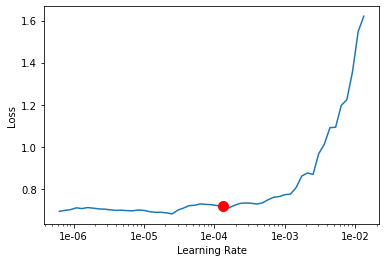

In [66]:
learner.recorder.plot(suggestion=True)

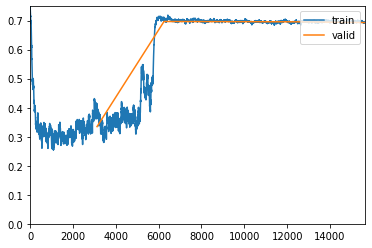

In [67]:
learner.fit_one_cycle(5, 1e-4, moms=(0.8,0.7))

In [51]:
learner.save('albert-no-pre-training-freezed')

In [40]:
# learner.load('no-pre-training-freezed');

## we only have 4 layer groups

In [52]:
len(learner.layer_groups)

4

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 2.29E-07


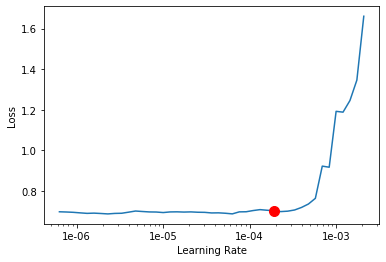

In [53]:
# since we have 14 layer_groups, we will unfreeze 2-3 layers to speed up the process
learner.freeze_to(-2)
torch.cuda.empty_cache()
learner.lr_find()
learner.recorder.plot(suggestion=True)

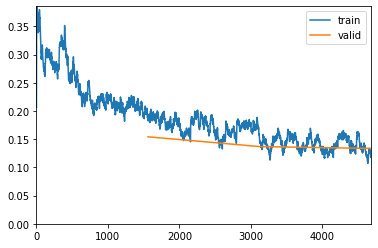

In [47]:
# ignore suggestion
learner.fit_one_cycle(3, 5e-5, moms=(0.8,0.7))

In [48]:
learner.save('no-pre-training-freez_to_-3')

In [ ]:
# learner.load('no-pre-training-freez_to_-3');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.31E-07


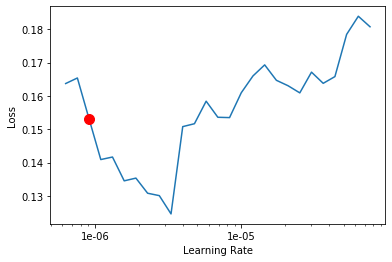

In [49]:
# since we have 14 layer_groups, we will unfreeze 2-3 layers to speed up the process
learner.freeze_to(-5)
torch.cuda.empty_cache()
learner.lr_find()
learner.recorder.plot(skip_end = 10, suggestion=True)

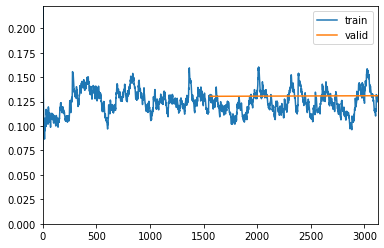

In [50]:
# ignore suggestion
learner.fit_one_cycle(2, 9.12E-07, moms=(0.8,0.7))

In [52]:
learner.save('no-pre-training-freez_to_-5')

In [38]:
learner.load('no-pre-training-freez_to_-5');

### We are able to get 95.3% accuracy without pre-finetuning

In the original guide of Jeremy Howard's ULMFiT for IMDB, he achieved **94.7%** accuracy. All the training strategies, like gradual unfreezing, learning rate annealing, batching are the same when constructing our `Learner`. Therefore, it's obvious that the `transformer` in stronger than `AWD_LSTM` for this task in terms of architecture.<br>

In the next notebook, we are going to push things further by incorporate the **ULMFiT** training procedure to the `transformer` training and see if we can get even better result.